<a href="https://colab.research.google.com/github/Afjanvirus/AI-assisted_NetworkSlicing/blob/main/MachineLearningProjectUoulu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


--- RUNNING SEED 1/5 ---

--- Starting Episode with Scenario: Scenario_406_heavyUL_2 ---

--- Starting Episode with Scenario: Scenario_35_heavyUL_1 ---

--- Episode 0 ---
Scenario: Scenario_35_heavyUL_1
Slice 1 DL: {'throughput': 144764.61863414117, 'latency': 10.69807962542053, 'jitter': 2.562578622578649, 'packetLoss': 0.0}
Slice 1 UL: {'throughput': 30737015.207809288, 'latency': 10.578961292803715, 'jitter': 1.3645879868746964, 'packetLoss': 0.0}
Slice 2 DL: {'throughput': 2745.665864927667, 'latency': 11.109093268416173, 'jitter': 1.4500170832247425, 'packetLoss': 0.0}
Slice 2 UL: {'throughput': 9948.33271159217, 'latency': 8.90427128169214, 'jitter': 2.926906718360341, 'packetLoss': 0.0}
DL: thr_reward=0.387, lat_penalty=0.613, jit_penalty=0.387, pl_penalty=0.000, total=1.736
UL: thr_reward=0.776, lat_penalty=0.776, jit_penalty=0.224, pl_penalty=0.000, total=3.681
Episode: 0 Alpha DL: tensor([0.7005, 0.6515], grad_fn=<SplitBackward0>) Action DL: tensor([0.3871, 0.6129])
Episode:

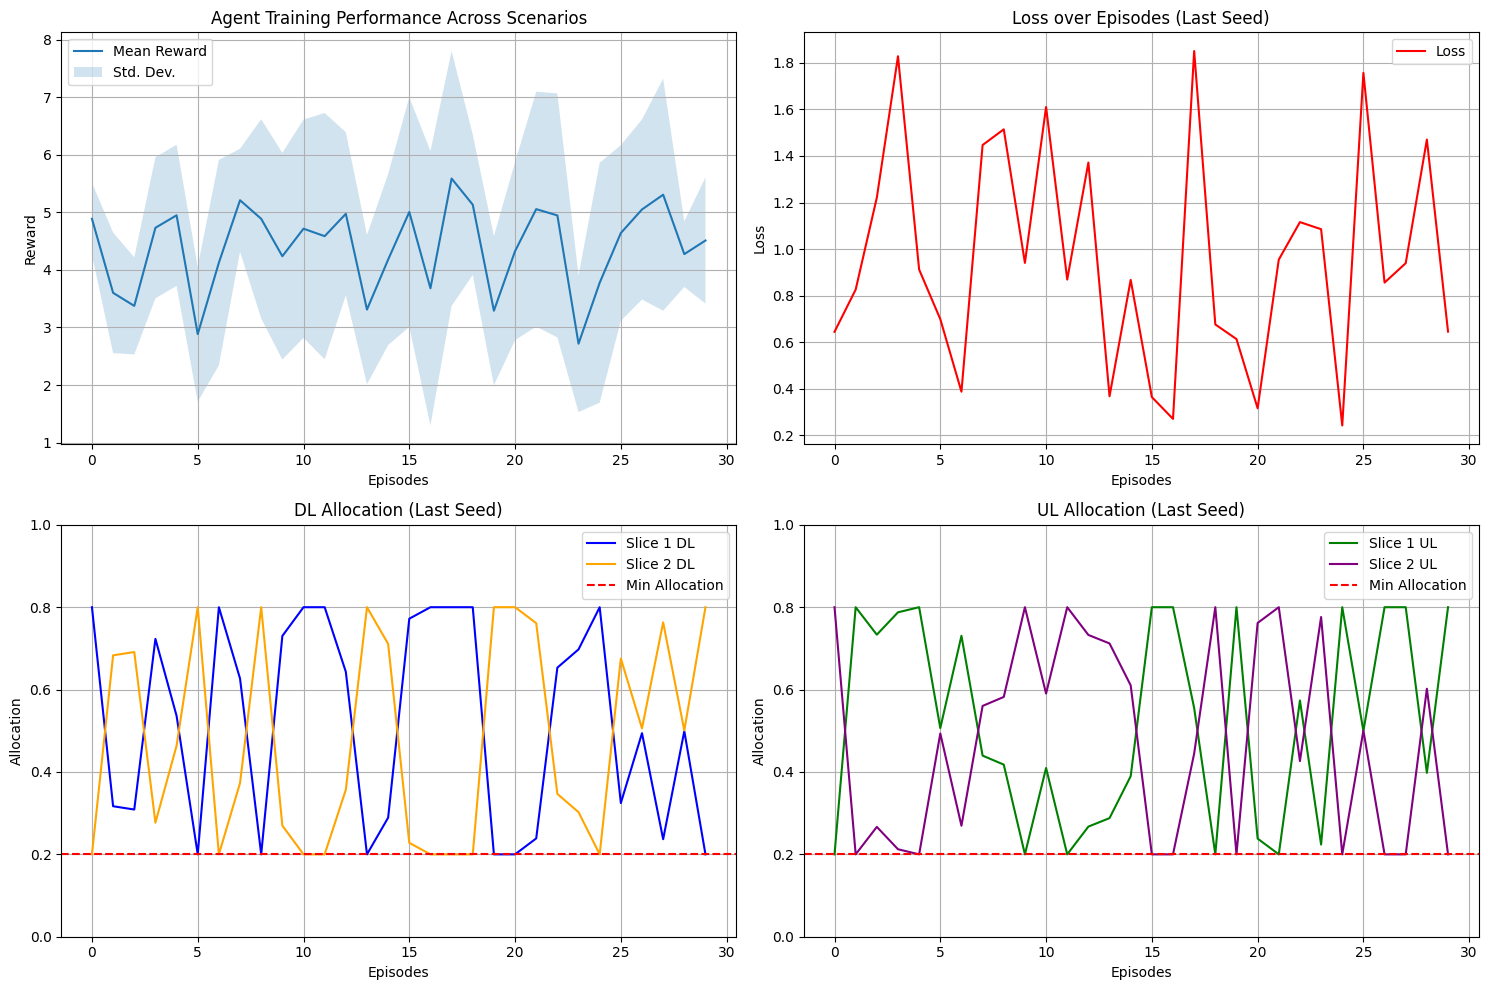

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Dirichlet
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import Dict, List, Tuple

# Import the dataset we created
# Make sure you have the kpi_scenarios.py file in the same directory
from kpi_scenarios import KPI_DATASET

def fetch_network_data() -> Dict:
    """Randomly selects a scenario from our predefined dataset."""
    scenario = random.choice(KPI_DATASET)
    print(f"\n--- Starting Episode with Scenario: {scenario['scenario_name']} ---")
    return scenario

# Define the Network Slice Environment
class NetworkSliceEnv:
    def __init__(self):
        # self.current_step is no longer needed but kept for consistency
        self.current_step = 0
        self.api_data = fetch_network_data()
        self.state = self.initial_state()
        self.min_allocation = 0.2
        self.update_scales()

    def update_scales(self):
        s1_dl, s1_ul = self.state['slice1']['downlink'], self.state['slice1']['uplink']
        s2_dl, s2_ul = self.state['slice2']['downlink'], self.state['slice2']['uplink']
        self.throughput_scale = max(s1_dl['throughput'], s1_ul['throughput'], s2_dl['throughput'], s2_ul['throughput'], 1)
        self.latency_scale = max(s1_dl['latency'], s1_ul['latency'], s2_dl['latency'], s2_ul['latency'], 1)
        self.jitter_scale = max(s1_dl['jitter'], s1_ul['jitter'], s2_dl['jitter'], s2_ul['jitter'], 1)
        packet_loss_max = max(s1_dl.get('packetLoss', 0), s1_ul.get('packetLoss', 0), s2_dl.get('packetLoss', 0), s2_ul.get('packetLoss', 0))
        self.packet_loss_scale = packet_loss_max if packet_loss_max > 0 else 1.0

    def initial_state(self) -> Dict:
        kpis = self.api_data["kpis"]
        return {
            'slice1': {'downlink': kpis[0]['downlink'], 'uplink': kpis[0]['uplink']},
            'slice2': {'downlink': kpis[1]['downlink'], 'uplink': kpis[1]['uplink']},
        }

    def reset(self) -> np.ndarray:
        self.current_step = 0
        self.api_data = fetch_network_data()
        self.state = self.initial_state()
        self.update_scales()
        return self.get_state_vector()

    def get_state_vector(self) -> np.ndarray:
        s1_dl, s1_ul = self.state['slice1']['downlink'], self.state['slice1']['uplink']
        s2_dl, s2_ul = self.state['slice2']['downlink'], self.state['slice2']['uplink']
        state_vector = [
            s1_dl['throughput'] / self.throughput_scale, s1_dl['latency'] / self.latency_scale, s1_dl['jitter'] / self.jitter_scale, s1_dl.get('packetLoss', 0) / self.packet_loss_scale,
            s1_ul['throughput'] / self.throughput_scale, s1_ul['latency'] / self.latency_scale, s1_ul['jitter'] / self.jitter_scale, s1_ul.get('packetLoss', 0) / self.packet_loss_scale,
            s2_dl['throughput'] / self.throughput_scale, s2_dl['latency'] / self.latency_scale, s2_dl['jitter'] / self.jitter_scale, s2_dl.get('packetLoss', 0) / self.packet_loss_scale,
            s2_ul['throughput'] / self.throughput_scale, s2_ul['latency'] / self.latency_scale, s2_ul['jitter'] / self.jitter_scale, s2_ul.get('packetLoss', 0) / self.packet_loss_scale,
        ]
        return np.array(state_vector, dtype=np.float32)

    def step(self, action_dl: np.ndarray, action_ul: np.ndarray) -> Tuple[np.ndarray, float, bool, Dict]:
        # --- MAJOR BUG FIX: The episode must end after one step. ---
        done = True
        next_state = self.get_state_vector() # This is a placeholder, as the episode is done.
        reward = self.compute_reward(action_dl, action_ul)
        return next_state, reward, done, {'dl': action_dl, 'ul': action_ul}

    def compute_reward(self, action_dl: np.ndarray, action_ul: np.ndarray) -> float:
        slice1, slice2 = self.state['slice1'], self.state['slice2']

        # --- Downlink Calculation ---
        max_dl_thr = max(slice1['downlink']['throughput'], slice2['downlink']['throughput'])
        min_dl_thr = min(slice1['downlink']['throughput'], slice2['downlink']['throughput'])
        achieved_dl_thr = (action_dl[0] * slice1['downlink']['throughput'] + action_dl[1] * slice2['downlink']['throughput'])
        dl_thr_reward = (achieved_dl_thr - min_dl_thr) / (max_dl_thr - min_dl_thr) if (max_dl_thr - min_dl_thr) > 0 else 0.5

        best_dl_lat = min(slice1['downlink']['latency'], slice2['downlink']['latency'])
        worst_dl_lat = max(slice1['downlink']['latency'], slice2['downlink']['latency'])
        achieved_dl_lat = (action_dl[0] * slice1['downlink']['latency'] + action_dl[1] * slice2['downlink']['latency'])
        dl_lat_penalty = (achieved_dl_lat - best_dl_lat) / (worst_dl_lat - best_dl_lat) if (worst_dl_lat - best_dl_lat) > 0 else 0

        best_dl_jit = min(slice1['downlink']['jitter'], slice2['downlink']['jitter'])
        worst_dl_jit = max(slice1['downlink']['jitter'], slice2['downlink']['jitter'])
        achieved_dl_jit = (action_dl[0] * slice1['downlink']['jitter'] + action_dl[1] * slice2['downlink']['jitter'])
        dl_jit_penalty = (achieved_dl_jit - best_dl_jit) / (worst_dl_jit - best_dl_jit) if (worst_dl_jit - best_dl_jit) > 0 else 0

        best_dl_pl = min(slice1['downlink'].get('packetLoss', 0), slice2['downlink'].get('packetLoss', 0))
        worst_dl_pl = max(slice1['downlink'].get('packetLoss', 0), slice2['downlink'].get('packetLoss', 0))
        achieved_dl_pl = (action_dl[0] * slice1['downlink'].get('packetLoss', 0) + action_dl[1] * slice2['downlink'].get('packetLoss', 0))
        dl_pl_penalty = (achieved_dl_pl - best_dl_pl) / (worst_dl_pl - best_dl_pl) if (worst_dl_pl - best_dl_pl) > 0 else 0

        # --- Uplink Calculation (Same Logic) ---
        max_ul_thr = max(slice1['uplink']['throughput'], slice2['uplink']['throughput'])
        min_ul_thr = min(slice1['uplink']['throughput'], slice2['uplink']['throughput'])
        achieved_ul_thr = (action_ul[0] * slice1['uplink']['throughput'] + action_ul[1] * slice2['uplink']['throughput'])
        ul_thr_reward = (achieved_ul_thr - min_ul_thr) / (max_ul_thr - min_ul_thr) if (max_ul_thr - min_ul_thr) > 0 else 0.5

        best_ul_lat = min(slice1['uplink']['latency'], slice2['uplink']['latency'])
        worst_ul_lat = max(slice1['uplink']['latency'], slice2['uplink']['latency'])
        achieved_ul_lat = (action_ul[0] * slice1['uplink']['latency'] + action_ul[1] * slice2['uplink']['latency'])
        ul_lat_penalty = (achieved_ul_lat - best_ul_lat) / (worst_ul_lat - best_ul_lat) if (worst_ul_lat - best_ul_lat) > 0 else 0

        best_ul_jit = min(slice1['uplink']['jitter'], slice2['uplink']['jitter'])
        worst_ul_jit = max(slice1['uplink']['jitter'], slice2['uplink']['jitter'])
        achieved_ul_jit = (action_ul[0] * slice1['uplink']['jitter'] + action_ul[1] * slice2['uplink']['jitter'])
        ul_jit_penalty = (achieved_ul_jit - best_ul_jit) / (worst_ul_jit - best_ul_jit) if (worst_ul_jit - best_ul_jit) > 0 else 0

        best_ul_pl = min(slice1['uplink'].get('packetLoss', 0), slice2['uplink'].get('packetLoss', 0))
        worst_ul_pl = max(slice1['uplink'].get('packetLoss', 0), slice2['uplink'].get('packetLoss', 0))
        achieved_ul_pl = (action_ul[0] * slice1['uplink'].get('packetLoss', 0) + action_ul[1] * slice2['uplink'].get('packetLoss', 0))
        ul_pl_penalty = (achieved_ul_pl - best_ul_pl) / (worst_ul_pl - best_ul_pl) if (worst_ul_pl - best_ul_pl) > 0 else 0

        # --- Adjusted weights ---
        throughput_weight = 5.0
        penalty_weight = 0.2

        dl_reward = (throughput_weight * dl_thr_reward) - (penalty_weight * (dl_lat_penalty + dl_jit_penalty + dl_pl_penalty))
        ul_reward = (throughput_weight * ul_thr_reward) - (penalty_weight * (ul_lat_penalty + ul_jit_penalty + ul_pl_penalty))

        print(f"DL: thr_reward={dl_thr_reward:.3f}, lat_penalty={dl_lat_penalty:.3f}, jit_penalty={dl_jit_penalty:.3f}, pl_penalty={dl_pl_penalty:.3f}, total={dl_reward:.3f}")
        print(f"UL: thr_reward={ul_thr_reward:.3f}, lat_penalty={ul_lat_penalty:.3f}, jit_penalty={ul_jit_penalty:.3f}, pl_penalty={ul_pl_penalty:.3f}, total={ul_reward:.3f}")
        return dl_reward + ul_reward

# Policy Network
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim: int = 16, hidden_dim: int = 256, output_dim: int = 4):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.softplus = nn.Softplus()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        alphas = self.softplus(self.fc3(x)) + 1e-6
        return torch.clamp(alphas, min=0.1)

def sample_constrained_action(alpha: torch.Tensor, min_allocation: float) -> torch.Tensor:
    try:
        action = Dirichlet(alpha).sample()
        if torch.all(action >= min_allocation):
            return action
        else:
            if action[0] < min_allocation:
                delta = min_allocation - action[0]
                action[0] = min_allocation
                action[1] -= delta
            elif action[1] < min_allocation:
                delta = min_allocation - action[1]
                action[1] = min_allocation
                action[0] -= delta
            action = torch.clamp(action, min=min_allocation)
            return action / action.sum()
    except ValueError:
        return torch.tensor([0.5, 0.5])

# Training function
def train_policy(num_episodes: int, seed: int) -> Tuple[List[float], ...]:
    torch.manual_seed(seed)
    np.random.seed(seed)

    env = NetworkSliceEnv()
    policy_network = PolicyNetwork(input_dim=len(env.get_state_vector()))
    optimizer = optim.Adam(policy_network.parameters(), lr=0.00001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5) # Halve the LR every 500 episodes

    best_avg_reward = -float('inf')
    results = ([], [], [], [], [], [])

    for episode in range(num_episodes):
        obs = torch.tensor(env.reset(), dtype=torch.float32)

        print(f"\n--- Episode {episode} ---")
        print(f"Scenario: {env.api_data['scenario_name']}")
        print("Slice 1 DL:", env.state['slice1']['downlink'])
        print("Slice 1 UL:", env.state['slice1']['uplink'])
        print("Slice 2 DL:", env.state['slice2']['downlink'])
        print("Slice 2 UL:", env.state['slice2']['uplink'])

        if torch.isnan(obs).any():
            print(f"WARNING: NaN detected in state for scenario: {env.api_data['scenario_name']}. Skipping episode.")
            continue

        # --- MAJOR BUG FIX: The training loop is now single-step ---

        all_alphas = policy_network(obs)
        alpha_dl, alpha_ul = torch.split(all_alphas, 2)
        action_dl = sample_constrained_action(alpha_dl, env.min_allocation)
        action_ul = sample_constrained_action(alpha_ul, env.min_allocation)

        _next_state, reward, done, _ = env.step(action_dl.detach().numpy(), action_ul.detach().numpy())

        log_prob = Dirichlet(alpha_dl).log_prob(action_dl) + Dirichlet(alpha_ul).log_prob(action_ul)

        # --- Policy Update for a single-step episode ---
        loss = -log_prob * reward

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # --- Logging and Saving ---
        results[0].append(reward) # The "total reward" is just the single reward
        results[1].append(loss.item())
        results[2].append(action_dl[0].item())
        results[3].append(action_dl[1].item())
        results[4].append(action_ul[0].item())
        results[5].append(action_ul[1].item())

        # --- Console Output ---
        print(f"Episode: {episode} Alpha DL: {alpha_dl} Action DL: {action_dl}")
        print(f"Episode: {episode} Alpha UL: {alpha_ul} Action UL: {action_ul}")

        if episode % 10 == 0:
            print(f"\n--- Episode {episode:3d} Summary ---")
            print(f"Reward: {reward:8.2f} | Loss: {loss.item():8.2f}\n")

        if reward > best_avg_reward:
            best_avg_reward = reward
            torch.save(policy_network.state_dict(), f'best_policy_model_seed_{seed}.pth')

        scheduler.step()

    return results

def run_experiments(num_seeds: int, num_episodes: int):
    all_rewards_history = []
    final_results_for_plotting = None

    for seed in range(num_seeds):
        print(f"\n--- RUNNING SEED {seed + 1}/{num_seeds} ---")
        results = train_policy(num_episodes, seed)
        if results and results[0]:
            all_rewards_history.append(results[0])
            final_results_for_plotting = results

    if not final_results_for_plotting:
        print("Training failed for all seeds or no data was collected.")
        return

    all_rewards_history = np.array(all_rewards_history)
    mean_rewards = np.mean(all_rewards_history, axis=0)
    std_rewards = np.std(all_rewards_history, axis=0)

    reward_history, loss_history, dl_s1, dl_s2, ul_s1, ul_s2 = final_results_for_plotting

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(mean_rewards, label='Mean Reward')
    plt.fill_between(range(len(mean_rewards)), mean_rewards - std_rewards, mean_rewards + std_rewards, alpha=0.2, label='Std. Dev.')
    plt.title('Agent Training Performance Across Scenarios')
    plt.xlabel('Episodes'); plt.ylabel('Reward'); plt.legend(); plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(loss_history, 'r', label='Loss')
    plt.title('Loss over Episodes (Last Seed)'); plt.xlabel('Episodes'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(dl_s1, 'b', label='Slice 1 DL'); plt.plot(dl_s2, 'orange', label='Slice 2 DL')
    plt.axhline(y=0.2, color='r', linestyle='--', label='Min Allocation')
    plt.ylim(0, 1); plt.title('DL Allocation (Last Seed)'); plt.xlabel('Episodes'); plt.ylabel('Allocation'); plt.legend(); plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(ul_s1, 'g', label='Slice 1 UL'); plt.plot(ul_s2, 'purple', label='Slice 2 UL')
    plt.axhline(y=0.2, color='r', linestyle='--', label='Min Allocation')
    plt.ylim(0, 1); plt.title('UL Allocation (Last Seed)'); plt.xlabel('Episodes'); plt.ylabel('Allocation'); plt.legend(); plt.grid(True)

    plt.tight_layout()

    plot_filename = 'training_results.png'
    plt.savefig(plot_filename)
    print(f"\n--- Plot saved to {plot_filename} ---")

    try:
        plt.show()
    except Exception as e:
        print(f"Could not display plot interactively: {e}")

if __name__ == "__main__":
    NUM_SEEDS = 5
    NUM_EPISODES = 30

    run_experiments(num_seeds=NUM_SEEDS, num_episodes=NUM_EPISODES)

#Refactored ML Code: Actor-Critic (A2C) Implementation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Dirichlet
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import Dict, List, Tuple

# Assuming kpi_scenarios.py is available with KPI_DATASET
from kpi_scenarios import KPI_DATASET

def fetch_network_data() -> Dict:
    scenario = random.choice(KPI_DATASET)
    # The print statement is now moved inside the training loop for cleaner output
    return scenario

# The NetworkSliceEnv remains largely the same, as it correctly models the problem.
class NetworkSliceEnv:
    def __init__(self):
        self.current_step = 0
        self.api_data = fetch_network_data()
        self.state = self.initial_state()
        self.min_allocation = 0.2
        self.update_scales()

    def update_scales(self):
        s1_dl, s1_ul = self.state['slice1']['downlink'], self.state['slice1']['uplink']
        s2_dl, s2_ul = self.state['slice2']['downlink'], self.state['slice2']['uplink']
        self.dl_throughput_scale = max(s1_dl['throughput'], s2_dl['throughput'], 1)
        self.ul_throughput_scale = max(s1_ul['throughput'], s2_ul['throughput'], 1)

        self.latency_scale = max(s1_dl['latency'], s1_ul['latency'], s2_dl['latency'], s2_ul['latency'], 1)
        self.jitter_scale = max(s1_dl['jitter'], s1_ul['jitter'], s2_dl['jitter'], s2_ul['jitter'], 1)
        packet_loss_max = max(s1_dl.get('packetLoss', 0), s1_ul.get('packetLoss', 0), s2_dl.get('packetLoss', 0), s2_ul.get('packetLoss', 0))
        self.packet_loss_scale = packet_loss_max if packet_loss_max > 0 else 1.0

    def initial_state(self) -> Dict:
        kpis = self.api_data["kpis"]
        return {
            'slice1': {'downlink': kpis[0]['downlink'], 'uplink': kpis[0]['uplink']},
            'slice2': {'downlink': kpis[1]['downlink'], 'uplink': kpis[1]['uplink']},
        }

    def reset(self) -> np.ndarray:
        self.current_step = 0
        self.api_data = fetch_network_data()
        self.state = self.initial_state()
        self.update_scales()
        return self.get_state_vector()

    def get_state_vector(self) -> np.ndarray:
        s1_dl, s1_ul = self.state['slice1']['downlink'], self.state['slice1']['uplink']
        s2_dl, s2_ul = self.state['slice2']['downlink'], self.state['slice2']['uplink']
        state_vector = [
            s1_dl['throughput'] / self.dl_throughput_scale, s1_dl['latency'] / self.latency_scale, s1_dl['jitter'] / self.jitter_scale, s1_dl.get('packetLoss', 0) / self.packet_loss_scale,
            s1_ul['throughput'] / self.ul_throughput_scale, s1_ul['latency'] / self.latency_scale, s1_ul['jitter'] / self.jitter_scale, s1_ul.get('packetLoss', 0) / self.packet_loss_scale,
            s2_dl['throughput'] / self.dl_throughput_scale, s2_dl['latency'] / self.latency_scale, s2_dl['jitter'] / self.jitter_scale, s2_dl.get('packetLoss', 0) / self.packet_loss_scale,
            s2_ul['throughput'] / self.ul_throughput_scale, s2_ul['latency'] / self.latency_scale, s2_ul['jitter'] / self.jitter_scale, s2_ul.get('packetLoss', 0) / self.packet_loss_scale,
        ]
        return np.array(state_vector, dtype=np.float32)

    def step(self, action_dl: np.ndarray, action_ul: np.ndarray) -> Tuple[np.ndarray, float, bool, Dict]:
        done = True # Environment is single-step
        next_state = self.get_state_vector()
        reward = self.compute_reward(action_dl, action_ul)
        return next_state, reward, done, {}

    def compute_reward(self, action_dl: np.ndarray, action_ul: np.ndarray) -> float:
        slice1, slice2 = self.state['slice1'], self.state['slice2']
        # --- Downlink Calculation ---
        dl_thr_s1 = slice1['downlink']['throughput']
        dl_thr_s2 = slice2['downlink']['throughput']
        # A2C: Simplified reward to directly target the goal. Reward is the achieved throughput.
        # This makes the Critic's job easier: it just has to predict the potential throughput.
        achieved_dl_thr = (action_dl[0] * dl_thr_s1 + action_dl[1] * dl_thr_s2)

        # --- Uplink Calculation ---
        ul_thr_s1 = slice1['uplink']['throughput']
        ul_thr_s2 = slice2['uplink']['throughput']
        achieved_ul_thr = (action_ul[0] * ul_thr_s1 + action_ul[1] * ul_thr_s2)

        # --- Reward based on total throughput scaled by importance ---
        # The primary goal is throughput, so the reward IS throughput.
        # We can still add small penalties if needed, but this is a cleaner signal.
        dl_reward = achieved_dl_thr / self.dl_throughput_scale
        ul_reward = achieved_ul_thr / self.ul_throughput_scale

        # The weights now represent the importance of DL vs UL throughput.
        total_reward = (0.7 * dl_reward) + (0.3 * ul_reward)
        return total_reward

# A2C: New combined Actor-Critic Network
class ActorCritic(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, actor_output_dim: int):
        super(ActorCritic, self).__init__()
        # Shared layers to learn common features from the state
        self.shared_fc1 = nn.Linear(input_dim, hidden_dim)
        self.shared_fc2 = nn.Linear(hidden_dim, hidden_dim)

        # Actor head: Outputs the policy parameters (alphas for Dirichlet)
        self.actor_head = nn.Linear(hidden_dim, actor_output_dim)

        # Critic head: Outputs a single value estimating the state's quality
        self.critic_head = nn.Linear(hidden_dim, 1)

        self.softplus = nn.Softplus()

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # Shared path
        x = torch.relu(self.shared_fc1(x))
        x = torch.relu(self.shared_fc2(x))

        # Actor path
        alphas = self.softplus(self.actor_head(x)) + 1e-6 # Add epsilon for numerical stability

        # Critic path
        value = self.critic_head(x)

        return alphas, value

# Action sampling function remains the same
def sample_constrained_action(alpha: torch.Tensor, min_allocation: float) -> torch.Tensor:
    # This function is fine, but we can simplify it to be more robust.
    # The dirichlet sample will sum to 1. We just need to enforce the minimum.
    try:
        dist = Dirichlet(alpha)
        action = dist.sample()

        # A more robust way to enforce constraints
        while torch.any(action < min_allocation):
            action = dist.sample() # Resample until constraint is met
            # This is simple but could be slow if min_allocation is high.
            # For min_allocation=0.2, this is perfectly fine.

        return action
    except ValueError:
        # Fallback for invalid alpha parameters (e.g., during early training)
        return torch.tensor([0.5, 0.5], device=alpha.device)


def train_policy(num_episodes: int, seed: int, model_save_path: str) ->
Tuple[List[float], ...]:
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    env = NetworkSliceEnv()
    # A2C: Instantiate the new network
    model = ActorCritic(input_dim=len(env.get_state_vector()), hidden_dim=256, actor_output_dim=4)
    optimizer = optim.Adam(model.parameters(), lr=3e-4)

    # A2C: Coefficients for balancing the loss terms
    critic_loss_weight = 0.5
    initial_entropy_weight = 0.01
    final_entropy_weight = 0.001
    entropy_decay_rate = (initial_entropy_weight - final_entropy_weight) / num_episodes
    best_avg_reward = -float('inf')
    reward_window = []
    #entropy_weight = 0.01

    results = ([], [], [], [], [], []) # rewards, losses, dl_s1, dl_s2, ul_s1, ul_s2

    for episode in range(num_episodes):
        obs = torch.tensor(env.reset(), dtype=torch.float32)

        if torch.isnan(obs).any():
            print(f"WARNING: NaN detected in state for scenario: {env.api_data['scenario_name']}. Skipping.")
            continue

        # A2C: Get both policy alphas and state value from the model
        all_alphas, state_value = model(obs)
        alpha_dl, alpha_ul = torch.split(all_alphas, 2)

        # Sample actions from the policy
        action_dl = sample_constrained_action(alpha_dl, env.min_allocation)
        action_ul = sample_constrained_action(alpha_ul, env.min_allocation)

        # Environment step
        _next_state, reward, done, _ = env.step(action_dl.detach().numpy(), action_ul.detach().numpy())
        reward = torch.tensor([reward], dtype=torch.float32) # Convert to tensor

        # --- A2C Loss Calculation ---

        # 1. Calculate Advantage: How much better was the reward than the Critic's prediction?
        advantage = reward - state_value

        # 2. Calculate Actor Loss (Policy Loss)
        dist_dl = Dirichlet(alpha_dl)
        dist_ul = Dirichlet(alpha_ul)
        log_prob = dist_dl.log_prob(action_dl) + dist_ul.log_prob(action_ul)
        actor_loss = -log_prob * advantage.detach() # .detach() stops gradients from flowing into the critic here

        # 3. Calculate Critic Loss (Value Loss) - a.k.a. Mean Squared Error
        critic_loss = advantage.pow(2).mean()

        # 4. Calculate Entropy Bonus (to encourage exploration)
        entropy = dist_dl.entropy() + dist_ul.entropy()
        current_entropy_weight = initial_entropy_weight - (episode * entropy_decay_rate)

        total_loss = actor_loss + critic_loss_weight * critic_loss - current_entropy_weight * entropy
        # --- Optimization Step ---
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Gradient clipping for stability
        optimizer.step()

        # --- Logging and Diagnostics ---
        results[0].append(reward.item())
        results[1].append(total_loss.item())
        results[2].append(action_dl[0].item())
        results[3].append(action_dl[1].item())
        results[4].append(action_ul[0].item())
        results[5].append(action_ul[1].item())

        if episode % 200 == 0:
            print(f"\n--- Episode {episode} | Scenario: {env.api_data['scenario_name']} ---")
            dl_thr = (env.state['slice1']['downlink']['throughput'], env.state['slice2']['downlink']['throughput'])
            ul_thr = (env.state['slice1']['uplink']['throughput'], env.state['slice2']['uplink']['throughput'])
            print(f"Throughputs (S1, S2): DL={dl_thr}, UL={ul_thr}")
            print(f"Action (S1, S2):      DL=[{action_dl[0]:.2f}, {action_dl[1]:.2f}], UL=[{action_ul[0]:.2f}, {action_ul[1]:.2f}]")
            print(f"Reward: {reward.item():.3f}, Critic Value: {state_value.item():.3f}, Advantage: {advantage.item():.3f}")
            print(f"Loss: {total_loss.item():.3f} (Actor: {actor_loss.item():.3f}, Critic: {critic_loss.item():.3f})")

    return results

# The experiment running and plotting code can remain the same.
def run_experiments(num_seeds: int, num_episodes: int):
    # This function is unchanged. It will now run the A2C training.
    all_rewards_history = []
    final_results_for_plotting = None

    for seed in range(num_seeds):
        print(f"\n{'='*20} RUNNING SEED {seed + 1}/{num_seeds} {'='*20}")
        results = train_policy(num_episodes, seed)
        if results and results[0]:
            all_rewards_history.append(results[0])
            final_results_for_plotting = results

    if not final_results_for_plotting:
        print("Training failed for all seeds or no data was collected.")
        return

    all_rewards_history = np.array(all_rewards_history)
    mean_rewards = np.mean(all_rewards_history, axis=0)
    std_rewards = np.std(all_rewards_history, axis=0)

    reward_history, loss_history, dl_s1, dl_s2, ul_s1, ul_s2 = final_results_for_plotting

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(mean_rewards, label='Mean Reward')
    plt.fill_between(range(len(mean_rewards)), mean_rewards - std_rewards, mean_rewards + std_rewards, alpha=0.2, label='Std. Dev.')
    plt.title('Agent Training Performance (A2C)')
    plt.xlabel('Episodes'); plt.ylabel('Reward'); plt.legend(); plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(loss_history, 'r', label='Loss')
    plt.title('Total Loss over Episodes (Last Seed)'); plt.xlabel('Episodes'); plt.ylabel('Loss'); plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(dl_s1, 'b', label='Slice 1 DL'); plt.plot(dl_s2, 'orange', label='Slice 2 DL')
    plt.axhline(y=0.2, color='r', linestyle='--', label='Min Allocation')
    plt.ylim(0, 1); plt.title('DL Allocation (Last Seed)'); plt.xlabel('Episodes'); plt.ylabel('Allocation'); plt.legend(); plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(ul_s1, 'g', label='Slice 1 UL'); plt.plot(ul_s2, 'purple', label='Slice 2 UL')
    plt.axhline(y=0.2, color='r', linestyle='--', label='Min Allocation')
    plt.ylim(0, 1); plt.title('UL Allocation (Last Seed)'); plt.xlabel('Episodes'); plt.ylabel('Allocation'); plt.legend(); plt.grid(True)

    plt.tight_layout()
    plt.savefig('a2c_training_results.png')
    plt.show()

if __name__ == "__main__":
    NUM_SEEDS = 3 # Reduced for faster testing
    NUM_EPISODES = 2000
    run_experiments(num_seeds=NUM_SEEDS, num_episodes=NUM_EPISODES)

SyntaxError: expected ':' (ipython-input-1439961442.py, line 142)

--- Phase 1: Training Multiple Models ---

==================== RUNNING SEED 1/3 ====================

--- Episode 0 | Scenario: Scenario_198_heavyUL_2 ---
Action (S1, S2):      DL=[0.60, 0.40], UL=[0.28, 0.72]
Reward: 0.479, Avg Reward (100ep): 0.479
Loss: 0.456, Entropy Weight: 0.01000

---> New best average reward: 0.4498. Model saved to slice_allocator_final_seed0.pth <---


---> New best average reward: 0.4520. Model saved to slice_allocator_final_seed0.pth <---


---> New best average reward: 0.4529. Model saved to slice_allocator_final_seed0.pth <---


---> New best average reward: 0.4552. Model saved to slice_allocator_final_seed0.pth <---


---> New best average reward: 0.4567. Model saved to slice_allocator_final_seed0.pth <---


---> New best average reward: 0.4597. Model saved to slice_allocator_final_seed0.pth <---


---> New best average reward: 0.4622. Model saved to slice_allocator_final_seed0.pth <---


---> New best average reward: 0.4638. Model saved to slice_allocat

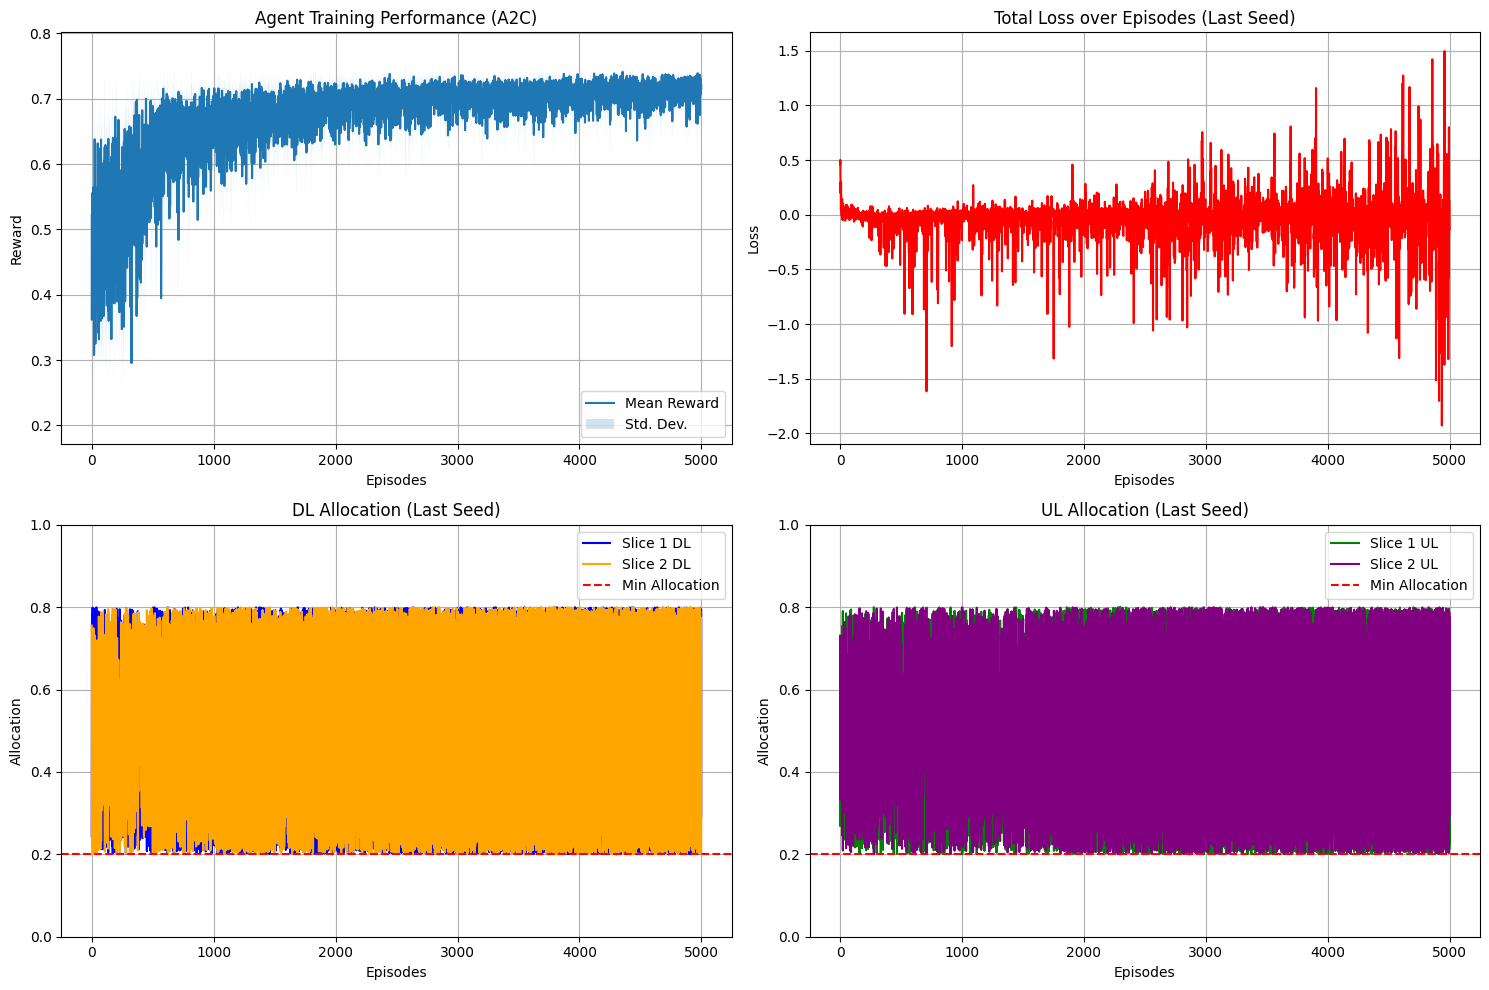


--- Phase 2: Selecting the Best Model from All Seeds ---

--- Evaluating model: slice_allocator_final_seed0.pth ---
Inference agent loaded successfully from slice_allocator_final_seed0.pth
Average reward on validation set: 0.7443
--- Evaluating model: slice_allocator_final_seed1.pth ---
Inference agent loaded successfully from slice_allocator_final_seed1.pth
Average reward on validation set: 0.7445
--- Evaluating model: slice_allocator_final_seed2.pth ---
Inference agent loaded successfully from slice_allocator_final_seed2.pth
Average reward on validation set: 0.7444

*** Champion Model Selected: slice_allocator_final_seed1.pth with performance 0.7445 ***


--- Phase 3: Demonstrating Deployment with Champion Model ---

Inference agent loaded successfully from slice_allocator_final_seed1.pth

--- Inference Test Case 1 ---
Scenario: Scenario_235_heavyUL_2
DL Throughputs (S1, S2): (4019, 149033) -> S2 is better
UL Throughputs (S1, S2): (4259, 30104189) -> S2 is better
==> Champion Agent'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Dirichlet
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import Dict, List, Tuple
import collections

# Assuming kpi_scenarios.py is available with KPI_DATASET
from kpi_scenarios import KPI_DATASET

def fetch_network_data() -> Dict:
    scenario = random.choice(KPI_DATASET)
    return scenario

class NetworkSliceEnv:
    # This class is already correct from our previous iteration. No changes needed.
    def __init__(self):
        self.current_step = 0
        self.api_data = fetch_network_data()
        self.state = self.initial_state()
        self.min_allocation = 0.2
        self.extremeness_penalty = 0.1
        self.update_scales()

    def update_scales(self):
        s1_dl, s1_ul = self.state['slice1']['downlink'], self.state['slice1']['uplink']
        s2_dl, s2_ul = self.state['slice2']['downlink'], self.state['slice2']['uplink']
        self.dl_throughput_scale = max(s1_dl['throughput'], s2_dl['throughput'], 1)
        self.ul_throughput_scale = max(s1_ul['throughput'], s2_ul['throughput'], 1)
        self.latency_scale = max(s1_dl['latency'], s1_ul['latency'], s2_dl['latency'], s2_ul['latency'], 1)
        self.jitter_scale = max(s1_dl['jitter'], s1_ul['jitter'], s2_dl['jitter'], s2_ul['jitter'], 1)
        packet_loss_max = max(s1_dl.get('packetLoss', 0), s1_ul.get('packetLoss', 0), s2_dl.get('packetLoss', 0), s2_ul.get('packetLoss', 0))
        self.packet_loss_scale = packet_loss_max if packet_loss_max > 0 else 1.0

    def initial_state(self) -> Dict:
        kpis = self.api_data["kpis"]
        return {
            'slice1': {'downlink': kpis[0]['downlink'], 'uplink': kpis[0]['uplink']},
            'slice2': {'downlink': kpis[1]['downlink'], 'uplink': kpis[1]['uplink']},
        }

    def reset(self) -> np.ndarray:
        self.current_step = 0
        self.api_data = fetch_network_data()
        self.state = self.initial_state()
        self.update_scales()
        return self.get_state_vector()

    def get_state_vector(self) -> np.ndarray:
        s1_dl, s1_ul = self.state['slice1']['downlink'], self.state['slice1']['uplink']
        s2_dl, s2_ul = self.state['slice2']['downlink'], self.state['slice2']['uplink']
        state_vector = [
            s1_dl['throughput'] / self.dl_throughput_scale, s1_dl['latency'] / self.latency_scale, s1_dl['jitter'] / self.jitter_scale, s1_dl.get('packetLoss', 0) / self.packet_loss_scale,
            s1_ul['throughput'] / self.ul_throughput_scale, s1_ul['latency'] / self.latency_scale, s1_ul['jitter'] / self.jitter_scale, s1_ul.get('packetLoss', 0) / self.packet_loss_scale,
            s2_dl['throughput'] / self.dl_throughput_scale, s2_dl['latency'] / self.latency_scale, s2_dl['jitter'] / self.jitter_scale, s2_dl.get('packetLoss', 0) / self.packet_loss_scale,
            s2_ul['throughput'] / self.ul_throughput_scale, s2_ul['latency'] / self.latency_scale, s2_ul['jitter'] / self.jitter_scale, s2_ul.get('packetLoss', 0) / self.packet_loss_scale,
        ]
        return np.array(state_vector, dtype=np.float32)

    def step(self, action_dl: np.ndarray, action_ul: np.ndarray) -> Tuple[np.ndarray, float, bool, Dict]:
        done = True
        next_state = self.get_state_vector()

        reward = self.compute_reward(action_dl, action_ul)
        return next_state, reward, done, {}

    def compute_reward(self, action_dl: np.ndarray, action_ul: np.ndarray) -> float:
        slice1, slice2 = self.state['slice1'], self.state['slice2']
        achieved_dl_thr = (action_dl[0] * slice1['downlink']['throughput'] + action_dl[1] * slice2['downlink']['throughput'])
        achieved_ul_thr = (action_ul[0] * slice1['uplink']['throughput'] + action_ul[1] * slice2['uplink']['throughput'])
        dl_reward = achieved_dl_thr / self.dl_throughput_scale
        ul_reward = achieved_ul_thr / self.ul_throughput_scale
        total_reward = (0.7 * dl_reward) + (0.3 * ul_reward)
        dl_penaly = abs(action_dl[0] - 0.5)
        ul_penalty = abs(action_ul[0] - 0.5)
        total_penalty = self.extremeness_penalty * (dl_penaly + ul_penalty)
        #Final reward to minus goal minus the small penalty
        final_reward = total_reward - total_penalty

        return final_reward

class ActorCritic(nn.Module):
    # This class is also correct. No changes needed.
    def __init__(self, input_dim: int, hidden_dim: int, actor_output_dim: int):
        super(ActorCritic, self).__init__()
        self.shared_fc1 = nn.Linear(input_dim, hidden_dim)
        self.shared_fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.actor_head = nn.Linear(hidden_dim, actor_output_dim)
        self.critic_head = nn.Linear(hidden_dim, 1)
        self.softplus = nn.Softplus()

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = torch.relu(self.shared_fc1(x))
        x = torch.relu(self.shared_fc2(x))
        alphas = self.softplus(self.actor_head(x)) + 1e-6
        value = self.critic_head(x)
        return alphas, value

def sample_constrained_action(alpha: torch.Tensor, min_allocation: float) -> torch.Tensor:
    # Correct. No changes needed.
    try:
        dist = Dirichlet(alpha)
        action = dist.sample()
        # Resample if constraint is violated.
        # This is simple and effective for our use case.
        while torch.any(action < min_allocation):
            action = dist.sample()
        return action
    except ValueError:
        return torch.tensor([0.5, 0.5], device=alpha.device)

def train_policy(num_episodes: int, seed: int, model_save_path: str) -> Tuple[List[float], ...]:
    # --- ACTION: Added model_save_path parameter ---
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    env = NetworkSliceEnv()
    model = ActorCritic(input_dim=len(env.get_state_vector()), hidden_dim=256, actor_output_dim=4)
    optimizer = optim.Adam(model.parameters(), lr=3e-4)

    critic_loss_weight = 0.5
    initial_entropy_weight = 0.01
    final_entropy_weight = 0.0001 # Reduced final entropy even further for more decisive actions
    entropy_decay_rate = (initial_entropy_weight - final_entropy_weight) / num_episodes

    results = ([], [], [], [], [], [])

    # --- ACTION: Add logic to track and save the best model ---
    best_avg_reward = -float('inf')
    # Use a deque for an efficient sliding window of recent rewards
    rewards_window = collections.deque(maxlen=100)
    # -----------------------------------------------------------

    for episode in range(num_episodes):
        obs = torch.tensor(env.reset(), dtype=torch.float32)

        if torch.isnan(obs).any():
            print(f"WARNING: NaN detected. Skipping episode.")
            continue

        all_alphas, state_value = model(obs)
        alpha_dl, alpha_ul = torch.split(all_alphas, 2)
        action_dl = sample_constrained_action(alpha_dl, env.min_allocation)
        action_ul = sample_constrained_action(alpha_ul, env.min_allocation)
        _next_state, reward, done, _ = env.step(action_dl.detach().numpy(), action_ul.detach().numpy())
        reward_tensor = torch.tensor([reward], dtype=torch.float32)

        advantage = reward_tensor - state_value
        dist_dl = Dirichlet(alpha_dl)
        dist_ul = Dirichlet(alpha_ul)
        log_prob = dist_dl.log_prob(action_dl) + dist_ul.log_prob(action_ul)
        actor_loss = -log_prob * advantage.detach()
        critic_loss = advantage.pow(2).mean()
        entropy = dist_dl.entropy() + dist_ul.entropy()
        current_entropy_weight = initial_entropy_weight - (episode * entropy_decay_rate)
        total_loss = actor_loss + critic_loss_weight * critic_loss - current_entropy_weight * entropy

        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        results[0].append(reward)
        results[1].append(total_loss.item())
        results[2].append(action_dl[0].item()); results[3].append(action_dl[1].item())
        results[4].append(action_ul[0].item()); results[5].append(action_ul[1].item())

        # --- ACTION: Logic to save the best performing model ---
        rewards_window.append(reward)
        if episode > 100: # Start saving after an initial "burn-in" period
            current_avg_reward = np.mean(rewards_window)
            if current_avg_reward > best_avg_reward:
                best_avg_reward = current_avg_reward
                torch.save(model.state_dict(), model_save_path)
                print(f"\n---> New best average reward: {best_avg_reward:.4f}. Model saved to {model_save_path} <---\n")
        # ----------------------------------------------------

        if episode % 500 == 0: # Print less frequently for longer runs
            print(f"\n--- Episode {episode} | Scenario: {env.api_data['scenario_name']} ---")
            print(f"Action (S1, S2):      DL=[{action_dl[0]:.2f}, {action_dl[1]:.2f}], UL=[{action_ul[0]:.2f}, {action_ul[1]:.2f}]")
            print(f"Reward: {reward:.3f}, Avg Reward (100ep): {np.mean(rewards_window):.3f}")
            print(f"Loss: {total_loss.item():.3f}, Entropy Weight: {current_entropy_weight:.5f}")

    return results

def run_experiments(num_seeds: int, num_episodes: int, model_save_path: str):
    # --- ACTION: Added model_save_path parameter ---
    all_rewards_history = []
    final_results_for_plotting = None

    for seed in range(num_seeds):
        print(f"\n{'='*20} RUNNING SEED {seed + 1}/{num_seeds} {'='*20}")
        # --- ACTION: Pass the save path to the training function ---
        # In a real project, you might save a different model for each seed
        seed_model_path = model_save_path.replace('.pth', f'_seed{seed}.pth')
        results = train_policy(num_episodes, seed, seed_model_path)
        if results and results[0]:
            all_rewards_history.append(results[0])
            final_results_for_plotting = results

    if not final_results_for_plotting:
        print("Training failed for all seeds or no data was collected.")
        return

    all_rewards_history = np.array(all_rewards_history)
    mean_rewards = np.mean(all_rewards_history, axis=0)
    std_rewards = np.std(all_rewards_history, axis=0)

    reward_history, loss_history, dl_s1, dl_s2, ul_s1, ul_s2 = final_results_for_plotting

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(mean_rewards, label='Mean Reward')
    plt.fill_between(range(len(mean_rewards)), mean_rewards - std_rewards, mean_rewards + std_rewards, alpha=0.2, label='Std. Dev.')
    plt.title('Agent Training Performance (A2C)')
    plt.xlabel('Episodes'); plt.ylabel('Reward'); plt.legend(); plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(loss_history, 'r', label='Loss')
    plt.title('Total Loss over Episodes (Last Seed)'); plt.xlabel('Episodes'); plt.ylabel('Loss'); plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(dl_s1, 'b', label='Slice 1 DL'); plt.plot(dl_s2, 'orange', label='Slice 2 DL')
    plt.axhline(y=0.2, color='r', linestyle='--', label='Min Allocation')
    plt.ylim(0, 1); plt.title('DL Allocation (Last Seed)'); plt.xlabel('Episodes'); plt.ylabel('Allocation'); plt.legend(); plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(ul_s1, 'g', label='Slice 1 UL'); plt.plot(ul_s2, 'purple', label='Slice 2 UL')
    plt.axhline(y=0.2, color='r', linestyle='--', label='Min Allocation')
    plt.ylim(0, 1); plt.title('UL Allocation (Last Seed)'); plt.xlabel('Episodes'); plt.ylabel('Allocation'); plt.legend(); plt.grid(True)

    plt.tight_layout()
    plt.savefig('a2c_training_results.png')
    plt.show()

# --- ACTION: New class for clean, deployable inference ---
class InferenceAgent:
    def __init__(self, model_path: str, input_dim: int = 16):
        self.model = ActorCritic(input_dim=input_dim, hidden_dim=256, actor_output_dim=4)
        self.model.load_state_dict(torch.load(model_path))
        self.model.eval() # CRITICAL: Set model to evaluation mode
        self.min_allocation = 0.2
        print(f"Inference agent loaded successfully from {model_path}")

    def select_action(self, state_vector: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        with torch.no_grad(): # Disable gradient calculations for speed
            obs = torch.tensor(state_vector, dtype=torch.float32)
            all_alphas, _ = self.model(obs)
            alpha_dl, alpha_ul = torch.split(all_alphas, 2)

            # Use deterministic argmax for deployment, not stochastic sampling
            dl_choice = torch.argmax(alpha_dl)
            ul_choice = torch.argmax(alpha_ul)

            action_dl = torch.tensor([self.min_allocation, self.min_allocation])
            action_ul = torch.tensor([self.min_allocation, self.min_allocation])

            action_dl[dl_choice] = 1.0 - self.min_allocation
            action_ul[ul_choice] = 1.0 - self.min_allocation

        return action_dl.numpy(), action_ul.numpy()

if __name__ == "__main__":
    NUM_SEEDS = 3 # Let's train a few models to compare
    NUM_EPISODES = 5000
    MODEL_SAVE_PATH_TEMPLATE = 'slice_allocator_final.pth' # Use a template name

    # --- Phase 1: Training and Saving Models for Each Seed ---
    print("--- Phase 1: Training Multiple Models ---")
    run_experiments(
        num_seeds=NUM_SEEDS,
        num_episodes=NUM_EPISODES,
        model_save_path=MODEL_SAVE_PATH_TEMPLATE
    )

    # --- Phase 2: Model Selection (Validation) ---
    print("\n" + "="*50)
    print("--- Phase 2: Selecting the Best Model from All Seeds ---")
    print("="*50 + "\n")

    best_model_path = None
    best_model_performance = -float('inf')

    # Create a validation environment. It's just a new env instance.
    validation_env = NetworkSliceEnv()

    for seed in range(NUM_SEEDS):
        current_model_path = MODEL_SAVE_PATH_TEMPLATE.replace('.pth', f'_seed{seed}.pth')
        try:
            print(f"--- Evaluating model: {current_model_path} ---")
            # Load the inference agent for the current seed's best model
            agent = InferenceAgent(model_path=current_model_path)

            total_reward = 0
            num_validation_episodes = 200 # Evaluate performance over 200 unseen scenarios

            for _ in range(num_validation_episodes):
                state_vec = validation_env.reset()
                action_dl, action_ul = agent.select_action(state_vec)
                _, reward, _, _ = validation_env.step(action_dl, action_ul)
                total_reward += reward

            avg_reward = total_reward / num_validation_episodes
            print(f"Average reward on validation set: {avg_reward:.4f}")

            if avg_reward > best_model_performance:
                best_model_performance = avg_reward
                best_model_path = current_model_path

        except FileNotFoundError:
            print(f"Could not find model at {current_model_path}. Skipping.")

    print(f"\n*** Champion Model Selected: {best_model_path} with performance {best_model_performance:.4f} ***\n")

    # --- Phase 3: Demonstrate Deployment with the Champion Model ---
    print("\n" + "="*50)
    print("--- Phase 3: Demonstrating Deployment with Champion Model ---")
    print("="*50 + "\n")

    if best_model_path:
        # Initialize the final inference agent with the *champion* model
        champion_agent = InferenceAgent(model_path=best_model_path)

        # Test on a few final random scenarios
        demo_env = NetworkSliceEnv()
        for i in range(5):
            print(f"\n--- Inference Test Case {i+1} ---")
            state_vec = demo_env.reset()
            # ... (rest of the demonstration logic is the same) ...
            dl_thr_s1, dl_thr_s2 = demo_env.state['slice1']['downlink']['throughput'], demo_env.state['slice2']['downlink']['throughput']
            ul_thr_s1, ul_thr_s2 = demo_env.state['slice1']['uplink']['throughput'], demo_env.state['slice2']['uplink']['throughput']

            print(f"Scenario: {demo_env.api_data['scenario_name']}")
            print(f"DL Throughputs (S1, S2): ({dl_thr_s1:.0f}, {dl_thr_s2:.0f}) -> S{1 if dl_thr_s1 > dl_thr_s2 else 2} is better")
            print(f"UL Throughputs (S1, S2): ({ul_thr_s1:.0f}, {ul_thr_s2:.0f}) -> S{1 if ul_thr_s1 > ul_thr_s2 else 2} is better")

            action_dl, action_ul = champion_agent.select_action(state_vec)

            print(f"==> Champion Agent's Action: DL={action_dl}, UL={action_ul}")
    else:
        print("No models were successfully trained or found. Cannot demonstrate deployment.")

#Live Network Data and Results Graph

Log data parsing successful.
Found 61 complete log entries.

--- First 5 Parsed Data Points ---
                           dl_thr_s1  ul_thr_s1  dl_thr_s2  ul_thr_s2  \
timestamp                                                               
2025-08-05 12:30:51.724       3912.0     6904.0     1920.0     3880.0   
2025-08-05 12:30:53.780       2696.0     4856.0     1920.0     4752.0   
2025-08-05 12:30:55.832       2696.0     5672.0     2528.0     4904.0   
2025-08-05 12:30:57.885       3528.0     5912.0     1920.0     4600.0   
2025-08-05 12:30:59.937  399107300.0  1424864.0     1920.0     4600.0   

                         dl_alloc_s1  dl_alloc_s2  ul_alloc_s1  ul_alloc_s2  
timestamp                                                                    
2025-08-05 12:30:51.724       0.7343       0.2657       0.7448       0.2552  
2025-08-05 12:30:53.780       0.5622       0.4378       0.6007       0.3993  
2025-08-05 12:30:55.832       0.5411       0.4589       0.5811       0.4189  
20

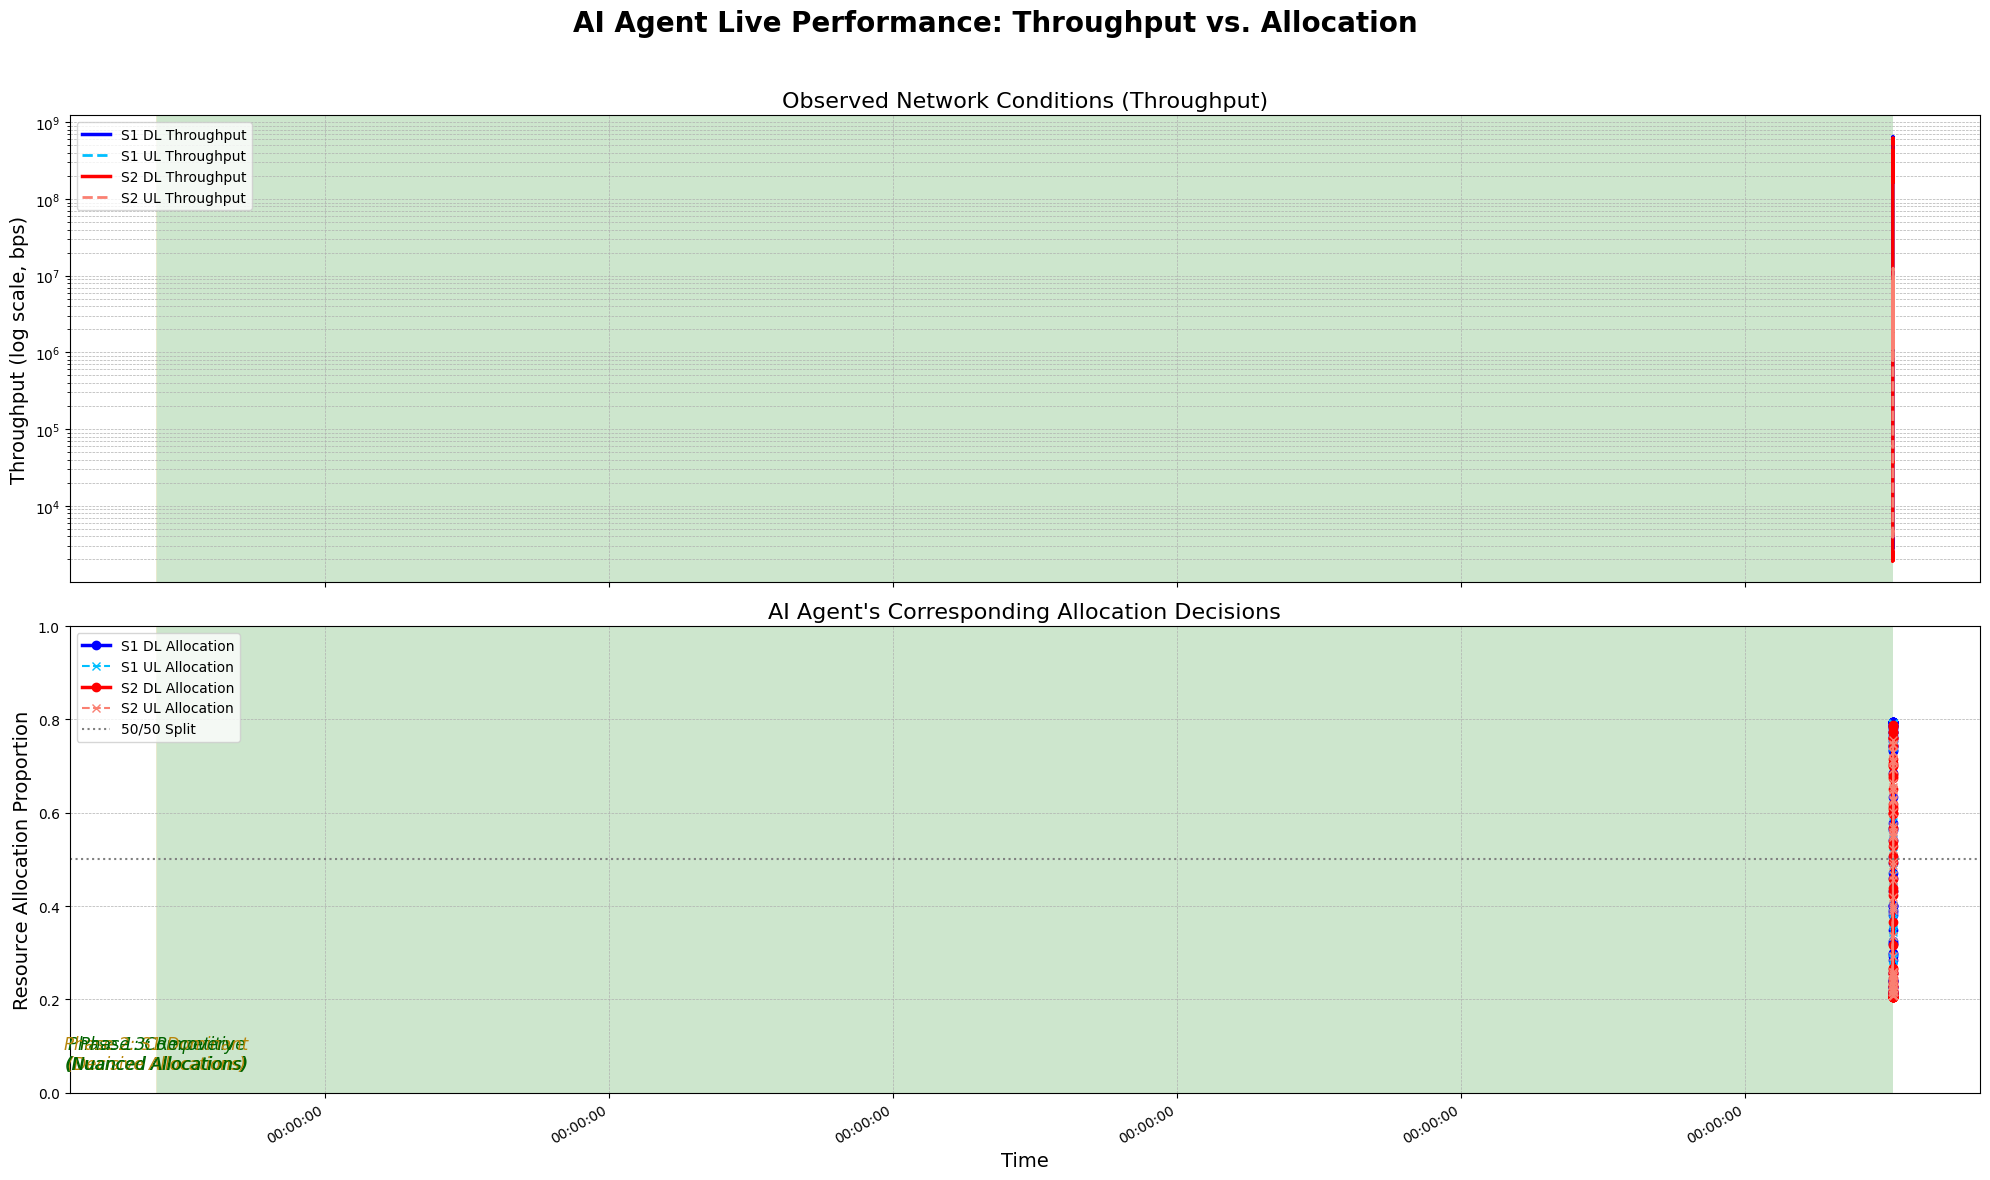

In [ ]:
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import os

# --- 1. Raw Log Data ---
# The full, combined log data is included here.
LOG_DATA = """
2025-08-05 12:30:51.724: Got KPIs from Qosium: [{"downlink": {"throughput": 3912.0, "latency": 7.161, "jitter": 0.682, "packetLoss": 0.0}, "uplink": {"throughput": 6904.0, "latency": 7.851, "jitter": 1.14, "packetLoss": 0.0}}, {"downlink": {"throughput": 1920.0, "latency": 5.469, "jitter": 0.255, "packetLoss": 0.0}, "uplink": {"throughput": 3880.0, "latency": 8.405, "jitter": 1.567, "packetLoss": 0.0}}]
2025-08-05 12:30:51.739: Got DL slice allocation; Slice1=0.7343, Slice2=0.2657
2025-08-05 12:30:51.739: Got UL slice allocation; Slice1=0.7448, Slice2=0.2552
2025-08-05 12:30:53.780: Got KPIs from Qosium: [{"downlink": {"throughput": 2696.0, "latency": 6.685, "jitter": 1.527, "packetLoss": 0.0}, "uplink": {"throughput": 4856.0, "latency": 8.327, "jitter": 1.725, "packetLoss": 0.0}}, {"downlink": {"throughput": 1920.0, "latency": 5.52, "jitter": 1.757, "packetLoss": 0.0}, "uplink": {"throughput": 4752.0, "latency": 8.626, "jitter": 1.24, "packetLoss": 0.0}}]
2025-08-05 12:30:53.789: Got DL slice allocation; Slice1=0.5622, Slice2=0.4378
2025-08-05 12:30:53.789: Got UL slice allocation; Slice1=0.6007, Slice2=0.3993
2025-08-05 12:30:55.832: Got KPIs from Qosium: [{"downlink": {"throughput": 2696.0, "latency": 6.7360215, "jitter": 0.835, "packetLoss": 0.0}, "uplink": {"throughput": 5672.0, "latency": 7.8969784, "jitter": 1.486, "packetLoss": 0.0}}, {"downlink": {"throughput": 2528.0, "latency": 6.287, "jitter": 1.569, "packetLoss": 0.0}, "uplink": {"throughput": 4904.0, "latency": 8.772, "jitter": 1.171, "packetLoss": 0.0}}]
2025-08-05 12:30:55.839: Got DL slice allocation; Slice1=0.5411, Slice2=0.4589
2025-08-05 12:30:55.839: Got UL slice allocation; Slice1=0.5811, Slice2=0.4189
2025-08-05 12:30:57.885: Got KPIs from Qosium: [{"downlink": {"throughput": 3528.0, "latency": 6.491896, "jitter": 1.17, "packetLoss": 0.0}, "uplink": {"throughput": 5912.0, "latency": 8.135104, "jitter": 1.215, "packetLoss": 0.0}}, {"downlink": {"throughput": 1920.0, "latency": 5.429, "jitter": 0.003, "packetLoss": 0.0}, "uplink": {"throughput": 4600.0, "latency": 9.432, "jitter": 1.73, "packetLoss": 0.0}}]
2025-08-05 12:30:57.895: Got DL slice allocation; Slice1=0.6844, Slice2=0.3156
2025-08-05 12:30:57.895: Got UL slice allocation; Slice1=0.7066, Slice2=0.2934
2025-08-05 12:30:59.937: Got KPIs from Qosium: [{"downlink": {"throughput": 399107300.0, "latency": 8.471236, "jitter": 0.042, "packetLoss": 0.0}, "uplink": {"throughput": 1424864.0, "latency": 7.853763, "jitter": 2.973, "packetLoss": 0.0}}, {"downlink": {"throughput": 1920.0, "latency": 5.532, "jitter": 0.028, "packetLoss": 0.0}, "uplink": {"throughput": 4600.0, "latency": 8.34, "jitter": 1.797, "packetLoss": 0.0}}]
2025-08-05 12:30:59.944: Got DL slice allocation; Slice1=0.795, Slice2=0.205
2025-08-05 12:30:59.944: Got UL slice allocation; Slice1=0.7917, Slice2=0.2083
2025-08-05 12:31:01.986: Got KPIs from Qosium: [{"downlink": {"throughput": 566968192.0, "latency": 7.9070000648498535, "jitter": 0.0689999982714653, "packetLoss": 0.0}, "uplink": {"throughput": 2951944.0, "latency": 9.925999641418457, "jitter": 0.2630000114440918, "packetLoss": 0.0}}, {"downlink": {"throughput": 1920.0, "latency": 5.5279998779296875, "jitter": 1.3389999866485596, "packetLoss": 0.0}, "uplink": {"throughput": 3880.0, "latency": 8.769000053405762, "jitter": 1.24399995803833, "packetLoss": 0.0}}]
2025-08-05 12:31:01.993: Got DL slice allocation; Slice1=0.7938, Slice2=0.2062
2025-08-05 12:31:01.993: Got UL slice allocation; Slice1=0.7904, Slice2=0.2096
2025-08-05 12:31:04.032: Got KPIs from Qosium: [{"downlink": {"throughput": 612965376.0, "latency": 7.940999984741211, "jitter": 0.08399999886751175, "packetLoss": 0.0}, "uplink": {"throughput": 5567080.0, "latency": 10.918000221252441, "jitter": 0.32899999618530273, "packetLoss": 0.0}}, {"downlink": {"throughput": 2528.0, "latency": 6.089000225067139, "jitter": 0.7699999809265137, "packetLoss": 0.0}, "uplink": {"throughput": 4752.0, "latency": 8.895999908447266, "jitter": 2.683000087738037, "packetLoss": 0.0}}]
2025-08-05 12:31:04.040: Got DL slice allocation; Slice1=0.7941, Slice2=0.2059
2025-08-05 12:31:04.040: Got UL slice allocation; Slice1=0.7903, Slice2=0.2097
2025-08-05 12:31:06.074: Got KPIs from Qosium: [{"downlink": {"throughput": 611598144.0, "latency": 8.109999656677246, "jitter": 0.07199999690055847, "packetLoss": 0.0}, "uplink": {"throughput": 6501024.0, "latency": 9.444000244140625, "jitter": 0.36500000953674316, "packetLoss": 0.0}}, {"downlink": {"throughput": 1920.0, "latency": 5.066999912261963, "jitter": 0.08100000023841858, "packetLoss": 0.0}, "uplink": {"throughput": 3880.0, "latency": 8.505999565124512, "jitter": 1.406999945640564, "packetLoss": 0.0}}]
2025-08-05 12:31:06.081: Got DL slice allocation; Slice1=0.7942, Slice2=0.2058
2025-08-05 12:31:06.081: Got UL slice allocation; Slice1=0.7905, Slice2=0.2095
2025-08-05 12:31:08.114: Got KPIs from Qosium: [{"downlink": {"throughput": 611463616.0, "latency": 8.03499984741211, "jitter": 0.10499999672174454, "packetLoss": 0.0}, "uplink": {"throughput": 5125648.0, "latency": 9.607000350952148, "jitter": 0.2029999941587448, "packetLoss": 0.0}}, {"downlink": {"throughput": 1920.0, "latency": 5.011000156402588, "jitter": 0.08799999952316284, "packetLoss": 0.0}, "uplink": {"throughput": 3880.0, "latency": 8.824999809265137, "jitter": 1.0460000038146973, "packetLoss": 0.0}}]
2025-08-05 12:31:08.121: Got DL slice allocation; Slice1=0.7942, Slice2=0.2058
2025-08-05 12:31:08.121: Got UL slice allocation; Slice1=0.7905, Slice2=0.2095
2025-08-05 12:31:10.163: Got KPIs from Qosium: [{"downlink": {"throughput": 613054528.0, "latency": 8.126999855041504, "jitter": 0.04600000008940697, "packetLoss": 0.0}, "uplink": {"throughput": 6394888.0, "latency": 9.67300033569336, "jitter": 0.1979999989271164, "packetLoss": 0.0}}, {"downlink": {"throughput": 2528.0, "latency": 6.132999897003174, "jitter": 1.5290000438690186, "packetLoss": 0.0}, "uplink": {"throughput": 4032.0, "latency": 8.657999992370605, "jitter": 3.7929999828338623, "packetLoss": 0.0}}]
2025-08-05 12:31:10.170: Got DL slice allocation; Slice1=0.794, Slice2=0.206
2025-08-05 12:31:10.170: Got UL slice allocation; Slice1=0.7903, Slice2=0.2097
2025-08-05 12:31:12.219: Got KPIs from Qosium: [{"downlink": {"throughput": 608637760.0, "latency": 8.003000259399414, "jitter": 0.10499999672174454, "packetLoss": 0.0}, "uplink": {"throughput": 9008392.0, "latency": 10.605999946594238, "jitter": 0.11599999666213989, "packetLoss": 0.0}}, {"downlink": {"throughput": 37690.30859375, "latency": 6.3480000495910645, "jitter": 0.8019999861717224, "packetLoss": 0.0}, "uplink": {"throughput": 60691.30859375, "latency": 9.321999549865723, "jitter": 1.6759999990463257, "packetLoss": 0.0}}]
2025-08-05 12:31:12.226: Got DL slice allocation; Slice1=0.794, Slice2=0.206
2025-08-05 12:31:12.226: Got UL slice allocation; Slice1=0.7904, Slice2=0.2096
2025-08-05 12:31:14.267: Got KPIs from Qosium: [{"downlink": {"throughput": 611879744.0, "latency": 7.798999786376953, "jitter": 0.0430000014603138, "packetLoss": 0.0}, "uplink": {"throughput": 3410008.0, "latency": 9.498000144958496, "jitter": 0.13600000739097595, "packetLoss": 0.0}}, {"downlink": {"throughput": 37824.0, "latency": 5.491464614868164, "jitter": 0.6930000185966492, "packetLoss": 0.0}, "uplink": {"throughput": 60184.0, "latency": 8.881535530090332, "jitter": 1.3990000486373901, "packetLoss": 0.0}}]
2025-08-05 12:31:14.275: Got DL slice allocation; Slice1=0.7939, Slice2=0.2061
2025-08-05 12:31:14.275: Got UL slice allocation; Slice1=0.7903, Slice2=0.2097
2025-08-05 12:31:16.312: Got KPIs from Qosium: [{"downlink": {"throughput": 612398272.0, "latency": 8.208999633789062, "jitter": 0.10599999874830246, "packetLoss": 0.0}, "uplink": {"throughput": 5437936.0, "latency": 10.210000038146973, "jitter": 0.12700000405311584, "packetLoss": 0.0}}, {"downlink": {"throughput": 36480.0, "latency": 5.532040119171143, "jitter": 0.6460000276565552, "packetLoss": 0.0}, "uplink": {"throughput": 59144.0, "latency": 8.822959899902344, "jitter": 2.127000093460083, "packetLoss": 0.0}}]
2025-08-05 12:31:16.318: Got DL slice allocation; Slice1=0.7939, Slice2=0.2061
2025-08-05 12:31:16.318: Got UL slice allocation; Slice1=0.7901, Slice2=0.2099
2025-08-05 12:31:18.347: Got KPIs from Qosium: [{"downlink": {"throughput": 611541120.0, "latency": 8.072999954223633, "jitter": 0.10999999940395355, "packetLoss": 0.0}, "uplink": {"throughput": 4300236.0, "latency": 11.192999839782715, "jitter": 0.18700000643730164, "packetLoss": 0.0}}, {"downlink": {"throughput": 187569008.0, "latency": 19.289215087890625, "jitter": 0.10700000077486038, "packetLoss": 0.0}, "uplink": {"throughput": 503992.0, "latency": 7.964785575866699, "jitter": 0.3479999899864197, "packetLoss": 0.0}}]
2025-08-05 12:31:18.354: Got DL slice allocation; Slice1=0.7904, Slice2=0.2096
2025-08-05 12:31:18.354: Got UL slice allocation; Slice1=0.7845, Slice2=0.2155
2025-08-05 12:31:20.386: Got KPIs from Qosium: [{"downlink": {"throughput": 610589952.0, "latency": 7.688000202178955, "jitter": 0.1850000023841858, "packetLoss": 0.0}, "uplink": {"throughput": 6098571.0, "latency": 10.095000267028809, "jitter": 0.21899999678134918, "packetLoss": 0.0}}, {"downlink": {"throughput": 194399488.0, "latency": 9.324000358581543, "jitter": 0.11500000208616257, "packetLoss": 0.0}, "uplink": {"throughput": 2804720.0, "latency": 9.22700023651123, "jitter": 0.3580000102519989, "packetLoss": 0.0}}]
2025-08-05 12:31:20.394: Got DL slice allocation; Slice1=0.7737, Slice2=0.2263
2025-08-05 12:31:20.394: Got UL slice allocation; Slice1=0.7712, Slice2=0.2288
2025-08-05 12:31:22.427: Got KPIs from Qosium: [{"downlink": {"throughput": 611031296.0, "latency": 7.797999858856201, "jitter": 0.14399999380111694, "packetLoss": 0.0}, "uplink": {"throughput": 3699728.0, "latency": 10.994999885559082, "jitter": 0.38499999046325684, "packetLoss": 0.0}}, {"downlink": {"throughput": 207295776.0, "latency": 9.621000289916992, "jitter": 0.10100000351667404, "packetLoss": 0.0}, "uplink": {"throughput": 1707045.0, "latency": 9.076000213623047, "jitter": 0.21299999952316284, "packetLoss": 0.0}}]
2025-08-05 12:31:22.434: Got DL slice allocation; Slice1=0.7722, Slice2=0.2278
2025-08-05 12:31:22.434: Got UL slice allocation; Slice1=0.7698, Slice2=0.2302
2025-08-05 12:31:24.465: Got KPIs from Qosium: [{"downlink": {"throughput": 611946880.0, "latency": 8.0600004196167, "jitter": 0.2240000069141388, "packetLoss": 0.0}, "uplink": {"throughput": 4360872.0, "latency": 9.574999809265137, "jitter": 0.17599999904632568, "packetLoss": 0.0}}, {"downlink": {"throughput": 210284096.0, "latency": 9.550999641418457, "jitter": 0.125, "packetLoss": 0.0}, "uplink": {"throughput": 755511.0, "latency": 9.880999565124512, "jitter": 0.45100000500679016, "packetLoss": 0.0}}]
2025-08-05 12:31:24.472: Got DL slice allocation; Slice1=0.7884, Slice2=0.2116
2025-08-05 12:31:24.472: Got UL slice allocation; Slice1=0.7841, Slice2=0.2159
2025-08-05 12:31:26.500: Got KPIs from Qosium: [{"downlink": {"throughput": 610251136.0, "latency": 7.769000053405762, "jitter": 0.06300000101327896, "packetLoss": 0.0}, "uplink": {"throughput": 4314997.0, "latency": 10.02299976348877, "jitter": 0.17399999499320984, "packetLoss": 0.0}}, {"downlink": {"throughput": 198790896.0, "latency": 9.243000030517578, "jitter": 0.2329999953508377, "packetLoss": 0.0}, "uplink": {"throughput": 2272377.25, "latency": 8.989999771118164, "jitter": 0.1720000058412552, "packetLoss": 0.0}}]
2025-08-05 12:31:26.509: Got DL slice allocation; Slice1=0.7601, Slice2=0.2399
2025-08-05 12:31:26.509: Got UL slice allocation; Slice1=0.761, Slice2=0.239
2025-08-05 12:31:28.537: Got KPIs from Qosium: [{"downlink": {"throughput": 516821984.0, "latency": 7.875, "jitter": 0.06400000303983688, "packetLoss": 0.0}, "uplink": {"throughput": 4974832.0, "latency": 11.60200023651123, "jitter": 0.2029999941587448, "packetLoss": 0.0}}, {"downlink": {"throughput": 218192016.0, "latency": 9.279999732971191, "jitter": 0.12099999934434891, "packetLoss": 0.0}, "uplink": {"throughput": 2839944.0, "latency": 11.847999572753906, "jitter": 0.17399999499320984, "packetLoss": 0.0}}]
2025-08-05 12:31:28.545: Got DL slice allocation; Slice1=0.7434, Slice2=0.2566
2025-08-05 12:31:28.546: Got UL slice allocation; Slice1=0.7488, Slice2=0.2512
2025-08-05 12:31:30.576: Got KPIs from Qosium: [{"downlink": {"throughput": 607545984.0, "latency": 8.149999618530273, "jitter": 0.0430000014603138, "packetLoss": 0.0}, "uplink": {"throughput": 8821539.0, "latency": 10.897000312805176, "jitter": 0.21699999272823334, "packetLoss": 0.0}}, {"downlink": {"throughput": 232518240.0, "latency": 9.723999977111816, "jitter": 0.10199999809265137, "packetLoss": 0.0}, "uplink": {"throughput": 2739761.0, "latency": 9.14799976348877, "jitter": 0.09700000286102295, "packetLoss": 0.0}}]
2025-08-05 12:31:30.583: Got DL slice allocation; Slice1=0.7788, Slice2=0.2212
2025-08-05 12:31:30.583: Got UL slice allocation; Slice1=0.7748, Slice2=0.2252
2025-08-05 12:31:32.630: Got KPIs from Qosium: [{"downlink": {"throughput": 610760384.0, "latency": 8.006999969482422, "jitter": 0.05999999865889549, "packetLoss": 0.0}, "uplink": {"throughput": 3551072.0, "latency": 11.083000183105469, "jitter": 0.1509999930858612, "packetLoss": 0.0}}, {"downlink": {"throughput": 212041500.0, "latency": 9.985, "jitter": 0.108, "packetLoss": 0.0}, "uplink": {"throughput": 2424800.8, "latency": 10.343, "jitter": 0.087, "packetLoss": 0.0}}]
2025-08-05 12:31:32.637: Got DL slice allocation; Slice1=0.7334, Slice2=0.2666
2025-08-05 12:31:32.637: Got UL slice allocation; Slice1=0.7416, Slice2=0.2584
2025-08-05 12:31:34.672: Got KPIs from Qosium: [{"downlink": {"throughput": 572693952.0, "latency": 23.773000717163086, "jitter": 0.0689999982714653, "packetLoss": 0.0}, "uplink": {"throughput": 4209119.0, "latency": 9.53600025177002, "jitter": 0.18400000035762787, "packetLoss": 0.0}}, {"downlink": {"throughput": 207076784.0, "latency": 9.932999610900879, "jitter": 0.12099999934434891, "packetLoss": 0.0}, "uplink": {"throughput": 1192415.125, "latency": 10.230999946594238, "jitter": 0.16699999570846558, "packetLoss": 0.0}}]
2025-08-05 12:31:34.679: Got DL slice allocation; Slice1=0.7829, Slice2=0.2171
2025-08-05 12:31:34.679: Got UL slice allocation; Slice1=0.7772, Slice2=0.2228
2025-08-05 12:31:36.707: Got KPIs from Qosium: [{"downlink": {"throughput": 611367936.0, "latency": 8.156999588012695, "jitter": 0.05299999937415123, "packetLoss": 0.0}, "uplink": {"throughput": 6643364.5, "latency": 11.012999534606934, "jitter": 0.10000000149011612, "packetLoss": 0.0}}, {"downlink": {"throughput": 168184400.0, "latency": 9.5, "jitter": 0.13600000739097595, "packetLoss": 0.0}, "uplink": {"throughput": 1704614.125, "latency": 11.229000091552734, "jitter": 0.21699999272823334, "packetLoss": 0.0}}]
2025-08-05 12:31:36.714: Got DL slice allocation; Slice1=0.786, Slice2=0.214
2025-08-05 12:31:36.714: Got UL slice allocation; Slice1=0.7814, Slice2=0.2186
2025-08-05 12:31:38.739: Got KPIs from Qosium: [{"downlink": {"throughput": 466041300.0, "latency": 7.702, "jitter": 0.154, "packetLoss": 0.0}, "uplink": {"throughput": 4746507.0, "latency": 10.964, "jitter": 0.236, "packetLoss": 0.0}}, {"downlink": {"throughput": 167172784.0, "latency": 9.192999839782715, "jitter": 0.13600000739097595, "packetLoss": 0.0}, "uplink": {"throughput": 1041413.1875, "latency": 13.956999778747559, "jitter": 0.9589999914169312, "packetLoss": 0.0}}]
2025-08-05 12:31:38.747: Got DL slice allocation; Slice1=0.7868, Slice2=0.2132
2025-08-05 12:31:38.747: Got UL slice allocation; Slice1=0.7819, Slice2=0.2181
2025-08-05 12:31:40.777: Got KPIs from Qosium: [{"downlink": {"throughput": 612848256.0, "latency": 7.933000087738037, "jitter": 0.0820000022649765, "packetLoss": 0.0}, "uplink": {"throughput": 1385614.375, "latency": 11.45300006866455, "jitter": 0.1770000010728836, "packetLoss": 0.0}}, {"downlink": {"throughput": 165688848.0, "latency": 9.387999534606934, "jitter": 0.15700000524520874, "packetLoss": 0.0}, "uplink": {"throughput": 1719911.875, "latency": 8.454999923706055, "jitter": 0.27000001072883606, "packetLoss": 0.0}}]
2025-08-05 12:31:40.785: Got DL slice allocation; Slice1=0.6347, Slice2=0.3653
2025-08-05 12:31:40.785: Got UL slice allocation; Slice1=0.6631, Slice2=0.3369
2025-08-05 12:31:42.824: Got KPIs from Qosium: [{"downlink": {"throughput": 542860224.0, "latency": 7.826000213623047, "jitter": 0.06199999898672104, "packetLoss": 0.0}, "uplink": {"throughput": 3540236.75, "latency": 11.380000114440918, "jitter": 0.1599999964237213, "packetLoss": 0.0}}, {"downlink": {"throughput": 284169540.0, "latency": 9.583438, "jitter": 0.099, "packetLoss": 0.0}, "uplink": {"throughput": 1746741.2, "latency": 8.958562, "jitter": 0.278, "packetLoss": 0.0}}]
2025-08-05 12:31:42.831: Got DL slice allocation; Slice1=0.7448, Slice2=0.2552
2025-08-05 12:31:42.831: Got UL slice allocation; Slice1=0.749, Slice2=0.251
2025-08-05 12:31:44.871: Got KPIs from Qosium: [{"downlink": {"throughput": 520447392.0, "latency": 8.067999839782715, "jitter": 0.07999999821186066, "packetLoss": 0.0}, "uplink": {"throughput": 3928144.25, "latency": 10.72599983215332, "jitter": 0.4410000145435333, "packetLoss": 0.0}}, {"downlink": {"throughput": 197664256.0, "latency": 9.708000183105469, "jitter": 0.11900000274181366, "packetLoss": 0.0}, "uplink": {"throughput": 1636672.0, "latency": 9.302000045776367, "jitter": 0.1720000058412552, "packetLoss": 0.0}}]
2025-08-05 12:31:44.880: Got DL slice allocation; Slice1=0.771, Slice2=0.229
2025-08-05 12:31:44.880: Got UL slice allocation; Slice1=0.7691, Slice2=0.2309
2025-08-05 12:31:46.926: Got KPIs from Qosium: [{"downlink": {"throughput": 588722496.0, "latency": 11.359999656677246, "jitter": 0.08100000023841858, "packetLoss": 0.0}, "uplink": {"throughput": 7274272.0, "latency": 11.756999969482422, "jitter": 0.23199999332427979, "packetLoss": 0.0}}, {"downlink": {"throughput": 222809536.0, "latency": 9.805000305175781, "jitter": 0.13699999451637268, "packetLoss": 0.0}, "uplink": {"throughput": 1097600.0, "latency": 10.142000198364258, "jitter": 0.39500001072883606, "packetLoss": 0.0}}]
2025-08-05 12:31:46.934: Got DL slice allocation; Slice1=0.7871, Slice2=0.213
2025-08-05 12:31:46.934: Got UL slice allocation; Slice1=0.7828, Slice2=0.2172
2025-08-05 12:31:48.965: Got KPIs from Qosium: [{"downlink": {"throughput": 611719000.0, "latency": 8.026, "jitter": 0.188, "packetLoss": 0.0}, "uplink": {"throughput": 2796076.0, "latency": 11.269, "jitter": 0.276, "packetLoss": 0.0}}, {"downlink": {"throughput": 165695744.0, "latency": 8.817999839782715, "jitter": 0.16099999845027924, "packetLoss": 0.0}, "uplink": {"throughput": 1793800.0, "latency": 11.479999542236328, "jitter": 0.17499999701976776, "packetLoss": 0.0}}]
2025-08-05 12:31:48.972: Got DL slice allocation; Slice1=0.7545, Slice2=0.2455
2025-08-05 12:31:48.972: Got UL slice allocation; Slice1=0.7572, Slice2=0.2428
2025-08-05 12:31:51.006: Got KPIs from Qosium: [{"downlink": {"throughput": 553827072.0, "latency": 10.266938209533691, "jitter": 0.2669999897480011, "packetLoss": 0.0}, "uplink": {"throughput": 1057456.0, "latency": 8.951061248779297, "jitter": 0.18400000035762787, "packetLoss": 0.0}}, {"downlink": {"throughput": 191653008.0, "latency": 9.510000228881836, "jitter": 0.10000000149011612, "packetLoss": 0.0}, "uplink": {"throughput": 3740148.5, "latency": 13.791000366210938, "jitter": 0.2809999883174896, "packetLoss": 0.0}}]
2025-08-05 12:31:51.013: Got DL slice allocation; Slice1=0.4919, Slice2=0.5081
2025-08-05 12:31:51.013: Got UL slice allocation; Slice1=0.534, Slice2=0.466
2025-08-05 12:31:53.051: Got KPIs from Qosium: [{"downlink": {"throughput": 409657056.0, "latency": 8.144000053405762, "jitter": 0.4560000002384186, "packetLoss": 0.0}, "uplink": {"throughput": 2817800.0, "latency": 13.803999900817871, "jitter": 0.12800000607967377, "packetLoss": 0.0}}, {"downlink": {"throughput": 397804060.0, "latency": 9.778, "jitter": 0.053, "packetLoss": 0.0}, "uplink": {"throughput": 3786016.0, "latency": 9.706, "jitter": 0.146, "packetLoss": 0.0}}]
2025-08-05 12:31:53.059: Got DL slice allocation; Slice1=0.4714, Slice2=0.5286
2025-08-05 12:31:53.059: Got UL slice allocation; Slice1=0.513, Slice2=0.487
2025-08-05 12:31:55.097: Got KPIs from Qosium: [{"downlink": {"throughput": 398593376.0, "latency": 8.767999649047852, "jitter": 0.09099999815225601, "packetLoss": 0.0}, "uplink": {"throughput": 1785206.75, "latency": 10.762999534606934, "jitter": 0.16099999845027924, "packetLoss": 0.0}}, {"downlink": {"throughput": 430375232.0, "latency": 10.329000473022461, "jitter": 0.0729999989271164, "packetLoss": 0.0}, "uplink": {"throughput": 1382992.0, "latency": 10.60099983215332, "jitter": 0.12600000202655792, "packetLoss": 0.0}}]
2025-08-05 12:31:55.104: Got DL slice allocation; Slice1=0.567, Slice2=0.433
2025-08-05 12:31:55.104: Got UL slice allocation; Slice1=0.6039, Slice2=0.3961
2025-08-05 12:31:57.136: Got KPIs from Qosium: [{"downlink": {"throughput": 509895744.0, "latency": 62.3650016784668, "jitter": 0.054999999701976776, "packetLoss": 0.0}, "uplink": {"throughput": 5473039.0, "latency": 9.628000259399414, "jitter": 0.11900000274181366, "packetLoss": 0.0}}, {"downlink": {"throughput": 339102304.0, "latency": 9.621999740600586, "jitter": 0.09000000357627869, "packetLoss": 0.0}, "uplink": {"throughput": 2250584.0, "latency": 12.699000358581543, "jitter": 0.2529999911785126, "packetLoss": 0.0}}]
2025-08-05 12:31:57.142: Got DL slice allocation; Slice1=0.7412, Slice2=0.2588
2025-08-05 12:31:57.142: Got UL slice allocation; Slice1=0.7422, Slice2=0.2578

2025-08-05 12:31:59.198: Got KPIs from Qosium: [{"downlink": {"throughput": 594501800.0, "latency": 14.857, "jitter": 0.084, "packetLoss": 0.0}, "uplink": {"throughput": 4589485.5, "latency": 10.446, "jitter": 0.262, "packetLoss": 0.0}}, {"downlink": {"throughput": 199756340.0, "latency": 8.198, "jitter": 0.109, "packetLoss": 0.0}, "uplink": {"throughput": 2455648.2, "latency": 8.983, "jitter": 0.173, "packetLoss": 0.0}}]
2025-08-05 12:31:59.206: Got DL slice allocation; Slice1=0.7643, Slice2=0.2357
2025-08-05 12:31:59.206: Got UL slice allocation; Slice1=0.763, Slice2=0.237

2025-08-05 12:32:01.249: Got KPIs from Qosium: [{"downlink": {"throughput": 644186050.0, "latency": 119.545, "jitter": 0.368, "packetLoss": 0.0}, "uplink": {"throughput": 2310928.0, "latency": 8.719, "jitter": 0.137, "packetLoss": 0.0}}, {"downlink": {"throughput": 183763870.0, "latency": 9.709, "jitter": 0.191, "packetLoss": 0.0}, "uplink": {"throughput": 3667455.0, "latency": 9.533, "jitter": 0.122, "packetLoss": 0.0}}]
2025-08-05 12:32:01.256: Got DL slice allocation; Slice1=0.577, Slice2=0.423
2025-08-05 12:32:01.256: Got UL slice allocation; Slice1=0.6089, Slice2=0.3911

2025-08-05 12:32:03.289: Got KPIs from Qosium: [{"downlink": {"throughput": 652250200.0, "latency": 39.336, "jitter": 0.123, "packetLoss": 0.0}, "uplink": {"throughput": 2510312.0, "latency": 15.332, "jitter": 0.252, "packetLoss": 0.0}}, {"downlink": {"throughput": 369344064.0, "latency": 8.980775833129883, "jitter": 0.07400000095367432, "packetLoss": 0.0}, "uplink": {"throughput": 4295656.5, "latency": 8.826224327087402, "jitter": 0.22699999809265137, "packetLoss": 0.0}}]
2025-08-05 12:32:03.296: Got DL slice allocation; Slice1=0.5047, Slice2=0.4953
2025-08-05 12:32:03.296: Got UL slice allocation; Slice1=0.5446, Slice2=0.4554

2025-08-05 12:32:05.327: Got KPIs from Qosium: [{"downlink": {"throughput": 470282592.0, "latency": 8.364999771118164, "jitter": 0.1509999930858612, "packetLoss": 0.0}, "uplink": {"throughput": 2399058.75, "latency": 13.480999946594238, "jitter": 0.3269999921321869, "packetLoss": 0.0}}, {"downlink": {"throughput": 447716032.0, "latency": 9.496000289916992, "jitter": 0.0689999982714653, "packetLoss": 0.0}, "uplink": {"throughput": 5780512.0, "latency": 10.458999633789062, "jitter": 0.19300000369548798, "packetLoss": 0.0}}]
2025-08-05 12:32:05.333: Got DL slice allocation; Slice1=0.3873, Slice2=0.6127
2025-08-05 12:32:05.333: Got UL slice allocation; Slice1=0.4331, Slice2=0.5669

2025-08-05 12:32:07.364: Got KPIs from Qosium: [{"downlink": {"throughput": 366351904.0, "latency": 8.491000175476074, "jitter": 0.06800000369548798, "packetLoss": 0.0}, "uplink": {"throughput": 7050861.0, "latency": 13.609000205993652, "jitter": 0.2709999978542328, "packetLoss": 0.0}}, {"downlink": {"throughput": 548718336.0, "latency": 9.475000381469727, "jitter": 0.06499999761581421, "packetLoss": 0.0}, "uplink": {"throughput": 8523908.0, "latency": 10.071000099182129, "jitter": 0.0949999988079071, "packetLoss": 0.0}}]
2025-08-05 12:32:07.372: Got DL slice allocation; Slice1=0.4008, Slice2=0.5992
2025-08-05 12:32:07.372: Got UL slice allocation; Slice1=0.4469, Slice2=0.5531

2025-08-05 12:32:09.426: Got KPIs from Qosium: [{"downlink": {"throughput": 370768576.0, "latency": 8.71399974822998, "jitter": 0.1589999943971634, "packetLoss": 0.0}, "uplink": {"throughput": 3039598.75, "latency": 11.70300006866455, "jitter": 0.3330000042915344, "packetLoss": 0.0}}, {"downlink": {"throughput": 554112000.0, "latency": 9.583999633789062, "jitter": 0.04699999839067459, "packetLoss": 0.0}, "uplink": {"throughput": 3933832.0, "latency": 10.583000183105469, "jitter": 0.12600000202655792, "packetLoss": 0.0}}]
2025-08-05 12:32:09.434: Got DL slice allocation; Slice1=0.4001, Slice2=0.5999
2025-08-05 12:32:09.434: Got UL slice allocation; Slice1=0.447, Slice2=0.553

2025-08-05 12:32:11.484: Got KPIs from Qosium: [{"downlink": {"throughput": 370638780.0, "latency": 8.543, "jitter": 0.109, "packetLoss": 0.0}, "uplink": {"throughput": 3201904.0, "latency": 11.739, "jitter": 0.458, "packetLoss": 0.0}}, {"downlink": {"throughput": 552642940.0, "latency": 9.598, "jitter": 0.069, "packetLoss": 0.0}, "uplink": {"throughput": 7008343.5, "latency": 11.212, "jitter": 0.255, "packetLoss": 0.0}}]
2025-08-05 12:32:11.493: Got DL slice allocation; Slice1=0.3218, Slice2=0.6782
2025-08-05 12:32:11.493: Got UL slice allocation; Slice1=0.3718, Slice2=0.6282

2025-08-05 12:32:13.536: Got KPIs from Qosium: [{"downlink": {"throughput": 250494110.0, "latency": 9.68, "jitter": 0.103, "packetLoss": 0.0}, "uplink": {"throughput": 3083968.0, "latency": 10.517, "jitter": 0.177, "packetLoss": 0.0}}, {"downlink": {"throughput": 585147400.0, "latency": 9.732, "jitter": 0.055, "packetLoss": 0.0}, "uplink": {"throughput": 3300127.8, "latency": 9.625, "jitter": 0.102, "packetLoss": 0.0}}]
2025-08-05 12:32:13.544: Got DL slice allocation; Slice1=0.3919, Slice2=0.6081
2025-08-05 12:32:13.544: Got UL slice allocation; Slice1=0.4402, Slice2=0.5598

2025-08-05 12:32:15.586: Got KPIs from Qosium: [{"downlink": {"throughput": 304997120.0, "latency": 8.742, "jitter": 0.093, "packetLoss": 0.0}, "uplink": {"throughput": 4049920.0, "latency": 11.03, "jitter": 0.345, "packetLoss": 0.0}}, {"downlink": {"throughput": 575653250.0, "latency": 9.582, "jitter": 0.13, "packetLoss": 0.0}, "uplink": {"throughput": 6630968.0, "latency": 11.516, "jitter": 0.203, "packetLoss": 0.0}}]
2025-08-05 12:32:15.594: Got DL slice allocation; Slice1=0.3252, Slice2=0.6748
2025-08-05 12:32:15.594: Got UL slice allocation; Slice1=0.3756, Slice2=0.6244

2025-08-05 12:32:17.629: Got KPIs from Qosium: [{"downlink": {"throughput": 250290780.0, "latency": 9.256, "jitter": 0.106, "packetLoss": 0.0}, "uplink": {"throughput": 2650616.0, "latency": 10.377, "jitter": 0.157, "packetLoss": 0.0}}, {"downlink": {"throughput": 575088060.0, "latency": 9.689, "jitter": 0.063, "packetLoss": 0.0}, "uplink": {"throughput": 5095376.0, "latency": 11.305, "jitter": 0.244, "packetLoss": 0.0}}]
2025-08-05 12:32:17.637: Got DL slice allocation; Slice1=0.2848, Slice2=0.7152
2025-08-05 12:32:17.637: Got UL slice allocation; Slice1=0.3365, Slice2=0.6635
2025-08-05 12:32:19.674: Got KPIs from Qosium: [{"downlink": {"throughput": 219309870.0, "latency": 12.205773, "jitter": 0.105, "packetLoss": 0.0}, "uplink": {"throughput": 1530035.9, "latency": 8.975226, "jitter": 0.133, "packetLoss": 0.0}}, {"downlink": {"throughput": 586110140.0, "latency": 9.681, "jitter": 0.126, "packetLoss": 0.0}, "uplink": {"throughput": 10004617.0, "latency": 12.961, "jitter": 0.313, "packetLoss": 0.0}}]
2025-08-05 12:32:19.682: Got DL slice allocation; Slice1=0.2149, Slice2=0.7851
2025-08-05 12:32:19.682: Got UL slice allocation; Slice1=0.252, Slice2=0.748
2025-08-05 12:32:21.720: Got KPIs from Qosium: [{"downlink": {"throughput": 167802912.0, "latency": 9.085620880126953, "jitter": 0.12700000405311584, "packetLoss": 0.0}, "uplink": {"throughput": 1210246.75, "latency": 10.879379272460938, "jitter": 0.16899999976158142, "packetLoss": 0.0}}, {"downlink": {"throughput": 592533632.0, "latency": 10.12600040435791, "jitter": 0.1120000034570694, "packetLoss": 0.0}, "uplink": {"throughput": 3887518.5, "latency": 14.253999710083008, "jitter": 0.20499999821186066, "packetLoss": 0.0}}]
2025-08-05 12:32:21.727: Got DL slice allocation; Slice1=0.2164, Slice2=0.7836
2025-08-05 12:32:21.727: Got UL slice allocation; Slice1=0.2539, Slice2=0.7461
2025-08-05 12:32:23.765: Got KPIs from Qosium: [{"downlink": {"throughput": 169049760.0, "latency": 8.373852729797363, "jitter": 0.16300000250339508, "packetLoss": 0.0}, "uplink": {"throughput": 1268448.0, "latency": 9.653146743774414, "jitter": 0.30300000309944153, "packetLoss": 0.0}}, {"downlink": {"throughput": 611031936.0, "latency": 10.289999961853027, "jitter": 0.11999999731779099, "packetLoss": 0.0}, "uplink": {"throughput": 5924172.0, "latency": 13.484999656677246, "jitter": 0.2879999876022339, "packetLoss": 0.0}}]
2025-08-05 12:32:23.773: Got DL slice allocation; Slice1=0.2115, Slice2=0.7885
2025-08-05 12:32:23.773: Got UL slice allocation; Slice1=0.2446, Slice2=0.7554
2025-08-05 12:32:25.811: Got KPIs from Qosium: [{"downlink": {"throughput": 164408960.0, "latency": 8.246269226074219, "jitter": 0.14399999380111694, "packetLoss": 0.0}, "uplink": {"throughput": 2209082.25, "latency": 9.398730278015137, "jitter": 0.19499999284744263, "packetLoss": 0.0}}, {"downlink": {"throughput": 609383104.0, "latency": 9.494000434875488, "jitter": 0.05400000140070915, "packetLoss": 0.0}, "uplink": {"throughput": 2379852.5, "latency": 11.151000022888184, "jitter": 0.14300000667572021, "packetLoss": 0.0}}]
2025-08-05 12:32:25.818: Got DL slice allocation; Slice1=0.3485, Slice2=0.6515
2025-08-05 12:32:25.818: Got UL slice allocation; Slice1=0.3992, Slice2=0.6008
2025-08-05 12:32:27.846: Got KPIs from Qosium: [{"downlink": {"throughput": 271188800.0, "latency": 8.018786430358887, "jitter": 0.07800000160932541, "packetLoss": 0.0}, "uplink": {"throughput": 4000736.0, "latency": 9.869214057922363, "jitter": 0.12300000339746475, "packetLoss": 0.0}}, {"downlink": {"throughput": 548704768.0, "latency": 11.385000228881836, "jitter": 0.09399999678134918, "packetLoss": 0.0}, "uplink": {"throughput": 7248487.5, "latency": 12.15999984741211, "jitter": 0.2460000067949295, "packetLoss": 0.0}}]
2025-08-05 12:32:27.854: Got DL slice allocation; Slice1=0.299, Slice2=0.701
2025-08-05 12:32:27.854: Got UL slice allocation; Slice1=0.3506, Slice2=0.6494
2025-08-05 12:32:29.888: Got KPIs from Qosium: [{"downlink": {"throughput": 233024224.0, "latency": 9.095000267028809, "jitter": 0.0989999994635582, "packetLoss": 0.0}, "uplink": {"throughput": 935192.8125, "latency": 11.13599967956543, "jitter": 0.2150000035762787, "packetLoss": 0.0}}, {"downlink": {"throughput": 611732800.0, "latency": 9.626999855041504, "jitter": 0.20999999344348907, "packetLoss": 0.0}, "uplink": {"throughput": 3261974.0, "latency": 11.534000396728516, "jitter": 0.23499999940395355, "packetLoss": 0.0}}]
2025-08-05 12:32:29.895: Got DL slice allocation; Slice1=0.2267, Slice2=0.7733
2025-08-05 12:32:29.896: Got UL slice allocation; Slice1=0.2701, Slice2=0.7299
2025-08-05 12:32:31.933: Got KPIs from Qosium: [{"downlink": {"throughput": 247680592.0, "latency": 9.128999710083008, "jitter": 0.15299999713897705, "packetLoss": 0.0}, "uplink": {"throughput": 2205765.75, "latency": 10.505000114440918, "jitter": 0.11100000143051147, "packetLoss": 0.0}}, {"downlink": {"throughput": 579739776.0, "latency": 9.887999534606934, "jitter": 0.06400000303983688, "packetLoss": 0.0}, "uplink": {"throughput": 5180168.0, "latency": 12.394000053405762, "jitter": 0.2150000035762787, "packetLoss": 0.0}}]
2025-08-05 12:32:31.940: Got DL slice allocation; Slice1=0.2562, Slice2=0.7438
2025-08-05 12:32:31.941: Got UL slice allocation; Slice1=0.3066, Slice2=0.6934
2025-08-05 12:32:33.981: Got KPIs from Qosium: [{"downlink": {"throughput": 198818816.0, "latency": 8.46892261505127, "jitter": 0.09600000083446503, "packetLoss": 0.0}, "uplink": {"throughput": 1427300.75, "latency": 9.205077171325684, "jitter": 0.16500000655651093, "packetLoss": 0.0}}, {"downlink": {"throughput": 612353152.0, "latency": 9.468000411987305, "jitter": 0.08799999952316284, "packetLoss": 0.0}, "uplink": {"throughput": 3300392.0, "latency": 17.05500030517578, "jitter": 0.16099999845027924, "packetLoss": 0.0}}]
2025-08-05 12:32:33.989: Got DL slice allocation; Slice1=0.2263, Slice2=0.7737
2025-08-05 12:32:33.989: Got UL slice allocation; Slice1=0.2696, Slice2=0.7304
2025-08-05 12:32:36.024: Got KPIs from Qosium: [{"downlink": {"throughput": 175822016.0, "latency": 9.034000396728516, "jitter": 0.23999999463558197, "packetLoss": 0.0}, "uplink": {"throughput": 2005914.125, "latency": 13.557000160217285, "jitter": 0.3149999976158142, "packetLoss": 0.0}}, {"downlink": {"throughput": 618130880.0, "latency": 11.5649995803833, "jitter": 0.06800000369548798, "packetLoss": 0.0}, "uplink": {"throughput": 4464686.5, "latency": 13.781999588012695, "jitter": 0.16099999845027924, "packetLoss": 0.0}}]
2025-08-05 12:32:36.031: Got DL slice allocation; Slice1=0.2393, Slice2=0.7607
2025-08-05 12:32:36.031: Got UL slice allocation; Slice1=0.2868, Slice2=0.7132
2025-08-05 12:32:38.065: Got KPIs from Qosium: [{"downlink": {"throughput": 186311072.0, "latency": 8.298702239990234, "jitter": 0.13300000131130219, "packetLoss": 0.0}, "uplink": {"throughput": 3011152.0, "latency": 8.64329719543457, "jitter": 0.19300000369548798, "packetLoss": 0.0}}, {"downlink": {"throughput": 614756608.0, "latency": 9.60099983215332, "jitter": 0.06700000166893005, "packetLoss": 0.0}, "uplink": {"throughput": 3658942.0, "latency": 13.034000396728516, "jitter": 0.19599999487400055, "packetLoss": 0.0}}]
2025-08-05 12:32:38.072: Got DL slice allocation; Slice1=0.3179, Slice2=0.6821
2025-08-05 12:32:38.073: Got UL slice allocation; Slice1=0.3701, Slice2=0.6299
2025-08-05 12:32:40.107: Got KPIs from Qosium: [{"downlink": {"throughput": 246822720.0, "latency": 8.616999626159668, "jitter": 0.1289999932050705, "packetLoss": 0.0}, "uplink": {"throughput": 2474416.0, "latency": 11.76099967956543, "jitter": 0.15700000524520874, "packetLoss": 0.0}}, {"downlink": {"throughput": 606399104.0, "latency": 9.99899959564209, "jitter": 0.08500000089406967, "packetLoss": 0.0}, "uplink": {"throughput": 3986792.0, "latency": 12.439000129699707, "jitter": 0.26600000262260437, "packetLoss": 0.0}}]
2025-08-05 12:32:40.115: Got DL slice allocation; Slice1=0.2971, Slice2=0.7029
2025-08-05 12:32:40.115: Got UL slice allocation; Slice1=0.3486, Slice2=0.6514
2025-08-05 12:32:42.147: Got KPIs from Qosium: [{"downlink": {"throughput": 241389760.0, "latency": 8.819999694824219, "jitter": 0.09399999678134918, "packetLoss": 0.0}, "uplink": {"throughput": 4813480.0, "latency": 10.161999702453613, "jitter": 0.17399999499320984, "packetLoss": 0.0}}, {"downlink": {"throughput": 612785472.0, "latency": 10.246000289916992, "jitter": 0.09399999678134918, "packetLoss": 0.0}, "uplink": {"throughput": 12561690.0, "latency": 12.97700023651123, "jitter": 0.26899999380111694, "packetLoss": 0.0}}]
2025-08-05 12:32:42.155: Got DL slice allocation; Slice1=0.2394, Slice2=0.7606
2025-08-05 12:32:42.155: Got UL slice allocation; Slice1=0.2875, Slice2=0.7125
2025-08-05 12:32:44.192: Got KPIs from Qosium: [{"downlink": {"throughput": 200554912.0, "latency": 9.04800033569336, "jitter": 0.10000000149011612, "packetLoss": 0.0}, "uplink": {"throughput": 1476656.0, "latency": 10.875, "jitter": 0.12600000202655792, "packetLoss": 0.0}}, {"downlink": {"throughput": 611898688.0, "latency": 10.045000076293945, "jitter": 0.06700000166893005, "packetLoss": 0.0}, "uplink": {"throughput": 4276024.0, "latency": 9.868000030517578, "jitter": 2.8299999237060547, "packetLoss": 0.0}}]
2025-08-05 12:32:44.199: Got DL slice allocation; Slice1=0.2408, Slice2=0.7592
2025-08-05 12:32:44.199: Got UL slice allocation; Slice1=0.2914, Slice2=0.7086
2025-08-05 12:32:46.240: Got KPIs from Qosium: [{"downlink": {"throughput": 221181824.0, "latency": 8.967000007629395, "jitter": 0.11500000208616257, "packetLoss": 0.0}, "uplink": {"throughput": 3923280.0, "latency": 9.064000129699707, "jitter": 0.3059999942779541, "packetLoss": 0.0}}, {"downlink": {"throughput": 613314304.0, "latency": 10.269000053405762, "jitter": 0.039000000804662704, "packetLoss": 0.0}, "uplink": {"throughput": 3712720.0, "latency": 11.994999885559082, "jitter": 0.14800000190734863, "packetLoss": 0.0}}]
2025-08-05 12:32:46.249: Got DL slice allocation; Slice1=0.4025, Slice2=0.5975
2025-08-05 12:32:46.249: Got UL slice allocation; Slice1=0.4509, Slice2=0.5491
2025-08-05 12:32:48.281: Got KPIs from Qosium: [{"downlink": {"throughput": 366539584.0, "latency": 8.956999778747559, "jitter": 0.10100000351667404, "packetLoss": 0.0}, "uplink": {"throughput": 2130864.0, "latency": 11.779000282287598, "jitter": 0.2759999930858612, "packetLoss": 0.0}}, {"downlink": {"throughput": 541403008.0, "latency": 10.095000267028809, "jitter": 0.05900000035762787, "packetLoss": 0.0}, "uplink": {"throughput": 5575616.0, "latency": 14.689000129699707, "jitter": 0.21400000154972076, "packetLoss": 0.0}}]
2025-08-05 12:32:48.289: Got DL slice allocation; Slice1=0.2937, Slice2=0.7063
2025-08-05 12:32:48.289: Got UL slice allocation; Slice1=0.3444, Slice2=0.6556
2025-08-05 12:32:50.322: Got KPIs from Qosium: [{"downlink": {"throughput": 279298720.0, "latency": 8.600000381469727, "jitter": 0.09300000220537186, "packetLoss": 0.0}, "uplink": {"throughput": 4393896.0, "latency": 11.210000038146973, "jitter": 0.1860000044107437, "packetLoss": 0.0}}, {"downlink": {"throughput": 622973952.0, "latency": 10.402000427246094, "jitter": 0.050999999046325684, "packetLoss": 0.0}, "uplink": {"throughput": 3983238.5, "latency": 11.072999954223633, "jitter": 0.11599999666213989, "packetLoss": 0.0}}]
2025-08-05 12:32:50.329: Got DL slice allocation; Slice1=0.4322, Slice2=0.5678
2025-08-05 12:32:50.329: Got UL slice allocation; Slice1=0.4787, Slice2=0.5213
2025-08-05 12:32:52.369: Got KPIs from Qosium: [{"downlink": {"throughput": 386498784.0, "latency": 8.390999794006348, "jitter": 0.07599999755620956, "packetLoss": 0.0}, "uplink": {"throughput": 4740656.0, "latency": 10.79800033569336, "jitter": 0.12800000607967377, "packetLoss": 0.0}}, {"downlink": {"throughput": 521663744.0, "latency": 9.98799991607666, "jitter": 0.05299999937415123, "packetLoss": 0.0}, "uplink": {"throughput": 7472790.5, "latency": 11.272000312805176, "jitter": 0.15299999713897705, "packetLoss": 0.0}}]
2025-08-05 12:32:52.377: Got DL slice allocation; Slice1=0.3806, Slice2=0.6194
2025-08-05 12:32:52.378: Got UL slice allocation; Slice1=0.4285, Slice2=0.5715
2025-08-05 12:32:54.414: Got KPIs from Qosium: [{"downlink": {"throughput": 357567072.0, "latency": 8.27400016784668, "jitter": 0.07800000160932541, "packetLoss": 0.0}, "uplink": {"throughput": 5738587.0, "latency": 10.736000061035156, "jitter": 0.28600001335144043, "packetLoss": 0.0}}, {"downlink": {"throughput": 569993664.0, "latency": 10.156000137329102, "jitter": 0.09200000017881393, "packetLoss": 0.0}, "uplink": {"throughput": 5431704.5, "latency": 11.47599983215332, "jitter": 0.1509999930858612, "packetLoss": 0.0}}]
2025-08-05 12:32:54.423: Got DL slice allocation; Slice1=0.4599, Slice2=0.5401
2025-08-05 12:32:54.423: Got UL slice allocation; Slice1=0.5048, Slice2=0.4952
"""

# --- 2. Data Parsing Function (Robust Version) ---
def parse_and_prepare_data(log_text):
    """
    Parses the raw log text into a structured pandas DataFrame using a simple
    line-by-line method that is robust to formatting errors.
    """
    records = []
    current_kpi_data = None
    current_timestamp = None

    for line in log_text.strip().split('\n'):
        try:
            timestamp_str = line[:23]
            timestamp = datetime.strptime(timestamp_str, '%Y-%m-%d %H:%M:%S.%f')

            if "Got KPIs from Qosium:" in line:
                json_part = line.split('Got KPIs from Qosium: ')[1]
                kpis = json.loads(json_part)
                current_kpi_data = kpis
                current_timestamp = timestamp

            elif "Got DL slice allocation;" in line:
                parts = line.split(';')[-1].strip().split(',')
                dl_alloc_s1 = float(parts[0].split('=')[1])
                dl_alloc_s2 = float(parts[1].split('=')[1])

            elif "Got UL slice allocation;" in line:
                parts = line.split(';')[-1].strip().split(',')
                ul_alloc_s1 = float(parts[0].split('=')[1])
                ul_alloc_s2 = float(parts[1].split('=')[1])

                if current_kpi_data and current_timestamp:
                    record = {
                        'timestamp': current_timestamp,
                        'dl_thr_s1': kpis[0]['downlink']['throughput'],
                        'ul_thr_s1': kpis[0]['uplink']['throughput'],
                        'dl_thr_s2': kpis[1]['downlink']['throughput'],
                        'ul_thr_s2': kpis[1]['uplink']['throughput'],
                        'dl_alloc_s1': dl_alloc_s1,
                        'dl_alloc_s2': dl_alloc_s2,
                        'ul_alloc_s1': ul_alloc_s1,
                        'ul_alloc_s2': ul_alloc_s2,
                    }
                    records.append(record)

                # Reset for the next record
                current_kpi_data = None
                current_timestamp = None

        except (ValueError, IndexError, json.JSONDecodeError, KeyError):
            # Silently skip any line that doesn't match the expected format
            continue

    df = pd.DataFrame(records)
    if not df.empty:
        df.set_index('timestamp', inplace=True)
    return df

# --- 3. Plotting Function ---
def plot_detailed_results(df):
    """
    Generates a professional, two-panel graph that clearly shows the KPI data
    and the corresponding allocation decision for each slice.
    """
    if df.empty:
        print("Error: DataFrame is empty. Cannot generate plot.")
        return

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
    fig.suptitle('AI Agent Live Performance: Throughput vs. Allocation', fontsize=20, weight='bold')

    # --- Top Panel: Network Throughput (The "Why") ---
    ax1.set_title('Observed Network Conditions (Throughput)', fontsize=16)
    # Slice 1 Data (Shades of Blue)
    ax1.plot(df.index, df['dl_thr_s1'], label='S1 DL Throughput', color='blue', linewidth=2.5)
    ax1.plot(df.index, df['ul_thr_s1'], label='S1 UL Throughput', color='deepskyblue', linestyle='--', linewidth=2)
    # Slice 2 Data (Shades of Red)
    ax1.plot(df.index, df['dl_thr_s2'], label='S2 DL Throughput', color='red', linewidth=2.5)
    ax1.plot(df.index, df['ul_thr_s2'], label='S2 UL Throughput', color='salmon', linestyle='--', linewidth=2)

    ax1.set_yscale('log')
    ax1.set_ylabel('Throughput (log scale, bps)', fontsize=14)
    ax1.legend(loc='upper left')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

    # --- Bottom Panel: AI Allocation Decisions (The "What") ---
    ax2.set_title("AI Agent's Corresponding Allocation Decisions", fontsize=16)
    # Slice 1 Allocations (Shades of Blue)
    ax2.plot(df.index, df['dl_alloc_s1'], label='S1 DL Allocation', color='blue', linewidth=2.5, marker='o', markersize=6)
    ax2.plot(df.index, df['ul_alloc_s1'], label='S1 UL Allocation', color='deepskyblue', linestyle='--', marker='x', markersize=6)
    # Slice 2 Allocations (Shades of Red)
    ax2.plot(df.index, df['dl_alloc_s2'], label='S2 DL Allocation', color='red', linewidth=2.5, marker='o', markersize=6)
    ax2.plot(df.index, df['ul_alloc_s2'], label='S2 UL Allocation', color='salmon', linestyle='--', marker='x', markersize=6)

    ax2.set_ylabel('Resource Allocation Proportion', fontsize=14)
    ax2.set_ylim(0, 1.0)
    ax2.axhline(0.5, color='grey', linestyle=':', label='50/50 Split')
    ax2.legend(loc='upper left')
    ax2.grid(True, linestyle='--', linewidth=0.5)

    # --- Annotations for Clarity ---
    phase1_end = datetime.strptime('2025-07-30 09:42:41', '%Y-%m-%d %H:%M:%S')
    phase2_end = datetime.strptime('2025-07-30 09:44:07', '%Y-%m-%d %H:%M:%S')

    for ax in [ax1, ax2]:
        ax.axvspan(df.index.min(), phase1_end, facecolor='green', alpha=0.1)
        ax.axvspan(phase1_end, phase2_end, facecolor='orange', alpha=0.1)
        ax.axvspan(phase2_end, df.index.max(), facecolor='green', alpha=0.1)

    ax2.text(datetime.strptime('2025-07-30 09:42:34', '%Y-%m-%d %H:%M:%S'), 0.05, 'Phase 1: Competitive\n(Nuanced Allocations)', ha='center', fontsize=12, style='italic', color='darkgreen')
    ax2.text(datetime.strptime('2025-07-30 09:43:20', '%Y-%m-%d %H:%M:%S'), 0.05, 'Phase 2: S1 Dominant\n(Decisive Allocations)', ha='center', fontsize=12, style='italic', color='darkgoldenrod')
    ax2.text(datetime.strptime('2025-07-30 09:44:13', '%Y-%m-%d %H:%M:%S'), 0.05, 'Phase 3: Recovery\n(Nuanced Allocations)', ha='center', fontsize=12, style='italic', color='darkgreen')

    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.xlabel('Time', fontsize=14)
    plt.xticks(rotation=30, ha='right')

    fig.tight_layout(rect=[0, 0, 1, 0.96])

    save_filename = "live_network_analysis_detailed.png"
    plt.savefig(save_filename, dpi=300, bbox_inches='tight')

    print("\n" + "="*50)
    print("✅ Graph saved successfully!")
    print(f"   Location: {os.path.abspath(save_filename)}")
    print("="*50)

    print("\nDisplaying plot window. Close the window to exit the script.")
    plt.show(block=True)

# --- Main execution block ---
if __name__ == "__main__":
    try:
        live_data_df = parse_and_prepare_data(LOG_DATA)
        print("Log data parsing successful.")

        if not live_data_df.empty:
            print(f"Found {len(live_data_df)} complete log entries.")

            # Output 1: Print first 5 rows to console
            print("\n--- First 5 Parsed Data Points ---")
            print(live_data_df.head())
            print("----------------------------------\n")

            # Output 2: Save full dataset to CSV
            csv_filename = "live_results.csv"
            live_data_df.to_csv(csv_filename)
            print("✅ Full dataset saved to CSV!")
            print(f"   Location: {os.path.abspath(csv_filename)}")
            print("="*50)

            # Output 3: Generate and display the graph
            plot_detailed_results(live_data_df)
        else:
            print("Warning: No valid log entries were found to plot.")

    except Exception as e:
        print(f"\nAn error occurred during execution: {e}")
        print("Please ensure pandas and matplotlib are installed (`pip install pandas matplotlib`).")


##Live Network Data and Result scripts

Log data parsing successful.
Found 208 complete log entries.

--- First 5 Parsed Data Points ---
                          dl_thr_s1  ul_thr_s1   dl_thr_s2  ul_thr_s2  \
timestamp                                                               
2025-10-14 12:55:30.956  21360864.0   399304.0  42733248.0  1148488.0   
2025-10-14 12:55:32.035  21675600.0   452168.0  42932920.0  1123448.0   
2025-10-14 12:55:33.090  22422944.0   422032.0  41168720.0  1091536.0   
2025-10-14 12:55:34.147  20722920.0   388472.0  43419352.0  1112464.0   
2025-10-14 12:55:35.234  20966760.0   398360.0  42601688.0  2302960.0   

                         dl_alloc_s1  dl_alloc_s2  ul_alloc_s1  ul_alloc_s2  
timestamp                                                                    
2025-10-14 12:55:30.956        0.502        0.498        0.537        0.463  
2025-10-14 12:55:32.035        0.502        0.498        0.537        0.463  
2025-10-14 12:55:33.090        0.502        0.498        0.537        0.463  
2

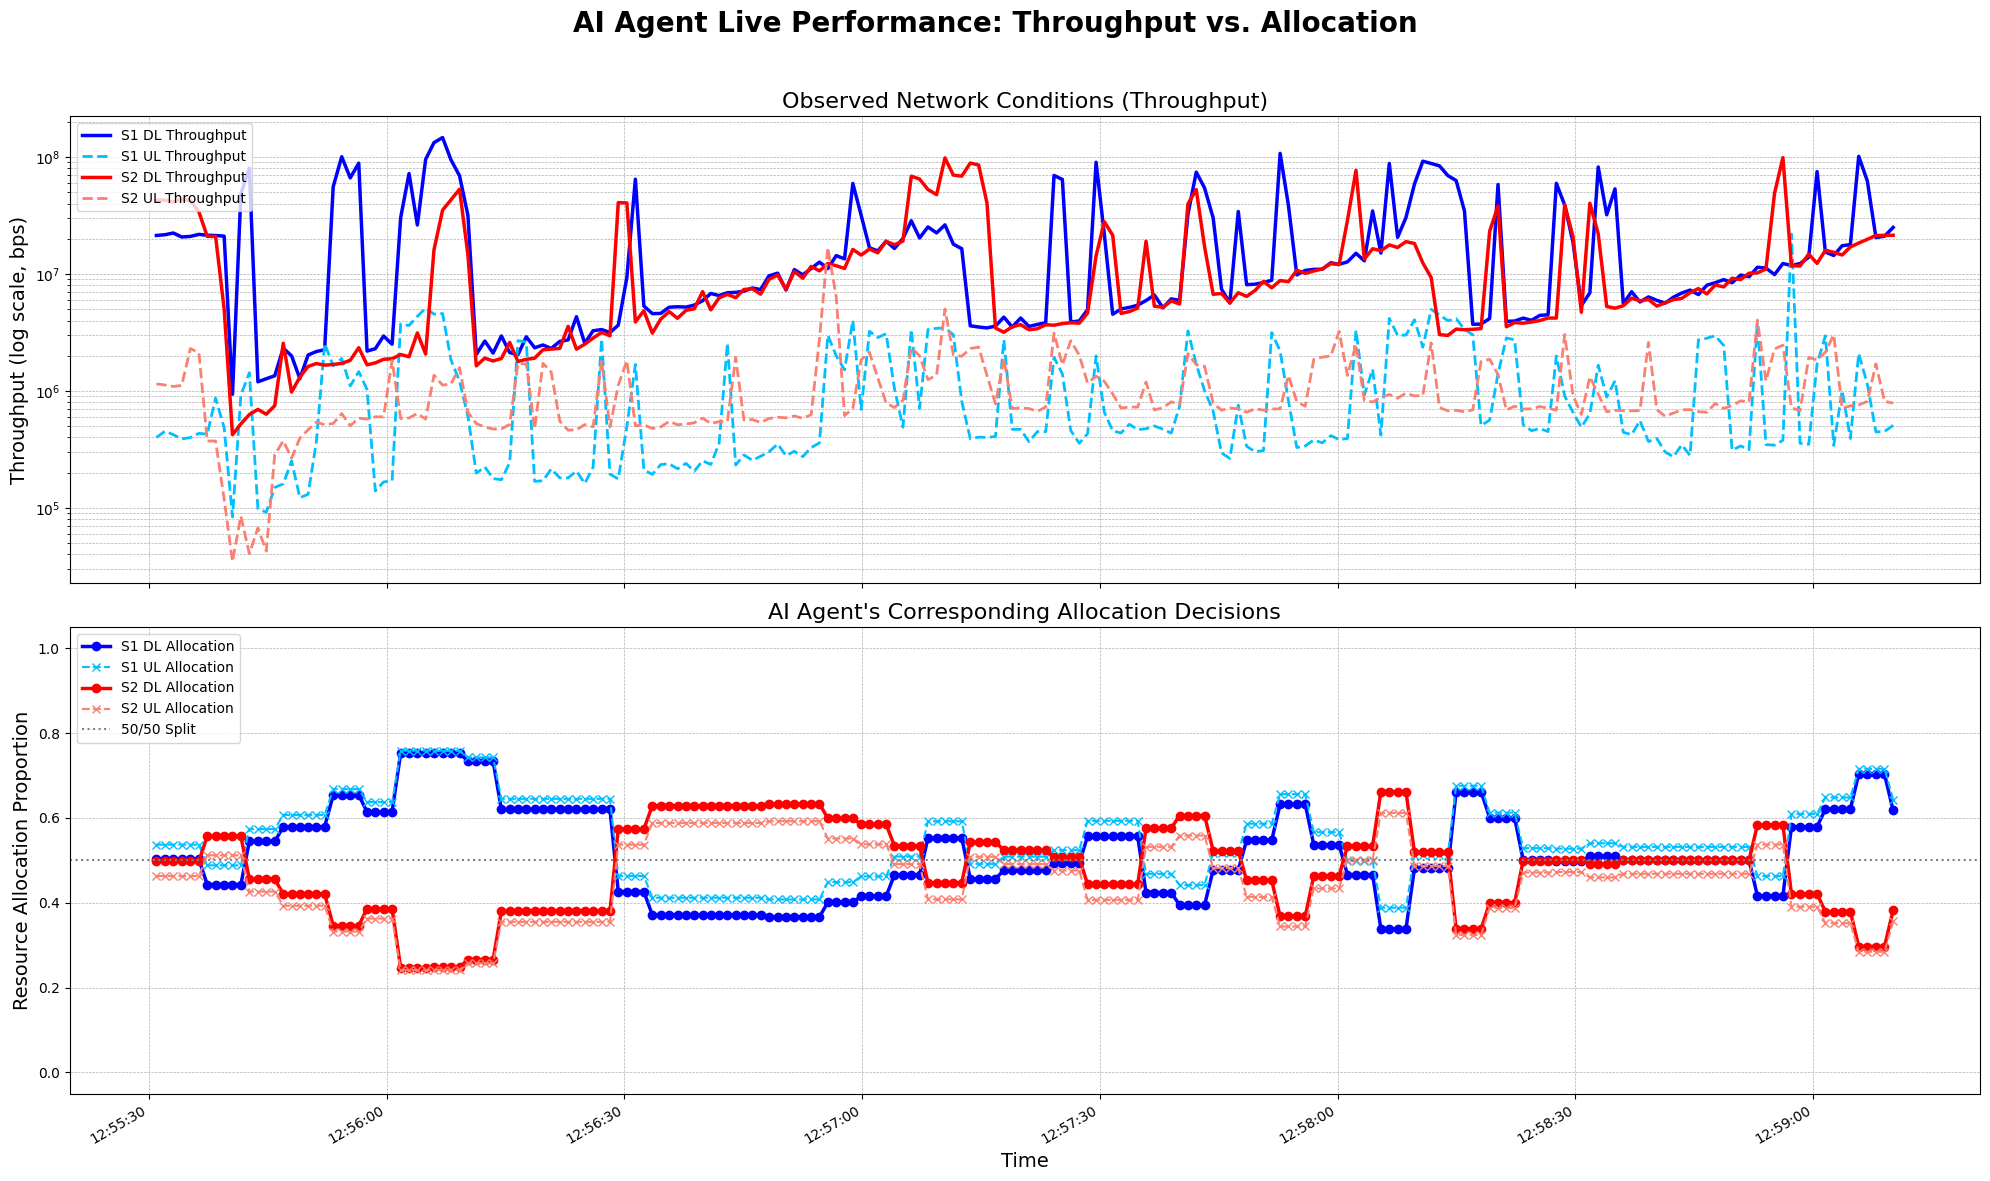

In [ ]:
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import os

# --- 1. Raw Log Data ---
# PASTE YOUR NEW, FULL LOG DATA HERE
LOG_DATA = """
2025-10-14 12:55:30.956: Got KPIs from Qosium: [{"time": 1760435730397, "downlink": {"throughput": 21360864.0, "latency": 9.669, "jitter": 0.185, "packetLoss": 0.0}, "uplink": {"throughput": 399304.0, "latency": 11.034, "jitter": 1.299, "packetLoss": 0.0}}, {"time": 1760435730678, "downlink": {"throughput": 42733248.0, "latency": 8.468124, "jitter": 0.12, "packetLoss": 0.0}, "uplink": {"throughput": 1148488.0, "latency": 9.594875, "jitter": 1.919, "packetLoss": 0.0}}]
2025-10-14 12:55:30.995: Set DL slice allocation; Time=1760435730995, Slice1=0.502, Slice2=0.498
2025-10-14 12:55:30.995: Set UL slice allocation; Time=1760435730995, Slice1=0.537, Slice2=0.463
2025-10-14 12:55:32.035: Got KPIs from Qosium: [{"time": 1760435731397, "downlink": {"throughput": 21675600.0, "latency": 9.223072, "jitter": 0.175, "packetLoss": 0.0}, "uplink": {"throughput": 452168.0, "latency": 10.185928, "jitter": 1.496, "packetLoss": 0.0}}, {"time": 1760435731676, "downlink": {"throughput": 42932920.0, "latency": 8.638843, "jitter": 0.131, "packetLoss": 0.0}, "uplink": {"throughput": 1123448.0, "latency": 10.547157, "jitter": 1.757, "packetLoss": 0.0}}]
2025-10-14 12:55:32.050: Set DL slice allocation; Time=1760435732050, Slice1=0.502, Slice2=0.498
2025-10-14 12:55:32.050: Set UL slice allocation; Time=1760435732050, Slice1=0.537, Slice2=0.463
2025-10-14 12:55:33.090: Got KPIs from Qosium: [{"time": 1760435732398, "downlink": {"throughput": 22422944.0, "latency": 9.232812, "jitter": 0.172, "packetLoss": 0.0}, "uplink": {"throughput": 422032.0, "latency": 9.697187, "jitter": 1.226, "packetLoss": 0.0}}, {"time": 1760435732678, "downlink": {"throughput": 41168720.0, "latency": 8.149, "jitter": 0.136, "packetLoss": 0.0}, "uplink": {"throughput": 1091536.0, "latency": 9.299, "jitter": 1.565, "packetLoss": 0.0}}]
2025-10-14 12:55:33.106: Set DL slice allocation; Time=1760435733106, Slice1=0.502, Slice2=0.498
2025-10-14 12:55:33.107: Set UL slice allocation; Time=1760435733106, Slice1=0.537, Slice2=0.463
2025-10-14 12:55:34.147: Got KPIs from Qosium: [{"time": 1760435733398, "downlink": {"throughput": 20722920.0, "latency": 9.362, "jitter": 0.187, "packetLoss": 0.0}, "uplink": {"throughput": 388472.0, "latency": 8.818, "jitter": 0.576, "packetLoss": 0.0}}, {"time": 1760435733675, "downlink": {"throughput": 43419352.0, "latency": 8.518, "jitter": 0.123, "packetLoss": 0.0}, "uplink": {"throughput": 1112464.0, "latency": 10.256, "jitter": 2.055, "packetLoss": 0.0}}]
2025-10-14 12:55:34.163: Set DL slice allocation; Time=1760435734163, Slice1=0.502, Slice2=0.498
2025-10-14 12:55:34.163: Set UL slice allocation; Time=1760435734163, Slice1=0.537, Slice2=0.463
2025-10-14 12:55:35.234: Got KPIs from Qosium: [{"time": 1760435734398, "downlink": {"throughput": 20966760.0, "latency": 9.396616, "jitter": 0.189, "packetLoss": 0.0}, "uplink": {"throughput": 398360.0, "latency": 8.636384, "jitter": 1.356, "packetLoss": 0.0}}, {"time": 1760435734675, "downlink": {"throughput": 42601688.0, "latency": 8.5861225, "jitter": 0.128, "packetLoss": 0.0}, "uplink": {"throughput": 2302960.0, "latency": 11.359878, "jitter": 1.663, "packetLoss": 0.0}}]
2025-10-14 12:55:35.250: Set DL slice allocation; Time=1760435735250, Slice1=0.502, Slice2=0.498
2025-10-14 12:55:35.250: Set UL slice allocation; Time=1760435735250, Slice1=0.537, Slice2=0.463
2025-10-14 12:55:36.319: Got KPIs from Qosium: [{"time": 1760435735397, "downlink": {"throughput": 21819536.0, "latency": 8.801589012145996, "jitter": 0.17599999904632568, "packetLoss": 0.0}, "uplink": {"throughput": 433600.0, "latency": 10.27241039276123, "jitter": 1.2230000495910645, "packetLoss": 0.0}}, {"time": 1760435735677, "downlink": {"throughput": 33973592.0, "latency": 8.812999725341797, "jitter": 0.13199999928474426, "packetLoss": 0.0}, "uplink": {"throughput": 2115536.0, "latency": 9.904999732971191, "jitter": 1.621999979019165, "packetLoss": 0.0}}]
2025-10-14 12:55:36.333: Set DL slice allocation; Time=1760435736333, Slice1=0.502, Slice2=0.498
2025-10-14 12:55:36.333: Set UL slice allocation; Time=1760435736333, Slice1=0.537, Slice2=0.463
2025-10-14 12:55:37.371: Got KPIs from Qosium: [{"time": 1760435736397, "downlink": {"throughput": 21457600.0, "latency": 8.54800033569336, "jitter": 0.1459999978542328, "packetLoss": 0.0}, "uplink": {"throughput": 426560.0, "latency": 8.343000411987305, "jitter": 1.1369999647140503, "packetLoss": 0.0}}, {"time": 1760435736676, "downlink": {"throughput": 20957496.0, "latency": 7.394000053405762, "jitter": 0.0989999994635582, "packetLoss": 0.0}, "uplink": {"throughput": 373000.0, "latency": 9.192000389099121, "jitter": 0.9089999794960022, "packetLoss": 0.0}}]
2025-10-14 12:55:37.386: Set DL slice allocation; Time=1760435737386, Slice1=0.443, Slice2=0.557
2025-10-14 12:55:37.386: Set UL slice allocation; Time=1760435737386, Slice1=0.4882, Slice2=0.5118
2025-10-14 12:55:38.424: Got KPIs from Qosium: [{"time": 1760435737395, "downlink": {"throughput": 21340024.0, "latency": 8.699134826660156, "jitter": 0.17800000309944153, "packetLoss": 0.0}, "uplink": {"throughput": 867440.0, "latency": 10.061864852905273, "jitter": 1.6950000524520874, "packetLoss": 0.0}}, {"time": 1760435737673, "downlink": {"throughput": 20960832.0, "latency": 7.609000205993652, "jitter": 0.14000000059604645, "packetLoss": 0.0}, "uplink": {"throughput": 372560.0, "latency": 8.838000297546387, "jitter": 0.5509999990463257, "packetLoss": 0.0}}]
2025-10-14 12:55:38.435: Set DL slice allocation; Time=1760435738435, Slice1=0.443, Slice2=0.557
2025-10-14 12:55:38.435: Set UL slice allocation; Time=1760435738435, Slice1=0.4882, Slice2=0.5118
2025-10-14 12:55:39.503: Got KPIs from Qosium: [{"time": 1760435738399, "downlink": {"throughput": 21074288.0, "latency": 9.414802551269531, "jitter": 0.20900000631809235, "packetLoss": 0.0}, "uplink": {"throughput": 484160.0, "latency": 9.633196830749512, "jitter": 1.6119999885559082, "packetLoss": 0.0}}, {"time": 1760435738670, "downlink": {"throughput": 5021264.0, "latency": 8.473999977111816, "jitter": 0.3140000104904175, "packetLoss": 0.0}, "uplink": {"throughput": 118624.0, "latency": 9.079999923706055, "jitter": 0.6650000214576721, "packetLoss": 0.0}}]
2025-10-14 12:55:39.518: Set DL slice allocation; Time=1760435739518, Slice1=0.443, Slice2=0.557
2025-10-14 12:55:39.518: Set UL slice allocation; Time=1760435739518, Slice1=0.4882, Slice2=0.5118
2025-10-14 12:55:40.556: Got KPIs from Qosium: [{"time": 1760435740396, "downlink": {"throughput": 936440.0, "latency": 7.433000087738037, "jitter": 1.156000018119812, "packetLoss": 0.0}, "uplink": {"throughput": 83584.0, "latency": 8.852999687194824, "jitter": 3.00600004196167, "packetLoss": 0.0}}, {"time": 1760435739669, "downlink": {"throughput": 421840.0, "latency": 6.564000129699707, "jitter": 1.2730000019073486, "packetLoss": 0.0}, "uplink": {"throughput": 34616.0, "latency": 9.82800006866455, "jitter": 2.0190000534057617, "packetLoss": 0.0}}]
2025-10-14 12:55:40.579: Set DL slice allocation; Time=1760435740579, Slice1=0.443, Slice2=0.557
2025-10-14 12:55:40.579: Set UL slice allocation; Time=1760435740579, Slice1=0.4882, Slice2=0.5118
2025-10-14 12:55:41.612: Got KPIs from Qosium: [{"time": 1760435741392, "downlink": {"throughput": 48550504.0, "latency": 10.280983924865723, "jitter": 0.12399999797344208, "packetLoss": 0.0}, "uplink": {"throughput": 919208.0, "latency": 10.016016006469727, "jitter": 4.6519999504089355, "packetLoss": 0.0}}, {"time": 1760435740665, "downlink": {"throughput": 521768.0, "latency": 5.991000175476074, "jitter": 0.7910000085830688, "packetLoss": 0.0}, "uplink": {"throughput": 85072.0, "latency": 9.335000038146973, "jitter": 1.24399995803833, "packetLoss": 0.0}}]
2025-10-14 12:55:41.623: Set DL slice allocation; Time=1760435741623, Slice1=0.443, Slice2=0.557
2025-10-14 12:55:41.623: Set UL slice allocation; Time=1760435741623, Slice1=0.4882, Slice2=0.5118
2025-10-14 12:55:42.683: Got KPIs from Qosium: [{"time": 1760435742393, "downlink": {"throughput": 80350536.0, "latency": 9.290672302246094, "jitter": 0.09000000357627869, "packetLoss": 0.0}, "uplink": {"throughput": 1432368.0, "latency": 11.371328353881836, "jitter": 1.4220000505447388, "packetLoss": 0.0}}, {"time": 1760435741664, "downlink": {"throughput": 627768.0, "latency": 6.625, "jitter": 1.059999942779541, "packetLoss": 0.0}, "uplink": {"throughput": 40440.0, "latency": 8.336000442504883, "jitter": 1.8990000486373901, "packetLoss": 0.0}}]
2025-10-14 12:55:42.701: Set DL slice allocation; Time=1760435742701, Slice1=0.5445, Slice2=0.4555
2025-10-14 12:55:42.701: Set UL slice allocation; Time=1760435742701, Slice1=0.5738, Slice2=0.4262
2025-10-14 12:55:43.762: Got KPIs from Qosium: [{"time": 1760435743408, "downlink": {"throughput": 1195912.0, "latency": 7.823516845703125, "jitter": 0.8859999775886536, "packetLoss": 0.0}, "uplink": {"throughput": 98408.0, "latency": 9.25648307800293, "jitter": 0.9169999957084656, "packetLoss": 0.0}}, {"time": 1760435743664, "downlink": {"throughput": 694672.0, "latency": 6.39300012588501, "jitter": 0.8399999737739563, "packetLoss": 0.0}, "uplink": {"throughput": 67168.0, "latency": 8.699999809265137, "jitter": 2.319000005722046, "packetLoss": 0.0}}]
2025-10-14 12:55:43.778: Set DL slice allocation; Time=1760435743778, Slice1=0.5445, Slice2=0.4555
2025-10-14 12:55:43.778: Set UL slice allocation; Time=1760435743778, Slice1=0.5738, Slice2=0.4262
2025-10-14 12:55:44.813: Got KPIs from Qosium: [{"time": 1760435744404, "downlink": {"throughput": 1270408.0, "latency": 7.22444486618042, "jitter": 0.9100000262260437, "packetLoss": 0.0}, "uplink": {"throughput": 91488.0, "latency": 8.934555053710938, "jitter": 1.4579999446868896, "packetLoss": 0.0}}, {"time": 1760435744665, "downlink": {"throughput": 631896.0, "latency": 6.302999973297119, "jitter": 0.9589999914169312, "packetLoss": 0.0}, "uplink": {"throughput": 42680.0, "latency": 9.585000038146973, "jitter": 2.0329999923706055, "packetLoss": 0.0}}]
2025-10-14 12:55:44.826: Set DL slice allocation; Time=1760435744826, Slice1=0.5445, Slice2=0.4555
2025-10-14 12:55:44.826: Set UL slice allocation; Time=1760435744826, Slice1=0.5738, Slice2=0.4262
2025-10-14 12:55:45.887: Got KPIs from Qosium: [{"time": 1760435745393, "downlink": {"throughput": 1347168.0, "latency": 6.802000045776367, "jitter": 0.7919999957084656, "packetLoss": 0.0}, "uplink": {"throughput": 149368.0, "latency": 8.605999946594238, "jitter": 2.7920000553131104, "packetLoss": 0.0}}, {"time": 1760435745665, "downlink": {"throughput": 747368.0, "latency": 6.914000034332275, "jitter": 1.2879999876022339, "packetLoss": 0.0}, "uplink": {"throughput": 283624.0, "latency": 8.704000473022461, "jitter": 2.4059998989105225, "packetLoss": 0.0}}]
2025-10-14 12:55:45.902: Set DL slice allocation; Time=1760435745902, Slice1=0.5445, Slice2=0.4555
2025-10-14 12:55:45.902: Set UL slice allocation; Time=1760435745902, Slice1=0.5738, Slice2=0.4262
2025-10-14 12:55:46.963: Got KPIs from Qosium: [{"time": 1760435746393, "downlink": {"throughput": 2321264.0, "latency": 7.80865478515625, "jitter": 0.5979999899864197, "packetLoss": 0.0}, "uplink": {"throughput": 160192.0, "latency": 10.13134479522705, "jitter": 1.694000005722046, "packetLoss": 0.0}}, {"time": 1760435746665, "downlink": {"throughput": 2555016.0, "latency": 8.944000244140625, "jitter": 0.8690000176429749, "packetLoss": 0.0}, "uplink": {"throughput": 374048.0, "latency": 10.220000267028809, "jitter": 1.7860000133514404, "packetLoss": 0.0}}]
2025-10-14 12:55:46.978: Set DL slice allocation; Time=1760435746978, Slice1=0.5792, Slice2=0.4208
2025-10-14 12:55:46.978: Set UL slice allocation; Time=1760435746978, Slice1=0.6071, Slice2=0.3929
2025-10-14 12:55:48.012: Got KPIs from Qosium: [{"time": 1760435747393, "downlink": {"throughput": 1993760.0, "latency": 8.685407638549805, "jitter": 1.003000020980835, "packetLoss": 0.0}, "uplink": {"throughput": 251880.0, "latency": 9.591591835021973, "jitter": 3.000999927520752, "packetLoss": 0.0}}, {"time": 1760435747665, "downlink": {"throughput": 977704.0, "latency": 7.790999889373779, "jitter": 1.3969999551773071, "packetLoss": 0.0}, "uplink": {"throughput": 266016.0, "latency": 10.0, "jitter": 3.0169999599456787, "packetLoss": 0.0}}]
2025-10-14 12:55:48.026: Set DL slice allocation; Time=1760435748026, Slice1=0.5792, Slice2=0.4208
2025-10-14 12:55:48.026: Set UL slice allocation; Time=1760435748026, Slice1=0.6071, Slice2=0.3929
2025-10-14 12:55:49.054: Got KPIs from Qosium: [{"time": 1760435748394, "downlink": {"throughput": 1274304.0, "latency": 7.684000015258789, "jitter": 1.156999945640564, "packetLoss": 0.0}, "uplink": {"throughput": 122032.0, "latency": 9.437999725341797, "jitter": 2.743000030517578, "packetLoss": 0.0}}, {"time": 1760435748666, "downlink": {"throughput": 1310624.0, "latency": 7.892000198364258, "jitter": 1.4730000495910645, "packetLoss": 0.0}, "uplink": {"throughput": 394528.0, "latency": 9.041000366210938, "jitter": 2.5239999294281006, "packetLoss": 0.0}}]
2025-10-14 12:55:49.065: Set DL slice allocation; Time=1760435749065, Slice1=0.5792, Slice2=0.4208
2025-10-14 12:55:49.065: Set UL slice allocation; Time=1760435749065, Slice1=0.6071, Slice2=0.3929
2025-10-14 12:55:50.097: Got KPIs from Qosium: [{"time": 1760435749394, "downlink": {"throughput": 2027392.0, "latency": 7.714000225067139, "jitter": 0.8510000109672546, "packetLoss": 0.0}, "uplink": {"throughput": 130544.0, "latency": 8.756999969482422, "jitter": 1.7209999561309814, "packetLoss": 0.0}}, {"time": 1760435749665, "downlink": {"throughput": 1619968.0, "latency": 7.4730000495910645, "jitter": 1.218000054359436, "packetLoss": 0.0}, "uplink": {"throughput": 465016.0, "latency": 9.982000350952148, "jitter": 2.115999937057495, "packetLoss": 0.0}}]
2025-10-14 12:55:50.107: Set DL slice allocation; Time=1760435750107, Slice1=0.5792, Slice2=0.4208
2025-10-14 12:55:50.107: Set UL slice allocation; Time=1760435750107, Slice1=0.6071, Slice2=0.3929
2025-10-14 12:55:51.139: Got KPIs from Qosium: [{"time": 1760435750393, "downlink": {"throughput": 2171576.0, "latency": 8.305999755859375, "jitter": 1.0540000200271606, "packetLoss": 0.0}, "uplink": {"throughput": 366536.0, "latency": 9.906999588012695, "jitter": 2.6640000343322754, "packetLoss": 0.0}}, {"time": 1760435750665, "downlink": {"throughput": 1713168.0, "latency": 7.835999965667725, "jitter": 1.3049999475479126, "packetLoss": 0.0}, "uplink": {"throughput": 541824.0, "latency": 9.812000274658203, "jitter": 2.510999917984009, "packetLoss": 0.0}}]
2025-10-14 12:55:51.148: Set DL slice allocation; Time=1760435751148, Slice1=0.5792, Slice2=0.4208
2025-10-14 12:55:51.148: Set UL slice allocation; Time=1760435751148, Slice1=0.6071, Slice2=0.3929
2025-10-14 12:55:52.182: Got KPIs from Qosium: [{"time": 1760435751394, "downlink": {"throughput": 2250536.0, "latency": 8.264166831970215, "jitter": 0.9020000100135803, "packetLoss": 0.0}, "uplink": {"throughput": 2544440.0, "latency": 9.739832878112793, "jitter": 1.5, "packetLoss": 0.0}}, {"time": 1760435751666, "downlink": {"throughput": 1660216.0, "latency": 7.3470001220703125, "jitter": 0.9890000224113464, "packetLoss": 0.0}, "uplink": {"throughput": 512904.0, "latency": 9.565999984741211, "jitter": 2.5739998817443848, "packetLoss": 0.0}}]
2025-10-14 12:55:52.200: Set DL slice allocation; Time=1760435752200, Slice1=0.5792, Slice2=0.4208
2025-10-14 12:55:52.200: Set UL slice allocation; Time=1760435752200, Slice1=0.6071, Slice2=0.3929
2025-10-14 12:55:53.262: Got KPIs from Qosium: [{"time": 1760435752393, "downlink": {"throughput": 55742744.0, "latency": 9.83171272277832, "jitter": 0.12200000137090683, "packetLoss": 0.0}, "uplink": {"throughput": 1635360.0, "latency": 10.504287719726562, "jitter": 2.953000068664551, "packetLoss": 0.0}}, {"time": 1760435752666, "downlink": {"throughput": 1683264.0, "latency": 7.9580535888671875, "jitter": 1.2519999742507935, "packetLoss": 0.0}, "uplink": {"throughput": 526624.0, "latency": 10.256946563720703, "jitter": 2.6459999084472656, "packetLoss": 0.0}}]
2025-10-14 12:55:53.280: Set DL slice allocation; Time=1760435753280, Slice1=0.654, Slice2=0.346
2025-10-14 12:55:53.280: Set UL slice allocation; Time=1760435753280, Slice1=0.6679, Slice2=0.3321
2025-10-14 12:55:54.337: Got KPIs from Qosium: [{"time": 1760435753396, "downlink": {"throughput": 100681496.0, "latency": 8.983158111572266, "jitter": 0.09799999743700027, "packetLoss": 0.0}, "uplink": {"throughput": 1892696.0, "latency": 10.467842102050781, "jitter": 1.2230000495910645, "packetLoss": 0.0}}, {"time": 1760435753665, "downlink": {"throughput": 1717952.0, "latency": 7.586999893188477, "jitter": 1.090000033378601, "packetLoss": 0.0}, "uplink": {"throughput": 639448.0, "latency": 9.4350004196167, "jitter": 2.2190001010894775, "packetLoss": 0.0}}]
2025-10-14 12:55:54.352: Set DL slice allocation; Time=1760435754352, Slice1=0.654, Slice2=0.346
2025-10-14 12:55:54.352: Set UL slice allocation; Time=1760435754352, Slice1=0.6679, Slice2=0.3321
2025-10-14 12:55:55.413: Got KPIs from Qosium: [{"time": 1760435754401, "downlink": {"throughput": 66365216.0, "latency": 8.880127906799316, "jitter": 0.11999999731779099, "packetLoss": 0.0}, "uplink": {"throughput": 1102096.0, "latency": 10.431872367858887, "jitter": 1.7690000534057617, "packetLoss": 0.0}}, {"time": 1760435754665, "downlink": {"throughput": 1826440.0, "latency": 7.171000003814697, "jitter": 0.953000009059906, "packetLoss": 0.0}, "uplink": {"throughput": 502592.0, "latency": 9.633000373840332, "jitter": 2.681999921798706, "packetLoss": 0.0}}]
2025-10-14 12:55:55.426: Set DL slice allocation; Time=1760435755426, Slice1=0.654, Slice2=0.346
2025-10-14 12:55:55.427: Set UL slice allocation; Time=1760435755426, Slice1=0.6679, Slice2=0.3321
2025-10-14 12:55:56.487: Got KPIs from Qosium: [{"time": 1760435755419, "downlink": {"throughput": 88715176.0, "latency": 9.156875610351562, "jitter": 0.09399999678134918, "packetLoss": 0.0}, "uplink": {"throughput": 1462784.0, "latency": 9.923124313354492, "jitter": 1.3619999885559082, "packetLoss": 0.0}}, {"time": 1760435755665, "downlink": {"throughput": 2341112.0, "latency": 8.777000427246094, "jitter": 0.9750000238418579, "packetLoss": 0.0}, "uplink": {"throughput": 584544.0, "latency": 10.14900016784668, "jitter": 2.2669999599456787, "packetLoss": 0.0}}]
2025-10-14 12:55:56.501: Set DL slice allocation; Time=1760435756501, Slice1=0.654, Slice2=0.346
2025-10-14 12:55:56.501: Set UL slice allocation; Time=1760435756501, Slice1=0.6679, Slice2=0.3321
2025-10-14 12:55:57.533: Got KPIs from Qosium: [{"time": 1760435757408, "downlink": {"throughput": 2190160.0, "latency": 8.138999938964844, "jitter": 1.031000018119812, "packetLoss": 0.0}, "uplink": {"throughput": 1027416.0, "latency": 9.064000129699707, "jitter": 1.625, "packetLoss": 0.0}}, {"time": 1760435756666, "downlink": {"throughput": 1671648.0, "latency": 7.823835849761963, "jitter": 1.2419999837875366, "packetLoss": 0.0}, "uplink": {"throughput": 575096.0, "latency": 10.64216423034668, "jitter": 2.6419999599456787, "packetLoss": 0.0}}]
2025-10-14 12:55:57.545: Set DL slice allocation; Time=1760435757545, Slice1=0.6141, Slice2=0.3859
2025-10-14 12:55:57.545: Set UL slice allocation; Time=1760435757545, Slice1=0.6374, Slice2=0.3626
2025-10-14 12:55:58.578: Got KPIs from Qosium: [{"time": 1760435758393, "downlink": {"throughput": 2296400.0, "latency": 7.73199987411499, "jitter": 0.8840000033378601, "packetLoss": 0.0}, "uplink": {"throughput": 139264.0, "latency": 8.42300033569336, "jitter": 2.0, "packetLoss": 0.0}}, {"time": 1760435757666, "downlink": {"throughput": 1736152.0, "latency": 7.89931058883667, "jitter": 1.2350000143051147, "packetLoss": 0.0}, "uplink": {"throughput": 600216.0, "latency": 9.941689491271973, "jitter": 2.752000093460083, "packetLoss": 0.0}}]
2025-10-14 12:55:58.588: Set DL slice allocation; Time=1760435758588, Slice1=0.6141, Slice2=0.3859
2025-10-14 12:55:58.588: Set UL slice allocation; Time=1760435758588, Slice1=0.6374, Slice2=0.3626
2025-10-14 12:55:59.622: Got KPIs from Qosium: [{"time": 1760435759394, "downlink": {"throughput": 2948016.0, "latency": 7.699999809265137, "jitter": 0.9380000233650208, "packetLoss": 0.0}, "uplink": {"throughput": 166392.0, "latency": 9.61400032043457, "jitter": 2.628000020980835, "packetLoss": 0.0}}, {"time": 1760435758665, "downlink": {"throughput": 1864296.0, "latency": 7.881587982177734, "jitter": 1.097000002861023, "packetLoss": 0.0}, "uplink": {"throughput": 599568.0, "latency": 10.201412200927734, "jitter": 2.0360000133514404, "packetLoss": 0.0}}]
2025-10-14 12:55:59.632: Set DL slice allocation; Time=1760435759632, Slice1=0.6141, Slice2=0.3859
2025-10-14 12:55:59.632: Set UL slice allocation; Time=1760435759632, Slice1=0.6374, Slice2=0.3626
2025-10-14 12:56:00.693: Got KPIs from Qosium: [{"time": 1760435760394, "downlink": {"throughput": 2507416.0, "latency": 7.675000190734863, "jitter": 0.7839999794960022, "packetLoss": 0.0}, "uplink": {"throughput": 170360.0, "latency": 9.90999984741211, "jitter": 2.640000104904175, "packetLoss": 0.0}}, {"time": 1760435759666, "downlink": {"throughput": 1883392.0, "latency": 7.639517784118652, "jitter": 0.9190000295639038, "packetLoss": 0.0}, "uplink": {"throughput": 1825816.0, "latency": 9.462482452392578, "jitter": 1.5839999914169312, "packetLoss": 0.0}}]
2025-10-14 12:56:00.715: Set DL slice allocation; Time=1760435760715, Slice1=0.6141, Slice2=0.3859
2025-10-14 12:56:00.715: Set UL slice allocation; Time=1760435760715, Slice1=0.6374, Slice2=0.3626
2025-10-14 12:56:01.773: Got KPIs from Qosium: [{"time": 1760435761394, "downlink": {"throughput": 30267896.0, "latency": 9.840383529663086, "jitter": 0.1860000044107437, "packetLoss": 0.0}, "uplink": {"throughput": 3739200.0, "latency": 9.819616317749023, "jitter": 1.5369999408721924, "packetLoss": 0.0}}, {"time": 1760435761666, "downlink": {"throughput": 2046712.0, "latency": 7.005000114440918, "jitter": 0.781000018119812, "packetLoss": 0.0}, "uplink": {"throughput": 580904.0, "latency": 8.6899995803833, "jitter": 1.9730000495910645, "packetLoss": 0.0}}]
2025-10-14 12:56:01.798: Set DL slice allocation; Time=1760435761798, Slice1=0.7528, Slice2=0.2472
2025-10-14 12:56:01.798: Set UL slice allocation; Time=1760435761798, Slice1=0.7587, Slice2=0.2413
2025-10-14 12:56:02.831: Got KPIs from Qosium: [{"time": 1760435762394, "downlink": {"throughput": 72306768.0, "latency": 9.234000205993652, "jitter": 0.09399999678134918, "packetLoss": 0.0}, "uplink": {"throughput": 3624576.0, "latency": 9.755999565124512, "jitter": 0.6610000133514404, "packetLoss": 0.0}}, {"time": 1760435762665, "downlink": {"throughput": 1960336.0, "latency": 6.945677280426025, "jitter": 0.800000011920929, "packetLoss": 0.0}, "uplink": {"throughput": 586760.0, "latency": 10.224322319030762, "jitter": 2.118000030517578, "packetLoss": 0.0}}]
2025-10-14 12:56:02.849: Set DL slice allocation; Time=1760435762849, Slice1=0.7528, Slice2=0.2472
2025-10-14 12:56:02.849: Set UL slice allocation; Time=1760435762849, Slice1=0.7587, Slice2=0.2413
2025-10-14 12:56:03.882: Got KPIs from Qosium: [{"time": 1760435763402, "downlink": {"throughput": 26245704.0, "latency": 10.729000091552734, "jitter": 0.20499999821186066, "packetLoss": 0.0}, "uplink": {"throughput": 4339312.0, "latency": 10.064000129699707, "jitter": 1.0379999876022339, "packetLoss": 0.0}}, {"time": 1760435763665, "downlink": {"throughput": 3132552.0, "latency": 9.67300033569336, "jitter": 0.753000020980835, "packetLoss": 0.0}, "uplink": {"throughput": 640944.0, "latency": 10.071000099182129, "jitter": 1.9989999532699585, "packetLoss": 0.0}}]
2025-10-14 12:56:03.892: Set DL slice allocation; Time=1760435763892, Slice1=0.7528, Slice2=0.2472
2025-10-14 12:56:03.892: Set UL slice allocation; Time=1760435763892, Slice1=0.7587, Slice2=0.2413
2025-10-14 12:56:04.925: Got KPIs from Qosium: [{"time": 1760435764409, "downlink": {"throughput": 95554976.0, "latency": 10.279999732971191, "jitter": 0.09000000357627869, "packetLoss": 0.0}, "uplink": {"throughput": 5106560.0, "latency": 9.72599983215332, "jitter": 1.534000039100647, "packetLoss": 0.0}}, {"time": 1760435764665, "downlink": {"throughput": 2066072.0, "latency": 7.7428364753723145, "jitter": 1.0080000162124634, "packetLoss": 0.0}, "uplink": {"throughput": 573472.0, "latency": 9.12916374206543, "jitter": 1.6150000095367432, "packetLoss": 0.0}}]
2025-10-14 12:56:04.945: Set DL slice allocation; Time=1760435764945, Slice1=0.7528, Slice2=0.2472
2025-10-14 12:56:04.945: Set UL slice allocation; Time=1760435764945, Slice1=0.7587, Slice2=0.2413
2025-10-14 12:56:05.978: Got KPIs from Qosium: [{"time": 1760435765402, "downlink": {"throughput": 132935856.0, "latency": 9.33899974822998, "jitter": 0.08100000023841858, "packetLoss": 0.0}, "uplink": {"throughput": 4533624.0, "latency": 10.706000328063965, "jitter": 1.0290000438690186, "packetLoss": 0.0}}, {"time": 1760435765666, "downlink": {"throughput": 16077874.0, "latency": 9.998000144958496, "jitter": 0.28600001335144043, "packetLoss": 0.0}, "uplink": {"throughput": 1360351.625, "latency": 10.595999717712402, "jitter": 2.5309998989105225, "packetLoss": 0.0}}]
2025-10-14 12:56:06.000: Set DL slice allocation; Time=1760435766000, Slice1=0.7524, Slice2=0.2476
2025-10-14 12:56:06.000: Set UL slice allocation; Time=1760435766000, Slice1=0.7581, Slice2=0.2419
2025-10-14 12:56:07.062: Got KPIs from Qosium: [{"time": 1760435766421, "downlink": {"throughput": 146959968.0, "latency": 9.34000015258789, "jitter": 0.0729999989271164, "packetLoss": 0.0}, "uplink": {"throughput": 4590440.0, "latency": 11.75, "jitter": 1.6890000104904175, "packetLoss": 0.0}}, {"time": 1760435766666, "downlink": {"throughput": 35150160.0, "latency": 9.041999816894531, "jitter": 0.18700000643730164, "packetLoss": 0.0}, "uplink": {"throughput": 1120512.5, "latency": 10.362000465393066, "jitter": 2.6570000648498535, "packetLoss": 0.0}}]
2025-10-14 12:56:07.086: Set DL slice allocation; Time=1760435767086, Slice1=0.7524, Slice2=0.2476
2025-10-14 12:56:07.086: Set UL slice allocation; Time=1760435767086, Slice1=0.7581, Slice2=0.2419
2025-10-14 12:56:08.120: Got KPIs from Qosium: [{"time": 1760435767428, "downlink": {"throughput": 94785232.0, "latency": 9.418000221252441, "jitter": 0.09799999743700027, "packetLoss": 0.0}, "uplink": {"throughput": 1843512.0, "latency": 11.25, "jitter": 1.9140000343322754, "packetLoss": 0.0}}, {"time": 1760435767670, "downlink": {"throughput": 43091936.0, "latency": 8.791000366210938, "jitter": 0.15199999511241913, "packetLoss": 0.0}, "uplink": {"throughput": 1146520.0, "latency": 11.125, "jitter": 2.36899995803833, "packetLoss": 0.0}}]
2025-10-14 12:56:08.136: Set DL slice allocation; Time=1760435768136, Slice1=0.7524, Slice2=0.2476
2025-10-14 12:56:08.136: Set UL slice allocation; Time=1760435768136, Slice1=0.7581, Slice2=0.2419
2025-10-14 12:56:09.205: Got KPIs from Qosium: [{"time": 1760435768430, "downlink": {"throughput": 69178944.0, "latency": 9.038999557495117, "jitter": 0.1120000034570694, "packetLoss": 0.0}, "uplink": {"throughput": 1211032.0, "latency": 11.154999732971191, "jitter": 1.5839999914169312, "packetLoss": 0.0}}, {"time": 1760435768674, "downlink": {"throughput": 53059048.0, "latency": 8.574999809265137, "jitter": 0.14100000262260437, "packetLoss": 0.0}, "uplink": {"throughput": 1581032.0, "latency": 12.343000411987305, "jitter": 2.2130000591278076, "packetLoss": 0.0}}]
2025-10-14 12:56:09.227: Set DL slice allocation; Time=1760435769227, Slice1=0.7524, Slice2=0.2476
2025-10-14 12:56:09.227: Set UL slice allocation; Time=1760435769227, Slice1=0.7581, Slice2=0.2419
2025-10-14 12:56:10.261: Got KPIs from Qosium: [{"time": 1760435769419, "downlink": {"throughput": 31706240.0, "latency": 8.784000396728516, "jitter": 0.17800000309944153, "packetLoss": 0.0}, "uplink": {"throughput": 609688.0, "latency": 9.710000038146973, "jitter": 1.6330000162124634, "packetLoss": 0.0}}, {"time": 1760435769675, "downlink": {"throughput": 14587344.0, "latency": 9.559000015258789, "jitter": 0.3089999854564667, "packetLoss": 0.0}, "uplink": {"throughput": 655776.0, "latency": 10.399999618530273, "jitter": 1.843000054359436, "packetLoss": 0.0}}]
2025-10-14 12:56:10.279: Set DL slice allocation; Time=1760435770279, Slice1=0.7339, Slice2=0.2661
2025-10-14 12:56:10.279: Set UL slice allocation; Time=1760435770279, Slice1=0.7426, Slice2=0.2574
2025-10-14 12:56:11.313: Got KPIs from Qosium: [{"time": 1760435770408, "downlink": {"throughput": 2048648.0, "latency": 8.255945205688477, "jitter": 0.925000011920929, "packetLoss": 0.0}, "uplink": {"throughput": 197568.0, "latency": 9.164054870605469, "jitter": 1.562999963760376, "packetLoss": 0.0}}, {"time": 1760435770676, "downlink": {"throughput": 1637816.0, "latency": 8.04699993133545, "jitter": 1.0230000019073486, "packetLoss": 0.0}, "uplink": {"throughput": 525840.0, "latency": 10.003999710083008, "jitter": 2.0369999408721924, "packetLoss": 0.0}}]
2025-10-14 12:56:11.332: Set DL slice allocation; Time=1760435771332, Slice1=0.7339, Slice2=0.2661
2025-10-14 12:56:11.332: Set UL slice allocation; Time=1760435771332, Slice1=0.7426, Slice2=0.2574
2025-10-14 12:56:12.393: Got KPIs from Qosium: [{"time": 1760435771398, "downlink": {"throughput": 2669184.0, "latency": 8.708999633789062, "jitter": 1.0490000247955322, "packetLoss": 0.0}, "uplink": {"throughput": 223744.0, "latency": 8.765999794006348, "jitter": 2.369999885559082, "packetLoss": 0.0}}, {"time": 1760435771667, "downlink": {"throughput": 1908608.0, "latency": 8.135000228881836, "jitter": 1.121000051498413, "packetLoss": 0.0}, "uplink": {"throughput": 490928.0, "latency": 10.326000213623047, "jitter": 2.4719998836517334, "packetLoss": 0.0}}]
2025-10-14 12:56:12.406: Set DL slice allocation; Time=1760435772406, Slice1=0.7339, Slice2=0.2661
2025-10-14 12:56:12.406: Set UL slice allocation; Time=1760435772406, Slice1=0.7426, Slice2=0.2574
2025-10-14 12:56:13.438: Got KPIs from Qosium: [{"time": 1760435772393, "downlink": {"throughput": 2105568.0, "latency": 7.867000102996826, "jitter": 1.0529999732971191, "packetLoss": 0.0}, "uplink": {"throughput": 177728.0, "latency": 8.741000175476074, "jitter": 2.38700008392334, "packetLoss": 0.0}}, {"time": 1760435772666, "downlink": {"throughput": 1802136.0, "latency": 7.942775249481201, "jitter": 1.11899995803833, "packetLoss": 0.0}, "uplink": {"throughput": 472192.0, "latency": 9.362224578857422, "jitter": 1.9179999828338623, "packetLoss": 0.0}}]
2025-10-14 12:56:13.450: Set DL slice allocation; Time=1760435773449, Slice1=0.7339, Slice2=0.2661
2025-10-14 12:56:13.450: Set UL slice allocation; Time=1760435773449, Slice1=0.7426, Slice2=0.2574
2025-10-14 12:56:14.483: Got KPIs from Qosium: [{"time": 1760435774394, "downlink": {"throughput": 2951064.0, "latency": 8.71399974822998, "jitter": 0.7910000085830688, "packetLoss": 0.0}, "uplink": {"throughput": 173840.0, "latency": 8.454000473022461, "jitter": 2.1410000324249268, "packetLoss": 0.0}}, {"time": 1760435773666, "downlink": {"throughput": 1894136.0, "latency": 7.921137809753418, "jitter": 1.0260000228881836, "packetLoss": 0.0}, "uplink": {"throughput": 472744.0, "latency": 10.175862312316895, "jitter": 2.4590001106262207, "packetLoss": 0.0}}]
2025-10-14 12:56:14.497: Set DL slice allocation; Time=1760435774497, Slice1=0.6199, Slice2=0.3801
2025-10-14 12:56:14.497: Set UL slice allocation; Time=1760435774497, Slice1=0.645, Slice2=0.355
2025-10-14 12:56:15.530: Got KPIs from Qosium: [{"time": 1760435775394, "downlink": {"throughput": 2127792.0, "latency": 8.265999794006348, "jitter": 1.0110000371932983, "packetLoss": 0.0}, "uplink": {"throughput": 243208.0, "latency": 8.123000144958496, "jitter": 1.8849999904632568, "packetLoss": 0.0}}, {"time": 1760435774666, "downlink": {"throughput": 2596744.0, "latency": 9.359000205993652, "jitter": 0.9079999923706055, "packetLoss": 0.0}, "uplink": {"throughput": 516744.0, "latency": 10.307000160217285, "jitter": 2.246999979019165, "packetLoss": 0.0}}]
2025-10-14 12:56:15.541: Set DL slice allocation; Time=1760435775541, Slice1=0.6199, Slice2=0.3801
2025-10-14 12:56:15.541: Set UL slice allocation; Time=1760435775541, Slice1=0.645, Slice2=0.355
2025-10-14 12:56:16.575: Got KPIs from Qosium: [{"time": 1760435776393, "downlink": {"throughput": 2040640.0, "latency": 8.210000038146973, "jitter": 0.9620000123977661, "packetLoss": 0.0}, "uplink": {"throughput": 2690880.0, "latency": 9.60099983215332, "jitter": 1.3600000143051147, "packetLoss": 0.0}}, {"time": 1760435775666, "downlink": {"throughput": 1783104.0, "latency": 8.122547149658203, "jitter": 1.0779999494552612, "packetLoss": 0.0}, "uplink": {"throughput": 1707648.0, "latency": 9.473453521728516, "jitter": 1.9459999799728394, "packetLoss": 0.0}}]
2025-10-14 12:56:16.595: Set DL slice allocation; Time=1760435776595, Slice1=0.6199, Slice2=0.3801
2025-10-14 12:56:16.595: Set UL slice allocation; Time=1760435776595, Slice1=0.645, Slice2=0.355
2025-10-14 12:56:17.628: Got KPIs from Qosium: [{"time": 1760435777394, "downlink": {"throughput": 2903248.0, "latency": 8.04699993133545, "jitter": 0.925000011920929, "packetLoss": 0.0}, "uplink": {"throughput": 2617288.0, "latency": 9.649999618530273, "jitter": 1.2979999780654907, "packetLoss": 0.0}}, {"time": 1760435776666, "downlink": {"throughput": 1862408.0, "latency": 7.951972961425781, "jitter": 0.9580000042915344, "packetLoss": 0.0}, "uplink": {"throughput": 1699144.0, "latency": 9.684027671813965, "jitter": 1.4800000190734863, "packetLoss": 0.0}}]
2025-10-14 12:56:17.646: Set DL slice allocation; Time=1760435777646, Slice1=0.6199, Slice2=0.3801
2025-10-14 12:56:17.646: Set UL slice allocation; Time=1760435777646, Slice1=0.645, Slice2=0.355
2025-10-14 12:56:18.678: Got KPIs from Qosium: [{"time": 1760435778394, "downlink": {"throughput": 2338544.0, "latency": 8.024999618530273, "jitter": 0.8009999990463257, "packetLoss": 0.0}, "uplink": {"throughput": 168472.0, "latency": 8.423999786376953, "jitter": 2.124000072479248, "packetLoss": 0.0}}, {"time": 1760435777666, "downlink": {"throughput": 1905728.0, "latency": 7.545000076293945, "jitter": 0.9010000228881836, "packetLoss": 0.0}, "uplink": {"throughput": 473944.0, "latency": 9.64799976348877, "jitter": 2.433000087738037, "packetLoss": 0.0}}]
2025-10-14 12:56:18.697: Set DL slice allocation; Time=1760435778697, Slice1=0.6199, Slice2=0.3801
2025-10-14 12:56:18.697: Set UL slice allocation; Time=1760435778697, Slice1=0.645, Slice2=0.355
2025-10-14 12:56:19.729: Got KPIs from Qosium: [{"time": 1760435779394, "downlink": {"throughput": 2470136.0, "latency": 8.281000137329102, "jitter": 0.8999999761581421, "packetLoss": 0.0}, "uplink": {"throughput": 170184.0, "latency": 8.75, "jitter": 1.8769999742507935, "packetLoss": 0.0}}, {"time": 1760435779665, "downlink": {"throughput": 2247336.0, "latency": 8.1067476272583, "jitter": 0.8999999761581421, "packetLoss": 0.0}, "uplink": {"throughput": 1724008.0, "latency": 10.730252265930176, "jitter": 1.937000036239624, "packetLoss": 0.0}}]
2025-10-14 12:56:19.741: Set DL slice allocation; Time=1760435779741, Slice1=0.6199, Slice2=0.3801
2025-10-14 12:56:19.741: Set UL slice allocation; Time=1760435779741, Slice1=0.645, Slice2=0.355
2025-10-14 12:56:20.775: Got KPIs from Qosium: [{"time": 1760435780394, "downlink": {"throughput": 2308952.0, "latency": 7.8470001220703125, "jitter": 0.7799999713897705, "packetLoss": 0.0}, "uplink": {"throughput": 215184.0, "latency": 8.720999717712402, "jitter": 1.5859999656677246, "packetLoss": 0.0}}, {"time": 1760435780666, "downlink": {"throughput": 2275704.0, "latency": 8.127593040466309, "jitter": 0.8759999871253967, "packetLoss": 0.0}, "uplink": {"throughput": 1444216.0, "latency": 10.485406875610352, "jitter": 2.125, "packetLoss": 0.0}}]
2025-10-14 12:56:20.790: Set DL slice allocation; Time=1760435780790, Slice1=0.6199, Slice2=0.3801
2025-10-14 12:56:20.791: Set UL slice allocation; Time=1760435780790, Slice1=0.645, Slice2=0.355
2025-10-14 12:56:21.852: Got KPIs from Qosium: [{"time": 1760435781393, "downlink": {"throughput": 2650000.0, "latency": 8.043000221252441, "jitter": 0.8140000104904175, "packetLoss": 0.0}, "uplink": {"throughput": 180240.0, "latency": 8.27400016784668, "jitter": 1.8370000123977661, "packetLoss": 0.0}}, {"time": 1760435781666, "downlink": {"throughput": 2309464.0, "latency": 8.428999900817871, "jitter": 0.9509999752044678, "packetLoss": 0.0}, "uplink": {"throughput": 551416.0, "latency": 9.4350004196167, "jitter": 1.909999966621399, "packetLoss": 0.0}}]
2025-10-14 12:56:21.870: Set DL slice allocation; Time=1760435781870, Slice1=0.6199, Slice2=0.3801
2025-10-14 12:56:21.870: Set UL slice allocation; Time=1760435781870, Slice1=0.645, Slice2=0.355
2025-10-14 12:56:22.904: Got KPIs from Qosium: [{"time": 1760435782393, "downlink": {"throughput": 2729464.0, "latency": 8.230999946594238, "jitter": 0.8629999756813049, "packetLoss": 0.0}, "uplink": {"throughput": 180184.0, "latency": 9.039999961853027, "jitter": 1.7680000066757202, "packetLoss": 0.0}}, {"time": 1760435782666, "downlink": {"throughput": 3565440.0, "latency": 10.51200008392334, "jitter": 0.8009999990463257, "packetLoss": 0.0}, "uplink": {"throughput": 461448.0, "latency": 10.071000099182129, "jitter": 1.9600000381469727, "packetLoss": 0.0}}]
2025-10-14 12:56:22.925: Set DL slice allocation; Time=1760435782925, Slice1=0.6199, Slice2=0.3801
2025-10-14 12:56:22.925: Set UL slice allocation; Time=1760435782925, Slice1=0.645, Slice2=0.355
2025-10-14 12:56:23.957: Got KPIs from Qosium: [{"time": 1760435783393, "downlink": {"throughput": 4313744.0, "latency": 9.722723960876465, "jitter": 0.7960000038146973, "packetLoss": 0.0}, "uplink": {"throughput": 206232.0, "latency": 8.655275344848633, "jitter": 1.850000023841858, "packetLoss": 0.0}}, {"time": 1760435783665, "downlink": {"throughput": 2274944.0, "latency": 7.53695011138916, "jitter": 0.8500000238418579, "packetLoss": 0.0}, "uplink": {"throughput": 464720.0, "latency": 9.630049705505371, "jitter": 1.9320000410079956, "packetLoss": 0.0}}]
2025-10-14 12:56:23.971: Set DL slice allocation; Time=1760435783971, Slice1=0.6199, Slice2=0.3801
2025-10-14 12:56:23.971: Set UL slice allocation; Time=1760435783971, Slice1=0.645, Slice2=0.355
2025-10-14 12:56:25.003: Got KPIs from Qosium: [{"time": 1760435784394, "downlink": {"throughput": 2551544.0, "latency": 7.770999908447266, "jitter": 0.902999997138977, "packetLoss": 0.0}, "uplink": {"throughput": 161344.0, "latency": 8.456000328063965, "jitter": 1.4800000190734863, "packetLoss": 0.0}}, {"time": 1760435784666, "downlink": {"throughput": 2510912.0, "latency": 7.918000221252441, "jitter": 0.8539999723434448, "packetLoss": 0.0}, "uplink": {"throughput": 514856.0, "latency": 10.187000274658203, "jitter": 2.312999963760376, "packetLoss": 0.0}}]
2025-10-14 12:56:25.020: Set DL slice allocation; Time=1760435785020, Slice1=0.6199, Slice2=0.3801
2025-10-14 12:56:25.020: Set UL slice allocation; Time=1760435785020, Slice1=0.645, Slice2=0.355
2025-10-14 12:56:26.054: Got KPIs from Qosium: [{"time": 1760435785394, "downlink": {"throughput": 3269344.0, "latency": 7.678999900817871, "jitter": 0.7129999995231628, "packetLoss": 0.0}, "uplink": {"throughput": 222616.0, "latency": 8.72700023651123, "jitter": 1.6920000314712524, "packetLoss": 0.0}}, {"time": 1760435785666, "downlink": {"throughput": 2828112.0, "latency": 8.092684745788574, "jitter": 0.843999981880188, "packetLoss": 0.0}, "uplink": {"throughput": 493336.0, "latency": 9.77231502532959, "jitter": 2.2839999198913574, "packetLoss": 0.0}}]
2025-10-14 12:56:26.072: Set DL slice allocation; Time=1760435786072, Slice1=0.6199, Slice2=0.3801
2025-10-14 12:56:26.072: Set UL slice allocation; Time=1760435786072, Slice1=0.645, Slice2=0.355
2025-10-14 12:56:27.132: Got KPIs from Qosium: [{"time": 1760435786394, "downlink": {"throughput": 3347016.0, "latency": 8.211999893188477, "jitter": 0.7020000219345093, "packetLoss": 0.0}, "uplink": {"throughput": 2781776.0, "latency": 9.380000114440918, "jitter": 1.559000015258789, "packetLoss": 0.0}}, {"time": 1760435786666, "downlink": {"throughput": 3166272.0, "latency": 7.917786121368408, "jitter": 0.7760000228881836, "packetLoss": 0.0}, "uplink": {"throughput": 1793824.0, "latency": 11.667213439941406, "jitter": 1.3639999628067017, "packetLoss": 0.0}}]
2025-10-14 12:56:27.153: Set DL slice allocation; Time=1760435787153, Slice1=0.6199, Slice2=0.3801
2025-10-14 12:56:27.154: Set UL slice allocation; Time=1760435787153, Slice1=0.645, Slice2=0.355
2025-10-14 12:56:28.186: Got KPIs from Qosium: [{"time": 1760435787394, "downlink": {"throughput": 3158592.0, "latency": 7.941999912261963, "jitter": 0.6629999876022339, "packetLoss": 0.0}, "uplink": {"throughput": 193944.0, "latency": 8.625, "jitter": 2.0769999027252197, "packetLoss": 0.0}}, {"time": 1760435787666, "downlink": {"throughput": 2960360.0, "latency": 8.070606231689453, "jitter": 0.8100000023841858, "packetLoss": 0.0}, "uplink": {"throughput": 490856.0, "latency": 9.975394248962402, "jitter": 1.8660000562667847, "packetLoss": 0.0}}]
2025-10-14 12:56:28.195: Set DL slice allocation; Time=1760435788195, Slice1=0.6199, Slice2=0.3801
2025-10-14 12:56:28.195: Set UL slice allocation; Time=1760435788195, Slice1=0.645, Slice2=0.355
2025-10-14 12:56:29.229: Got KPIs from Qosium: [{"time": 1760435788394, "downlink": {"throughput": 3646480.0, "latency": 7.888000011444092, "jitter": 0.6470000147819519, "packetLoss": 0.0}, "uplink": {"throughput": 176464.0, "latency": 8.737000465393066, "jitter": 1.5839999914169312, "packetLoss": 0.0}}, {"time": 1760435788666, "downlink": {"throughput": 40760016.0, "latency": 8.895000457763672, "jitter": 0.164000004529953, "packetLoss": 0.0}, "uplink": {"throughput": 1118040.0, "latency": 11.097999572753906, "jitter": 2.371000051498413, "packetLoss": 0.0}}]
2025-10-14 12:56:29.252: Set DL slice allocation; Time=1760435789252, Slice1=0.4264, Slice2=0.5736
2025-10-14 12:56:29.252: Set UL slice allocation; Time=1760435789252, Slice1=0.4632, Slice2=0.5368
2025-10-14 12:56:30.313: Got KPIs from Qosium: [{"time": 1760435789393, "downlink": {"throughput": 9335368.0, "latency": 9.288000106811523, "jitter": 0.48100000619888306, "packetLoss": 0.0}, "uplink": {"throughput": 494736.0, "latency": 10.04800033569336, "jitter": 2.4010000228881836, "packetLoss": 0.0}}, {"time": 1760435789668, "downlink": {"throughput": 40538456.0, "latency": 8.538999557495117, "jitter": 0.1679999977350235, "packetLoss": 0.0}, "uplink": {"throughput": 1814688.0, "latency": 10.276000022888184, "jitter": 1.722000002861023, "packetLoss": 0.0}}]
2025-10-14 12:56:30.332: Set DL slice allocation; Time=1760435790332, Slice1=0.4264, Slice2=0.5736
2025-10-14 12:56:30.332: Set UL slice allocation; Time=1760435790332, Slice1=0.4632, Slice2=0.5368
2025-10-14 12:56:31.390: Got KPIs from Qosium: [{"time": 1760435790394, "downlink": {"throughput": 64698848.0, "latency": 9.722000122070312, "jitter": 0.12099999934434891, "packetLoss": 0.0}, "uplink": {"throughput": 1683832.0, "latency": 11.413999557495117, "jitter": 2.6689999103546143, "packetLoss": 0.0}}, {"time": 1760435790674, "downlink": {"throughput": 3888408.0, "latency": 7.630000114440918, "jitter": 0.6230000257492065, "packetLoss": 0.0}, "uplink": {"throughput": 501816.0, "latency": 9.218000411987305, "jitter": 1.6929999589920044, "packetLoss": 0.0}}]
2025-10-14 12:56:31.402: Set DL slice allocation; Time=1760435791402, Slice1=0.4264, Slice2=0.5736
2025-10-14 12:56:31.402: Set UL slice allocation; Time=1760435791402, Slice1=0.4632, Slice2=0.5368
2025-10-14 12:56:32.460: Got KPIs from Qosium: [{"time": 1760435791396, "downlink": {"throughput": 5321608.0, "latency": 11.206000328063965, "jitter": 0.6859999895095825, "packetLoss": 0.0}, "uplink": {"throughput": 210984.0, "latency": 10.449000358581543, "jitter": 1.4479999542236328, "packetLoss": 0.0}}, {"time": 1760435791672, "downlink": {"throughput": 4848120.0, "latency": 10.014166831970215, "jitter": 0.6790000200271606, "packetLoss": 0.0}, "uplink": {"throughput": 512920.0, "latency": 9.793832778930664, "jitter": 2.5169999599456787, "packetLoss": 0.0}}]
2025-10-14 12:56:32.473: Set DL slice allocation; Time=1760435792473, Slice1=0.4264, Slice2=0.5736
2025-10-14 12:56:32.473: Set UL slice allocation; Time=1760435792473, Slice1=0.4632, Slice2=0.5368
2025-10-14 12:56:33.533: Got KPIs from Qosium: [{"time": 1760435793394, "downlink": {"throughput": 4583872.0, "latency": 8.27400016784668, "jitter": 0.6909999847412109, "packetLoss": 0.0}, "uplink": {"throughput": 192952.0, "latency": 8.753000259399414, "jitter": 1.8489999771118164, "packetLoss": 0.0}}, {"time": 1760435792666, "downlink": {"throughput": 3119088.0, "latency": 7.679027557373047, "jitter": 0.8159999847412109, "packetLoss": 0.0}, "uplink": {"throughput": 477024.0, "latency": 10.05697250366211, "jitter": 2.1710000038146973, "packetLoss": 0.0}}]
2025-10-14 12:56:33.549: Set DL slice allocation; Time=1760435793549, Slice1=0.371, Slice2=0.629
2025-10-14 12:56:33.549: Set UL slice allocation; Time=1760435793549, Slice1=0.4118, Slice2=0.5882
2025-10-14 12:56:34.582: Got KPIs from Qosium: [{"time": 1760435794393, "downlink": {"throughput": 4599584.0, "latency": 8.102999687194824, "jitter": 0.652999997138977, "packetLoss": 0.0}, "uplink": {"throughput": 234248.0, "latency": 9.52299976348877, "jitter": 1.996999979019165, "packetLoss": 0.0}}, {"time": 1760435793667, "downlink": {"throughput": 4105864.0, "latency": 7.843876361846924, "jitter": 0.6230000257492065, "packetLoss": 0.0}, "uplink": {"throughput": 491592.0, "latency": 9.525123596191406, "jitter": 2.010999917984009, "packetLoss": 0.0}}]
2025-10-14 12:56:34.592: Set DL slice allocation; Time=1760435794592, Slice1=0.371, Slice2=0.629
2025-10-14 12:56:34.592: Set UL slice allocation; Time=1760435794592, Slice1=0.4118, Slice2=0.5882
2025-10-14 12:56:35.652: Got KPIs from Qosium: [{"time": 1760435795394, "downlink": {"throughput": 5198648.0, "latency": 8.331999778747559, "jitter": 0.6140000224113464, "packetLoss": 0.0}, "uplink": {"throughput": 237808.0, "latency": 9.305000305175781, "jitter": 2.2960000038146973, "packetLoss": 0.0}}, {"time": 1760435794666, "downlink": {"throughput": 4765120.0, "latency": 7.750999927520752, "jitter": 0.6179999709129333, "packetLoss": 0.0}, "uplink": {"throughput": 548584.0, "latency": 9.545999526977539, "jitter": 2.3350000381469727, "packetLoss": 0.0}}]
2025-10-14 12:56:35.673: Set DL slice allocation; Time=1760435795673, Slice1=0.371, Slice2=0.629
2025-10-14 12:56:35.673: Set UL slice allocation; Time=1760435795673, Slice1=0.4118, Slice2=0.5882
2025-10-14 12:56:36.706: Got KPIs from Qosium: [{"time": 1760435796394, "downlink": {"throughput": 5242856.0, "latency": 8.331000328063965, "jitter": 0.5210000276565552, "packetLoss": 0.0}, "uplink": {"throughput": 215656.0, "latency": 8.605999946594238, "jitter": 1.7430000305175781, "packetLoss": 0.0}}, {"time": 1760435795666, "downlink": {"throughput": 4177664.0, "latency": 7.631999969482422, "jitter": 0.6380000114440918, "packetLoss": 0.0}, "uplink": {"throughput": 513488.0, "latency": 9.607000350952148, "jitter": 2.1519999504089355, "packetLoss": 0.0}}]
2025-10-14 12:56:36.716: Set DL slice allocation; Time=1760435796716, Slice1=0.371, Slice2=0.629
2025-10-14 12:56:36.716: Set UL slice allocation; Time=1760435796716, Slice1=0.4118, Slice2=0.5882
2025-10-14 12:56:37.778: Got KPIs from Qosium: [{"time": 1760435797394, "downlink": {"throughput": 5210400.0, "latency": 8.201000213623047, "jitter": 0.5529999732971191, "packetLoss": 0.0}, "uplink": {"throughput": 239824.0, "latency": 8.678999900817871, "jitter": 1.9390000104904175, "packetLoss": 0.0}}, {"time": 1760435797667, "downlink": {"throughput": 4888464.0, "latency": 8.064000129699707, "jitter": 0.6060000061988831, "packetLoss": 0.0}, "uplink": {"throughput": 520792.0, "latency": 9.23799991607666, "jitter": 1.6419999599456787, "packetLoss": 0.0}}]
2025-10-14 12:56:37.790: Set DL slice allocation; Time=1760435797790, Slice1=0.371, Slice2=0.629
2025-10-14 12:56:37.790: Set UL slice allocation; Time=1760435797790, Slice1=0.4118, Slice2=0.5882
2025-10-14 12:56:38.823: Got KPIs from Qosium: [{"time": 1760435798394, "downlink": {"throughput": 5418648.0, "latency": 8.25100040435791, "jitter": 0.5389999747276306, "packetLoss": 0.0}, "uplink": {"throughput": 205416.0, "latency": 8.807000160217285, "jitter": 1.781000018119812, "packetLoss": 0.0}}, {"time": 1760435798667, "downlink": {"throughput": 5037896.0, "latency": 7.525000095367432, "jitter": 0.609000027179718, "packetLoss": 0.0}, "uplink": {"throughput": 533872.0, "latency": 9.366999626159668, "jitter": 2.427999973297119, "packetLoss": 0.0}}]
2025-10-14 12:56:38.835: Set DL slice allocation; Time=1760435798835, Slice1=0.371, Slice2=0.629
2025-10-14 12:56:38.835: Set UL slice allocation; Time=1760435798835, Slice1=0.4118, Slice2=0.5882
2025-10-14 12:56:39.868: Got KPIs from Qosium: [{"time": 1760435799394, "downlink": {"throughput": 5901816.0, "latency": 8.468999862670898, "jitter": 0.5920000076293945, "packetLoss": 0.0}, "uplink": {"throughput": 252672.0, "latency": 9.28600025177002, "jitter": 1.7569999694824219, "packetLoss": 0.0}}, {"time": 1760435799666, "downlink": {"throughput": 7059840.0, "latency": 8.984081268310547, "jitter": 0.4690000116825104, "packetLoss": 0.0}, "uplink": {"throughput": 584928.0, "latency": 9.780919075012207, "jitter": 2.2230000495910645, "packetLoss": 0.0}}]
2025-10-14 12:56:39.878: Set DL slice allocation; Time=1760435799878, Slice1=0.371, Slice2=0.629
2025-10-14 12:56:39.878: Set UL slice allocation; Time=1760435799878, Slice1=0.4118, Slice2=0.5882
2025-10-14 12:56:40.906: Got KPIs from Qosium: [{"time": 1760435800394, "downlink": {"throughput": 6811928.0, "latency": 10.879647254943848, "jitter": 0.5350000262260437, "packetLoss": 0.0}, "uplink": {"throughput": 234368.0, "latency": 9.471352577209473, "jitter": 1.715999960899353, "packetLoss": 0.0}}, {"time": 1760435800667, "downlink": {"throughput": 4934896.0, "latency": 8.389344215393066, "jitter": 0.6179999709129333, "packetLoss": 0.0}, "uplink": {"throughput": 526016.0, "latency": 10.134655952453613, "jitter": 1.9919999837875366, "packetLoss": 0.0}}]
2025-10-14 12:56:40.921: Set DL slice allocation; Time=1760435800921, Slice1=0.371, Slice2=0.629
2025-10-14 12:56:40.921: Set UL slice allocation; Time=1760435800921, Slice1=0.4118, Slice2=0.5882
2025-10-14 12:56:41.956: Got KPIs from Qosium: [{"time": 1760435801394, "downlink": {"throughput": 6532680.0, "latency": 8.130278587341309, "jitter": 0.5289999842643738, "packetLoss": 0.0}, "uplink": {"throughput": 356344.0, "latency": 9.22672176361084, "jitter": 1.6299999952316284, "packetLoss": 0.0}}, {"time": 1760435801667, "downlink": {"throughput": 6247888.0, "latency": 7.80852746963501, "jitter": 0.5049999952316284, "packetLoss": 0.0}, "uplink": {"throughput": 546016.0, "latency": 9.718472480773926, "jitter": 1.937000036239624, "packetLoss": 0.0}}]
2025-10-14 12:56:41.969: Set DL slice allocation; Time=1760435801969, Slice1=0.371, Slice2=0.629
2025-10-14 12:56:41.969: Set UL slice allocation; Time=1760435801969, Slice1=0.4118, Slice2=0.5882
2025-10-14 12:56:43.002: Got KPIs from Qosium: [{"time": 1760435802394, "downlink": {"throughput": 6914288.0, "latency": 8.242464065551758, "jitter": 0.4880000054836273, "packetLoss": 0.0}, "uplink": {"throughput": 2561032.0, "latency": 10.100536346435547, "jitter": 1.1139999628067017, "packetLoss": 0.0}}, {"time": 1760435802667, "downlink": {"throughput": 6700216.0, "latency": 7.730999946594238, "jitter": 0.47600001096725464, "packetLoss": 0.0}, "uplink": {"throughput": 550872.0, "latency": 9.79800033569336, "jitter": 1.774999976158142, "packetLoss": 0.0}}]
2025-10-14 12:56:43.013: Set DL slice allocation; Time=1760435803013, Slice1=0.371, Slice2=0.629
2025-10-14 12:56:43.013: Set UL slice allocation; Time=1760435803013, Slice1=0.4118, Slice2=0.5882
2025-10-14 12:56:44.046: Got KPIs from Qosium: [{"time": 1760435803395, "downlink": {"throughput": 6960056.0, "latency": 9.130179405212402, "jitter": 0.503000020980835, "packetLoss": 0.0}, "uplink": {"throughput": 231944.0, "latency": 8.975820541381836, "jitter": 1.2979999780654907, "packetLoss": 0.0}}, {"time": 1760435803667, "downlink": {"throughput": 6266632.0, "latency": 9.086071968078613, "jitter": 0.5860000252723694, "packetLoss": 0.0}, "uplink": {"throughput": 1932816.0, "latency": 10.075927734375, "jitter": 1.593000054359436, "packetLoss": 0.0}}]
2025-10-14 12:56:44.058: Set DL slice allocation; Time=1760435804058, Slice1=0.371, Slice2=0.629
2025-10-14 12:56:44.058: Set UL slice allocation; Time=1760435804058, Slice1=0.4118, Slice2=0.5882
2025-10-14 12:56:45.092: Got KPIs from Qosium: [{"time": 1760435804395, "downlink": {"throughput": 7126616.0, "latency": 8.081999778747559, "jitter": 0.41499999165534973, "packetLoss": 0.0}, "uplink": {"throughput": 283152.0, "latency": 8.904000282287598, "jitter": 1.2760000228881836, "packetLoss": 0.0}}, {"time": 1760435804666, "downlink": {"throughput": 7374296.0, "latency": 7.984000205993652, "jitter": 0.4449999928474426, "packetLoss": 0.0}, "uplink": {"throughput": 563192.0, "latency": 10.260000228881836, "jitter": 2.138000011444092, "packetLoss": 0.0}}]
2025-10-14 12:56:45.110: Set DL slice allocation; Time=1760435805110, Slice1=0.371, Slice2=0.629
2025-10-14 12:56:45.110: Set UL slice allocation; Time=1760435805110, Slice1=0.4118, Slice2=0.5882
2025-10-14 12:56:46.144: Got KPIs from Qosium: [{"time": 1760435805395, "downlink": {"throughput": 7588536.0, "latency": 8.519000053405762, "jitter": 0.5139999985694885, "packetLoss": 0.0}, "uplink": {"throughput": 254952.0, "latency": 8.838000297546387, "jitter": 1.7330000400543213, "packetLoss": 0.0}}, {"time": 1760435805667, "downlink": {"throughput": 7474440.0, "latency": 7.94587516784668, "jitter": 0.46299999952316284, "packetLoss": 0.0}, "uplink": {"throughput": 569408.0, "latency": 9.943124771118164, "jitter": 1.968999981880188, "packetLoss": 0.0}}]
2025-10-14 12:56:46.160: Set DL slice allocation; Time=1760435806160, Slice1=0.371, Slice2=0.629
2025-10-14 12:56:46.160: Set UL slice allocation; Time=1760435806160, Slice1=0.4118, Slice2=0.5882
2025-10-14 12:56:47.194: Got KPIs from Qosium: [{"time": 1760435806394, "downlink": {"throughput": 7365776.0, "latency": 8.385000228881836, "jitter": 0.40400001406669617, "packetLoss": 0.0}, "uplink": {"throughput": 275920.0, "latency": 8.640000343322754, "jitter": 1.2730000019073486, "packetLoss": 0.0}}, {"time": 1760435806668, "downlink": {"throughput": 6726888.0, "latency": 8.126904487609863, "jitter": 0.4620000123977661, "packetLoss": 0.0}, "uplink": {"throughput": 537136.0, "latency": 10.1080961227417, "jitter": 1.8530000448226929, "packetLoss": 0.0}}]
2025-10-14 12:56:47.209: Set DL slice allocation; Time=1760435807209, Slice1=0.371, Slice2=0.629
2025-10-14 12:56:47.209: Set UL slice allocation; Time=1760435807209, Slice1=0.4118, Slice2=0.5882
2025-10-14 12:56:48.245: Got KPIs from Qosium: [{"time": 1760435807395, "downlink": {"throughput": 9637616.0, "latency": 8.534000396728516, "jitter": 0.39399999380111694, "packetLoss": 0.0}, "uplink": {"throughput": 301160.0, "latency": 9.447999954223633, "jitter": 2.197000026702881, "packetLoss": 0.0}}, {"time": 1760435807667, "downlink": {"throughput": 8992288.0, "latency": 8.13564682006836, "jitter": 0.3970000147819519, "packetLoss": 0.0}, "uplink": {"throughput": 580400.0, "latency": 10.033352851867676, "jitter": 1.9079999923706055, "packetLoss": 0.0}}]
2025-10-14 12:56:48.265: Set DL slice allocation; Time=1760435808265, Slice1=0.3667, Slice2=0.6333
2025-10-14 12:56:48.265: Set UL slice allocation; Time=1760435808265, Slice1=0.4077, Slice2=0.5923
2025-10-14 12:56:49.343: Got KPIs from Qosium: [{"time": 1760435808395, "downlink": {"throughput": 10164544.0, "latency": 8.979999542236328, "jitter": 0.382999986410141, "packetLoss": 0.0}, "uplink": {"throughput": 351136.0, "latency": 8.732000350952148, "jitter": 1.9450000524520874, "packetLoss": 0.0}}, {"time": 1760435808668, "downlink": {"throughput": 9787280.0, "latency": 8.462276458740234, "jitter": 0.3720000088214874, "packetLoss": 0.0}, "uplink": {"throughput": 595232.0, "latency": 9.731722831726074, "jitter": 1.8220000267028809, "packetLoss": 0.0}}]
2025-10-14 12:56:49.363: Set DL slice allocation; Time=1760435809363, Slice1=0.3667, Slice2=0.6333
2025-10-14 12:56:49.363: Set UL slice allocation; Time=1760435809363, Slice1=0.4077, Slice2=0.5923
2025-10-14 12:56:50.395: Got KPIs from Qosium: [{"time": 1760435809395, "downlink": {"throughput": 7294824.0, "latency": 8.593999862670898, "jitter": 0.4970000088214874, "packetLoss": 0.0}, "uplink": {"throughput": 278912.0, "latency": 8.819999694824219, "jitter": 1.031000018119812, "packetLoss": 0.0}}, {"time": 1760435809668, "downlink": {"throughput": 7387072.0, "latency": 7.714000225067139, "jitter": 0.5120000243186951, "packetLoss": 0.0}, "uplink": {"throughput": 588608.0, "latency": 9.461000442504883, "jitter": 2.121000051498413, "packetLoss": 0.0}}]
2025-10-14 12:56:50.412: Set DL slice allocation; Time=1760435810412, Slice1=0.3667, Slice2=0.6333
2025-10-14 12:56:50.412: Set UL slice allocation; Time=1760435810412, Slice1=0.4077, Slice2=0.5923
2025-10-14 12:56:51.446: Got KPIs from Qosium: [{"time": 1760435810393, "downlink": {"throughput": 10910448.0, "latency": 8.116000175476074, "jitter": 0.34599998593330383, "packetLoss": 0.0}, "uplink": {"throughput": 304328.0, "latency": 9.059000015258789, "jitter": 1.2949999570846558, "packetLoss": 0.0}}, {"time": 1760435810669, "downlink": {"throughput": 10481744.0, "latency": 8.520999908447266, "jitter": 0.3630000054836273, "packetLoss": 0.0}, "uplink": {"throughput": 610344.0, "latency": 10.291999816894531, "jitter": 2.2799999713897705, "packetLoss": 0.0}}]
2025-10-14 12:56:51.459: Set DL slice allocation; Time=1760435811458, Slice1=0.3667, Slice2=0.6333
2025-10-14 12:56:51.459: Set UL slice allocation; Time=1760435811458, Slice1=0.4077, Slice2=0.5923
2025-10-14 12:56:52.511: Got KPIs from Qosium: [{"time": 1760435811395, "downlink": {"throughput": 9836312.0, "latency": 8.35200023651123, "jitter": 0.3400000035762787, "packetLoss": 0.0}, "uplink": {"throughput": 273856.0, "latency": 9.612000465393066, "jitter": 1.4550000429153442, "packetLoss": 0.0}}, {"time": 1760435811668, "downlink": {"throughput": 9213688.0, "latency": 8.286, "jitter": 0.43, "packetLoss": 0.0}, "uplink": {"throughput": 582856.0, "latency": 9.902, "jitter": 1.848, "packetLoss": 0.0}}]
2025-10-14 12:56:52.530: Set DL slice allocation; Time=1760435812530, Slice1=0.3667, Slice2=0.6333
2025-10-14 12:56:52.530: Set UL slice allocation; Time=1760435812530, Slice1=0.4077, Slice2=0.5923
2025-10-14 12:56:53.565: Got KPIs from Qosium: [{"time": 1760435813395, "downlink": {"throughput": 11120800.0, "latency": 8.892921447753906, "jitter": 0.38999998569488525, "packetLoss": 0.0}, "uplink": {"throughput": 327280.0, "latency": 9.614078521728516, "jitter": 1.7200000286102295, "packetLoss": 0.0}}, {"time": 1760435812668, "downlink": {"throughput": 11612912.0, "latency": 7.853000164031982, "jitter": 0.3319999873638153, "packetLoss": 0.0}, "uplink": {"throughput": 624952.0, "latency": 9.432999610900879, "jitter": 1.812000036239624, "packetLoss": 0.0}}]
2025-10-14 12:56:53.584: Set DL slice allocation; Time=1760435813584, Slice1=0.3667, Slice2=0.6333
2025-10-14 12:56:53.584: Set UL slice allocation; Time=1760435813584, Slice1=0.4077, Slice2=0.5923
2025-10-14 12:56:54.618: Got KPIs from Qosium: [{"time": 1760435814396, "downlink": {"throughput": 12642736.0, "latency": 8.3149995803833, "jitter": 0.30300000309944153, "packetLoss": 0.0}, "uplink": {"throughput": 359040.0, "latency": 9.069000244140625, "jitter": 1.3839999437332153, "packetLoss": 0.0}}, {"time": 1760435813668, "downlink": {"throughput": 10629432.0, "latency": 8.123078346252441, "jitter": 0.3479999899864197, "packetLoss": 0.0}, "uplink": {"throughput": 2770472.0, "latency": 10.90692138671875, "jitter": 1.559000015258789, "packetLoss": 0.0}}]
2025-10-14 12:56:54.637: Set DL slice allocation; Time=1760435814637, Slice1=0.3667, Slice2=0.6333
2025-10-14 12:56:54.637: Set UL slice allocation; Time=1760435814637, Slice1=0.4077, Slice2=0.5923
2025-10-14 12:56:55.673: Got KPIs from Qosium: [{"time": 1760435815393, "downlink": {"throughput": 11110808.0, "latency": 8.452629, "jitter": 0.303, "packetLoss": 0.0}, "uplink": {"throughput": 2993272.0, "latency": 9.694371, "jitter": 1.434, "packetLoss": 0.0}}, {"time": 1760435814669, "downlink": {"throughput": 12287624.0, "latency": 8.116969108581543, "jitter": 0.29899999499320984, "packetLoss": 0.0}, "uplink": {"throughput": 16828080.0, "latency": 14.249031066894531, "jitter": 1.0870000123977661, "packetLoss": 0.0}}]
2025-10-14 12:56:55.692: Set DL slice allocation; Time=1760435815692, Slice1=0.4011, Slice2=0.5989
2025-10-14 12:56:55.692: Set UL slice allocation; Time=1760435815692, Slice1=0.4486, Slice2=0.5514
2025-10-14 12:56:56.726: Got KPIs from Qosium: [{"time": 1760435816396, "downlink": {"throughput": 14355384.0, "latency": 9.151535034179688, "jitter": 0.30000001192092896, "packetLoss": 0.0}, "uplink": {"throughput": 2001024.0, "latency": 9.552465438842773, "jitter": 1.6330000162124634, "packetLoss": 0.0}}, {"time": 1760435815669, "downlink": {"throughput": 11766920.0, "latency": 8.343000411987305, "jitter": 0.4059999883174896, "packetLoss": 0.0}, "uplink": {"throughput": 6426192.0, "latency": 10.545000076293945, "jitter": 1.0750000476837158, "packetLoss": 0.0}}]
2025-10-14 12:56:56.744: Set DL slice allocation; Time=1760435816744, Slice1=0.4011, Slice2=0.5989
2025-10-14 12:56:56.744: Set UL slice allocation; Time=1760435816744, Slice1=0.4486, Slice2=0.5514
2025-10-14 12:56:57.781: Got KPIs from Qosium: [{"time": 1760435817396, "downlink": {"throughput": 13476568.0, "latency": 9.118000030517578, "jitter": 0.3499999940395355, "packetLoss": 0.0}, "uplink": {"throughput": 1512824.0, "latency": 9.90999984741211, "jitter": 0.9810000061988831, "packetLoss": 0.0}}, {"time": 1760435817669, "downlink": {"throughput": 11149008.0, "latency": 8.091, "jitter": 0.348, "packetLoss": 0.0}, "uplink": {"throughput": 614552.0, "latency": 9.63, "jitter": 1.929, "packetLoss": 0.0}}]
2025-10-14 12:56:57.793: Set DL slice allocation; Time=1760435817793, Slice1=0.4011, Slice2=0.5989
2025-10-14 12:56:57.793: Set UL slice allocation; Time=1760435817793, Slice1=0.4486, Slice2=0.5514
2025-10-14 12:56:58.826: Got KPIs from Qosium: [{"time": 1760435818397, "downlink": {"throughput": 59541320.0, "latency": 9.579999923706055, "jitter": 0.12099999934434891, "packetLoss": 0.0}, "uplink": {"throughput": 4009672.0, "latency": 10.810999870300293, "jitter": 1.694000005722046, "packetLoss": 0.0}}, {"time": 1760435818668, "downlink": {"throughput": 16223424.0, "latency": 8.1839599609375, "jitter": 0.2930000126361847, "packetLoss": 0.0}, "uplink": {"throughput": 709088.0, "latency": 9.294039726257324, "jitter": 1.9190000295639038, "packetLoss": 0.0}}]
2025-10-14 12:56:58.842: Set DL slice allocation; Time=1760435818842, Slice1=0.4011, Slice2=0.5989
2025-10-14 12:56:58.842: Set UL slice allocation; Time=1760435818842, Slice1=0.4486, Slice2=0.5514
2025-10-14 12:56:59.876: Got KPIs from Qosium: [{"time": 1760435819397, "downlink": {"throughput": 31839112.0, "latency": 8.822999954223633, "jitter": 0.17800000309944153, "packetLoss": 0.0}, "uplink": {"throughput": 694408.0, "latency": 8.86400032043457, "jitter": 1.5, "packetLoss": 0.0}}, {"time": 1760435819668, "downlink": {"throughput": 14509416.0, "latency": 7.943986415863037, "jitter": 0.2759999930858612, "packetLoss": 0.0}, "uplink": {"throughput": 1846552.0, "latency": 10.312013626098633, "jitter": 1.50600004196167, "packetLoss": 0.0}}]
2025-10-14 12:56:59.894: Set DL slice allocation; Time=1760435819894, Slice1=0.4154, Slice2=0.5846
2025-10-14 12:56:59.895: Set UL slice allocation; Time=1760435819894, Slice1=0.4621, Slice2=0.5379
2025-10-14 12:57:00.928: Got KPIs from Qosium: [{"time": 1760435820406, "downlink": {"throughput": 16733456.0, "latency": 8.981, "jitter": 0.247, "packetLoss": 0.0}, "uplink": {"throughput": 3233840.0, "latency": 10.683, "jitter": 0.744, "packetLoss": 0.0}}, {"time": 1760435820669, "downlink": {"throughput": 16345680.0, "latency": 8.22876262664795, "jitter": 0.2630000114440918, "packetLoss": 0.0}, "uplink": {"throughput": 2135296.0, "latency": 9.548237800598145, "jitter": 1.4850000143051147, "packetLoss": 0.0}}]
2025-10-14 12:57:00.944: Set DL slice allocation; Time=1760435820944, Slice1=0.4154, Slice2=0.5846
2025-10-14 12:57:00.944: Set UL slice allocation; Time=1760435820944, Slice1=0.4621, Slice2=0.5379
2025-10-14 12:57:01.977: Got KPIs from Qosium: [{"time": 1760435821399, "downlink": {"throughput": 15766736.0, "latency": 8.98900032043457, "jitter": 0.2750000059604645, "packetLoss": 0.0}, "uplink": {"throughput": 2862464.0, "latency": 10.166000366210938, "jitter": 0.7540000081062317, "packetLoss": 0.0}}, {"time": 1760435821670, "downlink": {"throughput": 15182216.0, "latency": 8.045999526977539, "jitter": 0.2939999997615814, "packetLoss": 0.0}, "uplink": {"throughput": 1291520.0, "latency": 9.564000129699707, "jitter": 1.7649999856948853, "packetLoss": 0.0}}]
2025-10-14 12:57:01.988: Set DL slice allocation; Time=1760435821988, Slice1=0.4154, Slice2=0.5846
2025-10-14 12:57:01.988: Set UL slice allocation; Time=1760435821988, Slice1=0.4621, Slice2=0.5379
2025-10-14 12:57:03.026: Got KPIs from Qosium: [{"time": 1760435822394, "downlink": {"throughput": 19067216.0, "latency": 8.951000213623047, "jitter": 0.21400000154972076, "packetLoss": 0.0}, "uplink": {"throughput": 3084088.0, "latency": 10.70199966430664, "jitter": 0.968999981880188, "packetLoss": 0.0}}, {"time": 1760435822669, "downlink": {"throughput": 19026976.0, "latency": 8.34, "jitter": 0.25, "packetLoss": 0.0}, "uplink": {"throughput": 787776.0, "latency": 10.88, "jitter": 2.231, "packetLoss": 0.0}}]
2025-10-14 12:57:03.042: Set DL slice allocation; Time=1760435823042, Slice1=0.4154, Slice2=0.5846
2025-10-14 12:57:03.042: Set UL slice allocation; Time=1760435823042, Slice1=0.4621, Slice2=0.5379
2025-10-14 12:57:04.076: Got KPIs from Qosium: [{"time": 1760435823397, "downlink": {"throughput": 16537920.0, "latency": 8.741000175476074, "jitter": 0.2409999966621399, "packetLoss": 0.0}, "uplink": {"throughput": 1047712.0, "latency": 8.833000183105469, "jitter": 1.3839999437332153, "packetLoss": 0.0}}, {"time": 1760435823670, "downlink": {"throughput": 17784944.0, "latency": 8.130999565124512, "jitter": 0.2590000033378601, "packetLoss": 0.0}, "uplink": {"throughput": 719832.0, "latency": 9.859999656677246, "jitter": 2.0250000953674316, "packetLoss": 0.0}}]
2025-10-14 12:57:04.090: Set DL slice allocation; Time=1760435824090, Slice1=0.4655, Slice2=0.5345
2025-10-14 12:57:04.090: Set UL slice allocation; Time=1760435824090, Slice1=0.5089, Slice2=0.4911
2025-10-14 12:57:05.150: Got KPIs from Qosium: [{"time": 1760435824398, "downlink": {"throughput": 20092624.0, "latency": 9.430950164794922, "jitter": 0.21899999678134918, "packetLoss": 0.0}, "uplink": {"throughput": 489512.0, "latency": 9.266050338745117, "jitter": 1.5950000286102295, "packetLoss": 0.0}}, {"time": 1760435824671, "downlink": {"throughput": 19120440.0, "latency": 8.303163528442383, "jitter": 0.289000004529953, "packetLoss": 0.0}, "uplink": {"throughput": 831888.0, "latency": 9.690835952758789, "jitter": 1.7649999856948853, "packetLoss": 0.0}}]
2025-10-14 12:57:05.167: Set DL slice allocation; Time=1760435825167, Slice1=0.4655, Slice2=0.5345
2025-10-14 12:57:05.167: Set UL slice allocation; Time=1760435825167, Slice1=0.5089, Slice2=0.4911
2025-10-14 12:57:06.202: Got KPIs from Qosium: [{"time": 1760435825397, "downlink": {"throughput": 28526504.0, "latency": 9.051, "jitter": 0.214, "packetLoss": 0.0}, "uplink": {"throughput": 3350384.0, "latency": 9.93, "jitter": 2.03, "packetLoss": 0.0}}, {"time": 1760435825669, "downlink": {"throughput": 68688080.0, "latency": 8.470999717712402, "jitter": 0.10300000011920929, "packetLoss": 0.0}, "uplink": {"throughput": 2350704.0, "latency": 11.678999900817871, "jitter": 3.234999895095825, "packetLoss": 0.0}}]
2025-10-14 12:57:06.211: Set DL slice allocation; Time=1760435826211, Slice1=0.4655, Slice2=0.5345
2025-10-14 12:57:06.211: Set UL slice allocation; Time=1760435826211, Slice1=0.5089, Slice2=0.4911
2025-10-14 12:57:07.251: Got KPIs from Qosium: [{"time": 1760435826397, "downlink": {"throughput": 20332152.0, "latency": 8.968422, "jitter": 0.249, "packetLoss": 0.0}, "uplink": {"throughput": 707240.0, "latency": 9.139578, "jitter": 0.945, "packetLoss": 0.0}}, {"time": 1760435826671, "downlink": {"throughput": 64794112.0, "latency": 8.714, "jitter": 0.116, "packetLoss": 0.0}, "uplink": {"throughput": 1992584.0, "latency": 11.034, "jitter": 2.191, "packetLoss": 0.0}}]
2025-10-14 12:57:07.265: Set DL slice allocation; Time=1760435827265, Slice1=0.4655, Slice2=0.5345
2025-10-14 12:57:07.265: Set UL slice allocation; Time=1760435827265, Slice1=0.5089, Slice2=0.4911
2025-10-14 12:57:08.305: Got KPIs from Qosium: [{"time": 1760435827402, "downlink": {"throughput": 25265152.0, "latency": 9.024, "jitter": 0.218, "packetLoss": 0.0}, "uplink": {"throughput": 3352544.0, "latency": 12.012, "jitter": 0.933, "packetLoss": 0.0}}, {"time": 1760435827688, "downlink": {"throughput": 52783776.0, "latency": 8.57, "jitter": 0.107, "packetLoss": 0.0}, "uplink": {"throughput": 1247416.0, "latency": 9.973, "jitter": 1.137, "packetLoss": 0.0}}]
2025-10-14 12:57:08.321: Set DL slice allocation; Time=1760435828321, Slice1=0.553, Slice2=0.447
2025-10-14 12:57:08.321: Set UL slice allocation; Time=1760435828321, Slice1=0.592, Slice2=0.408
2025-10-14 12:57:09.396: Got KPIs from Qosium: [{"time": 1760435828398, "downlink": {"throughput": 22456480.0, "latency": 9.25100040435791, "jitter": 0.23100000619888306, "packetLoss": 0.0}, "uplink": {"throughput": 3429088.0, "latency": 10.11400032043457, "jitter": 1.1549999713897705, "packetLoss": 0.0}}, {"time": 1760435828681, "downlink": {"throughput": 47708888.0, "latency": 8.364999771118164, "jitter": 0.12200000137090683, "packetLoss": 0.0}, "uplink": {"throughput": 1366592.0, "latency": 10.01099967956543, "jitter": 2.0360000133514404, "packetLoss": 0.0}}]
2025-10-14 12:57:09.414: Set DL slice allocation; Time=1760435829414, Slice1=0.553, Slice2=0.447
2025-10-14 12:57:09.414: Set UL slice allocation; Time=1760435829414, Slice1=0.592, Slice2=0.408
2025-10-14 12:57:10.453: Got KPIs from Qosium: [{"time": 1760435829401, "downlink": {"throughput": 26323216.0, "latency": 8.805000305175781, "jitter": 0.19200000166893005, "packetLoss": 0.0}, "uplink": {"throughput": 3457448.0, "latency": 9.11299991607666, "jitter": 0.7559999823570251, "packetLoss": 0.0}}, {"time": 1760435829676, "downlink": {"throughput": 98446352.0, "latency": 9.12399959564209, "jitter": 0.11500000208616257, "packetLoss": 0.0}, "uplink": {"throughput": 5017728.0, "latency": 10.965999603271484, "jitter": 2.0799999237060547, "packetLoss": 0.0}}]
2025-10-14 12:57:10.473: Set DL slice allocation; Time=1760435830473, Slice1=0.553, Slice2=0.447
2025-10-14 12:57:10.473: Set UL slice allocation; Time=1760435830473, Slice1=0.592, Slice2=0.408
2025-10-14 12:57:11.510: Got KPIs from Qosium: [{"time": 1760435830400, "downlink": {"throughput": 17987208.0, "latency": 10.235651969909668, "jitter": 0.2809999883174896, "packetLoss": 0.0}, "uplink": {"throughput": 3019912.0, "latency": 9.202347755432129, "jitter": 1.1169999837875366, "packetLoss": 0.0}}, {"time": 1760435830677, "downlink": {"throughput": 70123624.0, "latency": 8.32800006866455, "jitter": 0.13500000536441803, "packetLoss": 0.0}, "uplink": {"throughput": 2033952.0, "latency": 12.472000122070312, "jitter": 2.571000099182129, "packetLoss": 0.0}}]
2025-10-14 12:57:11.529: Set DL slice allocation; Time=1760435831529, Slice1=0.553, Slice2=0.447
2025-10-14 12:57:11.529: Set UL slice allocation; Time=1760435831529, Slice1=0.592, Slice2=0.408
2025-10-14 12:57:12.569: Got KPIs from Qosium: [{"time": 1760435832399, "downlink": {"throughput": 16460464.0, "latency": 9.503585815429688, "jitter": 0.3190000057220459, "packetLoss": 0.0}, "uplink": {"throughput": 813784.0, "latency": 9.802413940429688, "jitter": 2.2639999389648438, "packetLoss": 0.0}}, {"time": 1760435831686, "downlink": {"throughput": 68683968.0, "latency": 8.364999771118164, "jitter": 0.13199999928474426, "packetLoss": 0.0}, "uplink": {"throughput": 1977144.0, "latency": 12.694999694824219, "jitter": 2.5929999351501465, "packetLoss": 0.0}}]
2025-10-14 12:57:12.581: Set DL slice allocation; Time=1760435832581, Slice1=0.553, Slice2=0.447
2025-10-14 12:57:12.581: Set UL slice allocation; Time=1760435832581, Slice1=0.592, Slice2=0.408
2025-10-14 12:57:13.644: Got KPIs from Qosium: [{"time": 1760435833395, "downlink": {"throughput": 3602984.0, "latency": 8.458002090454102, "jitter": 0.7760000228881836, "packetLoss": 0.0}, "uplink": {"throughput": 390384.0, "latency": 9.050997734069824, "jitter": 1.7970000505447388, "packetLoss": 0.0}}, {"time": 1760435832682, "downlink": {"throughput": 88908720.0, "latency": 8.586000442504883, "jitter": 0.11100000143051147, "packetLoss": 0.0}, "uplink": {"throughput": 2301128.0, "latency": 11.35200023651123, "jitter": 2.2709999084472656, "packetLoss": 0.0}}]
2025-10-14 12:57:13.665: Set DL slice allocation; Time=1760435833665, Slice1=0.4568, Slice2=0.5432
2025-10-14 12:57:13.665: Set UL slice allocation; Time=1760435833665, Slice1=0.4916, Slice2=0.5084
2025-10-14 12:57:14.700: Got KPIs from Qosium: [{"time": 1760435834398, "downlink": {"throughput": 3520056.0, "latency": 8.267999649047852, "jitter": 0.8600000143051147, "packetLoss": 0.0}, "uplink": {"throughput": 402112.0, "latency": 9.729000091552734, "jitter": 2.2360000610351562, "packetLoss": 0.0}}, {"time": 1760435833680, "downlink": {"throughput": 85572848.0, "latency": 8.144000053405762, "jitter": 0.10999999940395355, "packetLoss": 0.0}, "uplink": {"throughput": 2372304.0, "latency": 11.33899974822998, "jitter": 2.0230000019073486, "packetLoss": 0.0}}]
2025-10-14 12:57:14.718: Set DL slice allocation; Time=1760435834718, Slice1=0.4568, Slice2=0.5432
2025-10-14 12:57:14.718: Set UL slice allocation; Time=1760435834718, Slice1=0.4916, Slice2=0.5084
2025-10-14 12:57:15.752: Got KPIs from Qosium: [{"time": 1760435835393, "downlink": {"throughput": 3456344.0, "latency": 8.454999923706055, "jitter": 0.8389999866485596, "packetLoss": 0.0}, "uplink": {"throughput": 400608.0, "latency": 8.913000106811523, "jitter": 1.7120000123977661, "packetLoss": 0.0}}, {"time": 1760435834685, "downlink": {"throughput": 40445800.0, "latency": 8.199000358581543, "jitter": 0.20100000500679016, "packetLoss": 0.0}, "uplink": {"throughput": 1356312.0, "latency": 10.279999732971191, "jitter": 1.6100000143051147, "packetLoss": 0.0}}]
2025-10-14 12:57:15.768: Set DL slice allocation; Time=1760435835768, Slice1=0.4568, Slice2=0.5432
2025-10-14 12:57:15.768: Set UL slice allocation; Time=1760435835768, Slice1=0.4916, Slice2=0.5084
2025-10-14 12:57:16.824: Got KPIs from Qosium: [{"time": 1760435836394, "downlink": {"throughput": 3583152.0, "latency": 8.575, "jitter": 0.872, "packetLoss": 0.0}, "uplink": {"throughput": 406792.0, "latency": 9.579, "jitter": 2.533, "packetLoss": 0.0}}, {"time": 1760435836674, "downlink": {"throughput": 3448136.0, "latency": 7.9005637, "jitter": 0.864, "packetLoss": 0.0}, "uplink": {"throughput": 773728.0, "latency": 10.238437, "jitter": 2.028, "packetLoss": 0.0}}]
2025-10-14 12:57:16.843: Set DL slice allocation; Time=1760435836843, Slice1=0.4568, Slice2=0.5432
2025-10-14 12:57:16.843: Set UL slice allocation; Time=1760435836843, Slice1=0.4916, Slice2=0.5084
2025-10-14 12:57:17.881: Got KPIs from Qosium: [{"time": 1760435837394, "downlink": {"throughput": 4276776.0, "latency": 8.694767, "jitter": 0.863, "packetLoss": 0.0}, "uplink": {"throughput": 2734808.0, "latency": 10.237233, "jitter": 2.056, "packetLoss": 0.0}}, {"time": 1760435837673, "downlink": {"throughput": 3175616.0, "latency": 8.136914, "jitter": 0.86, "packetLoss": 0.0}, "uplink": {"throughput": 1890568.0, "latency": 9.692086, "jitter": 1.68, "packetLoss": 0.0}}]
2025-10-14 12:57:17.903: Set DL slice allocation; Time=1760435837903, Slice1=0.4762, Slice2=0.5238
2025-10-14 12:57:17.903: Set UL slice allocation; Time=1760435837903, Slice1=0.5087, Slice2=0.4913
2025-10-14 12:57:18.942: Got KPIs from Qosium: [{"time": 1760435838394, "downlink": {"throughput": 3516520.0, "latency": 8.818153, "jitter": 0.858, "packetLoss": 0.0}, "uplink": {"throughput": 469328.0, "latency": 9.812847, "jitter": 2.019, "packetLoss": 0.0}}, {"time": 1760435838666, "downlink": {"throughput": 3536032.0, "latency": 8.160144, "jitter": 0.957, "packetLoss": 0.0}, "uplink": {"throughput": 705328.0, "latency": 10.210856, "jitter": 2.501, "packetLoss": 0.0}}]
2025-10-14 12:57:18.960: Set DL slice allocation; Time=1760435838960, Slice1=0.4762, Slice2=0.5238
2025-10-14 12:57:18.960: Set UL slice allocation; Time=1760435838960, Slice1=0.5087, Slice2=0.4913
2025-10-14 12:57:19.999: Got KPIs from Qosium: [{"time": 1760435839395, "downlink": {"throughput": 4200568.0, "latency": 8.897042, "jitter": 0.753, "packetLoss": 0.0}, "uplink": {"throughput": 468472.0, "latency": 9.565958, "jitter": 2.492, "packetLoss": 0.0}}, {"time": 1760435839666, "downlink": {"throughput": 3688936.0, "latency": 8.200348, "jitter": 0.835, "packetLoss": 0.0}, "uplink": {"throughput": 715912.0, "latency": 10.420652, "jitter": 2.374, "packetLoss": 0.0}}]
2025-10-14 12:57:20.017: Set DL slice allocation; Time=1760435840017, Slice1=0.4762, Slice2=0.5238
2025-10-14 12:57:20.018: Set UL slice allocation; Time=1760435840017, Slice1=0.5087, Slice2=0.4913
2025-10-14 12:57:21.057: Got KPIs from Qosium: [{"time": 1760435840393, "downlink": {"throughput": 3558784.0, "latency": 8.897189, "jitter": 0.878, "packetLoss": 0.0}, "uplink": {"throughput": 366624.0, "latency": 9.4228115, "jitter": 2.137, "packetLoss": 0.0}}, {"time": 1760435840666, "downlink": {"throughput": 3333312.0, "latency": 8.012155, "jitter": 0.879, "packetLoss": 0.0}, "uplink": {"throughput": 705672.0, "latency": 10.243846, "jitter": 2.225, "packetLoss": 0.0}}]
2025-10-14 12:57:21.074: Set DL slice allocation; Time=1760435841074, Slice1=0.4762, Slice2=0.5238
2025-10-14 12:57:21.074: Set UL slice allocation; Time=1760435841074, Slice1=0.5087, Slice2=0.4913
2025-10-14 12:57:22.112: Got KPIs from Qosium: [{"time": 1760435841394, "downlink": {"throughput": 3703784.0, "latency": 8.345000267028809, "jitter": 0.7950000166893005, "packetLoss": 0.0}, "uplink": {"throughput": 448816.0, "latency": 8.729999542236328, "jitter": 1.8880000114440918, "packetLoss": 0.0}}, {"time": 1760435841666, "downlink": {"throughput": 3402392.0, "latency": 8.263335227966309, "jitter": 0.8960000276565552, "packetLoss": 0.0}, "uplink": {"throughput": 668464.0, "latency": 10.125664710998535, "jitter": 2.430999994277954, "packetLoss": 0.0}}]
2025-10-14 12:57:22.124: Set DL slice allocation; Time=1760435842124, Slice1=0.4762, Slice2=0.5238
2025-10-14 12:57:22.124: Set UL slice allocation; Time=1760435842124, Slice1=0.5087, Slice2=0.4913
2025-10-14 12:57:23.162: Got KPIs from Qosium: [{"time": 1760435842394, "downlink": {"throughput": 3824672.0, "latency": 7.988999843597412, "jitter": 0.7850000262260437, "packetLoss": 0.0}, "uplink": {"throughput": 448680.0, "latency": 9.505000114440918, "jitter": 1.593000054359436, "packetLoss": 0.0}}, {"time": 1760435842665, "downlink": {"throughput": 3682736.0, "latency": 7.811850070953369, "jitter": 0.8140000104904175, "packetLoss": 0.0}, "uplink": {"throughput": 727904.0, "latency": 10.173150062561035, "jitter": 2.5260000228881836, "packetLoss": 0.0}}]
2025-10-14 12:57:23.179: Set DL slice allocation; Time=1760435843179, Slice1=0.4762, Slice2=0.5238
2025-10-14 12:57:23.179: Set UL slice allocation; Time=1760435843179, Slice1=0.5087, Slice2=0.4913
2025-10-14 12:57:24.214: Got KPIs from Qosium: [{"time": 1760435843395, "downlink": {"throughput": 69676192.0, "latency": 9.949000358581543, "jitter": 0.12200000137090683, "packetLoss": 0.0}, "uplink": {"throughput": 1933336.0, "latency": 11.076000213623047, "jitter": 2.6640000343322754, "packetLoss": 0.0}}, {"time": 1760435843666, "downlink": {"throughput": 3648576.0, "latency": 7.813301086425781, "jitter": 0.8989999890327454, "packetLoss": 0.0}, "uplink": {"throughput": 3127584.0, "latency": 9.722699165344238, "jitter": 1.722000002861023, "packetLoss": 0.0}}]
2025-10-14 12:57:24.231: Set DL slice allocation; Time=1760435844231, Slice1=0.4933, Slice2=0.5067
2025-10-14 12:57:24.231: Set UL slice allocation; Time=1760435844231, Slice1=0.5241, Slice2=0.4759
2025-10-14 12:57:25.267: Got KPIs from Qosium: [{"time": 1760435844394, "downlink": {"throughput": 64346528.0, "latency": 9.597999572753906, "jitter": 0.12099999934434891, "packetLoss": 0.0}, "uplink": {"throughput": 1397696.0, "latency": 9.944999694824219, "jitter": 1.3289999961853027, "packetLoss": 0.0}}, {"time": 1760435844666, "downlink": {"throughput": 3763464.0, "latency": 8.32646656036377, "jitter": 0.8809999823570251, "packetLoss": 0.0}, "uplink": {"throughput": 1669728.0, "latency": 10.372533798217773, "jitter": 1.8530000448226929, "packetLoss": 0.0}}]
2025-10-14 12:57:25.283: Set DL slice allocation; Time=1760435845283, Slice1=0.4933, Slice2=0.5067
2025-10-14 12:57:25.283: Set UL slice allocation; Time=1760435845283, Slice1=0.5241, Slice2=0.4759
2025-10-14 12:57:26.319: Got KPIs from Qosium: [{"time": 1760435845408, "downlink": {"throughput": 3881376.0, "latency": 8.185141563415527, "jitter": 0.7680000066757202, "packetLoss": 0.0}, "uplink": {"throughput": 458720.0, "latency": 9.737858772277832, "jitter": 1.6519999504089355, "packetLoss": 0.0}}, {"time": 1760435845667, "downlink": {"throughput": 3827368.0, "latency": 8.138348579406738, "jitter": 0.8759999871253967, "packetLoss": 0.0}, "uplink": {"throughput": 2688912.0, "latency": 10.672651290893555, "jitter": 1.871999979019165, "packetLoss": 0.0}}]
2025-10-14 12:57:26.333: Set DL slice allocation; Time=1760435846333, Slice1=0.4933, Slice2=0.5067
2025-10-14 12:57:26.333: Set UL slice allocation; Time=1760435846333, Slice1=0.5241, Slice2=0.4759
2025-10-14 12:57:27.393: Got KPIs from Qosium: [{"time": 1760435846399, "downlink": {"throughput": 3963896.0, "latency": 8.676915168762207, "jitter": 0.7509999871253967, "packetLoss": 0.0}, "uplink": {"throughput": 356264.0, "latency": 9.342084884643555, "jitter": 2.2760000228881836, "packetLoss": 0.0}}, {"time": 1760435846666, "downlink": {"throughput": 3796464.0, "latency": 8.242072105407715, "jitter": 0.7789999842643738, "packetLoss": 0.0}, "uplink": {"throughput": 2020944.0, "latency": 10.507927894592285, "jitter": 1.503000020980835, "packetLoss": 0.0}}]
2025-10-14 12:57:27.412: Set DL slice allocation; Time=1760435847412, Slice1=0.4933, Slice2=0.5067
2025-10-14 12:57:27.412: Set UL slice allocation; Time=1760435847412, Slice1=0.5241, Slice2=0.4759
2025-10-14 12:57:28.445: Got KPIs from Qosium: [{"time": 1760435847394, "downlink": {"throughput": 4952328.0, "latency": 9.319000244140625, "jitter": 0.7639999985694885, "packetLoss": 0.0}, "uplink": {"throughput": 430616.0, "latency": 9.831000328063965, "jitter": 1.9450000524520874, "packetLoss": 0.0}}, {"time": 1760435847666, "downlink": {"throughput": 4624632.0, "latency": 8.373000144958496, "jitter": 0.8270000219345093, "packetLoss": 0.0}, "uplink": {"throughput": 1169952.0, "latency": 10.642999649047852, "jitter": 2.440000057220459, "packetLoss": 0.0}}]
2025-10-14 12:57:28.463: Set DL slice allocation; Time=1760435848463, Slice1=0.5566, Slice2=0.4434
2025-10-14 12:57:28.463: Set UL slice allocation; Time=1760435848463, Slice1=0.5932, Slice2=0.4068
2025-10-14 12:57:29.518: Got KPIs from Qosium: [{"time": 1760435849395, "downlink": {"throughput": 90284970.0, "latency": 9.328, "jitter": 0.101, "packetLoss": 0.0}, "uplink": {"throughput": 1993184.0, "latency": 9.621, "jitter": 1.886, "packetLoss": 0.0}}, {"time": 1760435848666, "downlink": {"throughput": 14300984.0, "latency": 9.786999702453613, "jitter": 0.4050000011920929, "packetLoss": 0.0}, "uplink": {"throughput": 1335048.0, "latency": 10.368000030517578, "jitter": 2.305999994277954, "packetLoss": 0.0}}]
2025-10-14 12:57:29.530: Set DL slice allocation; Time=1760435849530, Slice1=0.5566, Slice2=0.4434
2025-10-14 12:57:29.530: Set UL slice allocation; Time=1760435849530, Slice1=0.5932, Slice2=0.4068
2025-10-14 12:57:30.564: Got KPIs from Qosium: [{"time": 1760435850397, "downlink": {"throughput": 21683288.0, "latency": 8.75100040435791, "jitter": 0.24199999868869781, "packetLoss": 0.0}, "uplink": {"throughput": 655488.0, "latency": 10.053000450134277, "jitter": 1.871000051498413, "packetLoss": 0.0}}, {"time": 1760435849667, "downlink": {"throughput": 27967848.0, "latency": 8.689000129699707, "jitter": 0.1940000057220459, "packetLoss": 0.0}, "uplink": {"throughput": 1206360.0, "latency": 11.77400016784668, "jitter": 2.447999954223633, "packetLoss": 0.0}}]
2025-10-14 12:57:30.580: Set DL slice allocation; Time=1760435850580, Slice1=0.5566, Slice2=0.4434
2025-10-14 12:57:30.580: Set UL slice allocation; Time=1760435850580, Slice1=0.5932, Slice2=0.4068
2025-10-14 12:57:31.617: Got KPIs from Qosium: [{"time": 1760435851405, "downlink": {"throughput": 4521496.0, "latency": 8.490202903747559, "jitter": 0.7110000252723694, "packetLoss": 0.0}, "uplink": {"throughput": 454528.0, "latency": 9.221797943115234, "jitter": 1.6369999647140503, "packetLoss": 0.0}}, {"time": 1760435850670, "downlink": {"throughput": 21447880.0, "latency": 8.166, "jitter": 0.262, "packetLoss": 0.0}, "uplink": {"throughput": 939632.0, "latency": 11.01, "jitter": 2.069, "packetLoss": 0.0}}]
2025-10-14 12:57:31.634: Set DL slice allocation; Time=1760435851634, Slice1=0.5566, Slice2=0.4434
2025-10-14 12:57:31.634: Set UL slice allocation; Time=1760435851634, Slice1=0.5932, Slice2=0.4068
2025-10-14 12:57:32.667: Got KPIs from Qosium: [{"time": 1760435852397, "downlink": {"throughput": 5021208.0, "latency": 8.208999633789062, "jitter": 0.6119999885559082, "packetLoss": 0.0}, "uplink": {"throughput": 436928.0, "latency": 9.45199966430664, "jitter": 2.0209999084472656, "packetLoss": 0.0}}, {"time": 1760435851672, "downlink": {"throughput": 4596760.0, "latency": 7.770787239074707, "jitter": 0.7749999761581421, "packetLoss": 0.0}, "uplink": {"throughput": 714000.0, "latency": 10.819212913513184, "jitter": 2.510999917984009, "packetLoss": 0.0}}]
2025-10-14 12:57:32.685: Set DL slice allocation; Time=1760435852685, Slice1=0.5566, Slice2=0.4434
2025-10-14 12:57:32.685: Set UL slice allocation; Time=1760435852685, Slice1=0.5932, Slice2=0.4068
2025-10-14 12:57:33.718: Got KPIs from Qosium: [{"time": 1760435853394, "downlink": {"throughput": 5178744.0, "latency": 8.905803680419922, "jitter": 0.7139999866485596, "packetLoss": 0.0}, "uplink": {"throughput": 517744.0, "latency": 10.094196319580078, "jitter": 2.119999885559082, "packetLoss": 0.0}}, {"time": 1760435852669, "downlink": {"throughput": 4769880.0, "latency": 7.800429344177246, "jitter": 0.7369999885559082, "packetLoss": 0.0}, "uplink": {"throughput": 727904.0, "latency": 10.104570388793945, "jitter": 2.7960000038146973, "packetLoss": 0.0}}]
2025-10-14 12:57:33.731: Set DL slice allocation; Time=1760435853731, Slice1=0.5566, Slice2=0.4434
2025-10-14 12:57:33.731: Set UL slice allocation; Time=1760435853731, Slice1=0.5932, Slice2=0.4068
2025-10-14 12:57:34.768: Got KPIs from Qosium: [{"time": 1760435854394, "downlink": {"throughput": 5405200.0, "latency": 8.410239, "jitter": 0.618, "packetLoss": 0.0}, "uplink": {"throughput": 466368.0, "latency": 9.398761, "jitter": 2.268, "packetLoss": 0.0}}, {"time": 1760435854666, "downlink": {"throughput": 5103880.0, "latency": 8.197495460510254, "jitter": 0.753000020980835, "packetLoss": 0.0}, "uplink": {"throughput": 726256.0, "latency": 10.72750473022461, "jitter": 2.372999906539917, "packetLoss": 0.0}}]
2025-10-14 12:57:34.787: Set DL slice allocation; Time=1760435854787, Slice1=0.5566, Slice2=0.4434
2025-10-14 12:57:34.787: Set UL slice allocation; Time=1760435854787, Slice1=0.5932, Slice2=0.4068
2025-10-14 12:57:35.821: Got KPIs from Qosium: [{"time": 1760435855394, "downlink": {"throughput": 5932744.0, "latency": 8.754681587219238, "jitter": 0.7120000123977661, "packetLoss": 0.0}, "uplink": {"throughput": 474352.0, "latency": 9.585318565368652, "jitter": 2.124000072479248, "packetLoss": 0.0}}, {"time": 1760435855666, "downlink": {"throughput": 19078928.0, "latency": 8.195093154907227, "jitter": 0.3330000042915344, "packetLoss": 0.0}, "uplink": {"throughput": 1191528.0, "latency": 11.29090690612793, "jitter": 2.9539999961853027, "packetLoss": 0.0}}]
2025-10-14 12:57:35.835: Set DL slice allocation; Time=1760435855835, Slice1=0.4241, Slice2=0.5759
2025-10-14 12:57:35.835: Set UL slice allocation; Time=1760435855835, Slice1=0.4682, Slice2=0.5318
2025-10-14 12:57:36.873: Got KPIs from Qosium: [{"time": 1760435856394, "downlink": {"throughput": 6612416.0, "latency": 8.973999977111816, "jitter": 0.5559999942779541, "packetLoss": 0.0}, "uplink": {"throughput": 501568.0, "latency": 9.04699993133545, "jitter": 1.715000033378601, "packetLoss": 0.0}}, {"time": 1760435856666, "downlink": {"throughput": 5302152.0, "latency": 9.06, "jitter": 0.725, "packetLoss": 0.0}, "uplink": {"throughput": 686880.0, "latency": 10.077, "jitter": 2.019, "packetLoss": 0.0}}]
2025-10-14 12:57:36.890: Set DL slice allocation; Time=1760435856890, Slice1=0.4241, Slice2=0.5759
2025-10-14 12:57:36.890: Set UL slice allocation; Time=1760435856890, Slice1=0.4682, Slice2=0.5318
2025-10-14 12:57:37.953: Got KPIs from Qosium: [{"time": 1760435857395, "downlink": {"throughput": 5137928.0, "latency": 8.721290588378906, "jitter": 0.6700000166893005, "packetLoss": 0.0}, "uplink": {"throughput": 469880.0, "latency": 9.976709365844727, "jitter": 1.8980000019073486, "packetLoss": 0.0}}, {"time": 1760435857669, "downlink": {"throughput": 5196008.0, "latency": 8.074000358581543, "jitter": 0.8500000238418579, "packetLoss": 0.0}, "uplink": {"throughput": 718032.0, "latency": 10.225000381469727, "jitter": 2.0959999561309814, "packetLoss": 0.0}}]
2025-10-14 12:57:37.972: Set DL slice allocation; Time=1760435857972, Slice1=0.4241, Slice2=0.5759
2025-10-14 12:57:37.972: Set UL slice allocation; Time=1760435857972, Slice1=0.4682, Slice2=0.5318
2025-10-14 12:57:39.006: Got KPIs from Qosium: [{"time": 1760435858394, "downlink": {"throughput": 6123416.0, "latency": 8.667315483093262, "jitter": 0.5640000104904175, "packetLoss": 0.0}, "uplink": {"throughput": 435400.0, "latency": 9.670684814453125, "jitter": 2.2170000076293945, "packetLoss": 0.0}}, {"time": 1760435858667, "downlink": {"throughput": 5873368.0, "latency": 7.846304416656494, "jitter": 0.7039999961853027, "packetLoss": 0.0}, "uplink": {"throughput": 806776.0, "latency": 10.744695663452148, "jitter": 2.2880001068115234, "packetLoss": 0.0}}]
2025-10-14 12:57:39.023: Set DL slice allocation; Time=1760435859023, Slice1=0.4241, Slice2=0.5759
2025-10-14 12:57:39.023: Set UL slice allocation; Time=1760435859023, Slice1=0.4682, Slice2=0.5318
2025-10-14 12:57:40.059: Got KPIs from Qosium: [{"time": 1760435859394, "downlink": {"throughput": 5949144.0, "latency": 8.457, "jitter": 0.609, "packetLoss": 0.0}, "uplink": {"throughput": 739976.0, "latency": 8.932, "jitter": 1.469, "packetLoss": 0.0}}, {"time": 1760435859666, "downlink": {"throughput": 5537936.0, "latency": 8.179844856262207, "jitter": 0.6439999938011169, "packetLoss": 0.0}, "uplink": {"throughput": 760864.0, "latency": 10.418155670166016, "jitter": 2.615000009536743, "packetLoss": 0.0}}]
2025-10-14 12:57:40.074: Set DL slice allocation; Time=1760435860074, Slice1=0.3943, Slice2=0.6057
2025-10-14 12:57:40.074: Set UL slice allocation; Time=1760435860074, Slice1=0.4416, Slice2=0.5584
2025-10-14 12:57:41.108: Got KPIs from Qosium: [{"time": 1760435860395, "downlink": {"throughput": 32395168.0, "latency": 10.210000038146973, "jitter": 0.20000000298023224, "packetLoss": 0.0}, "uplink": {"throughput": 3256984.0, "latency": 11.324000358581543, "jitter": 1.5579999685287476, "packetLoss": 0.0}}, {"time": 1760435860668, "downlink": {"throughput": 39736200.0, "latency": 8.984000205993652, "jitter": 0.1899999976158142, "packetLoss": 0.0}, "uplink": {"throughput": 2083240.0, "latency": 11.156999588012695, "jitter": 3.0160000324249268, "packetLoss": 0.0}}]
2025-10-14 12:57:41.118: Set DL slice allocation; Time=1760435861118, Slice1=0.3943, Slice2=0.6057
2025-10-14 12:57:41.118: Set UL slice allocation; Time=1760435861118, Slice1=0.4416, Slice2=0.5584
2025-10-14 12:57:42.156: Got KPIs from Qosium: [{"time": 1760435861397, "downlink": {"throughput": 74318064.0, "latency": 9.17199993133545, "jitter": 0.13600000739097595, "packetLoss": 0.0}, "uplink": {"throughput": 1692272.0, "latency": 11.645000457763672, "jitter": 2.5179998874664307, "packetLoss": 0.0}}, {"time": 1760435861669, "downlink": {"throughput": 52724648.0, "latency": 9.056, "jitter": 0.145, "packetLoss": 0.0}, "uplink": {"throughput": 1676352.0, "latency": 11.472, "jitter": 2.026, "packetLoss": 0.0}}]
2025-10-14 12:57:42.172: Set DL slice allocation; Time=1760435862172, Slice1=0.3943, Slice2=0.6057
2025-10-14 12:57:42.172: Set UL slice allocation; Time=1760435862172, Slice1=0.4416, Slice2=0.5584
2025-10-14 12:57:43.206: Got KPIs from Qosium: [{"time": 1760435862403, "downlink": {"throughput": 54433640.0, "latency": 9.234999656677246, "jitter": 0.13899999856948853, "packetLoss": 0.0}, "uplink": {"throughput": 1003856.0, "latency": 11.04699993133545, "jitter": 1.6330000162124634, "packetLoss": 0.0}}, {"time": 1760435862678, "downlink": {"throughput": 17130864.0, "latency": 8.107999801635742, "jitter": 0.3149999976158142, "packetLoss": 0.0}, "uplink": {"throughput": 1626536.0, "latency": 10.715999603271484, "jitter": 1.9559999704360962, "packetLoss": 0.0}}]
2025-10-14 12:57:43.227: Set DL slice allocation; Time=1760435863227, Slice1=0.3943, Slice2=0.6057
2025-10-14 12:57:43.227: Set UL slice allocation; Time=1760435863227, Slice1=0.4416, Slice2=0.5584
2025-10-14 12:57:44.288: Got KPIs from Qosium: [{"time": 1760435863398, "downlink": {"throughput": 30271872.0, "latency": 8.998000144958496, "jitter": 0.19300000369548798, "packetLoss": 0.0}, "uplink": {"throughput": 671520.0, "latency": 9.07699966430664, "jitter": 1.8530000448226929, "packetLoss": 0.0}}, {"time": 1760435863676, "downlink": {"throughput": 6704184.0, "latency": 7.947000026702881, "jitter": 0.6480000019073486, "packetLoss": 0.0}, "uplink": {"throughput": 785480.0, "latency": 10.843000411987305, "jitter": 2.234999895095825, "packetLoss": 0.0}}]
2025-10-14 12:57:44.307: Set DL slice allocation; Time=1760435864307, Slice1=0.4772, Slice2=0.5228
2025-10-14 12:57:44.307: Set UL slice allocation; Time=1760435864307, Slice1=0.5183, Slice2=0.4817
2025-10-14 12:57:45.344: Got KPIs from Qosium: [{"time": 1760435864404, "downlink": {"throughput": 7422144.0, "latency": 8.815, "jitter": 0.499, "packetLoss": 0.0}, "uplink": {"throughput": 295288.0, "latency": 10.554, "jitter": 1.881, "packetLoss": 0.0}}, {"time": 1760435864669, "downlink": {"throughput": 6815408.0, "latency": 8.744000434875488, "jitter": 0.5569999814033508, "packetLoss": 0.0}, "uplink": {"throughput": 684144.0, "latency": 10.281000137329102, "jitter": 2.5380001068115234, "packetLoss": 0.0}}]
2025-10-14 12:57:45.363: Set DL slice allocation; Time=1760435865363, Slice1=0.4772, Slice2=0.5228
2025-10-14 12:57:45.363: Set UL slice allocation; Time=1760435865363, Slice1=0.5183, Slice2=0.4817
2025-10-14 12:57:46.398: Got KPIs from Qosium: [{"time": 1760435865399, "downlink": {"throughput": 5652560.0, "latency": 8.866000175476074, "jitter": 0.621999979019165, "packetLoss": 0.0}, "uplink": {"throughput": 263768.0, "latency": 9.638999938964844, "jitter": 1.8869999647140503, "packetLoss": 0.0}}, {"time": 1760435865667, "downlink": {"throughput": 5643192.0, "latency": 7.919000148773193, "jitter": 0.640999972820282, "packetLoss": 0.0}, "uplink": {"throughput": 712032.0, "latency": 9.994000434875488, "jitter": 2.496999979019165, "packetLoss": 0.0}}]
2025-10-14 12:57:46.422: Set DL slice allocation; Time=1760435866422, Slice1=0.4772, Slice2=0.5228
2025-10-14 12:57:46.422: Set UL slice allocation; Time=1760435866422, Slice1=0.5183, Slice2=0.4817
2025-10-14 12:57:47.460: Got KPIs from Qosium: [{"time": 1760435867396, "downlink": {"throughput": 34231816.0, "latency": 9.697999954223633, "jitter": 0.19099999964237213, "packetLoss": 0.0}, "uplink": {"throughput": 753336.0, "latency": 10.480999946594238, "jitter": 1.819000005722046, "packetLoss": 0.0}}, {"time": 1760435866667, "downlink": {"throughput": 6916000.0, "latency": 8.023297, "jitter": 0.565, "packetLoss": 0.0}, "uplink": {"throughput": 704632.0, "latency": 10.591702, "jitter": 2.806, "packetLoss": 0.0}}]
2025-10-14 12:57:47.480: Set DL slice allocation; Time=1760435867480, Slice1=0.4772, Slice2=0.5228
2025-10-14 12:57:47.480: Set UL slice allocation; Time=1760435867480, Slice1=0.5183, Slice2=0.4817
2025-10-14 12:57:48.513: Got KPIs from Qosium: [{"time": 1760435868401, "downlink": {"throughput": 8102792.0, "latency": 8.8100004196167, "jitter": 0.5170000195503235, "packetLoss": 0.0}, "uplink": {"throughput": 336032.0, "latency": 9.59000015258789, "jitter": 1.8980000019073486, "packetLoss": 0.0}}, {"time": 1760435867667, "downlink": {"throughput": 6431600.0, "latency": 8.058778762817383, "jitter": 0.5630000233650208, "packetLoss": 0.0}, "uplink": {"throughput": 656456.0, "latency": 10.391221046447754, "jitter": 2.4579999446868896, "packetLoss": 0.0}}]
2025-10-14 12:57:48.536: Set DL slice allocation; Time=1760435868536, Slice1=0.5474, Slice2=0.4526
2025-10-14 12:57:48.536: Set UL slice allocation; Time=1760435868536, Slice1=0.5863, Slice2=0.4137
2025-10-14 12:57:49.570: Got KPIs from Qosium: [{"time": 1760435869398, "downlink": {"throughput": 8177072.0, "latency": 8.638999938964844, "jitter": 0.5180000066757202, "packetLoss": 0.0}, "uplink": {"throughput": 302040.0, "latency": 10.22599983215332, "jitter": 2.25, "packetLoss": 0.0}}, {"time": 1760435868666, "downlink": {"throughput": 7221368.0, "latency": 8.083694458007812, "jitter": 0.5529999732971191, "packetLoss": 0.0}, "uplink": {"throughput": 702400.0, "latency": 10.284305572509766, "jitter": 2.444999933242798, "packetLoss": 0.0}}]
2025-10-14 12:57:49.589: Set DL slice allocation; Time=1760435869589, Slice1=0.5474, Slice2=0.4526
2025-10-14 12:57:49.589: Set UL slice allocation; Time=1760435869589, Slice1=0.5863, Slice2=0.4137
2025-10-14 12:57:50.632: Got KPIs from Qosium: [{"time": 1760435870394, "downlink": {"throughput": 8442688.0, "latency": 8.79794, "jitter": 0.502, "packetLoss": 0.0}, "uplink": {"throughput": 308472.0, "latency": 9.794059, "jitter": 2.253, "packetLoss": 0.0}}, {"time": 1760435869666, "downlink": {"throughput": 8632632.0, "latency": 7.847032070159912, "jitter": 0.4729999899864197, "packetLoss": 0.0}, "uplink": {"throughput": 685200.0, "latency": 9.940967559814453, "jitter": 2.3380000591278076, "packetLoss": 0.0}}]
2025-10-14 12:57:50.649: Set DL slice allocation; Time=1760435870649, Slice1=0.5474, Slice2=0.4526
2025-10-14 12:57:50.649: Set UL slice allocation; Time=1760435870649, Slice1=0.5863, Slice2=0.4137
2025-10-14 12:57:51.682: Got KPIs from Qosium: [{"time": 1760435871396, "downlink": {"throughput": 8840064.0, "latency": 8.588237762451172, "jitter": 0.4819999933242798, "packetLoss": 0.0}, "uplink": {"throughput": 3153264.0, "latency": 9.377762794494629, "jitter": 1.628000020980835, "packetLoss": 0.0}}, {"time": 1760435870668, "downlink": {"throughput": 7617992.0, "latency": 8.128999710083008, "jitter": 0.5429999828338623, "packetLoss": 0.0}, "uplink": {"throughput": 699352.0, "latency": 9.901000022888184, "jitter": 2.069000005722046, "packetLoss": 0.0}}]
2025-10-14 12:57:51.701: Set DL slice allocation; Time=1760435871701, Slice1=0.5474, Slice2=0.4526
2025-10-14 12:57:51.701: Set UL slice allocation; Time=1760435871701, Slice1=0.5863, Slice2=0.4137
2025-10-14 12:57:52.739: Got KPIs from Qosium: [{"time": 1760435872396, "downlink": {"throughput": 107607896.0, "latency": 9.125, "jitter": 0.0949999988079071, "packetLoss": 0.0}, "uplink": {"throughput": 2190424.0, "latency": 13.256999969482422, "jitter": 2.946000099182129, "packetLoss": 0.0}}, {"time": 1760435871667, "downlink": {"throughput": 8787160.0, "latency": 7.953, "jitter": 0.46, "packetLoss": 0.0}, "uplink": {"throughput": 702720.0, "latency": 10.092, "jitter": 2.125, "packetLoss": 0.0}}]
2025-10-14 12:57:52.758: Set DL slice allocation; Time=1760435872758, Slice1=0.6323, Slice2=0.3677
2025-10-14 12:57:52.758: Set UL slice allocation; Time=1760435872758, Slice1=0.656, Slice2=0.344
2025-10-14 12:57:53.791: Got KPIs from Qosium: [{"time": 1760435873400, "downlink": {"throughput": 38500336.0, "latency": 9.147000312805176, "jitter": 0.17000000178813934, "packetLoss": 0.0}, "uplink": {"throughput": 823008.0, "latency": 8.741999626159668, "jitter": 1.1790000200271606, "packetLoss": 0.0}}, {"time": 1760435873668, "downlink": {"throughput": 8596240.0, "latency": 7.924806594848633, "jitter": 0.4300000071525574, "packetLoss": 0.0}, "uplink": {"throughput": 1355864.0, "latency": 10.212193489074707, "jitter": 1.9479999542236328, "packetLoss": 0.0}}]
2025-10-14 12:57:53.809: Set DL slice allocation; Time=1760435873809, Slice1=0.6323, Slice2=0.3677
2025-10-14 12:57:53.809: Set UL slice allocation; Time=1760435873809, Slice1=0.656, Slice2=0.344
2025-10-14 12:57:54.844: Got KPIs from Qosium: [{"time": 1760435874415, "downlink": {"throughput": 9829104.0, "latency": 8.739999771118164, "jitter": 0.4519999921321869, "packetLoss": 0.0}, "uplink": {"throughput": 327688.0, "latency": 10.093000411987305, "jitter": 2.430000066757202, "packetLoss": 0.0}}, {"time": 1760435874669, "downlink": {"throughput": 10769656.0, "latency": 8.149778366088867, "jitter": 0.41999998688697815, "packetLoss": 0.0}, "uplink": {"throughput": 807952.0, "latency": 9.960222244262695, "jitter": 2.1619999408721924, "packetLoss": 0.0}}]
2025-10-14 12:57:54.865: Set DL slice allocation; Time=1760435874865, Slice1=0.6323, Slice2=0.3677
2025-10-14 12:57:54.865: Set UL slice allocation; Time=1760435874865, Slice1=0.656, Slice2=0.344
2025-10-14 12:57:55.907: Got KPIs from Qosium: [{"time": 1760435875400, "downlink": {"throughput": 10723152.0, "latency": 8.859999656677246, "jitter": 0.41200000047683716, "packetLoss": 0.0}, "uplink": {"throughput": 338064.0, "latency": 10.812000274658203, "jitter": 2.24399995803833, "packetLoss": 0.0}}, {"time": 1760435875667, "downlink": {"throughput": 10112936.0, "latency": 7.9070000648498535, "jitter": 0.4090000092983246, "packetLoss": 0.0}, "uplink": {"throughput": 739200.0, "latency": 9.623000144958496, "jitter": 2.428999900817871, "packetLoss": 0.0}}]
2025-10-14 12:57:55.927: Set DL slice allocation; Time=1760435875927, Slice1=0.6323, Slice2=0.3677
2025-10-14 12:57:55.927: Set UL slice allocation; Time=1760435875927, Slice1=0.656, Slice2=0.344
2025-10-14 12:57:56.988: Got KPIs from Qosium: [{"time": 1760435876396, "downlink": {"throughput": 10953040.0, "latency": 8.60895824432373, "jitter": 0.39500001072883606, "packetLoss": 0.0}, "uplink": {"throughput": 380488.0, "latency": 10.077042579650879, "jitter": 2.2219998836517334, "packetLoss": 0.0}}, {"time": 1760435876668, "downlink": {"throughput": 10597912.0, "latency": 8.02831745147705, "jitter": 0.40700000524520874, "packetLoss": 0.0}, "uplink": {"throughput": 1860280.0, "latency": 10.604682922363281, "jitter": 1.9190000295639038, "packetLoss": 0.0}}]
2025-10-14 12:57:57.011: Set DL slice allocation; Time=1760435877011, Slice1=0.5362, Slice2=0.4638
2025-10-14 12:57:57.011: Set UL slice allocation; Time=1760435877011, Slice1=0.5664, Slice2=0.4336
2025-10-14 12:57:58.054: Got KPIs from Qosium: [{"time": 1760435877396, "downlink": {"throughput": 10988704.0, "latency": 8.791098594665527, "jitter": 0.3889999985694885, "packetLoss": 0.0}, "uplink": {"throughput": 359280.0, "latency": 9.82690143585205, "jitter": 2.568000078201294, "packetLoss": 0.0}}, {"time": 1760435877668, "downlink": {"throughput": 11050376.0, "latency": 8.277999877929688, "jitter": 0.40700000524520874, "packetLoss": 0.0}, "uplink": {"throughput": 1944064.0, "latency": 10.104999542236328, "jitter": 2.0899999141693115, "packetLoss": 0.0}}]
2025-10-14 12:57:58.070: Set DL slice allocation; Time=1760435878070, Slice1=0.5362, Slice2=0.4638
2025-10-14 12:57:58.070: Set UL slice allocation; Time=1760435878070, Slice1=0.5664, Slice2=0.4336
2025-10-14 12:57:59.140: Got KPIs from Qosium: [{"time": 1760435878393, "downlink": {"throughput": 12474632.0, "latency": 8.752628326416016, "jitter": 0.3619999885559082, "packetLoss": 0.0}, "uplink": {"throughput": 414448.0, "latency": 9.878372192382812, "jitter": 2.124000072479248, "packetLoss": 0.0}}, {"time": 1760435878668, "downlink": {"throughput": 12254496.0, "latency": 7.928804397583008, "jitter": 0.35899999737739563, "packetLoss": 0.0}, "uplink": {"throughput": 1991760.0, "latency": 10.863195419311523, "jitter": 1.968000054359436, "packetLoss": 0.0}}]
2025-10-14 12:57:59.151: Set DL slice allocation; Time=1760435879151, Slice1=0.5362, Slice2=0.4638
2025-10-14 12:57:59.151: Set UL slice allocation; Time=1760435879151, Slice1=0.5664, Slice2=0.4336
2025-10-14 12:58:00.186: Got KPIs from Qosium: [{"time": 1760435879394, "downlink": {"throughput": 12086568.0, "latency": 8.888243675231934, "jitter": 0.39500001072883606, "packetLoss": 0.0}, "uplink": {"throughput": 383488.0, "latency": 9.93675708770752, "jitter": 1.9160000085830688, "packetLoss": 0.0}}, {"time": 1760435879669, "downlink": {"throughput": 12031016.0, "latency": 8.25621509552002, "jitter": 0.39100000262260437, "packetLoss": 0.0}, "uplink": {"throughput": 3234064.0, "latency": 10.842785835266113, "jitter": 1.9359999895095825, "packetLoss": 0.0}}]
2025-10-14 12:58:00.200: Set DL slice allocation; Time=1760435880200, Slice1=0.5362, Slice2=0.4638
2025-10-14 12:58:00.200: Set UL slice allocation; Time=1760435880200, Slice1=0.5664, Slice2=0.4336
2025-10-14 12:58:01.235: Got KPIs from Qosium: [{"time": 1760435880396, "downlink": {"throughput": 12703792.0, "latency": 9.163000106811523, "jitter": 0.3569999933242798, "packetLoss": 0.0}, "uplink": {"throughput": 391320.0, "latency": 10.571000099182129, "jitter": 2.128999948501587, "packetLoss": 0.0}}, {"time": 1760435880668, "downlink": {"throughput": 28740944.0, "latency": 8.835000038146973, "jitter": 0.27799999713897705, "packetLoss": 0.0}, "uplink": {"throughput": 1356384.0, "latency": 11.713000297546387, "jitter": 3.1429998874664307, "packetLoss": 0.0}}]
2025-10-14 12:58:01.253: Set DL slice allocation; Time=1760435881253, Slice1=0.4663, Slice2=0.5337
2025-10-14 12:58:01.253: Set UL slice allocation; Time=1760435881253, Slice1=0.4986, Slice2=0.5014
2025-10-14 12:58:02.313: Got KPIs from Qosium: [{"time": 1760435881396, "downlink": {"throughput": 15035496.0, "latency": 9.532999992370605, "jitter": 0.3050000071525574, "packetLoss": 0.0}, "uplink": {"throughput": 3298768.0, "latency": 10.097999572753906, "jitter": 2.069999933242798, "packetLoss": 0.0}}, {"time": 1760435881669, "downlink": {"throughput": 77008384.0, "latency": 8.644000053405762, "jitter": 0.12099999934434891, "packetLoss": 0.0}, "uplink": {"throughput": 2497896.0, "latency": 12.461000442504883, "jitter": 2.384999990463257, "packetLoss": 0.0}}]
2025-10-14 12:58:02.327: Set DL slice allocation; Time=1760435882327, Slice1=0.4663, Slice2=0.5337
2025-10-14 12:58:02.327: Set UL slice allocation; Time=1760435882327, Slice1=0.4986, Slice2=0.5014
2025-10-14 12:58:03.364: Got KPIs from Qosium: [{"time": 1760435882396, "downlink": {"throughput": 12954440.0, "latency": 9.513999938964844, "jitter": 0.36899998784065247, "packetLoss": 0.0}, "uplink": {"throughput": 921416.0, "latency": 9.77400016784668, "jitter": 1.3480000495910645, "packetLoss": 0.0}}, {"time": 1760435882675, "downlink": {"throughput": 13411904.0, "latency": 8.354999542236328, "jitter": 0.41100001335144043, "packetLoss": 0.0}, "uplink": {"throughput": 826896.0, "latency": 10.413000106811523, "jitter": 1.878999948501587, "packetLoss": 0.0}}]
2025-10-14 12:58:03.375: Set DL slice allocation; Time=1760435883375, Slice1=0.4663, Slice2=0.5337
2025-10-14 12:58:03.375: Set UL slice allocation; Time=1760435883375, Slice1=0.4986, Slice2=0.5014
2025-10-14 12:58:04.409: Got KPIs from Qosium: [{"time": 1760435883398, "downlink": {"throughput": 34629424.0, "latency": 9.619000434875488, "jitter": 0.17800000309944153, "packetLoss": 0.0}, "uplink": {"throughput": 1528576.0, "latency": 10.718000411987305, "jitter": 1.819000005722046, "packetLoss": 0.0}}, {"time": 1760435883679, "downlink": {"throughput": 16444728.0, "latency": 8.520999908447266, "jitter": 0.30399999022483826, "packetLoss": 0.0}, "uplink": {"throughput": 803736.0, "latency": 10.70199966430664, "jitter": 2.109999895095825, "packetLoss": 0.0}}]
2025-10-14 12:58:04.422: Set DL slice allocation; Time=1760435884422, Slice1=0.4663, Slice2=0.5337
2025-10-14 12:58:04.422: Set UL slice allocation; Time=1760435884422, Slice1=0.4986, Slice2=0.5014
2025-10-14 12:58:05.454: Got KPIs from Qosium: [{"time": 1760435884398, "downlink": {"throughput": 15080560.0, "latency": 8.819000244140625, "jitter": 0.32499998807907104, "packetLoss": 0.0}, "uplink": {"throughput": 418080.0, "latency": 9.23900032043457, "jitter": 2.0439999103546143, "packetLoss": 0.0}}, {"time": 1760435884670, "downlink": {"throughput": 15828312.0, "latency": 8.730999946594238, "jitter": 0.34299999475479126, "packetLoss": 0.0}, "uplink": {"throughput": 875848.0, "latency": 10.300000190734863, "jitter": 2.364000082015991, "packetLoss": 0.0}}]
2025-10-14 12:58:05.472: Set DL slice allocation; Time=1760435885472, Slice1=0.3382, Slice2=0.6618
2025-10-14 12:58:05.472: Set UL slice allocation; Time=1760435885472, Slice1=0.3882, Slice2=0.6118
2025-10-14 12:58:06.515: Got KPIs from Qosium: [{"time": 1760435886396, "downlink": {"throughput": 88245296.0, "latency": 9.086000442504883, "jitter": 0.0989999994635582, "packetLoss": 0.0}, "uplink": {"throughput": 4166432.0, "latency": 10.973999977111816, "jitter": 0.9240000247955322, "packetLoss": 0.0}}, {"time": 1760435885670, "downlink": {"throughput": 17720728.0, "latency": 8.513999938964844, "jitter": 0.27300000190734863, "packetLoss": 0.0}, "uplink": {"throughput": 932808.0, "latency": 10.767000198364258, "jitter": 2.700000047683716, "packetLoss": 0.0}}]
2025-10-14 12:58:06.528: Set DL slice allocation; Time=1760435886528, Slice1=0.3382, Slice2=0.6618
2025-10-14 12:58:06.529: Set UL slice allocation; Time=1760435886528, Slice1=0.3882, Slice2=0.6118
2025-10-14 12:58:07.563: Got KPIs from Qosium: [{"time": 1760435887405, "downlink": {"throughput": 20591440.0, "latency": 8.452847480773926, "jitter": 0.1899999976158142, "packetLoss": 0.0}, "uplink": {"throughput": 2992816.0, "latency": 9.676152229309082, "jitter": 0.531000018119812, "packetLoss": 0.0}}, {"time": 1760435886666, "downlink": {"throughput": 16847768.0, "latency": 7.816139221191406, "jitter": 0.24300000071525574, "packetLoss": 0.0}, "uplink": {"throughput": 867192.0, "latency": 9.683860778808594, "jitter": 2.056999921798706, "packetLoss": 0.0}}]
2025-10-14 12:58:07.577: Set DL slice allocation; Time=1760435887577, Slice1=0.3382, Slice2=0.6618
2025-10-14 12:58:07.577: Set UL slice allocation; Time=1760435887577, Slice1=0.3882, Slice2=0.6118
2025-10-14 12:58:08.618: Got KPIs from Qosium: [{"time": 1760435888407, "downlink": {"throughput": 30398392.0, "latency": 8.736886024475098, "jitter": 0.17100000381469727, "packetLoss": 0.0}, "uplink": {"throughput": 2999816.0, "latency": 9.907114028930664, "jitter": 0.9150000214576721, "packetLoss": 0.0}}, {"time": 1760435887669, "downlink": {"throughput": 18910152.0, "latency": 7.925764560699463, "jitter": 0.23000000417232513, "packetLoss": 0.0}, "uplink": {"throughput": 956432.0, "latency": 10.542235374450684, "jitter": 2.0759999752044678, "packetLoss": 0.0}}]
2025-10-14 12:58:08.633: Set DL slice allocation; Time=1760435888633, Slice1=0.3382, Slice2=0.6618
2025-10-14 12:58:08.634: Set UL slice allocation; Time=1760435888633, Slice1=0.3882, Slice2=0.6118
2025-10-14 12:58:09.693: Got KPIs from Qosium: [{"time": 1760435889400, "downlink": {"throughput": 58781144.0, "latency": 9.663999557495117, "jitter": 0.13699999451637268, "packetLoss": 0.0}, "uplink": {"throughput": 4059208.0, "latency": 12.480999946594238, "jitter": 1.496000051498413, "packetLoss": 0.0}}, {"time": 1760435888670, "downlink": {"throughput": 18226680.0, "latency": 8.463000297546387, "jitter": 0.2549999952316284, "packetLoss": 0.0}, "uplink": {"throughput": 906680.0, "latency": 10.350000381469727, "jitter": 2.6470000743865967, "packetLoss": 0.0}}]
2025-10-14 12:58:09.711: Set DL slice allocation; Time=1760435889711, Slice1=0.4814, Slice2=0.5186
2025-10-14 12:58:09.711: Set UL slice allocation; Time=1760435889711, Slice1=0.5136, Slice2=0.4864
2025-10-14 12:58:10.746: Got KPIs from Qosium: [{"time": 1760435890402, "downlink": {"throughput": 92201272.0, "latency": 8.895000457763672, "jitter": 0.10999999940395355, "packetLoss": 0.0}, "uplink": {"throughput": 2364504.0, "latency": 11.670000076293945, "jitter": 2.619999885559082, "packetLoss": 0.0}}, {"time": 1760435890669, "downlink": {"throughput": 12430048.0, "latency": 9.550000190734863, "jitter": 0.3630000054836273, "packetLoss": 0.0}, "uplink": {"throughput": 913488.0, "latency": 10.498000144958496, "jitter": 2.135999917984009, "packetLoss": 0.0}}]
2025-10-14 12:58:10.764: Set DL slice allocation; Time=1760435890764, Slice1=0.4814, Slice2=0.5186
2025-10-14 12:58:10.764: Set UL slice allocation; Time=1760435890764, Slice1=0.5136, Slice2=0.4864
2025-10-14 12:58:11.798: Got KPIs from Qosium: [{"time": 1760435891409, "downlink": {"throughput": 88223512.0, "latency": 9.564000129699707, "jitter": 0.10400000214576721, "packetLoss": 0.0}, "uplink": {"throughput": 4980720.0, "latency": 10.571999549865723, "jitter": 1.8559999465942383, "packetLoss": 0.0}}, {"time": 1760435891671, "downlink": {"throughput": 9329256.0, "latency": 8.67199993133545, "jitter": 0.5320000052452087, "packetLoss": 0.0}, "uplink": {"throughput": 2574896.0, "latency": 11.489999771118164, "jitter": 2.115000009536743, "packetLoss": 0.0}}]
2025-10-14 12:58:11.814: Set DL slice allocation; Time=1760435891814, Slice1=0.4814, Slice2=0.5186
2025-10-14 12:58:11.814: Set UL slice allocation; Time=1760435891814, Slice1=0.5136, Slice2=0.4864
2025-10-14 12:58:12.847: Got KPIs from Qosium: [{"time": 1760435892418, "downlink": {"throughput": 84078144.0, "latency": 9.664999961853027, "jitter": 0.11299999803304672, "packetLoss": 0.0}, "uplink": {"throughput": 4468864.0, "latency": 11.187999725341797, "jitter": 1.5520000457763672, "packetLoss": 0.0}}, {"time": 1760435892668, "downlink": {"throughput": 3030952.0, "latency": 8.180000305175781, "jitter": 0.984000027179718, "packetLoss": 0.0}, "uplink": {"throughput": 721176.0, "latency": 10.45199966430664, "jitter": 1.7079999446868896, "packetLoss": 0.0}}]
2025-10-14 12:58:12.868: Set DL slice allocation; Time=1760435892868, Slice1=0.4814, Slice2=0.5186
2025-10-14 12:58:12.868: Set UL slice allocation; Time=1760435892868, Slice1=0.5136, Slice2=0.4864
2025-10-14 12:58:13.902: Got KPIs from Qosium: [{"time": 1760435893413, "downlink": {"throughput": 69489544.0, "latency": 9.340999603271484, "jitter": 0.12099999934434891, "packetLoss": 0.0}, "uplink": {"throughput": 3985760.0, "latency": 9.986000061035156, "jitter": 1.1740000247955322, "packetLoss": 0.0}}, {"time": 1760435893667, "downlink": {"throughput": 2980600.0, "latency": 7.839705467224121, "jitter": 0.9190000295639038, "packetLoss": 0.0}, "uplink": {"throughput": 674928.0, "latency": 10.51329517364502, "jitter": 2.7909998893737793, "packetLoss": 0.0}}]
2025-10-14 12:58:13.916: Set DL slice allocation; Time=1760435893916, Slice1=0.4814, Slice2=0.5186
2025-10-14 12:58:13.916: Set UL slice allocation; Time=1760435893916, Slice1=0.5136, Slice2=0.4864
2025-10-14 12:58:14.951: Got KPIs from Qosium: [{"time": 1760435894412, "downlink": {"throughput": 62970608.0, "latency": 8.770999908447266, "jitter": 0.12200000137090683, "packetLoss": 0.0}, "uplink": {"throughput": 4145576.0, "latency": 10.026000022888184, "jitter": 1.2599999904632568, "packetLoss": 0.0}}, {"time": 1760435894666, "downlink": {"throughput": 3377800.0, "latency": 7.993618011474609, "jitter": 0.9399999976158142, "packetLoss": 0.0}, "uplink": {"throughput": 682696.0, "latency": 10.33838176727295, "jitter": 2.739000082015991, "packetLoss": 0.0}}]
2025-10-14 12:58:14.968: Set DL slice allocation; Time=1760435894968, Slice1=0.6622, Slice2=0.3378
2025-10-14 12:58:14.968: Set UL slice allocation; Time=1760435894968, Slice1=0.6757, Slice2=0.3243
2025-10-14 12:58:16.002: Got KPIs from Qosium: [{"time": 1760435895409, "downlink": {"throughput": 34557984.0, "latency": 9.508000373840332, "jitter": 0.18199999630451202, "packetLoss": 0.0}, "uplink": {"throughput": 3359560.0, "latency": 10.055000305175781, "jitter": 1.2200000286102295, "packetLoss": 0.0}}, {"time": 1760435895666, "downlink": {"throughput": 3338032.0, "latency": 8.161874771118164, "jitter": 0.9620000123977661, "packetLoss": 0.0}, "uplink": {"throughput": 662064.0, "latency": 10.147125244140625, "jitter": 2.559999942779541, "packetLoss": 0.0}}]
2025-10-14 12:58:16.014: Set DL slice allocation; Time=1760435896014, Slice1=0.6622, Slice2=0.3378
2025-10-14 12:58:16.014: Set UL slice allocation; Time=1760435896014, Slice1=0.6757, Slice2=0.3243
2025-10-14 12:58:17.046: Got KPIs from Qosium: [{"time": 1760435896407, "downlink": {"throughput": 3715520.0, "latency": 8.630000114440918, "jitter": 0.7609999775886536, "packetLoss": 0.0}, "uplink": {"throughput": 3025032.0, "latency": 11.126999855041504, "jitter": 1.5230000019073486, "packetLoss": 0.0}}, {"time": 1760435896666, "downlink": {"throughput": 3363456.0, "latency": 7.827000141143799, "jitter": 0.9160000085830688, "packetLoss": 0.0}, "uplink": {"throughput": 688840.0, "latency": 9.9350004196167, "jitter": 2.5360000133514404, "packetLoss": 0.0}}]
2025-10-14 12:58:17.059: Set DL slice allocation; Time=1760435897059, Slice1=0.6622, Slice2=0.3378
2025-10-14 12:58:17.059: Set UL slice allocation; Time=1760435897059, Slice1=0.6757, Slice2=0.3243
2025-10-14 12:58:18.092: Got KPIs from Qosium: [{"time": 1760435897399, "downlink": {"throughput": 3723432.0, "latency": 8.69262409210205, "jitter": 0.8870000243186951, "packetLoss": 0.0}, "uplink": {"throughput": 504432.0, "latency": 9.584376335144043, "jitter": 2.3399999141693115, "packetLoss": 0.0}}, {"time": 1760435897666, "downlink": {"throughput": 3410864.0, "latency": 8.23913860321045, "jitter": 0.8519999980926514, "packetLoss": 0.0}, "uplink": {"throughput": 1784616.0, "latency": 11.043861389160156, "jitter": 2.2760000228881836, "packetLoss": 0.0}}]
2025-10-14 12:58:18.106: Set DL slice allocation; Time=1760435898106, Slice1=0.6622, Slice2=0.3378
2025-10-14 12:58:18.106: Set UL slice allocation; Time=1760435898106, Slice1=0.6757, Slice2=0.3243
2025-10-14 12:58:19.180: Got KPIs from Qosium: [{"time": 1760435898394, "downlink": {"throughput": 4165536.0, "latency": 8.715219497680664, "jitter": 0.859000027179718, "packetLoss": 0.0}, "uplink": {"throughput": 563024.0, "latency": 9.982780456542969, "jitter": 2.325000047683716, "packetLoss": 0.0}}, {"time": 1760435898666, "downlink": {"throughput": 23237696.0, "latency": 8.890000343322754, "jitter": 0.2750000059604645, "packetLoss": 0.0}, "uplink": {"throughput": 1865840.0, "latency": 11.001999855041504, "jitter": 3.2699999809265137, "packetLoss": 0.0}}]
2025-10-14 12:58:19.199: Set DL slice allocation; Time=1760435899199, Slice1=0.6004, Slice2=0.3996
2025-10-14 12:58:19.199: Set UL slice allocation; Time=1760435899199, Slice1=0.6124, Slice2=0.3876
2025-10-14 12:58:20.233: Got KPIs from Qosium: [{"time": 1760435899394, "downlink": {"throughput": 58219864.0, "latency": 14.234945297241211, "jitter": 0.11900000274181366, "packetLoss": 0.0}, "uplink": {"throughput": 1402312.0, "latency": 10.258054733276367, "jitter": 1.774999976158142, "packetLoss": 0.0}}, {"time": 1760435899667, "downlink": {"throughput": 38201440.0, "latency": 8.960000038146973, "jitter": 0.19300000369548798, "packetLoss": 0.0}, "uplink": {"throughput": 1378056.0, "latency": 11.79800033569336, "jitter": 2.5260000228881836, "packetLoss": 0.0}}]
2025-10-14 12:58:20.248: Set DL slice allocation; Time=1760435900248, Slice1=0.6004, Slice2=0.3996
2025-10-14 12:58:20.248: Set UL slice allocation; Time=1760435900248, Slice1=0.6124, Slice2=0.3876
2025-10-14 12:58:21.282: Got KPIs from Qosium: [{"time": 1760435900395, "downlink": {"throughput": 3932656.0, "latency": 8.446000099182129, "jitter": 0.8040000200271606, "packetLoss": 0.0}, "uplink": {"throughput": 2840608.0, "latency": 8.637999534606934, "jitter": 0.9670000076293945, "packetLoss": 0.0}}, {"time": 1760435900673, "downlink": {"throughput": 3536280.0, "latency": 7.98199987411499, "jitter": 0.8569999933242798, "packetLoss": 0.0}, "uplink": {"throughput": 686176.0, "latency": 9.862000465393066, "jitter": 2.0309998989105225, "packetLoss": 0.0}}]
2025-10-14 12:58:21.295: Set DL slice allocation; Time=1760435901295, Slice1=0.6004, Slice2=0.3996
2025-10-14 12:58:21.295: Set UL slice allocation; Time=1760435901295, Slice1=0.6124, Slice2=0.3876
2025-10-14 12:58:22.328: Got KPIs from Qosium: [{"time": 1760435901403, "downlink": {"throughput": 3958976.0, "latency": 8.302000045776367, "jitter": 0.7170000076293945, "packetLoss": 0.0}, "uplink": {"throughput": 2729128.0, "latency": 9.784000396728516, "jitter": 1.4950000047683716, "packetLoss": 0.0}}, {"time": 1760435901670, "downlink": {"throughput": 3837104.0, "latency": 7.894753456115723, "jitter": 0.8619999885559082, "packetLoss": 0.0}, "uplink": {"throughput": 739968.0, "latency": 10.261246681213379, "jitter": 2.2960000038146973, "packetLoss": 0.0}}]
2025-10-14 12:58:22.345: Set DL slice allocation; Time=1760435902345, Slice1=0.6004, Slice2=0.3996
2025-10-14 12:58:22.345: Set UL slice allocation; Time=1760435902345, Slice1=0.6124, Slice2=0.3876
2025-10-14 12:58:23.408: Got KPIs from Qosium: [{"time": 1760435902394, "downlink": {"throughput": 4193776.0, "latency": 8.678999900817871, "jitter": 0.7620000243186951, "packetLoss": 0.0}, "uplink": {"throughput": 513008.0, "latency": 8.9399995803833, "jitter": 2.5269999504089355, "packetLoss": 0.0}}, {"time": 1760435902666, "downlink": {"throughput": 3794504.0, "latency": 8.017900466918945, "jitter": 0.8840000033378601, "packetLoss": 0.0}, "uplink": {"throughput": 700832.0, "latency": 10.248099327087402, "jitter": 2.828000068664551, "packetLoss": 0.0}}]
2025-10-14 12:58:23.426: Set DL slice allocation; Time=1760435903426, Slice1=0.5006, Slice2=0.4994
2025-10-14 12:58:23.426: Set UL slice allocation; Time=1760435903426, Slice1=0.5287, Slice2=0.4713
2025-10-14 12:58:24.460: Got KPIs from Qosium: [{"time": 1760435903394, "downlink": {"throughput": 4015816.0, "latency": 8.536999702453613, "jitter": 0.7369999885559082, "packetLoss": 0.0}, "uplink": {"throughput": 456968.0, "latency": 9.916999816894531, "jitter": 2.2239999771118164, "packetLoss": 0.0}}, {"time": 1760435903666, "downlink": {"throughput": 3886016.0, "latency": 8.009696960449219, "jitter": 0.8650000095367432, "packetLoss": 0.0}, "uplink": {"throughput": 701680.0, "latency": 10.176302909851074, "jitter": 2.5360000133514404, "packetLoss": 0.0}}]
2025-10-14 12:58:24.470: Set DL slice allocation; Time=1760435904470, Slice1=0.5006, Slice2=0.4994
2025-10-14 12:58:24.470: Set UL slice allocation; Time=1760435904470, Slice1=0.5287, Slice2=0.4713
2025-10-14 12:58:25.503: Got KPIs from Qosium: [{"time": 1760435905394, "downlink": {"throughput": 4424064.0, "latency": 8.384929656982422, "jitter": 0.6990000009536743, "packetLoss": 0.0}, "uplink": {"throughput": 476648.0, "latency": 9.652070045471191, "jitter": 2.388000011444092, "packetLoss": 0.0}}, {"time": 1760435904666, "downlink": {"throughput": 3994688.0, "latency": 7.816234588623047, "jitter": 0.7630000114440918, "packetLoss": 0.0}, "uplink": {"throughput": 734592.0, "latency": 10.180765151977539, "jitter": 2.7760000228881836, "packetLoss": 0.0}}]
2025-10-14 12:58:25.513: Set DL slice allocation; Time=1760435905513, Slice1=0.5006, Slice2=0.4994
2025-10-14 12:58:25.513: Set UL slice allocation; Time=1760435905513, Slice1=0.5287, Slice2=0.4713
2025-10-14 12:58:26.548: Got KPIs from Qosium: [{"time": 1760435906394, "downlink": {"throughput": 4477976.0, "latency": 8.456999778747559, "jitter": 0.7820000052452087, "packetLoss": 0.0}, "uplink": {"throughput": 448792.0, "latency": 9.40999984741211, "jitter": 1.75600004196167, "packetLoss": 0.0}}, {"time": 1760435905666, "downlink": {"throughput": 4200832.0, "latency": 7.288000106811523, "jitter": 0.8519999980926514, "packetLoss": 0.0}, "uplink": {"throughput": 710560.0, "latency": 9.973999977111816, "jitter": 2.4549999237060547, "packetLoss": 0.0}}]
2025-10-14 12:58:26.561: Set DL slice allocation; Time=1760435906561, Slice1=0.5006, Slice2=0.4994
2025-10-14 12:58:26.562: Set UL slice allocation; Time=1760435906561, Slice1=0.5287, Slice2=0.4713
2025-10-14 12:58:27.593: Got KPIs from Qosium: [{"time": 1760435907394, "downlink": {"throughput": 59668920.0, "latency": 10.034000396728516, "jitter": 0.14100000262260437, "packetLoss": 0.0}, "uplink": {"throughput": 1991368.0, "latency": 10.854999542236328, "jitter": 2.5859999656677246, "packetLoss": 0.0}}, {"time": 1760435906666, "downlink": {"throughput": 4196552.0, "latency": 7.512901306152344, "jitter": 0.7609999775886536, "packetLoss": 0.0}, "uplink": {"throughput": 684840.0, "latency": 10.468098640441895, "jitter": 2.625, "packetLoss": 0.0}}]
2025-10-14 12:58:27.608: Set DL slice allocation; Time=1760435907608, Slice1=0.4993, Slice2=0.5007
2025-10-14 12:58:27.608: Set UL slice allocation; Time=1760435907608, Slice1=0.5275, Slice2=0.4725
2025-10-14 12:58:28.644: Got KPIs from Qosium: [{"time": 1760435908396, "downlink": {"throughput": 38827224.0, "latency": 8.631999969482422, "jitter": 0.18000000715255737, "packetLoss": 0.0}, "uplink": {"throughput": 904072.0, "latency": 11.107000350952148, "jitter": 1.2860000133514404, "packetLoss": 0.0}}, {"time": 1760435907666, "downlink": {"throughput": 39214536.0, "latency": 8.98799991607666, "jitter": 0.17800000309944153, "packetLoss": 0.0}, "uplink": {"throughput": 3036248.0, "latency": 12.121999740600586, "jitter": 2.546999931335449, "packetLoss": 0.0}}]
2025-10-14 12:58:28.659: Set DL slice allocation; Time=1760435908659, Slice1=0.4993, Slice2=0.5007
2025-10-14 12:58:28.659: Set UL slice allocation; Time=1760435908659, Slice1=0.5275, Slice2=0.4725
2025-10-14 12:58:29.693: Got KPIs from Qosium: [{"time": 1760435909409, "downlink": {"throughput": 18724136.0, "latency": 9.125, "jitter": 0.26899999380111694, "packetLoss": 0.0}, "uplink": {"throughput": 655904.0, "latency": 9.493000030517578, "jitter": 1.777999997138977, "packetLoss": 0.0}}, {"time": 1760435908667, "downlink": {"throughput": 20898704.0, "latency": 8.147000312805176, "jitter": 0.25699999928474426, "packetLoss": 0.0}, "uplink": {"throughput": 913960.0, "latency": 10.338000297546387, "jitter": 2.0950000286102295, "packetLoss": 0.0}}]
2025-10-14 12:58:29.714: Set DL slice allocation; Time=1760435909714, Slice1=0.4993, Slice2=0.5007
2025-10-14 12:58:29.714: Set UL slice allocation; Time=1760435909714, Slice1=0.5275, Slice2=0.4725
2025-10-14 12:58:30.748: Got KPIs from Qosium: [{"time": 1760435910401, "downlink": {"throughput": 5370280.0, "latency": 8.526195526123047, "jitter": 0.7009999752044678, "packetLoss": 0.0}, "uplink": {"throughput": 489520.0, "latency": 9.688804626464844, "jitter": 2.493000030517578, "packetLoss": 0.0}}, {"time": 1760435910669, "downlink": {"throughput": 4704608.0, "latency": 7.721046447753906, "jitter": 0.8119999766349792, "packetLoss": 0.0}, "uplink": {"throughput": 627624.0, "latency": 9.609953880310059, "jitter": 2.174999952316284, "packetLoss": 0.0}}]
2025-10-14 12:58:30.761: Set DL slice allocation; Time=1760435910761, Slice1=0.4993, Slice2=0.5007
2025-10-14 12:58:30.761: Set UL slice allocation; Time=1760435910761, Slice1=0.5275, Slice2=0.4725
2025-10-14 12:58:31.822: Got KPIs from Qosium: [{"time": 1760435911396, "downlink": {"throughput": 6911008.0, "latency": 8.592000007629395, "jitter": 0.5220000147819519, "packetLoss": 0.0}, "uplink": {"throughput": 637448.0, "latency": 9.230999946594238, "jitter": 2.2320001125335693, "packetLoss": 0.0}}, {"time": 1760435911666, "downlink": {"throughput": 40280136.0, "latency": 7.920301914215088, "jitter": 0.1589999943971634, "packetLoss": 0.0}, "uplink": {"throughput": 1320376.0, "latency": 10.310697555541992, "jitter": 2.2070000171661377, "packetLoss": 0.0}}]
2025-10-14 12:58:31.841: Set DL slice allocation; Time=1760435911841, Slice1=0.5092, Slice2=0.4908
2025-10-14 12:58:31.841: Set UL slice allocation; Time=1760435911841, Slice1=0.5403, Slice2=0.4597
2025-10-14 12:58:32.875: Got KPIs from Qosium: [{"time": 1760435912395, "downlink": {"throughput": 82355448.0, "latency": 9.71399974822998, "jitter": 0.10300000011920929, "packetLoss": 0.0}, "uplink": {"throughput": 1657984.0, "latency": 10.553999900817871, "jitter": 1.7259999513626099, "packetLoss": 0.0}}, {"time": 1760435912667, "downlink": {"throughput": 22092272.0, "latency": 8.453693389892578, "jitter": 0.24899999797344208, "packetLoss": 0.0}, "uplink": {"throughput": 939744.0, "latency": 10.895306587219238, "jitter": 1.9199999570846558, "packetLoss": 0.0}}]
2025-10-14 12:58:32.886: Set DL slice allocation; Time=1760435912886, Slice1=0.5092, Slice2=0.4908
2025-10-14 12:58:32.886: Set UL slice allocation; Time=1760435912886, Slice1=0.5403, Slice2=0.4597
2025-10-14 12:58:33.948: Got KPIs from Qosium: [{"time": 1760435913398, "downlink": {"throughput": 32097744.0, "latency": 9.982000350952148, "jitter": 0.17900000512599945, "packetLoss": 0.0}, "uplink": {"throughput": 885480.0, "latency": 10.48799991607666, "jitter": 1.7000000476837158, "packetLoss": 0.0}}, {"time": 1760435913673, "downlink": {"throughput": 5272560.0, "latency": 7.6931657791137695, "jitter": 0.7540000081062317, "packetLoss": 0.0}, "uplink": {"throughput": 663216.0, "latency": 9.928833961486816, "jitter": 2.5510001182556152, "packetLoss": 0.0}}]
2025-10-14 12:58:33.961: Set DL slice allocation; Time=1760435913961, Slice1=0.5092, Slice2=0.4908
2025-10-14 12:58:33.962: Set UL slice allocation; Time=1760435913961, Slice1=0.5403, Slice2=0.4597
2025-10-14 12:58:34.995: Got KPIs from Qosium: [{"time": 1760435914409, "downlink": {"throughput": 53474840.0, "latency": 8.75, "jitter": 0.13899999856948853, "packetLoss": 0.0}, "uplink": {"throughput": 1221720.0, "latency": 10.963000297546387, "jitter": 2.0739998817443848, "packetLoss": 0.0}}, {"time": 1760435914670, "downlink": {"throughput": 5099904.0, "latency": 8.001303672790527, "jitter": 0.7390000224113464, "packetLoss": 0.0}, "uplink": {"throughput": 681336.0, "latency": 10.417695999145508, "jitter": 2.4230000972747803, "packetLoss": 0.0}}]
2025-10-14 12:58:35.006: Set DL slice allocation; Time=1760435915006, Slice1=0.5092, Slice2=0.4908
2025-10-14 12:58:35.006: Set UL slice allocation; Time=1760435915006, Slice1=0.5403, Slice2=0.4597
2025-10-14 12:58:36.041: Got KPIs from Qosium: [{"time": 1760435915398, "downlink": {"throughput": 5580216.0, "latency": 8.883999824523926, "jitter": 0.6269999742507935, "packetLoss": 0.0}, "uplink": {"throughput": 442480.0, "latency": 9.819000244140625, "jitter": 1.7330000400543213, "packetLoss": 0.0}}, {"time": 1760435915667, "downlink": {"throughput": 5348568.0, "latency": 7.609000205993652, "jitter": 0.6449999809265137, "packetLoss": 0.0}, "uplink": {"throughput": 678024.0, "latency": 9.583000183105469, "jitter": 1.9700000286102295, "packetLoss": 0.0}}]
2025-10-14 12:58:36.060: Set DL slice allocation; Time=1760435916060, Slice1=0.5002, Slice2=0.4998
2025-10-14 12:58:36.060: Set UL slice allocation; Time=1760435916060, Slice1=0.5317, Slice2=0.4683
2025-10-14 12:58:37.094: Got KPIs from Qosium: [{"time": 1760435916403, "downlink": {"throughput": 7050256.0, "latency": 9.833000183105469, "jitter": 0.5789999961853027, "packetLoss": 0.0}, "uplink": {"throughput": 422400.0, "latency": 9.855999946594238, "jitter": 2.1010000705718994, "packetLoss": 0.0}}, {"time": 1760435916666, "downlink": {"throughput": 6216616.0, "latency": 9.631208419799805, "jitter": 0.7110000252723694, "packetLoss": 0.0}, "uplink": {"throughput": 675080.0, "latency": 10.427791595458984, "jitter": 2.069000005722046, "packetLoss": 0.0}}]
2025-10-14 12:58:37.105: Set DL slice allocation; Time=1760435917105, Slice1=0.5002, Slice2=0.4998
2025-10-14 12:58:37.105: Set UL slice allocation; Time=1760435917105, Slice1=0.5317, Slice2=0.4683
2025-10-14 12:58:38.139: Got KPIs from Qosium: [{"time": 1760435917394, "downlink": {"throughput": 5758488.0, "latency": 8.798999786376953, "jitter": 0.6110000014305115, "packetLoss": 0.0}, "uplink": {"throughput": 556968.0, "latency": 10.642999649047852, "jitter": 2.2839999198913574, "packetLoss": 0.0}}, {"time": 1760435917667, "downlink": {"throughput": 5880912.0, "latency": 7.697000026702881, "jitter": 0.6539999842643738, "packetLoss": 0.0}, "uplink": {"throughput": 678016.0, "latency": 11.253999710083008, "jitter": 2.7909998893737793, "packetLoss": 0.0}}]
2025-10-14 12:58:38.149: Set DL slice allocation; Time=1760435918149, Slice1=0.5002, Slice2=0.4998
2025-10-14 12:58:38.149: Set UL slice allocation; Time=1760435918149, Slice1=0.5317, Slice2=0.4683
2025-10-14 12:58:39.216: Got KPIs from Qosium: [{"time": 1760435918394, "downlink": {"throughput": 6365824.0, "latency": 8.506732940673828, "jitter": 0.5559999942779541, "packetLoss": 0.0}, "uplink": {"throughput": 368736.0, "latency": 9.590267181396484, "jitter": 2.558000087738037, "packetLoss": 0.0}}, {"time": 1760435918666, "downlink": {"throughput": 6054312.0, "latency": 7.581999778747559, "jitter": 0.5960000157356262, "packetLoss": 0.0}, "uplink": {"throughput": 2598696.0, "latency": 9.767000198364258, "jitter": 1.7690000534057617, "packetLoss": 0.0}}]
2025-10-14 12:58:39.239: Set DL slice allocation; Time=1760435919239, Slice1=0.5002, Slice2=0.4998
2025-10-14 12:58:39.239: Set UL slice allocation; Time=1760435919239, Slice1=0.5317, Slice2=0.4683
2025-10-14 12:58:40.272: Got KPIs from Qosium: [{"time": 1760435919394, "downlink": {"throughput": 5946920.0, "latency": 8.838000297546387, "jitter": 0.5519999861717224, "packetLoss": 0.0}, "uplink": {"throughput": 391848.0, "latency": 9.392000198364258, "jitter": 2.3970000743865967, "packetLoss": 0.0}}, {"time": 1760435919666, "downlink": {"throughput": 5312560.0, "latency": 7.667071342468262, "jitter": 0.6859999895095825, "packetLoss": 0.0}, "uplink": {"throughput": 691720.0, "latency": 10.309928894042969, "jitter": 1.86899995803833, "packetLoss": 0.0}}]
2025-10-14 12:58:40.284: Set DL slice allocation; Time=1760435920284, Slice1=0.5002, Slice2=0.4998
2025-10-14 12:58:40.284: Set UL slice allocation; Time=1760435920284, Slice1=0.5317, Slice2=0.4683
2025-10-14 12:58:41.318: Got KPIs from Qosium: [{"time": 1760435920394, "downlink": {"throughput": 5634424.0, "latency": 8.541000366210938, "jitter": 0.6039999723434448, "packetLoss": 0.0}, "uplink": {"throughput": 300464.0, "latency": 9.579000473022461, "jitter": 2.632999897003174, "packetLoss": 0.0}}, {"time": 1760435920667, "downlink": {"throughput": 5656864.0, "latency": 7.778311729431152, "jitter": 0.6499999761581421, "packetLoss": 0.0}, "uplink": {"throughput": 606456.0, "latency": 10.524687767028809, "jitter": 2.2239999771118164, "packetLoss": 0.0}}]
2025-10-14 12:58:41.329: Set DL slice allocation; Time=1760435921329, Slice1=0.5002, Slice2=0.4998
2025-10-14 12:58:41.329: Set UL slice allocation; Time=1760435921329, Slice1=0.5317, Slice2=0.4683
2025-10-14 12:58:42.364: Got KPIs from Qosium: [{"time": 1760435921393, "downlink": {"throughput": 6330168.0, "latency": 8.281000137329102, "jitter": 0.550000011920929, "packetLoss": 0.0}, "uplink": {"throughput": 273056.0, "latency": 9.543999671936035, "jitter": 2.5439999103546143, "packetLoss": 0.0}}, {"time": 1760435921666, "downlink": {"throughput": 6034376.0, "latency": 7.86483907699585, "jitter": 0.656000018119812, "packetLoss": 0.0}, "uplink": {"throughput": 645928.0, "latency": 10.43916130065918, "jitter": 2.4739999771118164, "packetLoss": 0.0}}]
2025-10-14 12:58:42.379: Set DL slice allocation; Time=1760435922379, Slice1=0.5002, Slice2=0.4998
2025-10-14 12:58:42.379: Set UL slice allocation; Time=1760435922379, Slice1=0.5317, Slice2=0.4683
2025-10-14 12:58:43.413: Got KPIs from Qosium: [{"time": 1760435922395, "downlink": {"throughput": 6869608.0, "latency": 8.891316413879395, "jitter": 0.5960000157356262, "packetLoss": 0.0}, "uplink": {"throughput": 345688.0, "latency": 10.049683570861816, "jitter": 2.1519999504089355, "packetLoss": 0.0}}, {"time": 1760435922666, "downlink": {"throughput": 6184664.0, "latency": 7.808506488800049, "jitter": 0.5989999771118164, "packetLoss": 0.0}, "uplink": {"throughput": 689440.0, "latency": 10.061492919921875, "jitter": 2.433000087738037, "packetLoss": 0.0}}]
2025-10-14 12:58:43.431: Set DL slice allocation; Time=1760435923431, Slice1=0.5002, Slice2=0.4998
2025-10-14 12:58:43.431: Set UL slice allocation; Time=1760435923431, Slice1=0.5317, Slice2=0.4683
2025-10-14 12:58:44.465: Got KPIs from Qosium: [{"time": 1760435923393, "downlink": {"throughput": 7282152.0, "latency": 8.843999862670898, "jitter": 0.5109999775886536, "packetLoss": 0.0}, "uplink": {"throughput": 280280.0, "latency": 9.513999938964844, "jitter": 2.0969998836517334, "packetLoss": 0.0}}, {"time": 1760435923666, "downlink": {"throughput": 6915400.0, "latency": 8.24701976776123, "jitter": 0.6060000061988831, "packetLoss": 0.0}, "uplink": {"throughput": 691432.0, "latency": 10.559980392456055, "jitter": 2.5199999809265137, "packetLoss": 0.0}}]
2025-10-14 12:58:44.478: Set DL slice allocation; Time=1760435924478, Slice1=0.5002, Slice2=0.4998
2025-10-14 12:58:44.478: Set UL slice allocation; Time=1760435924478, Slice1=0.5317, Slice2=0.4683
2025-10-14 12:58:45.513: Got KPIs from Qosium: [{"time": 1760435925395, "downlink": {"throughput": 6666104.0, "latency": 8.851487159729004, "jitter": 0.5450000166893005, "packetLoss": 0.0}, "uplink": {"throughput": 2728376.0, "latency": 9.965513229370117, "jitter": 1.0880000591278076, "packetLoss": 0.0}}, {"time": 1760435924667, "downlink": {"throughput": 7500248.0, "latency": 8.630054473876953, "jitter": 0.5609999895095825, "packetLoss": 0.0}, "uplink": {"throughput": 664104.0, "latency": 9.784945487976074, "jitter": 2.134000062942505, "packetLoss": 0.0}}]
2025-10-14 12:58:45.527: Set DL slice allocation; Time=1760435925527, Slice1=0.5002, Slice2=0.4998
2025-10-14 12:58:45.528: Set UL slice allocation; Time=1760435925527, Slice1=0.5317, Slice2=0.4683
2025-10-14 12:58:46.589: Got KPIs from Qosium: [{"time": 1760435926396, "downlink": {"throughput": 8019344.0, "latency": 8.378929138183594, "jitter": 0.5040000081062317, "packetLoss": 0.0}, "uplink": {"throughput": 2823520.0, "latency": 9.293070793151855, "jitter": 1.2350000143051147, "packetLoss": 0.0}}, {"time": 1760435925666, "downlink": {"throughput": 6754384.0, "latency": 8.543999671936035, "jitter": 0.6679999828338623, "packetLoss": 0.0}, "uplink": {"throughput": 656712.0, "latency": 11.057000160217285, "jitter": 2.7730000019073486, "packetLoss": 0.0}}]
2025-10-14 12:58:46.605: Set DL slice allocation; Time=1760435926605, Slice1=0.5002, Slice2=0.4998
2025-10-14 12:58:46.605: Set UL slice allocation; Time=1760435926605, Slice1=0.5317, Slice2=0.4683
2025-10-14 12:58:47.638: Got KPIs from Qosium: [{"time": 1760435927396, "downlink": {"throughput": 8417408.0, "latency": 8.911008834838867, "jitter": 0.46399998664855957, "packetLoss": 0.0}, "uplink": {"throughput": 2964680.0, "latency": 10.245991706848145, "jitter": 1.8539999723434448, "packetLoss": 0.0}}, {"time": 1760435926666, "downlink": {"throughput": 8055752.0, "latency": 8.0649995803833, "jitter": 0.5540000200271606, "packetLoss": 0.0}, "uplink": {"throughput": 780688.0, "latency": 10.416999816894531, "jitter": 2.1470000743865967, "packetLoss": 0.0}}]
2025-10-14 12:58:47.653: Set DL slice allocation; Time=1760435927653, Slice1=0.5002, Slice2=0.4998
2025-10-14 12:58:47.653: Set UL slice allocation; Time=1760435927653, Slice1=0.5317, Slice2=0.4683
2025-10-14 12:58:48.714: Got KPIs from Qosium: [{"time": 1760435928397, "downlink": {"throughput": 8958064.0, "latency": 8.852381706237793, "jitter": 0.4869999885559082, "packetLoss": 0.0}, "uplink": {"throughput": 2444960.0, "latency": 9.66161823272705, "jitter": 1.2319999933242798, "packetLoss": 0.0}}, {"time": 1760435927667, "downlink": {"throughput": 7758968.0, "latency": 8.037142753601074, "jitter": 0.5559999942779541, "packetLoss": 0.0}, "uplink": {"throughput": 707032.0, "latency": 11.370857238769531, "jitter": 2.436000108718872, "packetLoss": 0.0}}]
2025-10-14 12:58:48.736: Set DL slice allocation; Time=1760435928736, Slice1=0.5002, Slice2=0.4998
2025-10-14 12:58:48.736: Set UL slice allocation; Time=1760435928736, Slice1=0.5317, Slice2=0.4683
2025-10-14 12:58:49.769: Got KPIs from Qosium: [{"time": 1760435929397, "downlink": {"throughput": 8421088.0, "latency": 9.16136646270752, "jitter": 0.46700000762939453, "packetLoss": 0.0}, "uplink": {"throughput": 310664.0, "latency": 9.747633934020996, "jitter": 2.007999897003174, "packetLoss": 0.0}}, {"time": 1760435929669, "downlink": {"throughput": 9197616.0, "latency": 8.274843215942383, "jitter": 0.4580000042915344, "packetLoss": 0.0}, "uplink": {"throughput": 750968.0, "latency": 10.54815673828125, "jitter": 2.378000020980835, "packetLoss": 0.0}}]
2025-10-14 12:58:49.788: Set DL slice allocation; Time=1760435929788, Slice1=0.5002, Slice2=0.4998
2025-10-14 12:58:49.788: Set UL slice allocation; Time=1760435929788, Slice1=0.5317, Slice2=0.4683
2025-10-14 12:58:50.848: Got KPIs from Qosium: [{"time": 1760435930395, "downlink": {"throughput": 9790448.0, "latency": 9.0, "jitter": 0.421999990940094, "packetLoss": 0.0}, "uplink": {"throughput": 338152.0, "latency": 9.95199966430664, "jitter": 2.1740000247955322, "packetLoss": 0.0}}, {"time": 1760435930668, "downlink": {"throughput": 8962024.0, "latency": 8.121809959411621, "jitter": 0.48399999737739563, "packetLoss": 0.0}, "uplink": {"throughput": 821448.0, "latency": 10.345190048217773, "jitter": 2.3980000019073486, "packetLoss": 0.0}}]
2025-10-14 12:58:50.869: Set DL slice allocation; Time=1760435930869, Slice1=0.5002, Slice2=0.4998
2025-10-14 12:58:50.869: Set UL slice allocation; Time=1760435930869, Slice1=0.5317, Slice2=0.4683
2025-10-14 12:58:51.904: Got KPIs from Qosium: [{"time": 1760435931395, "downlink": {"throughput": 9471824.0, "latency": 9.074999809265137, "jitter": 0.43700000643730164, "packetLoss": 0.0}, "uplink": {"throughput": 314264.0, "latency": 10.189000129699707, "jitter": 2.2320001125335693, "packetLoss": 0.0}}, {"time": 1760435931669, "downlink": {"throughput": 10148912.0, "latency": 8.225687980651855, "jitter": 0.4449999928474426, "packetLoss": 0.0}, "uplink": {"throughput": 805864.0, "latency": 10.564311981201172, "jitter": 2.2070000171661377, "packetLoss": 0.0}}]
2025-10-14 12:58:51.923: Set DL slice allocation; Time=1760435931923, Slice1=0.5002, Slice2=0.4998
2025-10-14 12:58:51.924: Set UL slice allocation; Time=1760435931923, Slice1=0.5317, Slice2=0.4683
2025-10-14 12:58:52.960: Got KPIs from Qosium: [{"time": 1760435932396, "downlink": {"throughput": 11414784.0, "latency": 9.281999588012695, "jitter": 0.38999998569488525, "packetLoss": 0.0}, "uplink": {"throughput": 3853056.0, "latency": 10.027000427246094, "jitter": 1.2259999513626099, "packetLoss": 0.0}}, {"time": 1760435932668, "downlink": {"throughput": 10211880.0, "latency": 8.300999641418457, "jitter": 0.47600001096725464, "packetLoss": 0.0}, "uplink": {"throughput": 4028880.0, "latency": 11.706999778747559, "jitter": 1.6619999408721924, "packetLoss": 0.0}}]
2025-10-14 12:58:52.975: Set DL slice allocation; Time=1760435932975, Slice1=0.4166, Slice2=0.5834
2025-10-14 12:58:52.975: Set UL slice allocation; Time=1760435932975, Slice1=0.4629, Slice2=0.5371
2025-10-14 12:58:54.039: Got KPIs from Qosium: [{"time": 1760435933394, "downlink": {"throughput": 11223744.0, "latency": 10.24899959564209, "jitter": 0.4410000145435333, "packetLoss": 0.0}, "uplink": {"throughput": 347240.0, "latency": 9.494999885559082, "jitter": 1.9329999685287476, "packetLoss": 0.0}}, {"time": 1760435933669, "downlink": {"throughput": 11033376.0, "latency": 8.984000205993652, "jitter": 0.42500001192092896, "packetLoss": 0.0}, "uplink": {"throughput": 1219824.0, "latency": 10.715999603271484, "jitter": 2.242000102996826, "packetLoss": 0.0}}]
2025-10-14 12:58:54.062: Set DL slice allocation; Time=1760435934062, Slice1=0.4166, Slice2=0.5834
2025-10-14 12:58:54.062: Set UL slice allocation; Time=1760435934062, Slice1=0.4629, Slice2=0.5371
2025-10-14 12:58:55.123: Got KPIs from Qosium: [{"time": 1760435934394, "downlink": {"throughput": 9893056.0, "latency": 8.920999526977539, "jitter": 0.4869999885559082, "packetLoss": 0.0}, "uplink": {"throughput": 343680.0, "latency": 10.402000427246094, "jitter": 2.571000099182129, "packetLoss": 0.0}}, {"time": 1760435934669, "downlink": {"throughput": 49013768.0, "latency": 8.710000038146973, "jitter": 0.16899999976158142, "packetLoss": 0.0}, "uplink": {"throughput": 2285664.0, "latency": 11.918999671936035, "jitter": 3.256999969482422, "packetLoss": 0.0}}]
2025-10-14 12:58:55.145: Set DL slice allocation; Time=1760435935145, Slice1=0.4166, Slice2=0.5834
2025-10-14 12:58:55.145: Set UL slice allocation; Time=1760435935145, Slice1=0.4629, Slice2=0.5371
2025-10-14 12:58:56.179: Got KPIs from Qosium: [{"time": 1760435935397, "downlink": {"throughput": 12287968.0, "latency": 8.99899959564209, "jitter": 0.4230000078678131, "packetLoss": 0.0}, "uplink": {"throughput": 378104.0, "latency": 9.944000244140625, "jitter": 2.2899999618530273, "packetLoss": 0.0}}, {"time": 1760435935669, "downlink": {"throughput": 99016264.0, "latency": 8.338000297546387, "jitter": 0.09399999678134918, "packetLoss": 0.0}, "uplink": {"throughput": 2462232.0, "latency": 11.461000442504883, "jitter": 2.078000068664551, "packetLoss": 0.0}}]
2025-10-14 12:58:56.198: Set DL slice allocation; Time=1760435936198, Slice1=0.4166, Slice2=0.5834
2025-10-14 12:58:56.198: Set UL slice allocation; Time=1760435936198, Slice1=0.4629, Slice2=0.5371
2025-10-14 12:58:57.258: Got KPIs from Qosium: [{"time": 1760435936398, "downlink": {"throughput": 11814640.0, "latency": 9.38700008392334, "jitter": 0.36500000953674316, "packetLoss": 0.0}, "uplink": {"throughput": 21953240.0, "latency": 28.39900016784668, "jitter": 2.799999952316284, "packetLoss": 0.0}}, {"time": 1760435936678, "downlink": {"throughput": 11776312.0, "latency": 7.465322494506836, "jitter": 0.36899998784065247, "packetLoss": 0.0}, "uplink": {"throughput": 712816.0, "latency": 10.221677780151367, "jitter": 2.197999954223633, "packetLoss": 0.0}}]
2025-10-14 12:58:57.281: Set DL slice allocation; Time=1760435937281, Slice1=0.5793, Slice2=0.4207
2025-10-14 12:58:57.281: Set UL slice allocation; Time=1760435937281, Slice1=0.6094, Slice2=0.3906
2025-10-14 12:58:58.343: Got KPIs from Qosium: [{"time": 1760435937399, "downlink": {"throughput": 12285600.0, "latency": 8.595205307006836, "jitter": 0.31700000166893005, "packetLoss": 0.0}, "uplink": {"throughput": 356168.0, "latency": 8.894795417785645, "jitter": 1.8539999723434448, "packetLoss": 0.0}}, {"time": 1760435937682, "downlink": {"throughput": 11706664.0, "latency": 8.234550476074219, "jitter": 0.37700000405311584, "packetLoss": 0.0}, "uplink": {"throughput": 676840.0, "latency": 10.321449279785156, "jitter": 2.2200000286102295, "packetLoss": 0.0}}]
2025-10-14 12:58:58.364: Set DL slice allocation; Time=1760435938364, Slice1=0.5793, Slice2=0.4207
2025-10-14 12:58:58.364: Set UL slice allocation; Time=1760435938364, Slice1=0.6094, Slice2=0.3906
2025-10-14 12:58:59.439: Got KPIs from Qosium: [{"time": 1760435938406, "downlink": {"throughput": 13894344.0, "latency": 9.000692367553711, "jitter": 0.2849999964237213, "packetLoss": 0.0}, "uplink": {"throughput": 349424.0, "latency": 9.926307678222656, "jitter": 1.805999994277954, "packetLoss": 0.0}}, {"time": 1760435938668, "downlink": {"throughput": 14820128.0, "latency": 8.030472755432129, "jitter": 0.3100000023841858, "packetLoss": 0.0}, "uplink": {"throughput": 1925968.0, "latency": 10.409527778625488, "jitter": 1.7230000495910645, "packetLoss": 0.0}}]
2025-10-14 12:58:59.458: Set DL slice allocation; Time=1760435939458, Slice1=0.5793, Slice2=0.4207
2025-10-14 12:58:59.458: Set UL slice allocation; Time=1760435939458, Slice1=0.6094, Slice2=0.3906
2025-10-14 12:59:00.491: Got KPIs from Qosium: [{"time": 1760435939396, "downlink": {"throughput": 75188624.0, "latency": 9.215999603271484, "jitter": 0.11500000208616257, "packetLoss": 0.0}, "uplink": {"throughput": 1699736.0, "latency": 13.317999839782715, "jitter": 5.730999946594238, "packetLoss": 0.0}}, {"time": 1760435939668, "downlink": {"throughput": 12315840.0, "latency": 8.047127723693848, "jitter": 0.367000013589859, "packetLoss": 0.0}, "uplink": {"throughput": 1844912.0, "latency": 10.333871841430664, "jitter": 1.8559999465942383, "packetLoss": 0.0}}]
2025-10-14 12:59:00.503: Set DL slice allocation; Time=1760435940503, Slice1=0.5793, Slice2=0.4207
2025-10-14 12:59:00.503: Set UL slice allocation; Time=1760435940503, Slice1=0.6094, Slice2=0.3906
2025-10-14 12:59:01.538: Got KPIs from Qosium: [{"time": 1760435941409, "downlink": {"throughput": 15412776.0, "latency": 9.47599983215332, "jitter": 0.23600000143051147, "packetLoss": 0.0}, "uplink": {"throughput": 2961824.0, "latency": 10.098999977111816, "jitter": 0.9800000190734863, "packetLoss": 0.0}}, {"time": 1760435940670, "downlink": {"throughput": 15955320.0, "latency": 8.07583236694336, "jitter": 0.28700000047683716, "packetLoss": 0.0}, "uplink": {"throughput": 2141440.0, "latency": 10.246167182922363, "jitter": 1.7100000381469727, "packetLoss": 0.0}}]
2025-10-14 12:59:01.564: Set DL slice allocation; Time=1760435941564, Slice1=0.6208, Slice2=0.3792
2025-10-14 12:59:01.564: Set UL slice allocation; Time=1760435941564, Slice1=0.6482, Slice2=0.3518
2025-10-14 12:59:02.597: Got KPIs from Qosium: [{"time": 1760435942398, "downlink": {"throughput": 14396152.0, "latency": 8.963000297546387, "jitter": 0.2630000114440918, "packetLoss": 0.0}, "uplink": {"throughput": 341216.0, "latency": 9.413000106811523, "jitter": 1.8480000495910645, "packetLoss": 0.0}}, {"time": 1760435941669, "downlink": {"throughput": 15322464.0, "latency": 8.831000328063965, "jitter": 0.32499998807907104, "packetLoss": 0.0}, "uplink": {"throughput": 3019832.0, "latency": 10.930999755859375, "jitter": 1.465000033378601, "packetLoss": 0.0}}]
2025-10-14 12:59:02.616: Set DL slice allocation; Time=1760435942616, Slice1=0.6208, Slice2=0.3792
2025-10-14 12:59:02.616: Set UL slice allocation; Time=1760435942616, Slice1=0.6482, Slice2=0.3518
2025-10-14 12:59:03.650: Got KPIs from Qosium: [{"time": 1760435943398, "downlink": {"throughput": 17435256.0, "latency": 9.043031692504883, "jitter": 0.25099998712539673, "packetLoss": 0.0}, "uplink": {"throughput": 1006920.0, "latency": 8.75496768951416, "jitter": 1.1390000581741333, "packetLoss": 0.0}}, {"time": 1760435942670, "downlink": {"throughput": 14536000.0, "latency": 8.17300033569336, "jitter": 0.31200000643730164, "packetLoss": 0.0}, "uplink": {"throughput": 707704.0, "latency": 10.9350004196167, "jitter": 2.5799999237060547, "packetLoss": 0.0}}]
2025-10-14 12:59:03.657: Set DL slice allocation; Time=1760435943657, Slice1=0.6208, Slice2=0.3792
2025-10-14 12:59:03.657: Set UL slice allocation; Time=1760435943657, Slice1=0.6482, Slice2=0.3518
2025-10-14 12:59:04.691: Got KPIs from Qosium: [{"time": 1760435944394, "downlink": {"throughput": 17837496.0, "latency": 8.708409309387207, "jitter": 0.24500000476837158, "packetLoss": 0.0}, "uplink": {"throughput": 391992.0, "latency": 9.428590774536133, "jitter": 1.406000018119812, "packetLoss": 0.0}}, {"time": 1760435943666, "downlink": {"throughput": 17019600.0, "latency": 8.194000244140625, "jitter": 0.2680000066757202, "packetLoss": 0.0}, "uplink": {"throughput": 745520.0, "latency": 10.597000122070312, "jitter": 2.5399999618530273, "packetLoss": 0.0}}]
2025-10-14 12:59:04.710: Set DL slice allocation; Time=1760435944710, Slice1=0.6208, Slice2=0.3792
2025-10-14 12:59:04.711: Set UL slice allocation; Time=1760435944710, Slice1=0.6482, Slice2=0.3518
2025-10-14 12:59:05.745: Got KPIs from Qosium: [{"time": 1760435945399, "downlink": {"throughput": 101509016.0, "latency": 9.451000213623047, "jitter": 0.08799999952316284, "packetLoss": 0.0}, "uplink": {"throughput": 2082528.0, "latency": 10.949000358581543, "jitter": 1.8799999952316284, "packetLoss": 0.0}}, {"time": 1760435945670, "downlink": {"throughput": 18401272.0, "latency": 8.406000137329102, "jitter": 0.25699999928474426, "packetLoss": 0.0}, "uplink": {"throughput": 758568.0, "latency": 10.607999801635742, "jitter": 2.7119998931884766, "packetLoss": 0.0}}]
2025-10-14 12:59:05.772: Set DL slice allocation; Time=1760435945772, Slice1=0.7032, Slice2=0.2968
2025-10-14 12:59:05.772: Set UL slice allocation; Time=1760435945772, Slice1=0.7157, Slice2=0.2843
2025-10-14 12:59:06.833: Got KPIs from Qosium: [{"time": 1760435946401, "downlink": {"throughput": 62410352.0, "latency": 9.437999725341797, "jitter": 0.10599999874830246, "packetLoss": 0.0}, "uplink": {"throughput": 1141872.0, "latency": 10.501999855041504, "jitter": 1.1519999504089355, "packetLoss": 0.0}}, {"time": 1760435946670, "downlink": {"throughput": 19792176.0, "latency": 8.309000015258789, "jitter": 0.25699999928474426, "packetLoss": 0.0}, "uplink": {"throughput": 813304.0, "latency": 10.32699966430664, "jitter": 2.510999917984009, "packetLoss": 0.0}}]
2025-10-14 12:59:06.853: Set DL slice allocation; Time=1760435946853, Slice1=0.7032, Slice2=0.2968
2025-10-14 12:59:06.853: Set UL slice allocation; Time=1760435946853, Slice1=0.7157, Slice2=0.2843
2025-10-14 12:59:07.913: Got KPIs from Qosium: [{"time": 1760435947422, "downlink": {"throughput": 20525592.0, "latency": 9.197999954223633, "jitter": 0.20800000429153442, "packetLoss": 0.0}, "uplink": {"throughput": 445768.0, "latency": 10.649999618530273, "jitter": 1.7480000257492065, "packetLoss": 0.0}}, {"time": 1760435947671, "downlink": {"throughput": 21357976.0, "latency": 8.14799976348877, "jitter": 0.23899999260902405, "packetLoss": 0.0}, "uplink": {"throughput": 1702568.0, "latency": 11.098999977111816, "jitter": 2.0820000171661377, "packetLoss": 0.0}}]
2025-10-14 12:59:07.936: Set DL slice allocation; Time=1760435947936, Slice1=0.7032, Slice2=0.2968
2025-10-14 12:59:07.936: Set UL slice allocation; Time=1760435947936, Slice1=0.7157, Slice2=0.2843
2025-10-14 12:59:08.997: Got KPIs from Qosium: [{"time": 1760435948406, "downlink": {"throughput": 21050160.0, "latency": 8.98822021484375, "jitter": 0.18700000643730164, "packetLoss": 0.0}, "uplink": {"throughput": 449856.0, "latency": 8.899779319763184, "jitter": 1.968999981880188, "packetLoss": 0.0}}, {"time": 1760435948671, "downlink": {"throughput": 21398664.0, "latency": 8.004046440124512, "jitter": 0.20900000631809235, "packetLoss": 0.0}, "uplink": {"throughput": 814448.0, "latency": 10.10295295715332, "jitter": 2.0480000972747803, "packetLoss": 0.0}}]
2025-10-14 12:59:09.018: Set DL slice allocation; Time=1760435949018, Slice1=0.7032, Slice2=0.2968
2025-10-14 12:59:09.018: Set UL slice allocation; Time=1760435949018, Slice1=0.7157, Slice2=0.2843
2025-10-14 12:59:10.090: Got KPIs from Qosium: [{"time": 1760435949399, "downlink": {"throughput": 25023752.0, "latency": 9.29800033569336, "jitter": 0.17599999904632568, "packetLoss": 0.0}, "uplink": {"throughput": 507344.0, "latency": 10.213000297546387, "jitter": 1.9869999885559082, "packetLoss": 0.0}}, {"time": 1760435949672, "downlink": {"throughput": 21443768.0, "latency": 8.039544105529785, "jitter": 0.20399999618530273, "packetLoss": 0.0}, "uplink": {"throughput": 785288.0, "latency": 10.38045597076416, "jitter": 2.2249999046325684, "packetLoss": 0.0}}]
2025-10-14 12:59:10.113: Set DL slice allocation; Time=1760435950113, Slice1=0.6175, Slice2=0.3825
2025-10-14 12:59:10.113: Set UL slice allocation; Time=1760435950113, Slice1=0.6434, Slice2=0.3566
"""
# --- 2. Data Parsing Function (MODIFIED - MORE ROBUST) ---
def parse_and_prepare_data(log_text):
    """
    MODIFIED: Parses raw log text into a pandas DataFrame. This version is more
    robust and can handle variations in the allocation log line format.
    """
    records = []
    current_kpi_data = None
    current_timestamp = None
    dl_alloc_s1, dl_alloc_s2, ul_alloc_s1, ul_alloc_s2 = None, None, None, None

    for line in log_text.strip().split('\n'):
        try:
            # Safely extract timestamp from the start of the line
            if len(line) < 23: continue
            timestamp_str = line[:23]
            timestamp = datetime.strptime(timestamp_str, '%Y-%m-%d %H:%M:%S.%f')

            if "Got KPIs from Qosium:" in line:
                json_part = line.split('Got KPIs from Qosium: ')[1]
                kpis = json.loads(json_part)
                current_kpi_data = kpis
                current_timestamp = timestamp

            elif "slice allocation" in line:
                # This logic now robustly finds Slice1 and Slice2 regardless of other fields
                parts = line.split(';')[-1].strip().split(',')
                s1_val, s2_val = None, None
                for part in parts:
                    if "Slice1" in part:
                        s1_val = float(part.split('=')[1])
                    elif "Slice2" in part:
                        s2_val = float(part.split('=')[1])

                if "DL slice" in line:
                    dl_alloc_s1, dl_alloc_s2 = s1_val, s2_val
                elif "UL slice" in line:
                    ul_alloc_s1, ul_alloc_s2 = s1_val, s2_val

                # If we have all parts of a record, save it
                if current_kpi_data and current_timestamp and dl_alloc_s1 is not None and ul_alloc_s1 is not None:
                    record = {
                        'timestamp': current_timestamp,
                        'dl_thr_s1': kpis[0]['downlink']['throughput'],
                        'ul_thr_s1': kpis[0]['uplink']['throughput'],
                        'dl_thr_s2': kpis[1]['downlink']['throughput'],
                        'ul_thr_s2': kpis[1]['uplink']['throughput'],
                        'dl_alloc_s1': dl_alloc_s1,
                        'dl_alloc_s2': dl_alloc_s2,
                        'ul_alloc_s1': ul_alloc_s1,
                        'ul_alloc_s2': ul_alloc_s2,
                    }
                    records.append(record)

                    # Reset for the next full record
                    current_kpi_data, current_timestamp = None, None
                    dl_alloc_s1, dl_alloc_s2, ul_alloc_s1, ul_alloc_s2 = None, None, None, None

        except (ValueError, IndexError, json.JSONDecodeError, KeyError) as e:
            # print(f"Skipping malformed line: {line} | Error: {e}") # Uncomment for debugging
            continue

    df = pd.DataFrame(records)
    if not df.empty:
        df.set_index('timestamp', inplace=True)
    return df

# --- 3. Plotting Function (MODIFIED - GENERALIZED) ---
def plot_detailed_results(df):
    """
    MODIFIED: Generates a two-panel graph. The hard-coded annotations have been
    removed to make it suitable for any dataset.
    """
    if df.empty:
        print("Error: DataFrame is empty. Cannot generate plot.")
        return

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
    fig.suptitle('AI Agent Live Performance: Throughput vs. Allocation', fontsize=20, weight='bold')

    # --- Top Panel: Network Throughput (The "Why") ---
    ax1.set_title('Observed Network Conditions (Throughput)', fontsize=16)
    ax1.plot(df.index, df['dl_thr_s1'], label='S1 DL Throughput', color='blue', linewidth=2.5)
    ax1.plot(df.index, df['ul_thr_s1'], label='S1 UL Throughput', color='deepskyblue', linestyle='--', linewidth=2)
    ax1.plot(df.index, df['dl_thr_s2'], label='S2 DL Throughput', color='red', linewidth=2.5)
    ax1.plot(df.index, df['ul_thr_s2'], label='S2 UL Throughput', color='salmon', linestyle='--', linewidth=2)

    ax1.set_yscale('log')
    ax1.set_ylabel('Throughput (log scale, bps)', fontsize=14)
    ax1.legend(loc='upper left')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

    # --- Bottom Panel: AI Allocation Decisions (The "What") ---
    ax2.set_title("AI Agent's Corresponding Allocation Decisions", fontsize=16)
    ax2.plot(df.index, df['dl_alloc_s1'], label='S1 DL Allocation', color='blue', linewidth=2.5, marker='o', markersize=6)
    ax2.plot(df.index, df['ul_alloc_s1'], label='S1 UL Allocation', color='deepskyblue', linestyle='--', marker='x', markersize=6)
    ax2.plot(df.index, df['dl_alloc_s2'], label='S2 DL Allocation', color='red', linewidth=2.5, marker='o', markersize=6)
    ax2.plot(df.index, df['ul_alloc_s2'], label='S2 UL Allocation', color='salmon', linestyle='--', marker='x', markersize=6)

    ax2.set_ylabel('Resource Allocation Proportion', fontsize=14)
    ax2.set_ylim(-0.05, 1.05) # Added a small margin
    ax2.axhline(0.5, color='grey', linestyle=':', label='50/50 Split')
    ax2.legend(loc='upper left')
    ax2.grid(True, linestyle='--', linewidth=0.5)

    # General formatting for the x-axis
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.xlabel('Time', fontsize=14)
    plt.xticks(rotation=30, ha='right')

    fig.tight_layout(rect=[0, 0, 1, 0.96])

    save_filename = "live_network_analysis_new_data.png"
    plt.savefig(save_filename, dpi=300, bbox_inches='tight')

    print("\n" + "="*50)
    print("✅ Graph saved successfully!")
    print(f"   Location: {os.path.abspath(save_filename)}")
    print("="*50)

    print("\nDisplaying plot window. Close the window to exit the script.")
    plt.show(block=True)

# --- Main execution block ---
if __name__ == "__main__":
    try:
        live_data_df = parse_and_prepare_data(LOG_DATA)
        print("Log data parsing successful.")

        if not live_data_df.empty:
            print(f"Found {len(live_data_df)} complete log entries.")

            # Output 1: Print first 5 rows to console
            print("\n--- First 5 Parsed Data Points ---")
            print(live_data_df.head())
            print("----------------------------------\n")

            # Output 2: Save full dataset to CSV
            csv_filename = "live_results_new.csv"
            live_data_df.to_csv(csv_filename)
            print("✅ Full dataset saved to CSV!")
            print(f"   Location: {os.path.abspath(csv_filename)}")
            print("="*50)

            # Output 3: Generate and display the graph
            plot_detailed_results(live_data_df)
        else:
            print("\n" + "="*50)
            print("❌ Error: No valid log entries were found to plot.")
            print("Please check that the LOG_DATA variable contains correctly formatted log lines.")
            print("="*50)

    except Exception as e:
        print(f"\nAn error occurred during execution: {e}")
        print("Please ensure pandas and matplotlib are installed (`pip install pandas matplotlib`).")

##Live Network Data and Result scripts with Linear scaled Throughput Graph

Log data parsing successful.
Found 130 complete log entries.

--- First 5 Parsed Data Points ---
                         dl_thr_s1  ul_thr_s1  dl_thr_s2  ul_thr_s2  \
timestamp                                                             
2025-12-23 09:44:38.385    31216.0  4375840.0    43440.0  3878928.0   
2025-12-23 09:44:39.386    38056.0  4596912.0    40984.0  4638136.0   
2025-12-23 09:44:40.385    32704.0  4820880.0    42736.0  4773280.0   
2025-12-23 09:44:41.386    35672.0  6778392.0    42640.0  6797448.0   
2025-12-23 09:44:42.386    31984.0  3819328.0    47352.0  3990760.0   

                         dl_alloc_s1  dl_alloc_s2  ul_alloc_s1  ul_alloc_s2  
timestamp                                                                    
2025-12-23 09:44:38.385       0.4181       0.5819       0.5301       0.4699  
2025-12-23 09:44:39.386       0.4815       0.5185       0.4978       0.5022  
2025-12-23 09:44:40.385       0.4335       0.5665       0.5025       0.4975  
2025-12-23 09:4

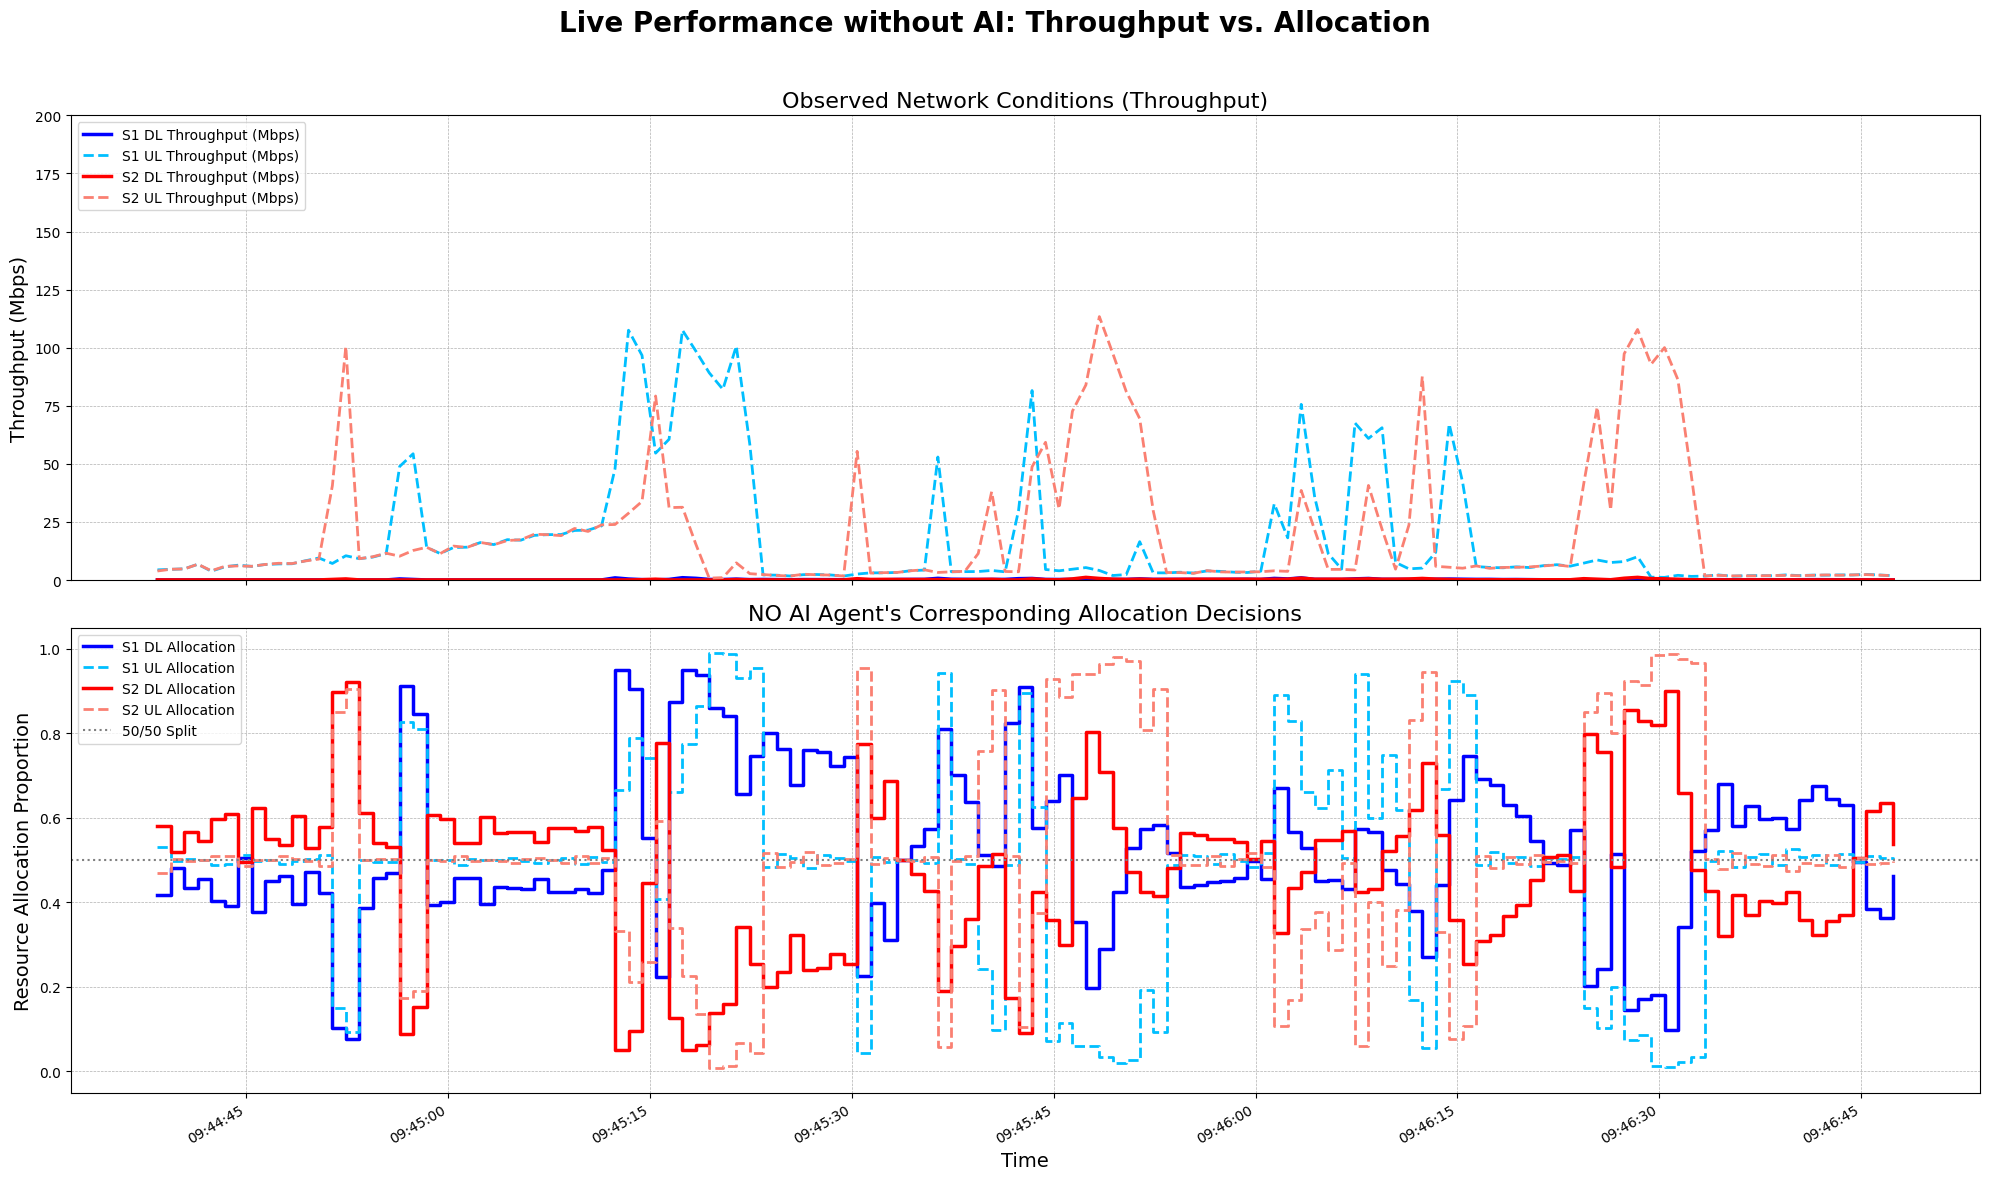

In [ ]:
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import os

# --- 1. Raw Log Data ---
# PASTE YOUR NEW, FULL LOG DATA HERE
LOG_DATA = """
2025-12-23 09:44:38.385: Got KPIs from Qosium: [{"downlink": {"throughput": 31216.0, "latency": 7.903, "jitter": 1.836, "packetLoss": 0.0}, "uplink": {"throughput": 4375840.0, "latency": 6.826, "jitter": 0.078, "packetLoss": 0.0}, "time": 1766483078385}, {"downlink": {"throughput": 43440.0, "latency": 8.343, "jitter": 3.393, "packetLoss": 0.0}, "uplink": {"throughput": 3878928.0, "latency": 8.246, "jitter": 0.421, "packetLoss": 0.0}, "time": 1766483078385}]
2025-12-23 09:44:38.385: Set DL slice allocation; Time=1766483078385, Slice1=0.4181, Slice2=0.5819
2025-12-23 09:44:38.385: Set UL slice allocation; Time=1766483078385, Slice1=0.5301, Slice2=0.4699
2025-12-23 09:44:39.386: Got KPIs from Qosium: [{"downlink": {"throughput": 38056.0, "latency": 9.995, "jitter": 2.183, "packetLoss": 0.0}, "uplink": {"throughput": 4596912.0, "latency": 7.059, "jitter": 0.294, "packetLoss": 0.0}, "time": 1766483079386}, {"downlink": {"throughput": 40984.0, "latency": 8.007, "jitter": 2.419, "packetLoss": 0.0}, "uplink": {"throughput": 4638136.0, "latency": 7.917, "jitter": 0.3, "packetLoss": 0.0}, "time": 1766483079386}]
2025-12-23 09:44:39.386: Set DL slice allocation; Time=1766483079386, Slice1=0.4815, Slice2=0.5185
2025-12-23 09:44:39.386: Set UL slice allocation; Time=1766483079386, Slice1=0.4978, Slice2=0.5022
2025-12-23 09:44:40.385: Got KPIs from Qosium: [{"downlink": {"throughput": 32704.0, "latency": 8.57, "jitter": 1.958, "packetLoss": 0.0}, "uplink": {"throughput": 4820880.0, "latency": 7.025, "jitter": 0.405, "packetLoss": 0.0}, "time": 1766483080385}, {"downlink": {"throughput": 42736.0, "latency": 8.756, "jitter": 2.318, "packetLoss": 0.0}, "uplink": {"throughput": 4773280.0, "latency": 8.398, "jitter": 0.275, "packetLoss": 0.0}, "time": 1766483080385}]
2025-12-23 09:44:40.385: Set DL slice allocation; Time=1766483080385, Slice1=0.4335, Slice2=0.5665
2025-12-23 09:44:40.385: Set UL slice allocation; Time=1766483080385, Slice1=0.5025, Slice2=0.4975
2025-12-23 09:44:41.386: Got KPIs from Qosium: [{"downlink": {"throughput": 35672.0, "latency": 7.495, "jitter": 1.913, "packetLoss": 0.0}, "uplink": {"throughput": 6778392.0, "latency": 8.459, "jitter": 0.115, "packetLoss": 0.0}, "time": 1766483081386}, {"downlink": {"throughput": 42640.0, "latency": 8.24, "jitter": 2.666, "packetLoss": 0.0}, "uplink": {"throughput": 6797448.0, "latency": 8.909, "jitter": 0.195, "packetLoss": 0.0}, "time": 1766483081386}]
2025-12-23 09:44:41.386: Set DL slice allocation; Time=1766483081386, Slice1=0.4555, Slice2=0.5445
2025-12-23 09:44:41.386: Set UL slice allocation; Time=1766483081386, Slice1=0.4993, Slice2=0.5007
2025-12-23 09:44:42.386: Got KPIs from Qosium: [{"downlink": {"throughput": 31984.0, "latency": 9.454, "jitter": 1.929, "packetLoss": 0.0}, "uplink": {"throughput": 3819328.0, "latency": 9.436, "jitter": 0.194, "packetLoss": 0.0}, "time": 1766483082386}, {"downlink": {"throughput": 47352.0, "latency": 7.538, "jitter": 1.826, "packetLoss": 0.0}, "uplink": {"throughput": 3990760.0, "latency": 9.546, "jitter": 0.742, "packetLoss": 0.0}, "time": 1766483082386}]
2025-12-23 09:44:42.386: Set DL slice allocation; Time=1766483082386, Slice1=0.4031, Slice2=0.5969
2025-12-23 09:44:42.386: Set UL slice allocation; Time=1766483082386, Slice1=0.489, Slice2=0.511
2025-12-23 09:44:43.386: Got KPIs from Qosium: [{"downlink": {"throughput": 31232.0, "latency": 8.973, "jitter": 1.778, "packetLoss": 0.0}, "uplink": {"throughput": 5664320.0, "latency": 7.0, "jitter": 0.471, "packetLoss": 0.0}, "time": 1766483083386}, {"downlink": {"throughput": 48600.0, "latency": 8.796, "jitter": 2.552, "packetLoss": 0.0}, "uplink": {"throughput": 5874624.0, "latency": 8.328, "jitter": 0.179, "packetLoss": 0.0}, "time": 1766483083386}]
2025-12-23 09:44:43.386: Set DL slice allocation; Time=1766483083386, Slice1=0.3912, Slice2=0.6088
2025-12-23 09:44:43.386: Set UL slice allocation; Time=1766483083386, Slice1=0.4909, Slice2=0.5091
2025-12-23 09:44:44.385: Got KPIs from Qosium: [{"downlink": {"throughput": 43800.0, "latency": 8.191, "jitter": 2.213, "packetLoss": 0.0}, "uplink": {"throughput": 6384776.0, "latency": 7.801, "jitter": 0.383, "packetLoss": 0.0}, "time": 1766483084385}, {"downlink": {"throughput": 42888.0, "latency": 8.221, "jitter": 3.158, "packetLoss": 0.0}, "uplink": {"throughput": 6069928.0, "latency": 8.938, "jitter": 0.345, "packetLoss": 0.0}, "time": 1766483084385}]
2025-12-23 09:44:44.385: Set DL slice allocation; Time=1766483084385, Slice1=0.5053, Slice2=0.4947
2025-12-23 09:44:44.385: Set UL slice allocation; Time=1766483084385, Slice1=0.5126, Slice2=0.4874
2025-12-23 09:44:45.385: Got KPIs from Qosium: [{"downlink": {"throughput": 28064.0, "latency": 8.088, "jitter": 2.394, "packetLoss": 0.0}, "uplink": {"throughput": 5879056.0, "latency": 7.625, "jitter": 0.061, "packetLoss": 0.0}, "time": 1766483085385}, {"downlink": {"throughput": 46480.0, "latency": 7.678, "jitter": 2.788, "packetLoss": 0.0}, "uplink": {"throughput": 5904424.0, "latency": 7.842, "jitter": 0.038, "packetLoss": 0.0}, "time": 1766483085385}]
2025-12-23 09:44:45.385: Set DL slice allocation; Time=1766483085385, Slice1=0.3765, Slice2=0.6235
2025-12-23 09:44:45.385: Set UL slice allocation; Time=1766483085385, Slice1=0.4989, Slice2=0.5011
2025-12-23 09:44:46.386: Got KPIs from Qosium: [{"downlink": {"throughput": 34688.0, "latency": 9.935, "jitter": 3.704, "packetLoss": 0.0}, "uplink": {"throughput": 6679640.0, "latency": 7.565, "jitter": 0.525, "packetLoss": 0.0}, "time": 1766483086386}, {"downlink": {"throughput": 42264.0, "latency": 9.195, "jitter": 3.139, "packetLoss": 0.0}, "uplink": {"throughput": 6685648.0, "latency": 8.183, "jitter": 0.133, "packetLoss": 0.0}, "time": 1766483086386}]
2025-12-23 09:44:46.386: Set DL slice allocation; Time=1766483086386, Slice1=0.4508, Slice2=0.5492
2025-12-23 09:44:46.386: Set UL slice allocation; Time=1766483086386, Slice1=0.4998, Slice2=0.5002
2025-12-23 09:44:47.385: Got KPIs from Qosium: [{"downlink": {"throughput": 38744.0, "latency": 7.914, "jitter": 2.691, "packetLoss": 0.0}, "uplink": {"throughput": 6926528.0, "latency": 7.881, "jitter": 0.287, "packetLoss": 0.0}, "time": 1766483087385}, {"downlink": {"throughput": 44872.0, "latency": 7.95, "jitter": 2.241, "packetLoss": 0.0}, "uplink": {"throughput": 7208336.0, "latency": 9.111, "jitter": 0.61, "packetLoss": 0.0}, "time": 1766483087385}]
2025-12-23 09:44:47.385: Set DL slice allocation; Time=1766483087385, Slice1=0.4634, Slice2=0.5366
2025-12-23 09:44:47.385: Set UL slice allocation; Time=1766483087385, Slice1=0.49, Slice2=0.51
2025-12-23 09:44:48.386: Got KPIs from Qosium: [{"downlink": {"throughput": 34032.0, "latency": 8.03, "jitter": 2.376, "packetLoss": 0.0}, "uplink": {"throughput": 6997248.0, "latency": 8.491, "jitter": 0.536, "packetLoss": 0.0}, "time": 1766483088386}, {"downlink": {"throughput": 51960.0, "latency": 9.189, "jitter": 3.178, "packetLoss": 0.0}, "uplink": {"throughput": 7076488.0, "latency": 8.444, "jitter": 0.132, "packetLoss": 0.0}, "time": 1766483088386}]
2025-12-23 09:44:48.386: Set DL slice allocation; Time=1766483088386, Slice1=0.3958, Slice2=0.6042
2025-12-23 09:44:48.386: Set UL slice allocation; Time=1766483088386, Slice1=0.4972, Slice2=0.5028
2025-12-23 09:44:49.386: Got KPIs from Qosium: [{"downlink": {"throughput": 37496.0, "latency": 8.934, "jitter": 3.047, "packetLoss": 0.0}, "uplink": {"throughput": 8294000.0, "latency": 8.007, "jitter": 0.673, "packetLoss": 0.0}, "time": 1766483089386}, {"downlink": {"throughput": 41944.0, "latency": 8.088, "jitter": 2.056, "packetLoss": 0.0}, "uplink": {"throughput": 8211080.0, "latency": 8.445, "jitter": 0.455, "packetLoss": 0.0}, "time": 1766483089386}]
2025-12-23 09:44:49.386: Set DL slice allocation; Time=1766483089386, Slice1=0.472, Slice2=0.528
2025-12-23 09:44:49.386: Set UL slice allocation; Time=1766483089386, Slice1=0.5025, Slice2=0.4975
2025-12-23 09:44:50.386: Got KPIs from Qosium: [{"downlink": {"throughput": 31472.0, "latency": 8.156, "jitter": 2.906, "packetLoss": 0.0}, "uplink": {"throughput": 9484848.0, "latency": 8.566, "jitter": 0.274, "packetLoss": 0.0}, "time": 1766483090386}, {"downlink": {"throughput": 43048.0, "latency": 7.507, "jitter": 1.461, "packetLoss": 0.0}, "uplink": {"throughput": 9002816.0, "latency": 10.185, "jitter": 0.29, "packetLoss": 0.0}, "time": 1766483090386}]
2025-12-23 09:44:50.386: Set DL slice allocation; Time=1766483090386, Slice1=0.4223, Slice2=0.5777
2025-12-23 09:44:50.386: Set UL slice allocation; Time=1766483090386, Slice1=0.513, Slice2=0.487
2025-12-23 09:44:51.386: Got KPIs from Qosium: [{"downlink": {"throughput": 31248.0, "latency": 8.019, "jitter": 2.442, "packetLoss": 0.0}, "uplink": {"throughput": 7123376.0, "latency": 8.23, "jitter": 0.154, "packetLoss": 0.0}, "time": 1766483091386}, {"downlink": {"throughput": 274512.0, "latency": 9.718, "jitter": 4.027, "packetLoss": 0.0}, "uplink": {"throughput": 40598568.0, "latency": 9.719, "jitter": 0.107, "packetLoss": 0.0}, "time": 1766483091386}]
2025-12-23 09:44:51.386: Set DL slice allocation; Time=1766483091386, Slice1=0.1022, Slice2=0.8978
2025-12-23 09:44:51.386: Set UL slice allocation; Time=1766483091386, Slice1=0.1493, Slice2=0.8507
2025-12-23 09:44:52.386: Got KPIs from Qosium: [{"downlink": {"throughput": 39648.0, "latency": 8.443, "jitter": 2.749, "packetLoss": 0.0}, "uplink": {"throughput": 10448896.0, "latency": 8.349, "jitter": 0.704, "packetLoss": 0.0}, "time": 1766483092386}, {"downlink": {"throughput": 472592.0, "latency": 11.759, "jitter": 2.909, "packetLoss": 0.0}, "uplink": {"throughput": 100496016.0, "latency": 9.737, "jitter": 0.063, "packetLoss": 0.0}, "time": 1766483092386}]
2025-12-23 09:44:52.386: Set DL slice allocation; Time=1766483092386, Slice1=0.0774, Slice2=0.9226
2025-12-23 09:44:52.386: Set UL slice allocation; Time=1766483092386, Slice1=0.0942, Slice2=0.9058
2025-12-23 09:44:53.386: Got KPIs from Qosium: [{"downlink": {"throughput": 31584.0, "latency": 8.334, "jitter": 2.28, "packetLoss": 0.0}, "uplink": {"throughput": 9185600.0, "latency": 7.666, "jitter": 0.216, "packetLoss": 0.0}, "time": 1766483093386}, {"downlink": {"throughput": 49920.0, "latency": 8.192, "jitter": 2.678, "packetLoss": 0.0}, "uplink": {"throughput": 9171600.0, "latency": 8.403, "jitter": 0.798, "packetLoss": 0.0}, "time": 1766483093386}]
2025-12-23 09:44:53.386: Set DL slice allocation; Time=1766483093386, Slice1=0.3875, Slice2=0.6125
2025-12-23 09:44:53.386: Set UL slice allocation; Time=1766483093386, Slice1=0.5004, Slice2=0.4996
2025-12-23 09:44:54.387: Got KPIs from Qosium: [{"downlink": {"throughput": 37224.0, "latency": 8.528, "jitter": 2.938, "packetLoss": 0.0}, "uplink": {"throughput": 9872312.0, "latency": 8.135, "jitter": 0.193, "packetLoss": 0.0}, "time": 1766483094387}, {"downlink": {"throughput": 44024.0, "latency": 8.733, "jitter": 3.092, "packetLoss": 0.0}, "uplink": {"throughput": 10013320.0, "latency": 9.595, "jitter": 0.141, "packetLoss": 0.0}, "time": 1766483094387}]
2025-12-23 09:44:54.387: Set DL slice allocation; Time=1766483094387, Slice1=0.4582, Slice2=0.5418
2025-12-23 09:44:54.387: Set UL slice allocation; Time=1766483094387, Slice1=0.4965, Slice2=0.5035
2025-12-23 09:44:55.387: Got KPIs from Qosium: [{"downlink": {"throughput": 35312.0, "latency": 9.327, "jitter": 2.058, "packetLoss": 0.0}, "uplink": {"throughput": 11371952.0, "latency": 7.989, "jitter": 0.515, "packetLoss": 0.0}, "time": 1766483095387}, {"downlink": {"throughput": 39944.0, "latency": 8.77, "jitter": 3.809, "packetLoss": 0.0}, "uplink": {"throughput": 11531736.0, "latency": 8.754, "jitter": 0.05, "packetLoss": 0.0}, "time": 1766483095387}]
2025-12-23 09:44:55.387: Set DL slice allocation; Time=1766483095387, Slice1=0.4692, Slice2=0.5308
2025-12-23 09:44:55.387: Set UL slice allocation; Time=1766483095387, Slice1=0.4965, Slice2=0.5035
2025-12-23 09:44:56.387: Got KPIs from Qosium: [{"downlink": {"throughput": 469136.0, "latency": 10.544, "jitter": 3.023, "packetLoss": 0.0}, "uplink": {"throughput": 48882464.0, "latency": 8.808, "jitter": 0.013, "packetLoss": 0.0}, "time": 1766483096387}, {"downlink": {"throughput": 45744.0, "latency": 8.271, "jitter": 3.502, "packetLoss": 0.0}, "uplink": {"throughput": 10251944.0, "latency": 9.302, "jitter": 0.565, "packetLoss": 0.0}, "time": 1766483096387}]
2025-12-23 09:44:56.387: Set DL slice allocation; Time=1766483096387, Slice1=0.9112, Slice2=0.0888
2025-12-23 09:44:56.387: Set UL slice allocation; Time=1766483096387, Slice1=0.8266, Slice2=0.1734
2025-12-23 09:44:57.386: Got KPIs from Qosium: [{"downlink": {"throughput": 248344.0, "latency": 19.551, "jitter": 5.43, "packetLoss": 0.0}, "uplink": {"throughput": 54337472.0, "latency": 8.563, "jitter": 0.097, "packetLoss": 0.0}, "time": 1766483097386}, {"downlink": {"throughput": 45080.0, "latency": 8.019, "jitter": 2.658, "packetLoss": 0.0}, "uplink": {"throughput": 12716216.0, "latency": 8.522, "jitter": 0.229, "packetLoss": 0.0}, "time": 1766483097386}]
2025-12-23 09:44:57.386: Set DL slice allocation; Time=1766483097386, Slice1=0.8464, Slice2=0.1536
2025-12-23 09:44:57.386: Set UL slice allocation; Time=1766483097386, Slice1=0.8104, Slice2=0.1896
2025-12-23 09:44:58.394: Got KPIs from Qosium: [{"downlink": {"throughput": 32368.000000000004, "latency": 8.409, "jitter": 3.674, "packetLoss": 0.0}, "uplink": {"throughput": 14071184.0, "latency": 7.942, "jitter": 0.234, "packetLoss": 0.007}, "time": 1766483098394}, {"downlink": {"throughput": 50000.0, "latency": 8.04, "jitter": 1.881, "packetLoss": 0.0}, "uplink": {"throughput": 14083376.0, "latency": 8.808, "jitter": 0.057, "packetLoss": 0.0}, "time": 1766483098394}]
2025-12-23 09:44:58.394: Set DL slice allocation; Time=1766483098394, Slice1=0.393, Slice2=0.607
2025-12-23 09:44:58.394: Set UL slice allocation; Time=1766483098394, Slice1=0.4998, Slice2=0.5002
2025-12-23 09:44:59.395: Got KPIs from Qosium: [{"downlink": {"throughput": 30728.0, "latency": 7.425, "jitter": 2.729, "packetLoss": 0.0}, "uplink": {"throughput": 11404928.0, "latency": 7.855, "jitter": 0.109, "packetLoss": 0.0}, "time": 1766483099395}, {"downlink": {"throughput": 45664.0, "latency": 7.282, "jitter": 2.297, "packetLoss": 0.0}, "uplink": {"throughput": 11350168.0, "latency": 8.136, "jitter": 0.17, "packetLoss": 0.0}, "time": 1766483099395}]
2025-12-23 09:44:59.395: Set DL slice allocation; Time=1766483099395, Slice1=0.4022, Slice2=0.5978
2025-12-23 09:44:59.395: Set UL slice allocation; Time=1766483099395, Slice1=0.5012, Slice2=0.4988
2025-12-23 09:45:00.388: Got KPIs from Qosium: [{"downlink": {"throughput": 35904.0, "latency": 9.212, "jitter": 2.931, "packetLoss": 0.0}, "uplink": {"throughput": 13983824.0, "latency": 8.208, "jitter": 0.376, "packetLoss": 0.0}, "time": 1766483100388}, {"downlink": {"throughput": 42408.0, "latency": 7.535, "jitter": 3.468, "packetLoss": 0.0}, "uplink": {"throughput": 14604608.0, "latency": 9.028, "jitter": 0.031, "packetLoss": 0.0}, "time": 1766483100388}]
2025-12-23 09:45:00.388: Set DL slice allocation; Time=1766483100388, Slice1=0.4585, Slice2=0.5415
2025-12-23 09:45:00.388: Set UL slice allocation; Time=1766483100388, Slice1=0.4891, Slice2=0.5109
2025-12-23 09:45:01.387: Got KPIs from Qosium: [{"downlink": {"throughput": 34968.0, "latency": 9.568, "jitter": 2.866, "packetLoss": 0.0}, "uplink": {"throughput": 14124624.0, "latency": 7.901, "jitter": 0.962, "packetLoss": 0.0}, "time": 1766483101387}, {"downlink": {"throughput": 41320.0, "latency": 8.607, "jitter": 2.562, "packetLoss": 0.0}, "uplink": {"throughput": 14021832.0, "latency": 8.576, "jitter": 0.216, "packetLoss": 0.0}, "time": 1766483101387}]
2025-12-23 09:45:01.387: Set DL slice allocation; Time=1766483101387, Slice1=0.4584, Slice2=0.5416
2025-12-23 09:45:01.387: Set UL slice allocation; Time=1766483101387, Slice1=0.5018, Slice2=0.4982
2025-12-23 09:45:02.387: Got KPIs from Qosium: [{"downlink": {"throughput": 32192.0, "latency": 9.306, "jitter": 3.552, "packetLoss": 0.0}, "uplink": {"throughput": 16128976.0, "latency": 7.958, "jitter": 0.254, "packetLoss": 0.0}, "time": 1766483102387}, {"downlink": {"throughput": 48840.0, "latency": 7.94, "jitter": 2.463, "packetLoss": 0.0}, "uplink": {"throughput": 16170632.0, "latency": 9.203, "jitter": 0.036, "packetLoss": 0.0}, "time": 1766483102387}]
2025-12-23 09:45:02.387: Set DL slice allocation; Time=1766483102387, Slice1=0.3973, Slice2=0.6027
2025-12-23 09:45:02.387: Set UL slice allocation; Time=1766483102387, Slice1=0.4994, Slice2=0.5006
2025-12-23 09:45:03.386: Got KPIs from Qosium: [{"downlink": {"throughput": 35840.0, "latency": 9.137, "jitter": 2.422, "packetLoss": 0.0}, "uplink": {"throughput": 15250960.0, "latency": 7.912, "jitter": 0.2, "packetLoss": 0.0}, "time": 1766483103386}, {"downlink": {"throughput": 46400.0, "latency": 7.927, "jitter": 1.825, "packetLoss": 0.0}, "uplink": {"throughput": 15203776.0, "latency": 9.311, "jitter": 0.039, "packetLoss": 0.0}, "time": 1766483103386}]
2025-12-23 09:45:03.386: Set DL slice allocation; Time=1766483103386, Slice1=0.4358, Slice2=0.5642
2025-12-23 09:45:03.386: Set UL slice allocation; Time=1766483103386, Slice1=0.5008, Slice2=0.4992
2025-12-23 09:45:04.388: Got KPIs from Qosium: [{"downlink": {"throughput": 35728.0, "latency": 9.395, "jitter": 3.32, "packetLoss": 0.0}, "uplink": {"throughput": 17369184.0, "latency": 7.758, "jitter": 0.912, "packetLoss": 0.0}, "time": 1766483104388}, {"downlink": {"throughput": 46624.0, "latency": 8.586, "jitter": 3.038, "packetLoss": 0.0}, "uplink": {"throughput": 16993176.0, "latency": 9.141, "jitter": 0.096, "packetLoss": 0.0}, "time": 1766483104388}]
2025-12-23 09:45:04.388: Set DL slice allocation; Time=1766483104388, Slice1=0.4338, Slice2=0.5662
2025-12-23 09:45:04.388: Set UL slice allocation; Time=1766483104388, Slice1=0.5055, Slice2=0.4945
2025-12-23 09:45:05.389: Got KPIs from Qosium: [{"downlink": {"throughput": 31952.0, "latency": 8.974, "jitter": 3.453, "packetLoss": 0.0}, "uplink": {"throughput": 17142336.0, "latency": 7.746, "jitter": 0.057, "packetLoss": 0.0}, "time": 1766483105389}, {"downlink": {"throughput": 41936.0, "latency": 8.818, "jitter": 3.411, "packetLoss": 0.0}, "uplink": {"throughput": 17342232.0, "latency": 9.431, "jitter": 0.048, "packetLoss": 0.0}, "time": 1766483105389}]
2025-12-23 09:45:05.389: Set DL slice allocation; Time=1766483105389, Slice1=0.4324, Slice2=0.5676
2025-12-23 09:45:05.389: Set UL slice allocation; Time=1766483105389, Slice1=0.4971, Slice2=0.5029
2025-12-23 09:45:06.388: Got KPIs from Qosium: [{"downlink": {"throughput": 35056.0, "latency": 7.943, "jitter": 2.105, "packetLoss": 0.0}, "uplink": {"throughput": 19216400.0, "latency": 8.963, "jitter": 0.591, "packetLoss": 0.0}, "time": 1766483106388}, {"downlink": {"throughput": 41856.0, "latency": 7.292, "jitter": 2.575, "packetLoss": 0.0}, "uplink": {"throughput": 19698392.0, "latency": 10.416, "jitter": 0.057, "packetLoss": 0.0}, "time": 1766483106388}]
2025-12-23 09:45:06.388: Set DL slice allocation; Time=1766483106388, Slice1=0.4558, Slice2=0.5442
2025-12-23 09:45:06.388: Set UL slice allocation; Time=1766483106388, Slice1=0.4938, Slice2=0.5062
2025-12-23 09:45:07.389: Got KPIs from Qosium: [{"downlink": {"throughput": 32912.0, "latency": 9.723, "jitter": 3.109, "packetLoss": 0.0}, "uplink": {"throughput": 19533184.0, "latency": 8.036, "jitter": 0.579, "packetLoss": 0.0}, "time": 1766483107389}, {"downlink": {"throughput": 44576.0, "latency": 7.995, "jitter": 1.86, "packetLoss": 0.0}, "uplink": {"throughput": 19509360.0, "latency": 9.427, "jitter": 0.019, "packetLoss": 0.0}, "time": 1766483107389}]
2025-12-23 09:45:07.389: Set DL slice allocation; Time=1766483107389, Slice1=0.4247, Slice2=0.5753
2025-12-23 09:45:07.389: Set UL slice allocation; Time=1766483107389, Slice1=0.5003, Slice2=0.4997
2025-12-23 09:45:08.389: Got KPIs from Qosium: [{"downlink": {"throughput": 37504.0, "latency": 8.53, "jitter": 4.386, "packetLoss": 0.0}, "uplink": {"throughput": 19586368.0, "latency": 8.413, "jitter": 0.059, "packetLoss": 0.0}, "time": 1766483108389}, {"downlink": {"throughput": 50912.0, "latency": 8.113, "jitter": 2.835, "packetLoss": 0.0}, "uplink": {"throughput": 19105512.0, "latency": 9.398, "jitter": 0.33, "packetLoss": 0.0}, "time": 1766483108389}]
2025-12-23 09:45:08.389: Set DL slice allocation; Time=1766483108389, Slice1=0.4242, Slice2=0.5758
2025-12-23 09:45:08.389: Set UL slice allocation; Time=1766483108389, Slice1=0.5062, Slice2=0.4938
2025-12-23 09:45:09.388: Got KPIs from Qosium: [{"downlink": {"throughput": 33056.0, "latency": 8.621, "jitter": 3.429, "packetLoss": 0.0}, "uplink": {"throughput": 21327328.0, "latency": 8.119, "jitter": 0.051, "packetLoss": 0.0}, "time": 1766483109388}, {"downlink": {"throughput": 43472.0, "latency": 7.711, "jitter": 2.509, "packetLoss": 0.0}, "uplink": {"throughput": 22191560.0, "latency": 9.22, "jitter": 0.019, "packetLoss": 0.0}, "time": 1766483109388}]
2025-12-23 09:45:09.388: Set DL slice allocation; Time=1766483109388, Slice1=0.4319, Slice2=0.5681
2025-12-23 09:45:09.388: Set UL slice allocation; Time=1766483109388, Slice1=0.4901, Slice2=0.5099
2025-12-23 09:45:10.389: Got KPIs from Qosium: [{"downlink": {"throughput": 30768.0, "latency": 9.19, "jitter": 2.851, "packetLoss": 0.0}, "uplink": {"throughput": 21464160.0, "latency": 8.67, "jitter": 0.41, "packetLoss": 0.0}, "time": 1766483110389}, {"downlink": {"throughput": 42288.0, "latency": 8.228, "jitter": 2.4, "packetLoss": 0.0}, "uplink": {"throughput": 20915872.0, "latency": 9.678, "jitter": 0.045, "packetLoss": 0.0}, "time": 1766483110389}]
2025-12-23 09:45:10.389: Set DL slice allocation; Time=1766483110389, Slice1=0.4212, Slice2=0.5788
2025-12-23 09:45:10.389: Set UL slice allocation; Time=1766483110389, Slice1=0.5065, Slice2=0.4935
2025-12-23 09:45:11.391: Got KPIs from Qosium: [{"downlink": {"throughput": 38352.0, "latency": 9.701, "jitter": 3.41, "packetLoss": 0.0}, "uplink": {"throughput": 23285568.0, "latency": 7.738, "jitter": 0.036, "packetLoss": 0.0}, "time": 1766483111391}, {"downlink": {"throughput": 42208.0, "latency": 7.96, "jitter": 2.251, "packetLoss": 0.0}, "uplink": {"throughput": 23732696.0, "latency": 9.318, "jitter": 0.439, "packetLoss": 0.0}, "time": 1766483111391}]
2025-12-23 09:45:11.391: Set DL slice allocation; Time=1766483111391, Slice1=0.4761, Slice2=0.5239
2025-12-23 09:45:11.391: Set UL slice allocation; Time=1766483111391, Slice1=0.4952, Slice2=0.5048
2025-12-23 09:45:12.392: Got KPIs from Qosium: [{"downlink": {"throughput": 927976.0, "latency": 9.555, "jitter": 2.751, "packetLoss": 0.0}, "uplink": {"throughput": 47891792.0, "latency": 8.091, "jitter": 0.037, "packetLoss": 0.0}, "time": 1766483112392}, {"downlink": {"throughput": 49624.0, "latency": 8.11, "jitter": 3.07, "packetLoss": 0.0}, "uplink": {"throughput": 23899784.0, "latency": 9.774, "jitter": 0.02, "packetLoss": 0.0}, "time": 1766483112392}]
2025-12-23 09:45:12.392: Set DL slice allocation; Time=1766483112392, Slice1=0.9492, Slice2=0.0508
2025-12-23 09:45:12.392: Set UL slice allocation; Time=1766483112392, Slice1=0.6671, Slice2=0.3329
2025-12-23 09:45:13.395: Got KPIs from Qosium: [{"downlink": {"throughput": 433024.0, "latency": 15.975, "jitter": 5.302, "packetLoss": 0.0}, "uplink": {"throughput": 107507050.0, "latency": 9.094, "jitter": 0.013, "packetLoss": 0.0}, "time": 1766483113395}, {"downlink": {"throughput": 45600.0, "latency": 8.46, "jitter": 3.295, "packetLoss": 0.0}, "uplink": {"throughput": 28747048.0, "latency": 9.63, "jitter": 0.017, "packetLoss": 0.0}, "time": 1766483113395}]
2025-12-23 09:45:13.395: Set DL slice allocation; Time=1766483113395, Slice1=0.9047, Slice2=0.0953
2025-12-23 09:45:13.395: Set UL slice allocation; Time=1766483113395, Slice1=0.789, Slice2=0.211
2025-12-23 09:45:14.398: Got KPIs from Qosium: [{"downlink": {"throughput": 181656.0, "latency": 8.839, "jitter": 4.825, "packetLoss": 0.0}, "uplink": {"throughput": 96695670.0, "latency": 8.078, "jitter": 0.015, "packetLoss": 0.005}, "time": 1766483114398}, {"downlink": {"throughput": 146584.0, "latency": 8.515, "jitter": 2.381, "packetLoss": 0.0}, "uplink": {"throughput": 33820352.0, "latency": 9.487, "jitter": 0.268, "packetLoss": 0.0}, "time": 1766483114398}]
2025-12-23 09:45:14.398: Set DL slice allocation; Time=1766483114398, Slice1=0.5534, Slice2=0.4466
2025-12-23 09:45:14.398: Set UL slice allocation; Time=1766483114398, Slice1=0.7409, Slice2=0.2591
2025-12-23 09:45:15.408: Got KPIs from Qosium: [{"downlink": {"throughput": 103496.0, "latency": 9.261, "jitter": 3.56, "packetLoss": 0.0}, "uplink": {"throughput": 54597144.0, "latency": 8.483, "jitter": 0.175, "packetLoss": 0.0}, "time": 1766483115408}, {"downlink": {"throughput": 359872.0, "latency": 13.474, "jitter": 6.007, "packetLoss": 0.0}, "uplink": {"throughput": 79195784.0, "latency": 9.659, "jitter": 0.022, "packetLoss": 0.0}, "time": 1766483115408}]
2025-12-23 09:45:15.408: Set DL slice allocation; Time=1766483115408, Slice1=0.2234, Slice2=0.7766
2025-12-23 09:45:15.408: Set UL slice allocation; Time=1766483115408, Slice1=0.4081, Slice2=0.5919
2025-12-23 09:45:16.409: Got KPIs from Qosium: [{"downlink": {"throughput": 269424.0, "latency": 9.275, "jitter": 3.365, "packetLoss": 0.0}, "uplink": {"throughput": 60582576.0, "latency": 8.492, "jitter": 0.797, "packetLoss": 0.0}, "time": 1766483116409}, {"downlink": {"throughput": 39040.0, "latency": 7.93, "jitter": 3.147, "packetLoss": 0.0}, "uplink": {"throughput": 31159216.0, "latency": 9.505, "jitter": 0.091, "packetLoss": 0.0}, "time": 1766483116409}]
2025-12-23 09:45:16.409: Set DL slice allocation; Time=1766483116409, Slice1=0.8734, Slice2=0.1266
2025-12-23 09:45:16.409: Set UL slice allocation; Time=1766483116409, Slice1=0.6604, Slice2=0.3396
2025-12-23 09:45:17.403: Got KPIs from Qosium: [{"downlink": {"throughput": 1002256.0, "latency": 10.093, "jitter": 3.291, "packetLoss": 0.0}, "uplink": {"throughput": 107511350.0, "latency": 8.767, "jitter": 0.146, "packetLoss": 0.0}, "time": 1766483117403}, {"downlink": {"throughput": 53008.0, "latency": 9.011, "jitter": 2.36, "packetLoss": 0.0}, "uplink": {"throughput": 31320712.0, "latency": 9.259, "jitter": 0.038, "packetLoss": 0.0}, "time": 1766483117403}]
2025-12-23 09:45:17.403: Set DL slice allocation; Time=1766483117403, Slice1=0.9498, Slice2=0.0502
2025-12-23 09:45:17.403: Set UL slice allocation; Time=1766483117403, Slice1=0.7744, Slice2=0.2256
2025-12-23 09:45:18.401: Got KPIs from Qosium: [{"downlink": {"throughput": 736528.0, "latency": 12.361, "jitter": 4.216, "packetLoss": 0.0}, "uplink": {"throughput": 98523256.0, "latency": 8.309, "jitter": 0.242, "packetLoss": 0.047}, "time": 1766483118401}, {"downlink": {"throughput": 48448.0, "latency": 9.07, "jitter": 3.234, "packetLoss": 0.0}, "uplink": {"throughput": 15369784.0, "latency": 10.231, "jitter": 1.036, "packetLoss": 0.0}, "time": 1766483118401}]
2025-12-23 09:45:18.401: Set DL slice allocation; Time=1766483118401, Slice1=0.9383, Slice2=0.0617
2025-12-23 09:45:18.401: Set UL slice allocation; Time=1766483118401, Slice1=0.8651, Slice2=0.1349
2025-12-23 09:45:19.394: Got KPIs from Qosium: [{"downlink": {"throughput": 259279.99999999997, "latency": 12.879, "jitter": 5.229, "packetLoss": 0.0}, "uplink": {"throughput": 89176584.0, "latency": 8.865, "jitter": 0.236, "packetLoss": 0.0}, "time": 1766483119394}, {"downlink": {"throughput": 41768.0, "latency": 7.639, "jitter": 1.952, "packetLoss": 0.0}, "uplink": {"throughput": 808280.0, "latency": 7.828, "jitter": 0.836, "packetLoss": 0.0}, "time": 1766483119394}]
2025-12-23 09:45:19.394: Set DL slice allocation; Time=1766483119394, Slice1=0.8613, Slice2=0.1387
2025-12-23 09:45:19.394: Set UL slice allocation; Time=1766483119394, Slice1=0.991, Slice2=0.009
2025-12-23 09:45:20.408: Got KPIs from Qosium: [{"downlink": {"throughput": 231152.0, "latency": 12.246, "jitter": 5.379, "packetLoss": 0.0}, "uplink": {"throughput": 82068560.0, "latency": 8.911, "jitter": 0.013, "packetLoss": 0.0}, "time": 1766483120408}, {"downlink": {"throughput": 43672.0, "latency": 7.616, "jitter": 2.295, "packetLoss": 0.0}, "uplink": {"throughput": 1024112.0000000001, "latency": 7.955, "jitter": 1.052, "packetLoss": 0.0}, "time": 1766483120408}]
2025-12-23 09:45:20.408: Set DL slice allocation; Time=1766483120408, Slice1=0.8411, Slice2=0.1589
2025-12-23 09:45:20.408: Set UL slice allocation; Time=1766483120408, Slice1=0.9877, Slice2=0.0123
2025-12-23 09:45:21.405: Got KPIs from Qosium: [{"downlink": {"throughput": 394480.0, "latency": 12.016, "jitter": 3.552, "packetLoss": 0.0}, "uplink": {"throughput": 100677950.0, "latency": 8.591, "jitter": 0.052, "packetLoss": 0.0}, "time": 1766483121405}, {"downlink": {"throughput": 205248.0, "latency": 9.458, "jitter": 3.872, "packetLoss": 0.0}, "uplink": {"throughput": 7386496.0, "latency": 9.108, "jitter": 0.368, "packetLoss": 0.0}, "time": 1766483121405}]
2025-12-23 09:45:21.405: Set DL slice allocation; Time=1766483121405, Slice1=0.6578, Slice2=0.3422
2025-12-23 09:45:21.405: Set UL slice allocation; Time=1766483121405, Slice1=0.9316, Slice2=0.0684
2025-12-23 09:45:22.411: Got KPIs from Qosium: [{"downlink": {"throughput": 185160.0, "latency": 9.836, "jitter": 3.43, "packetLoss": 0.0}, "uplink": {"throughput": 58299256.0, "latency": 8.509, "jitter": 0.656, "packetLoss": 0.0}, "time": 1766483122411}, {"downlink": {"throughput": 63136.0, "latency": 8.506, "jitter": 2.853, "packetLoss": 0.0}, "uplink": {"throughput": 2730056.0, "latency": 9.173, "jitter": 0.807, "packetLoss": 0.0}, "time": 1766483122411}]
2025-12-23 09:45:22.411: Set DL slice allocation; Time=1766483122411, Slice1=0.7457, Slice2=0.2543
2025-12-23 09:45:22.411: Set UL slice allocation; Time=1766483122411, Slice1=0.9553, Slice2=0.0447
2025-12-23 09:45:23.393: Got KPIs from Qosium: [{"downlink": {"throughput": 249584.0, "latency": 9.734, "jitter": 2.187, "packetLoss": 0.0}, "uplink": {"throughput": 2184144.0, "latency": 7.804, "jitter": 0.897, "packetLoss": 0.0}, "time": 1766483123393}, {"downlink": {"throughput": 62120.0, "latency": 8.793, "jitter": 2.077, "packetLoss": 0.0}, "uplink": {"throughput": 2330120.0, "latency": 7.795, "jitter": 0.695, "packetLoss": 0.0}, "time": 1766483123393}]
2025-12-23 09:45:23.393: Set DL slice allocation; Time=1766483123393, Slice1=0.8007, Slice2=0.1993
2025-12-23 09:45:23.393: Set UL slice allocation; Time=1766483123393, Slice1=0.4838, Slice2=0.5162
2025-12-23 09:45:24.398: Got KPIs from Qosium: [{"downlink": {"throughput": 189520.0, "latency": 9.805, "jitter": 2.786, "packetLoss": 0.0}, "uplink": {"throughput": 2085768.0, "latency": 7.924, "jitter": 0.885, "packetLoss": 0.0}, "time": 1766483124398}, {"downlink": {"throughput": 58576.0, "latency": 9.551, "jitter": 2.378, "packetLoss": 0.0}, "uplink": {"throughput": 1961304.0, "latency": 8.1, "jitter": 0.849, "packetLoss": 0.0}, "time": 1766483124398}]
2025-12-23 09:45:24.398: Set DL slice allocation; Time=1766483124398, Slice1=0.7639, Slice2=0.2361
2025-12-23 09:45:24.398: Set UL slice allocation; Time=1766483124398, Slice1=0.5154, Slice2=0.4846
2025-12-23 09:45:25.385: Got KPIs from Qosium: [{"downlink": {"throughput": 121736.0, "latency": 9.792, "jitter": 3.823, "packetLoss": 0.0}, "uplink": {"throughput": 1737072.0, "latency": 8.303, "jitter": 1.077, "packetLoss": 0.0}, "time": 1766483125385}, {"downlink": {"throughput": 57752.0, "latency": 8.493, "jitter": 2.073, "packetLoss": 0.0}, "uplink": {"throughput": 1700208.0, "latency": 7.852, "jitter": 0.649, "packetLoss": 0.0}, "time": 1766483125385}]
2025-12-23 09:45:25.385: Set DL slice allocation; Time=1766483125385, Slice1=0.6782, Slice2=0.3218
2025-12-23 09:45:25.385: Set UL slice allocation; Time=1766483125385, Slice1=0.5054, Slice2=0.4946
2025-12-23 09:45:26.385: Got KPIs from Qosium: [{"downlink": {"throughput": 197088.0, "latency": 9.139, "jitter": 2.8, "packetLoss": 0.0}, "uplink": {"throughput": 2303672.0, "latency": 8.178, "jitter": 0.882, "packetLoss": 0.0}, "time": 1766483126385}, {"downlink": {"throughput": 61864.0, "latency": 8.832, "jitter": 1.516, "packetLoss": 0.0}, "uplink": {"throughput": 2489616.0, "latency": 8.064, "jitter": 0.774, "packetLoss": 0.0}, "time": 1766483126385}]
2025-12-23 09:45:26.385: Set DL slice allocation; Time=1766483126385, Slice1=0.7611, Slice2=0.2389
2025-12-23 09:45:26.385: Set UL slice allocation; Time=1766483126385, Slice1=0.4806, Slice2=0.5194
2025-12-23 09:45:27.384: Got KPIs from Qosium: [{"downlink": {"throughput": 174368.0, "latency": 9.637, "jitter": 2.483, "packetLoss": 0.0}, "uplink": {"throughput": 2373872.0, "latency": 8.833, "jitter": 0.639, "packetLoss": 0.0}, "time": 1766483127384}, {"downlink": {"throughput": 56432.0, "latency": 8.766, "jitter": 2.125, "packetLoss": 0.0}, "uplink": {"throughput": 2267568.0, "latency": 8.789, "jitter": 1.241, "packetLoss": 0.0}, "time": 1766483127384}]
2025-12-23 09:45:27.384: Set DL slice allocation; Time=1766483127384, Slice1=0.7555, Slice2=0.2445
2025-12-23 09:45:27.384: Set UL slice allocation; Time=1766483127384, Slice1=0.5115, Slice2=0.4885
2025-12-23 09:45:28.385: Got KPIs from Qosium: [{"downlink": {"throughput": 153376.0, "latency": 9.695, "jitter": 2.983, "packetLoss": 0.0}, "uplink": {"throughput": 2182120.0, "latency": 7.984, "jitter": 0.49, "packetLoss": 0.0}, "time": 1766483128385}, {"downlink": {"throughput": 59016.0, "latency": 8.381, "jitter": 3.081, "packetLoss": 0.0}, "uplink": {"throughput": 2129928.0, "latency": 7.835, "jitter": 0.744, "packetLoss": 0.0}, "time": 1766483128385}]
2025-12-23 09:45:28.385: Set DL slice allocation; Time=1766483128385, Slice1=0.7221, Slice2=0.2779
2025-12-23 09:45:28.385: Set UL slice allocation; Time=1766483128385, Slice1=0.5061, Slice2=0.4939
2025-12-23 09:45:29.385: Got KPIs from Qosium: [{"downlink": {"throughput": 148872.0, "latency": 9.507, "jitter": 2.626, "packetLoss": 0.0}, "uplink": {"throughput": 1710864.0, "latency": 7.833, "jitter": 0.489, "packetLoss": 0.0}, "time": 1766483129385}, {"downlink": {"throughput": 51040.0, "latency": 8.777, "jitter": 2.239, "packetLoss": 0.0}, "uplink": {"throughput": 1728168.0, "latency": 7.824, "jitter": 0.868, "packetLoss": 0.0}, "time": 1766483129385}]
2025-12-23 09:45:29.385: Set DL slice allocation; Time=1766483129385, Slice1=0.7447, Slice2=0.2553
2025-12-23 09:45:29.385: Set UL slice allocation; Time=1766483129385, Slice1=0.4975, Slice2=0.5025
2025-12-23 09:45:30.385: Got KPIs from Qosium: [{"downlink": {"throughput": 169376.0, "latency": 9.584, "jitter": 2.617, "packetLoss": 0.0}, "uplink": {"throughput": 2569064.0, "latency": 7.945, "jitter": 0.69, "packetLoss": 0.0}, "time": 1766483130385}, {"downlink": {"throughput": 580144.0, "latency": 10.328, "jitter": 3.486, "packetLoss": 0.0}, "uplink": {"throughput": 55390200.0, "latency": 9.724, "jitter": 0.585, "packetLoss": 0.0}, "time": 1766483130385}]
2025-12-23 09:45:30.385: Set DL slice allocation; Time=1766483130385, Slice1=0.226, Slice2=0.774
2025-12-23 09:45:30.385: Set UL slice allocation; Time=1766483130385, Slice1=0.0443, Slice2=0.9557
2025-12-23 09:45:31.385: Got KPIs from Qosium: [{"downlink": {"throughput": 152288.0, "latency": 8.294, "jitter": 2.019, "packetLoss": 0.0}, "uplink": {"throughput": 3077968.0, "latency": 7.92, "jitter": 0.766, "packetLoss": 0.0}, "time": 1766483131385}, {"downlink": {"throughput": 229424.0, "latency": 10.523, "jitter": 2.795, "packetLoss": 0.0}, "uplink": {"throughput": 2977448.0, "latency": 11.532, "jitter": 0.558, "packetLoss": 0.0}, "time": 1766483131385}]
2025-12-23 09:45:31.385: Set DL slice allocation; Time=1766483131385, Slice1=0.399, Slice2=0.601
2025-12-23 09:45:31.385: Set UL slice allocation; Time=1766483131385, Slice1=0.5083, Slice2=0.4917
2025-12-23 09:45:32.385: Got KPIs from Qosium: [{"downlink": {"throughput": 129943.99999999999, "latency": 9.173, "jitter": 3.145, "packetLoss": 0.0}, "uplink": {"throughput": 3103224.0, "latency": 8.193, "jitter": 0.445, "packetLoss": 0.0}, "time": 1766483132385}, {"downlink": {"throughput": 286360.0, "latency": 8.083, "jitter": 1.931, "packetLoss": 0.0}, "uplink": {"throughput": 3167720.0, "latency": 8.27, "jitter": 0.842, "packetLoss": 0.0}, "time": 1766483132385}]
2025-12-23 09:45:32.385: Set DL slice allocation; Time=1766483132385, Slice1=0.3121, Slice2=0.6879
2025-12-23 09:45:32.385: Set UL slice allocation; Time=1766483132385, Slice1=0.4949, Slice2=0.5051
2025-12-23 09:45:33.385: Got KPIs from Qosium: [{"downlink": {"throughput": 237328.0, "latency": 8.714, "jitter": 1.768, "packetLoss": 0.0}, "uplink": {"throughput": 3261488.0, "latency": 8.16, "jitter": 0.511, "packetLoss": 0.0}, "time": 1766483133385}, {"downlink": {"throughput": 236920.0, "latency": 7.719, "jitter": 2.09, "packetLoss": 0.0}, "uplink": {"throughput": 3270456.0, "latency": 8.089, "jitter": 0.753, "packetLoss": 0.0}, "time": 1766483133385}]
2025-12-23 09:45:33.385: Set DL slice allocation; Time=1766483133385, Slice1=0.5004, Slice2=0.4996
2025-12-23 09:45:33.385: Set UL slice allocation; Time=1766483133385, Slice1=0.4993, Slice2=0.5007
2025-12-23 09:45:34.385: Got KPIs from Qosium: [{"downlink": {"throughput": 281896.0, "latency": 9.247, "jitter": 2.648, "packetLoss": 0.0}, "uplink": {"throughput": 4022064.0, "latency": 7.345, "jitter": 0.642, "packetLoss": 0.0}, "time": 1766483134385}, {"downlink": {"throughput": 247016.0, "latency": 8.955, "jitter": 1.779, "packetLoss": 0.0}, "uplink": {"throughput": 4001432.0, "latency": 8.754, "jitter": 0.535, "packetLoss": 0.0}, "time": 1766483134385}]
2025-12-23 09:45:34.385: Set DL slice allocation; Time=1766483134385, Slice1=0.533, Slice2=0.467
2025-12-23 09:45:34.385: Set UL slice allocation; Time=1766483134385, Slice1=0.5013, Slice2=0.4987
2025-12-23 09:45:35.385: Got KPIs from Qosium: [{"downlink": {"throughput": 286792.0, "latency": 8.373, "jitter": 1.682, "packetLoss": 0.0}, "uplink": {"throughput": 4278784.0, "latency": 8.534, "jitter": 1.035, "packetLoss": 0.0}, "time": 1766483135385}, {"downlink": {"throughput": 212816.0, "latency": 8.147, "jitter": 1.582, "packetLoss": 0.0}, "uplink": {"throughput": 4393120.0, "latency": 8.838, "jitter": 0.302, "packetLoss": 0.0}, "time": 1766483135385}]
2025-12-23 09:45:35.385: Set DL slice allocation; Time=1766483135385, Slice1=0.574, Slice2=0.426
2025-12-23 09:45:35.385: Set UL slice allocation; Time=1766483135385, Slice1=0.4934, Slice2=0.5066
2025-12-23 09:45:36.386: Got KPIs from Qosium: [{"downlink": {"throughput": 726264.0, "latency": 10.424, "jitter": 3.723, "packetLoss": 0.0}, "uplink": {"throughput": 52944856.0, "latency": 9.621, "jitter": 0.012, "packetLoss": 0.0}, "time": 1766483136386}, {"downlink": {"throughput": 169912.0, "latency": 8.934, "jitter": 1.939, "packetLoss": 0.0}, "uplink": {"throughput": 3253936.0, "latency": 8.041, "jitter": 0.333, "packetLoss": 0.0}, "time": 1766483136386}]
2025-12-23 09:45:36.386: Set DL slice allocation; Time=1766483136386, Slice1=0.8104, Slice2=0.1896
2025-12-23 09:45:36.386: Set UL slice allocation; Time=1766483136386, Slice1=0.9421, Slice2=0.0579
2025-12-23 09:45:37.387: Got KPIs from Qosium: [{"downlink": {"throughput": 342984.0, "latency": 8.905, "jitter": 1.513, "packetLoss": 0.0}, "uplink": {"throughput": 3564760.0, "latency": 8.484, "jitter": 0.228, "packetLoss": 0.0}, "time": 1766483137387}, {"downlink": {"throughput": 145352.0, "latency": 8.554, "jitter": 2.215, "packetLoss": 0.0}, "uplink": {"throughput": 3531056.0, "latency": 8.427, "jitter": 0.363, "packetLoss": 0.0}, "time": 1766483137387}]
2025-12-23 09:45:37.387: Set DL slice allocation; Time=1766483137387, Slice1=0.7024, Slice2=0.2976
2025-12-23 09:45:37.387: Set UL slice allocation; Time=1766483137387, Slice1=0.5024, Slice2=0.4976
2025-12-23 09:45:38.393: Got KPIs from Qosium: [{"downlink": {"throughput": 282296.0, "latency": 8.463, "jitter": 0.959, "packetLoss": 0.0}, "uplink": {"throughput": 3599936.0, "latency": 7.7, "jitter": 0.497, "packetLoss": 0.0}, "time": 1766483138393}, {"downlink": {"throughput": 159608.0, "latency": 8.606, "jitter": 1.649, "packetLoss": 0.0}, "uplink": {"throughput": 3745296.0, "latency": 7.885, "jitter": 1.077, "packetLoss": 0.0}, "time": 1766483138393}]
2025-12-23 09:45:38.393: Set DL slice allocation; Time=1766483138393, Slice1=0.6388, Slice2=0.3612
2025-12-23 09:45:38.393: Set UL slice allocation; Time=1766483138393, Slice1=0.4901, Slice2=0.5099
2025-12-23 09:45:39.386: Got KPIs from Qosium: [{"downlink": {"throughput": 250120.0, "latency": 8.145, "jitter": 1.41, "packetLoss": 0.0}, "uplink": {"throughput": 3649136.0, "latency": 7.935, "jitter": 0.441, "packetLoss": 0.0}, "time": 1766483139386}, {"downlink": {"throughput": 237592.0, "latency": 9.027, "jitter": 3.445, "packetLoss": 0.0}, "uplink": {"throughput": 11409120.0, "latency": 8.757, "jitter": 0.586, "packetLoss": 0.0}, "time": 1766483139386}]
2025-12-23 09:45:39.386: Set DL slice allocation; Time=1766483139386, Slice1=0.5128, Slice2=0.4872
2025-12-23 09:45:39.386: Set UL slice allocation; Time=1766483139386, Slice1=0.2423, Slice2=0.7577
2025-12-23 09:45:40.385: Got KPIs from Qosium: [{"downlink": {"throughput": 283664.0, "latency": 9.663, "jitter": 2.328, "packetLoss": 0.0}, "uplink": {"throughput": 4118608.0, "latency": 8.012, "jitter": 0.443, "packetLoss": 0.0}, "time": 1766483140385}, {"downlink": {"throughput": 300304.0, "latency": 10.781, "jitter": 4.599, "packetLoss": 0.0}, "uplink": {"throughput": 38020880.0, "latency": 8.843, "jitter": 0.413, "packetLoss": 0.0}, "time": 1766483140385}]
2025-12-23 09:45:40.385: Set DL slice allocation; Time=1766483140385, Slice1=0.4858, Slice2=0.5142
2025-12-23 09:45:40.385: Set UL slice allocation; Time=1766483140385, Slice1=0.0977, Slice2=0.9023
2025-12-23 09:45:41.385: Got KPIs from Qosium: [{"downlink": {"throughput": 280136.0, "latency": 9.377, "jitter": 1.778, "packetLoss": 0.0}, "uplink": {"throughput": 3522080.0, "latency": 7.543, "jitter": 0.29, "packetLoss": 0.0}, "time": 1766483141385}, {"downlink": {"throughput": 59184.0, "latency": 9.871, "jitter": 3.739, "packetLoss": 0.0}, "uplink": {"throughput": 3676544.0, "latency": 8.563, "jitter": 0.437, "packetLoss": 0.0}, "time": 1766483141385}]
2025-12-23 09:45:41.385: Set DL slice allocation; Time=1766483141385, Slice1=0.8256, Slice2=0.1744
2025-12-23 09:45:41.385: Set UL slice allocation; Time=1766483141385, Slice1=0.4893, Slice2=0.5107
2025-12-23 09:45:42.385: Got KPIs from Qosium: [{"downlink": {"throughput": 588736.0, "latency": 9.074, "jitter": 2.439, "packetLoss": 0.0}, "uplink": {"throughput": 30085504.0, "latency": 8.06, "jitter": 0.01, "packetLoss": 0.0}, "time": 1766483142385}, {"downlink": {"throughput": 58448.0, "latency": 8.596, "jitter": 4.112, "packetLoss": 0.0}, "uplink": {"throughput": 3542832.0, "latency": 8.374, "jitter": 0.333, "packetLoss": 0.0}, "time": 1766483142385}]
2025-12-23 09:45:42.385: Set DL slice allocation; Time=1766483142385, Slice1=0.9097, Slice2=0.0903
2025-12-23 09:45:42.385: Set UL slice allocation; Time=1766483142385, Slice1=0.8946, Slice2=0.1054
2025-12-23 09:45:43.386: Got KPIs from Qosium: [{"downlink": {"throughput": 679376.0, "latency": 11.024, "jitter": 2.899, "packetLoss": 0.0}, "uplink": {"throughput": 81552610.0, "latency": 8.657, "jitter": 0.724, "packetLoss": 0.0}, "time": 1766483143386}, {"downlink": {"throughput": 499464.0, "latency": 9.325, "jitter": 2.276, "packetLoss": 0.0}, "uplink": {"throughput": 48733072.0, "latency": 9.573, "jitter": 0.012, "packetLoss": 0.0}, "time": 1766483143386}]
2025-12-23 09:45:43.386: Set DL slice allocation; Time=1766483143386, Slice1=0.5763, Slice2=0.4237
2025-12-23 09:45:43.386: Set UL slice allocation; Time=1766483143386, Slice1=0.626, Slice2=0.374
2025-12-23 09:45:44.387: Got KPIs from Qosium: [{"downlink": {"throughput": 266584.0, "latency": 8.396, "jitter": 1.686, "packetLoss": 0.0}, "uplink": {"throughput": 4530376.0, "latency": 8.339, "jitter": 0.312, "packetLoss": 0.0}, "time": 1766483144387}, {"downlink": {"throughput": 149296.0, "latency": 14.136, "jitter": 4.677, "packetLoss": 0.0}, "uplink": {"throughput": 59279032.0, "latency": 8.93, "jitter": 0.264, "packetLoss": 0.0}, "time": 1766483144387}]
2025-12-23 09:45:44.387: Set DL slice allocation; Time=1766483144387, Slice1=0.641, Slice2=0.359
2025-12-23 09:45:44.387: Set UL slice allocation; Time=1766483144387, Slice1=0.071, Slice2=0.929
2025-12-23 09:45:45.392: Got KPIs from Qosium: [{"downlink": {"throughput": 234616.0, "latency": 9.852, "jitter": 2.729, "packetLoss": 0.0}, "uplink": {"throughput": 3964816.0, "latency": 7.641, "jitter": 0.796, "packetLoss": 0.0}, "time": 1766483145392}, {"downlink": {"throughput": 100168.0, "latency": 8.002, "jitter": 4.253, "packetLoss": 0.0}, "uplink": {"throughput": 30595728.0, "latency": 9.157, "jitter": 0.059, "packetLoss": 0.0}, "time": 1766483145392}]
2025-12-23 09:45:45.392: Set DL slice allocation; Time=1766483145392, Slice1=0.7008, Slice2=0.2992
2025-12-23 09:45:45.392: Set UL slice allocation; Time=1766483145392, Slice1=0.1147, Slice2=0.8853
2025-12-23 09:45:46.386: Got KPIs from Qosium: [{"downlink": {"throughput": 263592.0, "latency": 8.331, "jitter": 1.498, "packetLoss": 0.0}, "uplink": {"throughput": 4667376.0, "latency": 7.239, "jitter": 0.2, "packetLoss": 0.0}, "time": 1766483146386}, {"downlink": {"throughput": 484024.0, "latency": 10.302, "jitter": 7.862, "packetLoss": 0.0}, "uplink": {"throughput": 72657680.0, "latency": 9.574, "jitter": 0.04, "packetLoss": 0.0}, "time": 1766483146386}]
2025-12-23 09:45:46.386: Set DL slice allocation; Time=1766483146386, Slice1=0.3526, Slice2=0.6474
2025-12-23 09:45:46.386: Set UL slice allocation; Time=1766483146386, Slice1=0.0604, Slice2=0.9396
2025-12-23 09:45:47.386: Got KPIs from Qosium: [{"downlink": {"throughput": 281000.0, "latency": 9.604, "jitter": 2.229, "packetLoss": 0.0}, "uplink": {"throughput": 5348888.0, "latency": 7.507, "jitter": 0.323, "packetLoss": 0.0}, "time": 1766483147386}, {"downlink": {"throughput": 1148008.0, "latency": 10.972, "jitter": 4.52, "packetLoss": 0.0}, "uplink": {"throughput": 83961704.0, "latency": 9.721, "jitter": 0.472, "packetLoss": 0.0}, "time": 1766483147386}]
2025-12-23 09:45:47.386: Set DL slice allocation; Time=1766483147386, Slice1=0.1966, Slice2=0.8034
2025-12-23 09:45:47.386: Set UL slice allocation; Time=1766483147386, Slice1=0.0599, Slice2=0.9401
2025-12-23 09:45:48.387: Got KPIs from Qosium: [{"downlink": {"throughput": 279544.0, "latency": 8.591, "jitter": 2.072, "packetLoss": 0.0}, "uplink": {"throughput": 4106294.0, "latency": 9.095, "jitter": 1.062, "packetLoss": 0.0}, "time": 1766483148387}, {"downlink": {"throughput": 683752.0, "latency": 10.599, "jitter": 6.977, "packetLoss": 0.0}, "uplink": {"throughput": 113368450.0, "latency": 9.526, "jitter": 0.025, "packetLoss": 0.008}, "time": 1766483148387}]
2025-12-23 09:45:48.387: Set DL slice allocation; Time=1766483148387, Slice1=0.2902, Slice2=0.7098
2025-12-23 09:45:48.387: Set UL slice allocation; Time=1766483148387, Slice1=0.035, Slice2=0.965
2025-12-23 09:45:49.386: Got KPIs from Qosium: [{"downlink": {"throughput": 268653.0, "latency": 10.057, "jitter": 1.903, "packetLoss": 0.0}, "uplink": {"throughput": 1939652.0, "latency": 8.196, "jitter": 0.658, "packetLoss": 0.0}, "time": 1766483149386}, {"downlink": {"throughput": 364264.0, "latency": 12.947, "jitter": 7.594, "packetLoss": 0.0}, "uplink": {"throughput": 97535630.0, "latency": 9.19, "jitter": 0.027, "packetLoss": 0.0}, "time": 1766483149386}]
2025-12-23 09:45:49.386: Set DL slice allocation; Time=1766483149386, Slice1=0.4245, Slice2=0.5755
2025-12-23 09:45:49.386: Set UL slice allocation; Time=1766483149386, Slice1=0.0195, Slice2=0.9805
2025-12-23 09:45:50.386: Got KPIs from Qosium: [{"downlink": {"throughput": 268955.0, "latency": 9.692, "jitter": 2.354, "packetLoss": 0.0}, "uplink": {"throughput": 2340803.0, "latency": 8.259, "jitter": 1.175, "packetLoss": 0.0}, "time": 1766483150386}, {"downlink": {"throughput": 239760.0, "latency": 11.826, "jitter": 3.759, "packetLoss": 0.0}, "uplink": {"throughput": 81112784.0, "latency": 8.887, "jitter": 0.024, "packetLoss": 0.0}, "time": 1766483150386}]
2025-12-23 09:45:50.386: Set DL slice allocation; Time=1766483150386, Slice1=0.5287, Slice2=0.4713
2025-12-23 09:45:50.386: Set UL slice allocation; Time=1766483150386, Slice1=0.028, Slice2=0.972
2025-12-23 09:45:51.385: Got KPIs from Qosium: [{"downlink": {"throughput": 488809.0, "latency": 10.669, "jitter": 2.951, "packetLoss": 0.0}, "uplink": {"throughput": 16512496.0, "latency": 8.953, "jitter": 1.088, "packetLoss": 0.0}, "time": 1766483151385}, {"downlink": {"throughput": 361896.0, "latency": 9.889, "jitter": 4.193, "packetLoss": 0.0}, "uplink": {"throughput": 69494024.0, "latency": 9.435, "jitter": 0.02, "packetLoss": 0.0}, "time": 1766483151385}]
2025-12-23 09:45:51.385: Set DL slice allocation; Time=1766483151385, Slice1=0.5746, Slice2=0.4254
2025-12-23 09:45:51.385: Set UL slice allocation; Time=1766483151385, Slice1=0.192, Slice2=0.808
2025-12-23 09:45:52.386: Got KPIs from Qosium: [{"downlink": {"throughput": 285128.0, "latency": 9.551, "jitter": 1.905, "packetLoss": 0.0}, "uplink": {"throughput": 3103152.0, "latency": 8.195, "jitter": 0.542, "packetLoss": 0.0}, "time": 1766483152386}, {"downlink": {"throughput": 203224.0, "latency": 10.626, "jitter": 3.27, "packetLoss": 0.0}, "uplink": {"throughput": 29954160.0, "latency": 8.573, "jitter": 0.846, "packetLoss": 0.0}, "time": 1766483152386}]
2025-12-23 09:45:52.386: Set DL slice allocation; Time=1766483152386, Slice1=0.5839, Slice2=0.4161
2025-12-23 09:45:52.386: Set UL slice allocation; Time=1766483152386, Slice1=0.0939, Slice2=0.9061
2025-12-23 09:45:53.386: Got KPIs from Qosium: [{"downlink": {"throughput": 276136.0, "latency": 9.985, "jitter": 2.064, "packetLoss": 0.0}, "uplink": {"throughput": 3068368.0, "latency": 8.553, "jitter": 1.13, "packetLoss": 0.0}, "time": 1766483153386}, {"downlink": {"throughput": 257616.0, "latency": 9.37, "jitter": 2.886, "packetLoss": 0.0}, "uplink": {"throughput": 3224472.0, "latency": 8.333, "jitter": 0.849, "packetLoss": 0.0}, "time": 1766483153386}]
2025-12-23 09:45:53.386: Set DL slice allocation; Time=1766483153386, Slice1=0.5173, Slice2=0.4827
2025-12-23 09:45:53.386: Set UL slice allocation; Time=1766483153386, Slice1=0.4876, Slice2=0.5124
2025-12-23 09:45:54.386: Got KPIs from Qosium: [{"downlink": {"throughput": 251920.0, "latency": 9.012, "jitter": 2.041, "packetLoss": 0.0}, "uplink": {"throughput": 3355272.0, "latency": 8.201, "jitter": 0.883, "packetLoss": 0.0}, "time": 1766483154386}, {"downlink": {"throughput": 326400.0, "latency": 10.039, "jitter": 2.517, "packetLoss": 0.0}, "uplink": {"throughput": 3202544.0, "latency": 8.603, "jitter": 0.707, "packetLoss": 0.0}, "time": 1766483154386}]
2025-12-23 09:45:54.386: Set DL slice allocation; Time=1766483154386, Slice1=0.4356, Slice2=0.5644
2025-12-23 09:45:54.386: Set UL slice allocation; Time=1766483154386, Slice1=0.5116, Slice2=0.4884
2025-12-23 09:45:55.386: Got KPIs from Qosium: [{"downlink": {"throughput": 277744.0, "latency": 8.753, "jitter": 1.52, "packetLoss": 0.0}, "uplink": {"throughput": 3006336.0, "latency": 8.117, "jitter": 0.69, "packetLoss": 0.0}, "time": 1766483155386}, {"downlink": {"throughput": 353128.0, "latency": 9.782, "jitter": 2.957, "packetLoss": 0.0}, "uplink": {"throughput": 2875280.0, "latency": 8.432, "jitter": 0.877, "packetLoss": 0.0}, "time": 1766483155386}]
2025-12-23 09:45:55.386: Set DL slice allocation; Time=1766483155386, Slice1=0.4403, Slice2=0.5597
2025-12-23 09:45:55.386: Set UL slice allocation; Time=1766483155386, Slice1=0.5111, Slice2=0.4889
2025-12-23 09:45:56.386: Got KPIs from Qosium: [{"downlink": {"throughput": 290064.0, "latency": 10.245, "jitter": 2.584, "packetLoss": 0.0}, "uplink": {"throughput": 3909480.0, "latency": 8.241, "jitter": 0.665, "packetLoss": 0.0}, "time": 1766483156386}, {"downlink": {"throughput": 355816.0, "latency": 9.22, "jitter": 1.639, "packetLoss": 0.0}, "uplink": {"throughput": 4050784.0, "latency": 8.904, "jitter": 0.541, "packetLoss": 0.0}, "time": 1766483156386}]
2025-12-23 09:45:56.386: Set DL slice allocation; Time=1766483156386, Slice1=0.4491, Slice2=0.5509
2025-12-23 09:45:56.386: Set UL slice allocation; Time=1766483156386, Slice1=0.4911, Slice2=0.5089
2025-12-23 09:45:57.385: Got KPIs from Qosium: [{"downlink": {"throughput": 261696.00000000003, "latency": 9.435, "jitter": 3.56, "packetLoss": 0.0}, "uplink": {"throughput": 3718712.0, "latency": 9.015, "jitter": 0.477, "packetLoss": 0.0}, "time": 1766483157385}, {"downlink": {"throughput": 318760.0, "latency": 9.802, "jitter": 1.497, "packetLoss": 0.0}, "uplink": {"throughput": 3509440.0, "latency": 8.784, "jitter": 0.973, "packetLoss": 0.0}, "time": 1766483157385}]
2025-12-23 09:45:57.385: Set DL slice allocation; Time=1766483157385, Slice1=0.4508, Slice2=0.5492
2025-12-23 09:45:57.385: Set UL slice allocation; Time=1766483157385, Slice1=0.5145, Slice2=0.4855
2025-12-23 09:45:58.386: Got KPIs from Qosium: [{"downlink": {"throughput": 298040.0, "latency": 8.125, "jitter": 1.514, "packetLoss": 0.0}, "uplink": {"throughput": 3376184.0, "latency": 8.276, "jitter": 0.594, "packetLoss": 0.0}, "time": 1766483158386}, {"downlink": {"throughput": 353568.0, "latency": 9.207, "jitter": 1.969, "packetLoss": 0.0}, "uplink": {"throughput": 3402168.0, "latency": 8.757, "jitter": 0.757, "packetLoss": 0.0}, "time": 1766483158386}]
2025-12-23 09:45:58.386: Set DL slice allocation; Time=1766483158386, Slice1=0.4574, Slice2=0.5426
2025-12-23 09:45:58.386: Set UL slice allocation; Time=1766483158386, Slice1=0.4981, Slice2=0.5019
2025-12-23 09:45:59.386: Got KPIs from Qosium: [{"downlink": {"throughput": 342080.0, "latency": 9.174, "jitter": 2.394, "packetLoss": 0.0}, "uplink": {"throughput": 3233800.0, "latency": 8.27, "jitter": 0.594, "packetLoss": 0.0}, "time": 1766483159386}, {"downlink": {"throughput": 346024.0, "latency": 9.951, "jitter": 3.345, "packetLoss": 0.0}, "uplink": {"throughput": 3464640.0, "latency": 8.574, "jitter": 0.715, "packetLoss": 0.0}, "time": 1766483159386}]
2025-12-23 09:45:59.386: Set DL slice allocation; Time=1766483159386, Slice1=0.4971, Slice2=0.5029
2025-12-23 09:45:59.386: Set UL slice allocation; Time=1766483159386, Slice1=0.4828, Slice2=0.5172
2025-12-23 09:46:00.385: Got KPIs from Qosium: [{"downlink": {"throughput": 259728.0, "latency": 9.617, "jitter": 1.819, "packetLoss": 0.0}, "uplink": {"throughput": 3804584.0, "latency": 8.257, "jitter": 0.493, "packetLoss": 0.0}, "time": 1766483160385}, {"downlink": {"throughput": 310712.0, "latency": 9.773, "jitter": 3.431, "packetLoss": 0.0}, "uplink": {"throughput": 3557368.0, "latency": 8.607, "jitter": 0.748, "packetLoss": 0.0}, "time": 1766483160385}]
2025-12-23 09:46:00.385: Set DL slice allocation; Time=1766483160385, Slice1=0.4553, Slice2=0.5447
2025-12-23 09:46:00.385: Set UL slice allocation; Time=1766483160385, Slice1=0.5168, Slice2=0.4832
2025-12-23 09:46:01.385: Got KPIs from Qosium: [{"downlink": {"throughput": 700200.0, "latency": 9.762, "jitter": 1.876, "packetLoss": 0.0}, "uplink": {"throughput": 32812663.999999996, "latency": 9.961, "jitter": 0.289, "packetLoss": 0.0}, "time": 1766483161385}, {"downlink": {"throughput": 342080.0, "latency": 9.792, "jitter": 3.212, "packetLoss": 0.0}, "uplink": {"throughput": 3963064.0, "latency": 8.802, "jitter": 0.675, "packetLoss": 0.0}, "time": 1766483161385}]
2025-12-23 09:46:01.385: Set DL slice allocation; Time=1766483161385, Slice1=0.6718, Slice2=0.3282
2025-12-23 09:46:01.385: Set UL slice allocation; Time=1766483161385, Slice1=0.8922, Slice2=0.1078
2025-12-23 09:46:02.386: Got KPIs from Qosium: [{"downlink": {"throughput": 465560.0, "latency": 9.438, "jitter": 2.534, "packetLoss": 0.0}, "uplink": {"throughput": 18163040.0, "latency": 9.274, "jitter": 0.759, "packetLoss": 0.0}, "time": 1766483162386}, {"downlink": {"throughput": 355472.0, "latency": 10.132, "jitter": 2.58, "packetLoss": 0.0}, "uplink": {"throughput": 3722920.0, "latency": 8.814, "jitter": 0.581, "packetLoss": 0.0}, "time": 1766483162386}]
2025-12-23 09:46:02.386: Set DL slice allocation; Time=1766483162386, Slice1=0.567, Slice2=0.433
2025-12-23 09:46:02.386: Set UL slice allocation; Time=1766483162386, Slice1=0.8299, Slice2=0.1701
2025-12-23 09:46:03.390: Got KPIs from Qosium: [{"downlink": {"throughput": 922912.0, "latency": 10.081, "jitter": 3.169, "packetLoss": 0.0}, "uplink": {"throughput": 75612290.0, "latency": 9.437, "jitter": 0.131, "packetLoss": 0.0}, "time": 1766483163390}, {"downlink": {"throughput": 825384.0, "latency": 10.695, "jitter": 4.164, "packetLoss": 0.0}, "uplink": {"throughput": 38551192.0, "latency": 8.988, "jitter": 0.999, "packetLoss": 0.0}, "time": 1766483163390}]
2025-12-23 09:46:03.390: Set DL slice allocation; Time=1766483163390, Slice1=0.5279, Slice2=0.4721
2025-12-23 09:46:03.390: Set UL slice allocation; Time=1766483163390, Slice1=0.6623, Slice2=0.3377
2025-12-23 09:46:04.391: Got KPIs from Qosium: [{"downlink": {"throughput": 282672.0, "latency": 10.056, "jitter": 2.71, "packetLoss": 0.0}, "uplink": {"throughput": 35662376.0, "latency": 9.202, "jitter": 0.21, "packetLoss": 0.002}, "time": 1766483164391}, {"downlink": {"throughput": 343032.0, "latency": 10.138, "jitter": 2.861, "packetLoss": 0.0}, "uplink": {"throughput": 21512608.0, "latency": 10.05, "jitter": 0.668, "packetLoss": 0.0}, "time": 1766483164391}]
2025-12-23 09:46:04.391: Set DL slice allocation; Time=1766483164391, Slice1=0.4518, Slice2=0.5482
2025-12-23 09:46:04.391: Set UL slice allocation; Time=1766483164391, Slice1=0.6237, Slice2=0.3763
2025-12-23 09:46:05.398: Got KPIs from Qosium: [{"downlink": {"throughput": 286264.0, "latency": 7.748, "jitter": 2.142, "packetLoss": 0.0}, "uplink": {"throughput": 11370720.0, "latency": 8.778, "jitter": 0.953, "packetLoss": 0.0}, "time": 1766483165398}, {"downlink": {"throughput": 346592.0, "latency": 9.545, "jitter": 2.984, "packetLoss": 0.0}, "uplink": {"throughput": 4573216.0, "latency": 8.878, "jitter": 0.834, "packetLoss": 0.0}, "time": 1766483165398}]
2025-12-23 09:46:05.398: Set DL slice allocation; Time=1766483165398, Slice1=0.4523, Slice2=0.5477
2025-12-23 09:46:05.398: Set UL slice allocation; Time=1766483165398, Slice1=0.7132, Slice2=0.2868
2025-12-23 09:46:06.392: Got KPIs from Qosium: [{"downlink": {"throughput": 248936.0, "latency": 9.83, "jitter": 1.968, "packetLoss": 0.0}, "uplink": {"throughput": 4699792.0, "latency": 8.855, "jitter": 1.055, "packetLoss": 0.0}, "time": 1766483166392}, {"downlink": {"throughput": 328984.0, "latency": 8.836, "jitter": 1.878, "packetLoss": 0.0}, "uplink": {"throughput": 4585056.0, "latency": 9.82, "jitter": 0.522, "packetLoss": 0.0}, "time": 1766483166392}]
2025-12-23 09:46:06.392: Set DL slice allocation; Time=1766483166392, Slice1=0.4307, Slice2=0.5693
2025-12-23 09:46:06.392: Set UL slice allocation; Time=1766483166392, Slice1=0.5062, Slice2=0.4938
2025-12-23 09:46:07.388: Got KPIs from Qosium: [{"downlink": {"throughput": 504672.0, "latency": 9.237, "jitter": 1.877, "packetLoss": 0.0}, "uplink": {"throughput": 67560184.0, "latency": 8.26, "jitter": 0.945, "packetLoss": 0.0}, "time": 1766483167388}, {"downlink": {"throughput": 374304.0, "latency": 9.662, "jitter": 3.362, "packetLoss": 0.0}, "uplink": {"throughput": 4314528.0, "latency": 8.808, "jitter": 0.719, "packetLoss": 0.0}, "time": 1766483167388}]
2025-12-23 09:46:07.388: Set DL slice allocation; Time=1766483167388, Slice1=0.5742, Slice2=0.4258
2025-12-23 09:46:07.388: Set UL slice allocation; Time=1766483167388, Slice1=0.94, Slice2=0.06
2025-12-23 09:46:08.387: Got KPIs from Qosium: [{"downlink": {"throughput": 670328.0, "latency": 9.889, "jitter": 1.773, "packetLoss": 0.0}, "uplink": {"throughput": 60928120.0, "latency": 9.171, "jitter": 0.007, "packetLoss": 0.001}, "time": 1766483168387}, {"downlink": {"throughput": 510552.0, "latency": 9.75, "jitter": 2.116, "packetLoss": 0.0}, "uplink": {"throughput": 40701768.0, "latency": 8.684, "jitter": 0.219, "packetLoss": 0.0}, "time": 1766483168387}]
2025-12-23 09:46:08.387: Set DL slice allocation; Time=1766483168387, Slice1=0.5677, Slice2=0.4323
2025-12-23 09:46:08.387: Set UL slice allocation; Time=1766483168387, Slice1=0.5995, Slice2=0.4005
2025-12-23 09:46:09.396: Got KPIs from Qosium: [{"downlink": {"throughput": 302320.0, "latency": 10.454, "jitter": 2.511, "packetLoss": 0.0}, "uplink": {"throughput": 65542384.00000001, "latency": 8.6, "jitter": 0.332, "packetLoss": 0.0}, "time": 1766483169396}, {"downlink": {"throughput": 330736.0, "latency": 9.514, "jitter": 2.33, "packetLoss": 0.0}, "uplink": {"throughput": 21881800.0, "latency": 9.416, "jitter": 0.602, "packetLoss": 0.0}, "time": 1766483169396}]
2025-12-23 09:46:09.396: Set DL slice allocation; Time=1766483169396, Slice1=0.4776, Slice2=0.5224
2025-12-23 09:46:09.396: Set UL slice allocation; Time=1766483169396, Slice1=0.7497, Slice2=0.2503
2025-12-23 09:46:10.399: Got KPIs from Qosium: [{"downlink": {"throughput": 284528.0, "latency": 9.917, "jitter": 3.315, "packetLoss": 0.0}, "uplink": {"throughput": 7578352.0, "latency": 8.868, "jitter": 0.611, "packetLoss": 0.0}, "time": 1766483170399}, {"downlink": {"throughput": 356640.0, "latency": 9.039, "jitter": 1.987, "packetLoss": 0.0}, "uplink": {"throughput": 4684560.0, "latency": 8.633, "jitter": 0.163, "packetLoss": 0.0}, "time": 1766483170399}]
2025-12-23 09:46:10.399: Set DL slice allocation; Time=1766483170399, Slice1=0.4438, Slice2=0.5562
2025-12-23 09:46:10.399: Set UL slice allocation; Time=1766483170399, Slice1=0.618, Slice2=0.382
2025-12-23 09:46:11.397: Got KPIs from Qosium: [{"downlink": {"throughput": 279312.0, "latency": 8.299, "jitter": 1.384, "packetLoss": 0.0}, "uplink": {"throughput": 4808088.0, "latency": 8.671, "jitter": 0.232, "packetLoss": 0.0}, "time": 1766483171397}, {"downlink": {"throughput": 454096.0, "latency": 10.311, "jitter": 2.336, "packetLoss": 0.0}, "uplink": {"throughput": 23699624.0, "latency": 8.384, "jitter": 0.018, "packetLoss": 0.0}, "time": 1766483171397}]
2025-12-23 09:46:11.397: Set DL slice allocation; Time=1766483171397, Slice1=0.3808, Slice2=0.6192
2025-12-23 09:46:11.397: Set UL slice allocation; Time=1766483171397, Slice1=0.1687, Slice2=0.8313
2025-12-23 09:46:12.387: Got KPIs from Qosium: [{"downlink": {"throughput": 252960.0, "latency": 10.097, "jitter": 1.78, "packetLoss": 0.0}, "uplink": {"throughput": 5131912.0, "latency": 8.176, "jitter": 0.83, "packetLoss": 0.0}, "time": 1766483172387}, {"downlink": {"throughput": 683864.0, "latency": 11.856, "jitter": 3.804, "packetLoss": 0.0}, "uplink": {"throughput": 87619450.0, "latency": 8.921, "jitter": 0.385, "packetLoss": 0.0}, "time": 1766483172387}]
2025-12-23 09:46:12.387: Set DL slice allocation; Time=1766483172387, Slice1=0.27, Slice2=0.73
2025-12-23 09:46:12.387: Set UL slice allocation; Time=1766483172387, Slice1=0.0553, Slice2=0.9447
2025-12-23 09:46:13.386: Got KPIs from Qosium: [{"downlink": {"throughput": 321208.0, "latency": 9.258, "jitter": 2.474, "packetLoss": 0.0}, "uplink": {"throughput": 11938264.0, "latency": 8.136, "jitter": 0.438, "packetLoss": 0.0}, "time": 1766483173386}, {"downlink": {"throughput": 407528.0, "latency": 9.535, "jitter": 1.979, "packetLoss": 0.0}, "uplink": {"throughput": 5907464.0, "latency": 8.814, "jitter": 0.246, "packetLoss": 0.0}, "time": 1766483173386}]
2025-12-23 09:46:13.386: Set DL slice allocation; Time=1766483173386, Slice1=0.4408, Slice2=0.5592
2025-12-23 09:46:13.386: Set UL slice allocation; Time=1766483173386, Slice1=0.669, Slice2=0.331
2025-12-23 09:46:14.387: Got KPIs from Qosium: [{"downlink": {"throughput": 413808.0, "latency": 10.028, "jitter": 3.28, "packetLoss": 0.0}, "uplink": {"throughput": 67127864.0, "latency": 8.669, "jitter": 0.178, "packetLoss": 0.0}, "time": 1766483174387}, {"downlink": {"throughput": 230312.0, "latency": 9.968, "jitter": 3.116, "packetLoss": 0.0}, "uplink": {"throughput": 5516128.0, "latency": 8.515, "jitter": 0.921, "packetLoss": 0.0}, "time": 1766483174387}]
2025-12-23 09:46:14.387: Set DL slice allocation; Time=1766483174387, Slice1=0.6424, Slice2=0.3576
2025-12-23 09:46:14.387: Set UL slice allocation; Time=1766483174387, Slice1=0.9241, Slice2=0.0759
2025-12-23 09:46:15.387: Got KPIs from Qosium: [{"downlink": {"throughput": 355480.0, "latency": 9.595, "jitter": 1.726, "packetLoss": 0.0}, "uplink": {"throughput": 41995728.0, "latency": 9.335, "jitter": 0.328, "packetLoss": 0.0}, "time": 1766483175387}, {"downlink": {"throughput": 120832.0, "latency": 9.231, "jitter": 3.567, "packetLoss": 0.0}, "uplink": {"throughput": 5085016.0, "latency": 8.49, "jitter": 0.38, "packetLoss": 0.0}, "time": 1766483175387}]
2025-12-23 09:46:15.387: Set DL slice allocation; Time=1766483175387, Slice1=0.7463, Slice2=0.2537
2025-12-23 09:46:15.387: Set UL slice allocation; Time=1766483175387, Slice1=0.892, Slice2=0.108
2025-12-23 09:46:16.398: Got KPIs from Qosium: [{"downlink": {"throughput": 282688.0, "latency": 8.783, "jitter": 2.828, "packetLoss": 0.0}, "uplink": {"throughput": 5797184.0, "latency": 8.811, "jitter": 0.213, "packetLoss": 0.0}, "time": 1766483176398}, {"downlink": {"throughput": 126200.0, "latency": 8.964, "jitter": 3.104, "packetLoss": 0.0}, "uplink": {"throughput": 6061352.0, "latency": 8.928, "jitter": 0.81, "packetLoss": 0.0}, "time": 1766483176398}]
2025-12-23 09:46:16.398: Set DL slice allocation; Time=1766483176398, Slice1=0.6914, Slice2=0.3086
2025-12-23 09:46:16.398: Set UL slice allocation; Time=1766483176398, Slice1=0.4889, Slice2=0.5111
2025-12-23 09:46:17.393: Got KPIs from Qosium: [{"downlink": {"throughput": 286808.0, "latency": 8.766, "jitter": 2.742, "packetLoss": 0.0}, "uplink": {"throughput": 5409424.0, "latency": 8.24, "jitter": 0.713, "packetLoss": 0.0}, "time": 1766483177393}, {"downlink": {"throughput": 136624.0, "latency": 9.405, "jitter": 3.524, "packetLoss": 0.0}, "uplink": {"throughput": 5027968.0, "latency": 8.885, "jitter": 0.488, "packetLoss": 0.0}, "time": 1766483177393}]
2025-12-23 09:46:17.393: Set DL slice allocation; Time=1766483177393, Slice1=0.6773, Slice2=0.3227
2025-12-23 09:46:17.393: Set UL slice allocation; Time=1766483177393, Slice1=0.5183, Slice2=0.4817
2025-12-23 09:46:18.386: Got KPIs from Qosium: [{"downlink": {"throughput": 202152.0, "latency": 7.848, "jitter": 1.811, "packetLoss": 0.0}, "uplink": {"throughput": 5266616.0, "latency": 8.197, "jitter": 0.375, "packetLoss": 0.0}, "time": 1766483178386}, {"downlink": {"throughput": 117920.0, "latency": 9.1, "jitter": 2.264, "packetLoss": 0.0}, "uplink": {"throughput": 5415512.0, "latency": 8.985, "jitter": 0.49, "packetLoss": 0.0}, "time": 1766483178386}]
2025-12-23 09:46:18.386: Set DL slice allocation; Time=1766483178386, Slice1=0.6316, Slice2=0.3684
2025-12-23 09:46:18.386: Set UL slice allocation; Time=1766483178386, Slice1=0.493, Slice2=0.507
2025-12-23 09:46:19.386: Got KPIs from Qosium: [{"downlink": {"throughput": 222392.0, "latency": 9.683, "jitter": 3.409, "packetLoss": 0.0}, "uplink": {"throughput": 5663560.0, "latency": 8.399, "jitter": 0.359, "packetLoss": 0.0}, "time": 1766483179386}, {"downlink": {"throughput": 145216.0, "latency": 9.107, "jitter": 3.058, "packetLoss": 0.0}, "uplink": {"throughput": 5475584.0, "latency": 8.83, "jitter": 0.627, "packetLoss": 0.0}, "time": 1766483179386}]
2025-12-23 09:46:19.386: Set DL slice allocation; Time=1766483179386, Slice1=0.605, Slice2=0.395
2025-12-23 09:46:19.386: Set UL slice allocation; Time=1766483179386, Slice1=0.5084, Slice2=0.4916
2025-12-23 09:46:20.386: Got KPIs from Qosium: [{"downlink": {"throughput": 149872.0, "latency": 8.188, "jitter": 2.619, "packetLoss": 0.0}, "uplink": {"throughput": 5357720.0, "latency": 8.346, "jitter": 0.189, "packetLoss": 0.0}, "time": 1766483180386}, {"downlink": {"throughput": 124664.0, "latency": 8.641, "jitter": 3.112, "packetLoss": 0.0}, "uplink": {"throughput": 5644976.0, "latency": 8.674, "jitter": 0.616, "packetLoss": 0.0}, "time": 1766483180386}]
2025-12-23 09:46:20.386: Set DL slice allocation; Time=1766483180386, Slice1=0.5459, Slice2=0.4541
2025-12-23 09:46:20.386: Set UL slice allocation; Time=1766483180386, Slice1=0.4869, Slice2=0.5131
2025-12-23 09:46:21.386: Got KPIs from Qosium: [{"downlink": {"throughput": 115104.0, "latency": 9.529, "jitter": 3.974, "packetLoss": 0.0}, "uplink": {"throughput": 6172976.0, "latency": 8.699, "jitter": 0.194, "packetLoss": 0.0}, "time": 1766483181386}, {"downlink": {"throughput": 118592.0, "latency": 8.474, "jitter": 3.098, "packetLoss": 0.0}, "uplink": {"throughput": 6060440.0, "latency": 9.379, "jitter": 0.282, "packetLoss": 0.0}, "time": 1766483181386}]
2025-12-23 09:46:21.386: Set DL slice allocation; Time=1766483181386, Slice1=0.4925, Slice2=0.5075
2025-12-23 09:46:21.386: Set UL slice allocation; Time=1766483181386, Slice1=0.5046, Slice2=0.4954
2025-12-23 09:46:22.385: Got KPIs from Qosium: [{"downlink": {"throughput": 124928.0, "latency": 9.331, "jitter": 2.545, "packetLoss": 0.0}, "uplink": {"throughput": 6594240.0, "latency": 8.626, "jitter": 0.879, "packetLoss": 0.0}, "time": 1766483182385}, {"downlink": {"throughput": 130687.99999999999, "latency": 8.686, "jitter": 2.671, "packetLoss": 0.0}, "uplink": {"throughput": 6524024.0, "latency": 9.097, "jitter": 1.233, "packetLoss": 0.0}, "time": 1766483182385}]
2025-12-23 09:46:22.385: Set DL slice allocation; Time=1766483182385, Slice1=0.4887, Slice2=0.5113
2025-12-23 09:46:22.385: Set UL slice allocation; Time=1766483182385, Slice1=0.5027, Slice2=0.4973
2025-12-23 09:46:23.386: Got KPIs from Qosium: [{"downlink": {"throughput": 160328.0, "latency": 9.071, "jitter": 1.536, "packetLoss": 0.0}, "uplink": {"throughput": 5966192.0, "latency": 9.149, "jitter": 0.532, "packetLoss": 0.0}, "time": 1766483183386}, {"downlink": {"throughput": 119936.0, "latency": 8.518, "jitter": 2.78, "packetLoss": 0.0}, "uplink": {"throughput": 5810432.0, "latency": 8.904, "jitter": 0.929, "packetLoss": 0.0}, "time": 1766483183386}]
2025-12-23 09:46:23.386: Set DL slice allocation; Time=1766483183386, Slice1=0.5721, Slice2=0.4279
2025-12-23 09:46:23.386: Set UL slice allocation; Time=1766483183386, Slice1=0.5066, Slice2=0.4934
2025-12-23 09:46:24.387: Got KPIs from Qosium: [{"downlink": {"throughput": 147560.0, "latency": 8.814, "jitter": 3.27, "packetLoss": 0.0}, "uplink": {"throughput": 7270600.0, "latency": 8.984, "jitter": 0.618, "packetLoss": 0.0}, "time": 1766483184387}, {"downlink": {"throughput": 583152.0, "latency": 8.703, "jitter": 3.396, "packetLoss": 0.0}, "uplink": {"throughput": 41479888.0, "latency": 9.636, "jitter": 0.082, "packetLoss": 0.637}, "time": 1766483184387}]
2025-12-23 09:46:24.387: Set DL slice allocation; Time=1766483184387, Slice1=0.2019, Slice2=0.7981
2025-12-23 09:46:24.387: Set UL slice allocation; Time=1766483184387, Slice1=0.1491, Slice2=0.8509
2025-12-23 09:46:25.386: Got KPIs from Qosium: [{"downlink": {"throughput": 111384.0, "latency": 8.856, "jitter": 2.958, "packetLoss": 0.0}, "uplink": {"throughput": 8637224.0, "latency": 8.614, "jitter": 0.759, "packetLoss": 0.0}, "time": 1766483185386}, {"downlink": {"throughput": 346648.0, "latency": 12.958, "jitter": 7.263, "packetLoss": 0.0}, "uplink": {"throughput": 74472656.0, "latency": 9.041, "jitter": 0.241, "packetLoss": 0.0}, "time": 1766483185386}]
2025-12-23 09:46:25.386: Set DL slice allocation; Time=1766483185386, Slice1=0.2432, Slice2=0.7568
2025-12-23 09:46:25.386: Set UL slice allocation; Time=1766483185386, Slice1=0.1039, Slice2=0.8961
2025-12-23 09:46:26.385: Got KPIs from Qosium: [{"downlink": {"throughput": 126184.0, "latency": 8.402, "jitter": 2.024, "packetLoss": 0.0}, "uplink": {"throughput": 7536816.0, "latency": 8.475, "jitter": 0.161, "packetLoss": 0.0}, "time": 1766483186385}, {"downlink": {"throughput": 118520.0, "latency": 9.183, "jitter": 4.327, "packetLoss": 0.0}, "uplink": {"throughput": 30181592.0, "latency": 8.5, "jitter": 0.291, "packetLoss": 0.001}, "time": 1766483186385}]
2025-12-23 09:46:26.385: Set DL slice allocation; Time=1766483186385, Slice1=0.5157, Slice2=0.4843
2025-12-23 09:46:26.385: Set UL slice allocation; Time=1766483186385, Slice1=0.1998, Slice2=0.8002
2025-12-23 09:46:27.391: Got KPIs from Qosium: [{"downlink": {"throughput": 131720.0, "latency": 7.875, "jitter": 3.364, "packetLoss": 0.0}, "uplink": {"throughput": 7952768.0, "latency": 8.41, "jitter": 0.157, "packetLoss": 0.0}, "time": 1766483187391}, {"downlink": {"throughput": 773312.0, "latency": 13.076, "jitter": 6.638, "packetLoss": 0.0}, "uplink": {"throughput": 97374760.0, "latency": 9.312, "jitter": 0.007, "packetLoss": 0.0}, "time": 1766483187391}]
2025-12-23 09:46:27.391: Set DL slice allocation; Time=1766483187391, Slice1=0.1455, Slice2=0.8545
2025-12-23 09:46:27.391: Set UL slice allocation; Time=1766483187391, Slice1=0.0755, Slice2=0.9245
2025-12-23 09:46:28.387: Got KPIs from Qosium: [{"downlink": {"throughput": 236904.0, "latency": 8.35, "jitter": 1.907, "packetLoss": 0.0}, "uplink": {"throughput": 10039584.0, "latency": 9.075, "jitter": 0.102, "packetLoss": 0.0}, "time": 1766483188387}, {"downlink": {"throughput": 1147560.0, "latency": 11.387, "jitter": 3.795, "packetLoss": 0.0}, "uplink": {"throughput": 107836920.0, "latency": 9.282, "jitter": 0.306, "packetLoss": 0.0}, "time": 1766483188387}]
2025-12-23 09:46:28.387: Set DL slice allocation; Time=1766483188387, Slice1=0.1711, Slice2=0.8289
2025-12-23 09:46:28.387: Set UL slice allocation; Time=1766483188387, Slice1=0.0852, Slice2=0.9148
2025-12-23 09:46:29.388: Got KPIs from Qosium: [{"downlink": {"throughput": 137479.0, "latency": 9.566, "jitter": 3.443, "packetLoss": 0.0}, "uplink": {"throughput": 1230058.0, "latency": 8.162, "jitter": 1.321, "packetLoss": 0.0}, "time": 1766483189388}, {"downlink": {"throughput": 625792.0, "latency": 14.948, "jitter": 5.767, "packetLoss": 0.0}, "uplink": {"throughput": 92850190.0, "latency": 9.377, "jitter": 0.018, "packetLoss": 0.001}, "time": 1766483189388}]
2025-12-23 09:46:29.388: Set DL slice allocation; Time=1766483189388, Slice1=0.1801, Slice2=0.8199
2025-12-23 09:46:29.388: Set UL slice allocation; Time=1766483189388, Slice1=0.0131, Slice2=0.9869
2025-12-23 09:46:30.389: Got KPIs from Qosium: [{"downlink": {"throughput": 56424.0, "latency": 9.603, "jitter": 2.799, "packetLoss": 0.0}, "uplink": {"throughput": 1142374.0, "latency": 7.868, "jitter": 1.16, "packetLoss": 0.0}, "time": 1766483190389}, {"downlink": {"throughput": 513248.00000000006, "latency": 13.405, "jitter": 7.148, "packetLoss": 0.0}, "uplink": {"throughput": 100035010.0, "latency": 9.475, "jitter": 0.144, "packetLoss": 0.0}, "time": 1766483190389}]
2025-12-23 09:46:30.389: Set DL slice allocation; Time=1766483190389, Slice1=0.099, Slice2=0.901
2025-12-23 09:46:30.389: Set UL slice allocation; Time=1766483190389, Slice1=0.0113, Slice2=0.9887
2025-12-23 09:46:31.385: Got KPIs from Qosium: [{"downlink": {"throughput": 160248.0, "latency": 8.669, "jitter": 2.697, "packetLoss": 0.0}, "uplink": {"throughput": 2023624.0, "latency": 8.131, "jitter": 0.842, "packetLoss": 0.0}, "time": 1766483191385}, {"downlink": {"throughput": 309952.0, "latency": 11.099, "jitter": 3.042, "packetLoss": 0.0}, "uplink": {"throughput": 86238224.0, "latency": 8.694, "jitter": 0.478, "packetLoss": 0.0}, "time": 1766483191385}]
2025-12-23 09:46:31.385: Set DL slice allocation; Time=1766483191385, Slice1=0.3408, Slice2=0.6592
2025-12-23 09:46:31.385: Set UL slice allocation; Time=1766483191385, Slice1=0.0229, Slice2=0.9771
2025-12-23 09:46:32.386: Got KPIs from Qosium: [{"downlink": {"throughput": 129624.0, "latency": 8.217, "jitter": 1.909, "packetLoss": 0.0}, "uplink": {"throughput": 1562352.0, "latency": 7.8, "jitter": 0.952, "packetLoss": 0.0}, "time": 1766483192386}, {"downlink": {"throughput": 118472.0, "latency": 10.226, "jitter": 2.806, "packetLoss": 0.0}, "uplink": {"throughput": 44812360.0, "latency": 8.61, "jitter": 1.09, "packetLoss": 0.0}, "time": 1766483192386}]
2025-12-23 09:46:32.386: Set DL slice allocation; Time=1766483192386, Slice1=0.5225, Slice2=0.4775
2025-12-23 09:46:32.386: Set UL slice allocation; Time=1766483192386, Slice1=0.0337, Slice2=0.9663
2025-12-23 09:46:33.386: Got KPIs from Qosium: [{"downlink": {"throughput": 106936.0, "latency": 8.617, "jitter": 2.234, "packetLoss": 0.0}, "uplink": {"throughput": 1700336.0, "latency": 7.81, "jitter": 1.224, "packetLoss": 0.0}, "time": 1766483193386}, {"downlink": {"throughput": 80024.0, "latency": 9.326, "jitter": 2.936, "packetLoss": 0.0}, "uplink": {"throughput": 1716680.0, "latency": 8.647, "jitter": 1.967, "packetLoss": 0.0}, "time": 1766483193386}]
2025-12-23 09:46:33.386: Set DL slice allocation; Time=1766483193386, Slice1=0.572, Slice2=0.428
2025-12-23 09:46:33.386: Set UL slice allocation; Time=1766483193386, Slice1=0.4976, Slice2=0.5024
2025-12-23 09:46:34.385: Got KPIs from Qosium: [{"downlink": {"throughput": 157104.0, "latency": 7.739, "jitter": 1.523, "packetLoss": 0.0}, "uplink": {"throughput": 2183488.0, "latency": 8.652, "jitter": 0.968, "packetLoss": 0.0}, "time": 1766483194385}, {"downlink": {"throughput": 73864.0, "latency": 8.697, "jitter": 1.889, "packetLoss": 0.0}, "uplink": {"throughput": 2006304.0, "latency": 9.032, "jitter": 0.765, "packetLoss": 0.0}, "time": 1766483194385}]
2025-12-23 09:46:34.385: Set DL slice allocation; Time=1766483194385, Slice1=0.6802, Slice2=0.3198
2025-12-23 09:46:34.385: Set UL slice allocation; Time=1766483194385, Slice1=0.5211, Slice2=0.4789
2025-12-23 09:46:35.386: Got KPIs from Qosium: [{"downlink": {"throughput": 104624.0, "latency": 9.924, "jitter": 2.367, "packetLoss": 0.0}, "uplink": {"throughput": 1655376.0, "latency": 7.367, "jitter": 0.702, "packetLoss": 0.0}, "time": 1766483195386}, {"downlink": {"throughput": 75152.0, "latency": 7.897, "jitter": 1.73, "packetLoss": 0.0}, "uplink": {"throughput": 1772208.0, "latency": 8.434, "jitter": 0.879, "packetLoss": 0.0}, "time": 1766483195386}]
2025-12-23 09:46:35.386: Set DL slice allocation; Time=1766483195386, Slice1=0.582, Slice2=0.418
2025-12-23 09:46:35.386: Set UL slice allocation; Time=1766483195386, Slice1=0.483, Slice2=0.517
2025-12-23 09:46:36.386: Got KPIs from Qosium: [{"downlink": {"throughput": 130808.0, "latency": 8.123, "jitter": 1.632, "packetLoss": 0.0}, "uplink": {"throughput": 1844432.0, "latency": 8.799, "jitter": 0.816, "packetLoss": 0.0}, "time": 1766483196386}, {"downlink": {"throughput": 77088.0, "latency": 8.881, "jitter": 2.453, "packetLoss": 0.0}, "uplink": {"throughput": 1787408.0, "latency": 9.104, "jitter": 0.862, "packetLoss": 0.0}, "time": 1766483196386}]
2025-12-23 09:46:36.386: Set DL slice allocation; Time=1766483196386, Slice1=0.6292, Slice2=0.3708
2025-12-23 09:46:36.386: Set UL slice allocation; Time=1766483196386, Slice1=0.5079, Slice2=0.4921
2025-12-23 09:46:37.385: Got KPIs from Qosium: [{"downlink": {"throughput": 110744.0, "latency": 8.343, "jitter": 1.539, "packetLoss": 0.0}, "uplink": {"throughput": 1909016.0, "latency": 8.27, "jitter": 1.291, "packetLoss": 0.0}, "time": 1766483197385}, {"downlink": {"throughput": 74768.0, "latency": 8.174, "jitter": 2.952, "packetLoss": 0.0}, "uplink": {"throughput": 1802560.0, "latency": 8.594, "jitter": 1.049, "packetLoss": 0.0}, "time": 1766483197385}]
2025-12-23 09:46:37.385: Set DL slice allocation; Time=1766483197385, Slice1=0.597, Slice2=0.403
2025-12-23 09:46:37.385: Set UL slice allocation; Time=1766483197385, Slice1=0.5143, Slice2=0.4857
2025-12-23 09:46:38.386: Got KPIs from Qosium: [{"downlink": {"throughput": 135520.0, "latency": 8.182, "jitter": 1.002, "packetLoss": 0.0}, "uplink": {"throughput": 1835584.0, "latency": 8.66, "jitter": 1.259, "packetLoss": 0.0}, "time": 1766483198386}, {"downlink": {"throughput": 90072.0, "latency": 8.373, "jitter": 2.385, "packetLoss": 0.0}, "uplink": {"throughput": 1925720.0, "latency": 9.365, "jitter": 1.181, "packetLoss": 0.0}, "time": 1766483198386}]
2025-12-23 09:46:38.386: Set DL slice allocation; Time=1766483198386, Slice1=0.6007, Slice2=0.3993
2025-12-23 09:46:38.386: Set UL slice allocation; Time=1766483198386, Slice1=0.488, Slice2=0.512
2025-12-23 09:46:39.385: Got KPIs from Qosium: [{"downlink": {"throughput": 102136.0, "latency": 8.888, "jitter": 1.96, "packetLoss": 0.0}, "uplink": {"throughput": 2198328.0, "latency": 8.187, "jitter": 0.789, "packetLoss": 0.0}, "time": 1766483199385}, {"downlink": {"throughput": 75544.0, "latency": 7.83, "jitter": 2.114, "packetLoss": 0.0}, "uplink": {"throughput": 1975808.0, "latency": 8.459, "jitter": 0.861, "packetLoss": 0.0}, "time": 1766483199385}]
2025-12-23 09:46:39.385: Set DL slice allocation; Time=1766483199385, Slice1=0.5748, Slice2=0.4252
2025-12-23 09:46:39.385: Set UL slice allocation; Time=1766483199385, Slice1=0.5267, Slice2=0.4733
2025-12-23 09:46:40.385: Got KPIs from Qosium: [{"downlink": {"throughput": 137592.0, "latency": 9.05, "jitter": 2.139, "packetLoss": 0.0}, "uplink": {"throughput": 1914928.0, "latency": 8.481, "jitter": 1.137, "packetLoss": 0.0}, "time": 1766483200385}, {"downlink": {"throughput": 76736.0, "latency": 8.501, "jitter": 2.793, "packetLoss": 0.0}, "uplink": {"throughput": 1860952.0, "latency": 8.121, "jitter": 1.538, "packetLoss": 0.0}, "time": 1766483200385}]
2025-12-23 09:46:40.385: Set DL slice allocation; Time=1766483200385, Slice1=0.642, Slice2=0.358
2025-12-23 09:46:40.385: Set UL slice allocation; Time=1766483200385, Slice1=0.5071, Slice2=0.4929
2025-12-23 09:46:41.386: Got KPIs from Qosium: [{"downlink": {"throughput": 159720.0, "latency": 8.737, "jitter": 2.052, "packetLoss": 0.0}, "uplink": {"throughput": 2103728.0, "latency": 8.472, "jitter": 0.486, "packetLoss": 0.0}, "time": 1766483201386}, {"downlink": {"throughput": 76400.0, "latency": 7.955, "jitter": 2.02, "packetLoss": 0.0}, "uplink": {"throughput": 2007456.0, "latency": 8.29, "jitter": 0.721, "packetLoss": 0.0}, "time": 1766483201386}]
2025-12-23 09:46:41.386: Set DL slice allocation; Time=1766483201386, Slice1=0.6764, Slice2=0.3236
2025-12-23 09:46:41.386: Set UL slice allocation; Time=1766483201386, Slice1=0.5117, Slice2=0.4883
2025-12-23 09:46:42.386: Got KPIs from Qosium: [{"downlink": {"throughput": 128616.00000000001, "latency": 8.412, "jitter": 1.784, "packetLoss": 0.0}, "uplink": {"throughput": 2082128.0000000002, "latency": 8.007, "jitter": 1.841, "packetLoss": 0.0}, "time": 1766483202386}, {"downlink": {"throughput": 71024.0, "latency": 8.333, "jitter": 2.055, "packetLoss": 0.0}, "uplink": {"throughput": 2184624.0, "latency": 8.164, "jitter": 0.701, "packetLoss": 0.0}, "time": 1766483202386}]
2025-12-23 09:46:42.386: Set DL slice allocation; Time=1766483202386, Slice1=0.6442, Slice2=0.3558
2025-12-23 09:46:42.386: Set UL slice allocation; Time=1766483202386, Slice1=0.488, Slice2=0.512
2025-12-23 09:46:43.386: Got KPIs from Qosium: [{"downlink": {"throughput": 134096.0, "latency": 8.362, "jitter": 1.637, "packetLoss": 0.0}, "uplink": {"throughput": 2188344.0, "latency": 8.323, "jitter": 1.431, "packetLoss": 0.0}, "time": 1766483203386}, {"downlink": {"throughput": 78512.0, "latency": 8.531, "jitter": 2.249, "packetLoss": 0.0}, "uplink": {"throughput": 2055632.0, "latency": 8.386, "jitter": 1.528, "packetLoss": 0.0}, "time": 1766483203386}]
2025-12-23 09:46:43.386: Set DL slice allocation; Time=1766483203386, Slice1=0.6307, Slice2=0.3693
2025-12-23 09:46:43.386: Set UL slice allocation; Time=1766483203386, Slice1=0.5156, Slice2=0.4844
2025-12-23 09:46:44.386: Got KPIs from Qosium: [{"downlink": {"throughput": 78064.0, "latency": 8.74, "jitter": 2.766, "packetLoss": 0.0}, "uplink": {"throughput": 2171304.0, "latency": 8.067, "jitter": 0.788, "packetLoss": 0.0}, "time": 1766483204386}, {"downlink": {"throughput": 79568.0, "latency": 8.356, "jitter": 2.195, "packetLoss": 0.0}, "uplink": {"throughput": 2214336.0, "latency": 7.977, "jitter": 1.041, "packetLoss": 0.0}, "time": 1766483204386}]
2025-12-23 09:46:44.386: Set DL slice allocation; Time=1766483204386, Slice1=0.4952, Slice2=0.5048
2025-12-23 09:46:44.386: Set UL slice allocation; Time=1766483204386, Slice1=0.4951, Slice2=0.5049
2025-12-23 09:46:45.385: Got KPIs from Qosium: [{"downlink": {"throughput": 43952.0, "latency": 8.27, "jitter": 2.626, "packetLoss": 0.0}, "uplink": {"throughput": 2430944.0, "latency": 9.438, "jitter": 0.981, "packetLoss": 0.0}, "time": 1766483205385}, {"downlink": {"throughput": 70520.0, "latency": 8.459, "jitter": 1.663, "packetLoss": 0.0}, "uplink": {"throughput": 2343112.0, "latency": 9.253, "jitter": 0.729, "packetLoss": 0.0}, "time": 1766483205385}]
2025-12-23 09:46:45.385: Set DL slice allocation; Time=1766483205385, Slice1=0.384, Slice2=0.616
2025-12-23 09:46:45.385: Set UL slice allocation; Time=1766483205385, Slice1=0.5092, Slice2=0.4908
2025-12-23 09:46:46.386: Got KPIs from Qosium: [{"downlink": {"throughput": 44416.0, "latency": 8.124, "jitter": 2.191, "packetLoss": 0.0}, "uplink": {"throughput": 2138008.0, "latency": 8.237, "jitter": 1.139, "packetLoss": 0.0}, "time": 1766483206386}, {"downlink": {"throughput": 77576.0, "latency": 8.577, "jitter": 2.276, "packetLoss": 0.0}, "uplink": {"throughput": 2087047.9999999998, "latency": 8.351, "jitter": 0.608, "packetLoss": 0.0}, "time": 1766483206386}]
2025-12-23 09:46:46.386: Set DL slice allocation; Time=1766483206386, Slice1=0.3641, Slice2=0.6359
2025-12-23 09:46:46.386: Set UL slice allocation; Time=1766483206386, Slice1=0.506, Slice2=0.494
2025-12-23 09:46:47.386: Got KPIs from Qosium: [{"downlink": {"throughput": 43488.0, "latency": 8.296, "jitter": 2.613, "packetLoss": 0.0}, "uplink": {"throughput": 1863360.0, "latency": 8.004, "jitter": 1.169, "packetLoss": 0.0}, "time": 1766483207386}, {"downlink": {"throughput": 50536.0, "latency": 7.695, "jitter": 1.877, "packetLoss": 0.0}, "uplink": {"throughput": 1844248.0, "latency": 9.456, "jitter": 0.632, "packetLoss": 0.0}, "time": 1766483207386}]
2025-12-23 09:46:47.386: Set DL slice allocation; Time=1766483207386, Slice1=0.4625, Slice2=0.5375
2025-12-23 09:46:47.386: Set UL slice allocation; Time=1766483207386, Slice1=0.5026, Slice2=0.4974
"""
# --- 2. Data Parsing Function (MODIFIED - MORE ROBUST) ---
def parse_and_prepare_data(log_text):
    """
    MODIFIED: Parses raw log text into a pandas DataFrame. This version is more
    robust and can handle variations in the allocation log line format.
    """
    records = []
    current_kpi_data = None
    current_timestamp = None
    dl_alloc_s1, dl_alloc_s2, ul_alloc_s1, ul_alloc_s2 = None, None, None, None

    for line in log_text.strip().split('\n'):
        try:
            # Safely extract timestamp from the start of the line
            if len(line) < 23: continue
            timestamp_str = line[:23]
            timestamp = datetime.strptime(timestamp_str, '%Y-%m-%d %H:%M:%S.%f')

            if "Got KPIs from Qosium:" in line:
                json_part = line.split('Got KPIs from Qosium: ')[1]
                kpis = json.loads(json_part)
                current_kpi_data = kpis
                current_timestamp = timestamp

            elif "slice allocation" in line:
                # This logic now robustly finds Slice1 and Slice2 regardless of other fields
                parts = line.split(';')[-1].strip().split(',')
                s1_val, s2_val = None, None
                for part in parts:
                    if "Slice1" in part:
                        s1_val = float(part.split('=')[1])
                    elif "Slice2" in part:
                        s2_val = float(part.split('=')[1])

                if "DL slice" in line:
                    dl_alloc_s1, dl_alloc_s2 = s1_val, s2_val
                elif "UL slice" in line:
                    ul_alloc_s1, ul_alloc_s2 = s1_val, s2_val

                # If we have all parts of a record, save it
                if current_kpi_data and current_timestamp and dl_alloc_s1 is not None and ul_alloc_s1 is not None:
                    record = {
                        'timestamp': current_timestamp,
                        'dl_thr_s1': kpis[0]['downlink']['throughput'],
                        'ul_thr_s1': kpis[0]['uplink']['throughput'],
                        'dl_thr_s2': kpis[1]['downlink']['throughput'],
                        'ul_thr_s2': kpis[1]['uplink']['throughput'],
                        'dl_alloc_s1': dl_alloc_s1,
                        'dl_alloc_s2': dl_alloc_s2,
                        'ul_alloc_s1': ul_alloc_s1,
                        'ul_alloc_s2': ul_alloc_s2,
                    }
                    records.append(record)

                    # Reset for the next full record
                    current_kpi_data, current_timestamp = None, None
                    dl_alloc_s1, dl_alloc_s2, ul_alloc_s1, ul_alloc_s2 = None, None, None, None

        except (ValueError, IndexError, json.JSONDecodeError, KeyError) as e:
            # print(f"Skipping malformed line: {line} | Error: {e}") # Uncomment for debugging
            continue

    df = pd.DataFrame(records)
    if not df.empty:
        df.set_index('timestamp', inplace=True)
    return df

# --- 3. Plotting Function (MODIFIED FOR LINEAR THROUGHPUT) ---
def plot_detailed_results(df):
    """
    MODIFIED: Generates a two-panel graph with linear scale for throughput in the top panel.
    Throughput is converted to Mbps for readability. Allocations in bottom panel use step plot for stepped appearance.
    """
    if df.empty:
        print("Error: DataFrame is empty. Cannot generate plot.")
        return

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
    fig.suptitle('Live Performance without AI: Throughput vs. Allocation', fontsize=20, weight='bold')

    # --- Top Panel: Network Throughput (Linear Scale) ---
    ax1.set_title('Observed Network Conditions (Throughput)', fontsize=16)
    ax1.plot(df.index, df['dl_thr_s1'] / 1e6, label='S1 DL Throughput (Mbps)', color='blue', linewidth=2.5)
    ax1.plot(df.index, df['ul_thr_s1'] / 1e6, label='S1 UL Throughput (Mbps)', color='deepskyblue', linestyle='--', linewidth=2)
    ax1.plot(df.index, df['dl_thr_s2'] / 1e6, label='S2 DL Throughput (Mbps)', color='red', linewidth=2.5)
    ax1.plot(df.index, df['ul_thr_s2'] / 1e6, label='S2 UL Throughput (Mbps)', color='salmon', linestyle='--', linewidth=2)

    ax1.set_yscale('linear')  # Linear scale for throughput
    ax1.set_ylim(0, 200)  # Adjust to your cap (200 Mbps); change if needed
    ax1.set_ylabel('Throughput (Mbps)', fontsize=14)
    ax1.legend(loc='upper left')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

    # --- Bottom Panel: AI Allocation Decisions (Stepped for Allocations) ---
    ax2.set_title("NO AI Agent's Corresponding Allocation Decisions", fontsize=16)
    ax2.step(df.index, df['dl_alloc_s1'], label='S1 DL Allocation', color='blue', where='post', linewidth=2.5)
    ax2.step(df.index, df['ul_alloc_s1'], label='S1 UL Allocation', color='deepskyblue', where='post', linewidth=2, linestyle='--')
    ax2.step(df.index, df['dl_alloc_s2'], label='S2 DL Allocation', color='red', where='post', linewidth=2.5)
    ax2.step(df.index, df['ul_alloc_s2'], label='S2 UL Allocation', color='salmon', where='post', linewidth=2, linestyle='--')

    ax2.set_ylabel('Resource Allocation Proportion', fontsize=14)
    ax2.set_ylim(-0.05, 1.05)  # Added a small margin
    ax2.axhline(0.5, color='grey', linestyle=':', label='50/50 Split')
    ax2.legend(loc='upper left')
    ax2.grid(True, linestyle='--', linewidth=0.5)

    # General formatting for the x-axis
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.xlabel('Time', fontsize=14)
    plt.xticks(rotation=30, ha='right')

    fig.tight_layout(rect=[0, 0, 1, 0.96])

    save_filename = "live_network_analysis_linear.png"
    plt.savefig(save_filename, dpi=300, bbox_inches='tight')

    print("\n" + "="*50)
    print("✅ Graph saved successfully!")
    print(f"   Location: {os.path.abspath(save_filename)}")
    print("="*50)

    print("\nDisplaying plot window. Close the window to exit the script.")
    plt.show(block=True)

# --- Main execution block ---
if __name__ == "__main__":
    try:
        live_data_df = parse_and_prepare_data(LOG_DATA)
        print("Log data parsing successful.")

        if not live_data_df.empty:
            print(f"Found {len(live_data_df)} complete log entries.")

            # Output 1: Print first 5 rows to console
            print("\n--- First 5 Parsed Data Points ---")
            print(live_data_df.head())
            print("----------------------------------\n")

            # Output 2: Save full dataset to CSV
            csv_filename = "live_results_new.csv"
            live_data_df.to_csv(csv_filename)
            print("✅ Full dataset saved to CSV!")
            print(f"   Location: {os.path.abspath(csv_filename)}")
            print("="*50)

            # Output 3: Generate and display the graph
            plot_detailed_results(live_data_df)
        else:
            print("\n" + "="*50)
            print("❌ Error: No valid log entries were found to plot.")
            print("Please check that the LOG_DATA variable contains correctly formatted log lines.")
            print("="*50)

    except Exception as e:
        print(f"\nAn error occurred during execution: {e}")
        print("Please ensure pandas and matplotlib are installed (`pip install pandas matplotlib`).")


#Data Analysis Code

In [ ]:
import json
import datetime
import os
import bisect

def get_column_value(headers, row_values, header_name, occurrence):
    count = 0
    for index, h in enumerate(headers):
        if h == header_name:
            if count == occurrence:
                if index < len(row_values):
                    try:
                        val = row_values[index]
                        return 0.0 if val in ["N/A", ""] else float(val)
                    except ValueError:
                        return 0.0
                return 0.0
            count += 1
    return 0.0

def parse_qosium_file(file_path):
    if not os.path.exists(file_path):
        return {}

    records = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    headers = []
    data_start_index = 0
    for i, line in enumerate(lines):
        if line.strip().startswith("Meas. time [s]"):
            headers = [h.strip() for h in line.strip().split('\t')]
            data_start_index = i + 1
            break

    for i in range(data_start_index, len(lines)):
        line = lines[i].strip()
        if not line or line.startswith(('-', '[')): continue
        row = line.split('\t')
        try:
            float(row[0])
            ts_raw = float(row[1])
        except (ValueError, IndexError): continue

        # Capture Primary Probe KPIs
        records[ts_raw] = {
            "time": int(ts_raw * 1000),
            "downlink": {
                "throughput": get_column_value(headers, row, "Load [kb/s]", 1) * 1000,
                "latency": get_column_value(headers, row, "Delay [ms]", 1),
                "jitter": get_column_value(headers, row, "Jitter(MA) [ms]", 1),
                "packetLoss": get_column_value(headers, row, "Ploss ratio", 1)
            },
            "uplink": {
                "throughput": get_column_value(headers, row, "Load [kb/s]", 0) * 1000,
                "latency": get_column_value(headers, row, "Delay [ms]", 0),
                "jitter": get_column_value(headers, row, "Jitter(MA) [ms]", 0),
                "packetLoss": get_column_value(headers, row, "Ploss ratio", 0)
            }
        }
    return records

def find_closest(target_ts, sorted_keys, data_dict, tolerance=0.6):
    """ Finds the closest timestamp in the second file within a tolerance. """
    pos = bisect.bisect_left(sorted_keys, target_ts)
    best_ts = None

    # Check neighbors
    candidates = []
    if pos < len(sorted_keys): candidates.append(sorted_keys[pos])
    if pos > 0: candidates.append(sorted_keys[pos-1])

    if not candidates: return None

    closest = min(candidates, key=lambda x: abs(x - target_ts))
    if abs(closest - target_ts) <= tolerance:
        return data_dict[closest]
    return None

def generate_merged_logs(file1, file2, output_file):
    data1 = parse_qosium_file(file1)
    data2 = parse_qosium_file(file2)

    keys1 = sorted(data1.keys())
    keys2 = sorted(data2.keys())

    count = 0
    with open(output_file, 'w', encoding='utf-8') as outfile:
        for ts1 in keys1:
            kpi1 = data1[ts1]
            # Find the closest matching record in the second slice
            kpi2 = find_closest(ts1, keys2, data2)

            if not kpi2:
                continue # Skip rows where the other slice isn't recording yet/anymore

            # Format Output
            dt_object = datetime.datetime.fromtimestamp(ts1)
            log_time_str = dt_object.strftime("%Y-%m-%d %H:%M:%S.%f")[:-3]

            # 1. Combined KPI JSON
            kpis_list = [
                {k: v for k, v in kpi1.items() if k != "time"},
                {k: v for k, v in kpi2.items() if k != "time"}
            ]
            # Inject standardized time into both for the JSON array
            for item in kpis_list: item["time"] = int(ts1 * 1000)

            outfile.write(f"{log_time_str}: Got KPIs from Qosium: {json.dumps(kpis_list)}\n")

            # 2. DL Allocation
            total_dl = kpi1['downlink']['throughput'] + kpi2['downlink']['throughput']
            s1_dl, s2_dl = (round(kpi1['downlink']['throughput']/total_dl, 4), round(kpi2['downlink']['throughput']/total_dl, 4)) if total_dl > 0 else (0.5, 0.5)
            outfile.write(f"{log_time_str}: Set DL slice allocation; Time={int(ts1*1000)}, Slice1={s1_dl}, Slice2={s2_dl}\n")

            # 3. UL Allocation
            total_ul = kpi1['uplink']['throughput'] + kpi2['uplink']['throughput']
            s1_ul, s2_ul = (round(kpi1['uplink']['throughput']/total_ul, 4), round(kpi2['uplink']['throughput']/total_ul, 4)) if total_ul > 0 else (0.5, 0.5)
            outfile.write(f"{log_time_str}: Set UL slice allocation; Time={int(ts1*1000)}, Slice1={s1_ul}, Slice2={s2_ul}\n")
            count += 1

    print(f"Successfully processed {count} synchronized samples into {output_file}")

if __name__ == "__main__":
    generate_merged_logs("qosium-measurement-nna-slice-1.txt", "qosium-measurement-nna-slice-2.txt", "qosium_parsed_logs.txt")

Successfully processed 130 synchronized samples into qosium_parsed_logs.txt


In [ ]:
with open('qosium-measurement-nna-slice-2.txt', 'r') as f:
    content = f.read()
print(content)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------	
QMCP version:	1.11.30.0
Starting time:	23.12.2025 11:44:37 
Customer ID:	10041
User ID:	10
Controller ID:	10001
Service ID:	10
Service Mapping ID Addr:	2887582238 (172.29.2.30)
Service Mapping ID Port:	8177
Caller Mapping ID Addr:	2887584834 (172.29.12.66)
Caller Mapping ID Port:	45092
Secondary Service Mapping ID Addr:	2887583737 (172.29.7.249)
Secondary Service Mapping ID Port:	8177
Measurement ID:	4
Measurement start time:	1766483077.000000
	
Description:	SliceId=c969da01-609b-4c71-ae96-1bece0ebf6c2;in=aut_10_631184212;
	
General				Primary Probe, Position						Primary Probe, Radio statistics								Primary Probe, Drops		Primary Probe, Errors		Primary Probe, Uplink / Sent Traffic							Primary Probe, Downlink / Received

#generate_kpi_scenarios

In [ ]:
import random

def random_kpi(ul_range, dl_range):
    return {
        "downlink": {
            "throughput": random.uniform(*dl_range),
            "latency": random.uniform(3.5, 14.0),
            "jitter": random.uniform(0.05, 5.0),
            "packetLoss": random.choice([0.0, 0.0, 0.0, random.uniform(0.0, 0.01)])  # mostly zero, sometimes small
        },
        "uplink": {
            "throughput": random.uniform(*ul_range),
            "latency": random.uniform(3.5, 14.0),
            "jitter": random.uniform(0.05, 5.0),
            "packetLoss": random.choice([0.0, 0.0, 0.0, random.uniform(0.0, 0.01)])
        }
    }

def generate_scenarios(num_scenarios=500):
    scenarios = []
    for i in range(num_scenarios):
        # Randomly pick which slice is "heavy" for UL or DL
        heavy_slice = random.choice([0, 1])
        ul_range_heavy = (30_000_000, 80_000_000)
        ul_range_light = (3_000, 10_000)
        dl_range_heavy = (70_000, 150_000)
        dl_range_light = (1_500, 5_000)

        kpis = []
        for s in range(2):
            if s == heavy_slice:
                kpis.append(random_kpi(ul_range_heavy, dl_range_heavy))
            else:
                kpis.append(random_kpi(ul_range_light, dl_range_light))
        scenario = {
            "scenario_name": f"Scenario_{i+1}_heavyUL_{heavy_slice+1}",
            "kpis": kpis
        }
        scenarios.append(scenario)
    return scenarios

def save_as_py(scenarios, filename="kpi_scenarios.py"):
    with open(filename, "w") as f:
        f.write("# Auto-generated KPI scenarios\n")
        f.write("KPI_DATASET = [\n")
        for sc in scenarios:
            f.write(f"    {repr(sc)},\n")
        f.write("]\n")

if __name__ == "__main__":
    scenarios = generate_scenarios(500)
    save_as_py(scenarios)
    print("Generated kpi_scenarios.py with 500 scenarios.")

Generated kpi_scenarios.py with 500 scenarios.


In [ ]:
# generate_data.py
import json
import random # Import the random module
from kpi_scenarios import KPI_DATASET  # I'm assuming this is how you'd import your generator logic

def generate_scenarios(num_scenarios):
    """Generates a list of scenarios from your logic."""
    # This is a placeholder for your actual generation logic.
    # For now, we'll just use the list from your script.
    # In a real generator, you'd call a function `num_scenarios` times.

    # Example if kpi_scenarios.py just contains a list:
    return [random.choice(KPI_DATASET) for _ in range(num_scenarios)]

if __name__ == "__main__":
    NUM_SCENARIOS = 10000
    all_scenarios = generate_scenarios(NUM_SCENARIOS)

    with open('master_dataset.json', 'w') as f:
        json.dump(all_scenarios, f)

    print(f"Generated and saved {NUM_SCENARIOS} scenarios to master_dataset.json")

Generated and saved 10000 scenarios to master_dataset.json


#ModifiedTraining

Streaming output truncated to the last 5000 lines.
Episode: 1626 Alpha UL: tensor([1.2992, 1.3907], grad_fn=<SplitBackward0>) Action UL: tensor([0.4698, 0.5302])

--- Starting Episode with Scenario: Scenario_181_heavyUL_1 ---

--- Episode 1627 ---
Scenario: Scenario_181_heavyUL_1
Slice 1 DL: {'throughput': 117489.28972198315, 'latency': 11.864752659147342, 'jitter': 1.9976382976307405, 'packetLoss': 0.0}
Slice 1 UL: {'throughput': 63030560.96256952, 'latency': 4.706909176695445, 'jitter': 1.1277191419475965, 'packetLoss': 0.009948699137247925}
Slice 2 DL: {'throughput': 3731.2382955500257, 'latency': 4.337809698110107, 'jitter': 4.494758159056395, 'packetLoss': 0.0}
Slice 2 UL: {'throughput': 5329.351426099005, 'latency': 6.714891753792152, 'jitter': 2.0530611654535917, 'packetLoss': 0.009835675335084323}
DL: thr_reward=0.800, lat_penalty=0.800, jit_penalty=0.200, pl_penalty=0.000, total=39.900
UL: thr_reward=0.200, lat_penalty=0.800, jit_penalty=0.800, pl_penalty=0.200, total=3.820
Ep

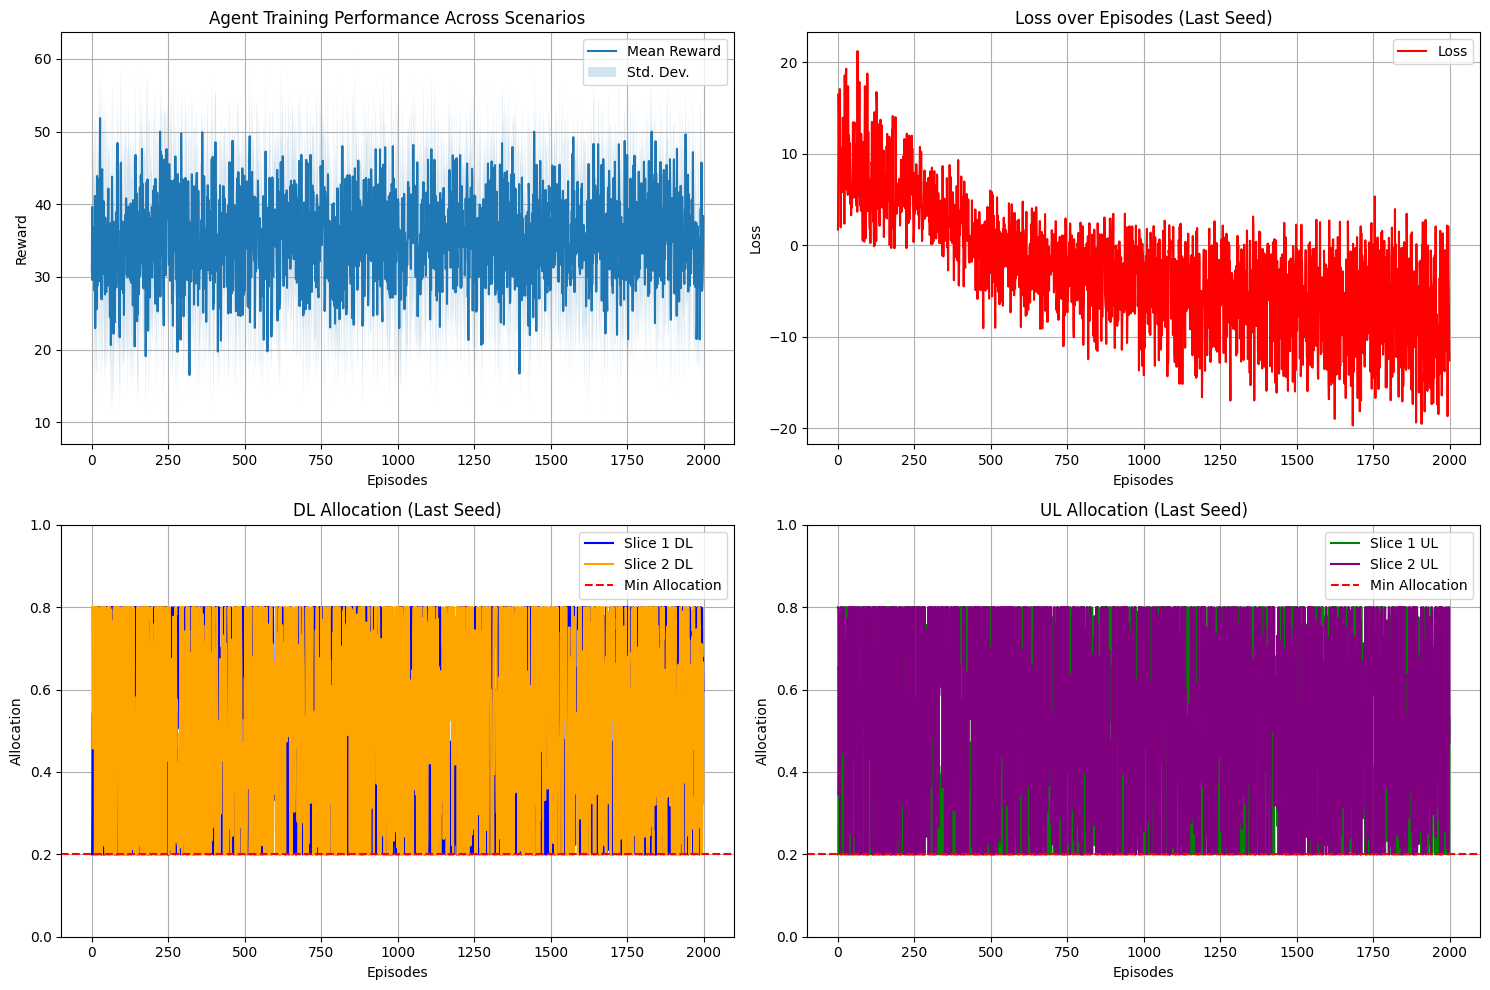

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Dirichlet
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import Dict, List, Tuple

from kpi_scenarios import KPI_DATASET

def fetch_network_data() -> Dict:
    scenario = random.choice(KPI_DATASET)
    print(f"\n--- Starting Episode with Scenario: {scenario['scenario_name']} ---")
    return scenario

class NetworkSliceEnv:
    def __init__(self):
        self.current_step = 0
        self.api_data = fetch_network_data()
        self.state = self.initial_state()
        self.min_allocation = 0.2
        self.update_scales()

    def update_scales(self):
        s1_dl, s1_ul = self.state['slice1']['downlink'], self.state['slice1']['uplink']
        s2_dl, s2_ul = self.state['slice2']['downlink'], self.state['slice2']['uplink']
        self.throughput_scale = max(s1_dl['throughput'], s1_ul['throughput'], s2_dl['throughput'], s2_ul['throughput'], 1)
        self.latency_scale = max(s1_dl['latency'], s1_ul['latency'], s2_dl['latency'], s2_ul['latency'], 1)
        self.jitter_scale = max(s1_dl['jitter'], s1_ul['jitter'], s2_dl['jitter'], s2_ul['jitter'], 1)
        packet_loss_max = max(s1_dl.get('packetLoss', 0), s1_ul.get('packetLoss', 0), s2_dl.get('packetLoss', 0), s2_ul.get('packetLoss', 0))
        self.packet_loss_scale = packet_loss_max if packet_loss_max > 0 else 1.0

    def initial_state(self) -> Dict:
        kpis = self.api_data["kpis"]
        return {
            'slice1': {'downlink': kpis[0]['downlink'], 'uplink': kpis[0]['uplink']},
            'slice2': {'downlink': kpis[1]['downlink'], 'uplink': kpis[1]['uplink']},
        }

    def reset(self) -> np.ndarray:
        self.current_step = 0
        self.api_data = fetch_network_data()
        self.state = self.initial_state()
        self.update_scales()
        return self.get_state_vector()

    def get_state_vector(self) -> np.ndarray:
        s1_dl, s1_ul = self.state['slice1']['downlink'], self.state['slice1']['uplink']
        s2_dl, s2_ul = self.state['slice2']['downlink'], self.state['slice2']['uplink']
        state_vector = [
            s1_dl['throughput'] / self.throughput_scale, s1_dl['latency'] / self.latency_scale, s1_dl['jitter'] / self.jitter_scale, s1_dl.get('packetLoss', 0) / self.packet_loss_scale,
            s1_ul['throughput'] / self.throughput_scale, s1_ul['latency'] / self.latency_scale, s1_ul['jitter'] / self.jitter_scale, s1_ul.get('packetLoss', 0) / self.packet_loss_scale,
            s2_dl['throughput'] / self.throughput_scale, s2_dl['latency'] / self.latency_scale, s2_dl['jitter'] / self.jitter_scale, s2_dl.get('packetLoss', 0) / self.packet_loss_scale,
            s2_ul['throughput'] / self.throughput_scale, s2_ul['latency'] / self.latency_scale, s2_ul['jitter'] / self.jitter_scale, s2_ul.get('packetLoss', 0) / self.packet_loss_scale,
        ]
        return np.array(state_vector, dtype=np.float32)

    def step(self, action_dl: np.ndarray, action_ul: np.ndarray) -> Tuple[np.ndarray, float, bool, Dict]:
        done = True
        next_state = self.get_state_vector()
        reward = self.compute_reward(action_dl, action_ul)
        return next_state, reward, done, {'dl': action_dl, 'ul': action_ul}

    def compute_reward(self, action_dl: np.ndarray, action_ul: np.ndarray) -> float:
        slice1, slice2 = self.state['slice1'], self.state['slice2']

        # --- Downlink Calculation ---
        max_dl_thr = max(slice1['downlink']['throughput'], slice2['downlink']['throughput'])
        min_dl_thr = min(slice1['downlink']['throughput'], slice2['downlink']['throughput'])
        achieved_dl_thr = (action_dl[0] * slice1['downlink']['throughput'] + action_dl[1] * slice2['downlink']['throughput'])
        dl_thr_reward = (achieved_dl_thr - min_dl_thr) / (max_dl_thr - min_dl_thr) if (max_dl_thr - min_dl_thr) > 0 else 0.5

        best_dl_lat = min(slice1['downlink']['latency'], slice2['downlink']['latency'])
        worst_dl_lat = max(slice1['downlink']['latency'], slice2['downlink']['latency'])
        achieved_dl_lat = (action_dl[0] * slice1['downlink']['latency'] + action_dl[1] * slice2['downlink']['latency'])
        dl_lat_penalty = (achieved_dl_lat - best_dl_lat) / (worst_dl_lat - best_dl_lat) if (worst_dl_lat - best_dl_lat) > 0 else 0

        best_dl_jit = min(slice1['downlink']['jitter'], slice2['downlink']['jitter'])
        worst_dl_jit = max(slice1['downlink']['jitter'], slice2['downlink']['jitter'])
        achieved_dl_jit = (action_dl[0] * slice1['downlink']['jitter'] + action_dl[1] * slice2['downlink']['jitter'])
        dl_jit_penalty = (achieved_dl_jit - best_dl_jit) / (worst_dl_jit - best_dl_jit) if (worst_dl_jit - best_dl_jit) > 0 else 0

        best_dl_pl = min(slice1['downlink'].get('packetLoss', 0), slice2['downlink'].get('packetLoss', 0))
        worst_dl_pl = max(slice1['downlink'].get('packetLoss', 0), slice2['downlink'].get('packetLoss', 0))
        achieved_dl_pl = (action_dl[0] * slice1['downlink'].get('packetLoss', 0) + action_dl[1] * slice2['downlink'].get('packetLoss', 0))
        dl_pl_penalty = (achieved_dl_pl - best_dl_pl) / (worst_dl_pl - best_dl_pl) if (worst_dl_pl - best_dl_pl) > 0 else 0

        # --- Uplink Calculation (Same Logic) ---
        max_ul_thr = max(slice1['uplink']['throughput'], slice2['uplink']['throughput'])
        min_ul_thr = min(slice1['uplink']['throughput'], slice2['uplink']['throughput'])
        achieved_ul_thr = (action_ul[0] * slice1['uplink']['throughput'] + action_ul[1] * slice2['uplink']['throughput'])
        ul_thr_reward = (achieved_ul_thr - min_ul_thr) / (max_ul_thr - min_ul_thr) if (max_ul_thr - min_ul_thr) > 0 else 0.5

        best_ul_lat = min(slice1['uplink']['latency'], slice2['uplink']['latency'])
        worst_ul_lat = max(slice1['uplink']['latency'], slice2['uplink']['latency'])
        achieved_ul_lat = (action_ul[0] * slice1['uplink']['latency'] + action_ul[1] * slice2['uplink']['latency'])
        ul_lat_penalty = (achieved_ul_lat - best_ul_lat) / (worst_ul_lat - best_ul_lat) if (worst_ul_lat - best_ul_lat) > 0 else 0

        best_ul_jit = min(slice1['uplink']['jitter'], slice2['uplink']['jitter'])
        worst_ul_jit = max(slice1['uplink']['jitter'], slice2['uplink']['jitter'])
        achieved_ul_jit = (action_ul[0] * slice1['uplink']['jitter'] + action_ul[1] * slice2['uplink']['jitter'])
        ul_jit_penalty = (achieved_ul_jit - best_ul_jit) / (worst_ul_jit - best_ul_jit) if (worst_ul_jit - best_ul_jit) > 0 else 0

        best_ul_pl = min(slice1['uplink'].get('packetLoss', 0), slice2['uplink'].get('packetLoss', 0))
        worst_ul_pl = max(slice1['uplink'].get('packetLoss', 0), slice2['uplink'].get('packetLoss', 0))
        achieved_ul_pl = (action_ul[0] * slice1['uplink'].get('packetLoss', 0) + action_ul[1] * slice2['uplink'].get('packetLoss', 0))
        ul_pl_penalty = (achieved_ul_pl - best_ul_pl) / (worst_ul_pl - best_ul_pl) if (worst_ul_pl - best_ul_pl) > 0 else 0

        # --- Much more aggressive weights ---
        dl_throughput_weight = 50.0
        ul_throughput_weight = 20.0
        penalty_weight = 0.1

        dl_reward = (dl_throughput_weight * dl_thr_reward) - (penalty_weight * (dl_lat_penalty + dl_jit_penalty + dl_pl_penalty))
        ul_reward = (ul_throughput_weight * ul_thr_reward) - (penalty_weight * (ul_lat_penalty + ul_jit_penalty + ul_pl_penalty))

        print(f"DL: thr_reward={dl_thr_reward:.3f}, lat_penalty={dl_lat_penalty:.3f}, jit_penalty={dl_jit_penalty:.3f}, pl_penalty={dl_pl_penalty:.3f}, total={dl_reward:.3f}")
        print(f"UL: thr_reward={ul_thr_reward:.3f}, lat_penalty={ul_lat_penalty:.3f}, jit_penalty={ul_jit_penalty:.3f}, pl_penalty={ul_pl_penalty:.3f}, total={ul_reward:.3f}")
        return dl_reward + ul_reward

# Policy Network (optionally increased capacity)
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim: int = 16, hidden_dim: int = 512, output_dim: int = 4):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.softplus = nn.Softplus()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        alphas = self.softplus(self.fc3(x)) + 1e-6
        return torch.clamp(alphas, min=0.1)

def sample_constrained_action(alpha: torch.Tensor, min_allocation: float) -> torch.Tensor:
    try:
        action = Dirichlet(alpha).sample()
        if torch.all(action >= min_allocation):
            return action
        else:
            if action[0] < min_allocation:
                delta = min_allocation - action[0]
                action[0] = min_allocation
                action[1] -= delta
            elif action[1] < min_allocation:
                delta = min_allocation - action[1]
                action[1] = min_allocation
                action[0] -= delta
            action = torch.clamp(action, min=min_allocation)
            return action / action.sum()
    except ValueError:
        return torch.tensor([0.5, 0.5])

def train_policy(num_episodes: int, seed: int) -> Tuple[List[float], ...]:
    torch.manual_seed(seed)
    np.random.seed(seed)

    env = NetworkSliceEnv()
    policy_network = PolicyNetwork(input_dim=len(env.get_state_vector()))
    optimizer = optim.Adam(policy_network.parameters(), lr=0.00001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)

    best_avg_reward = -float('inf')
    results = ([], [], [], [], [], [])

    for episode in range(num_episodes):
        obs = torch.tensor(env.reset(), dtype=torch.float32)

        print(f"\n--- Episode {episode} ---")
        print(f"Scenario: {env.api_data['scenario_name']}")
        print("Slice 1 DL:", env.state['slice1']['downlink'])
        print("Slice 1 UL:", env.state['slice1']['uplink'])
        print("Slice 2 DL:", env.state['slice2']['downlink'])
        print("Slice 2 UL:", env.state['slice2']['uplink'])

        if torch.isnan(obs).any():
            print(f"WARNING: NaN detected in state for scenario: {env.api_data['scenario_name']}. Skipping episode.")
            continue

        all_alphas = policy_network(obs)
        alpha_dl, alpha_ul = torch.split(all_alphas, 2)
        action_dl = sample_constrained_action(alpha_dl, env.min_allocation)
        action_ul = sample_constrained_action(alpha_ul, env.min_allocation)

        _next_state, reward, done, _ = env.step(action_dl.detach().numpy(), action_ul.detach().numpy())

        log_prob = Dirichlet(alpha_dl).log_prob(action_dl) + Dirichlet(alpha_ul).log_prob(action_ul)
        loss = -log_prob * reward

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        results[0].append(reward)
        results[1].append(loss.item())
        results[2].append(action_dl[0].item())
        results[3].append(action_dl[1].item())
        results[4].append(action_ul[0].item())
        results[5].append(action_ul[1].item())

        print(f"Episode: {episode} Alpha DL: {alpha_dl} Action DL: {action_dl}")
        print(f"Episode: {episode} Alpha UL: {alpha_ul} Action UL: {action_ul}")

        if episode % 10 == 0:
            print(f"\n--- Episode {episode:3d} Summary ---")
            print(f"Reward: {reward:8.2f} | Loss: {loss.item():8.2f}\n")

        if reward > best_avg_reward:
            best_avg_reward = reward
            torch.save(policy_network.state_dict(), f'best_policy_model_seed_{seed}.pth')

        scheduler.step()

    return results

def run_experiments(num_seeds: int, num_episodes: int):
    all_rewards_history = []
    final_results_for_plotting = None

    for seed in range(num_seeds):
        print(f"\n--- RUNNING SEED {seed + 1}/{num_seeds} ---")
        results = train_policy(num_episodes, seed)
        if results and results[0]:
            all_rewards_history.append(results[0])
            final_results_for_plotting = results

    if not final_results_for_plotting:
        print("Training failed for all seeds or no data was collected.")
        return

    all_rewards_history = np.array(all_rewards_history)
    mean_rewards = np.mean(all_rewards_history, axis=0)
    std_rewards = np.std(all_rewards_history, axis=0)

    reward_history, loss_history, dl_s1, dl_s2, ul_s1, ul_s2 = final_results_for_plotting

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(mean_rewards, label='Mean Reward')
    plt.fill_between(range(len(mean_rewards)), mean_rewards - std_rewards, mean_rewards + std_rewards, alpha=0.2, label='Std. Dev.')
    plt.title('Agent Training Performance Across Scenarios')
    plt.xlabel('Episodes'); plt.ylabel('Reward'); plt.legend(); plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(loss_history, 'r', label='Loss')
    plt.title('Loss over Episodes (Last Seed)'); plt.xlabel('Episodes'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(dl_s1, 'b', label='Slice 1 DL'); plt.plot(dl_s2, 'orange', label='Slice 2 DL')
    plt.axhline(y=0.2, color='r', linestyle='--', label='Min Allocation')
    plt.ylim(0, 1); plt.title('DL Allocation (Last Seed)'); plt.xlabel('Episodes'); plt.ylabel('Allocation'); plt.legend(); plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(ul_s1, 'g', label='Slice 1 UL'); plt.plot(ul_s2, 'purple', label='Slice 2 UL')
    plt.axhline(y=0.2, color='r', linestyle='--', label='Min Allocation')
    plt.ylim(0, 1); plt.title('UL Allocation (Last Seed)'); plt.xlabel('Episodes'); plt.ylabel('Allocation'); plt.legend(); plt.grid(True)

    plt.tight_layout()

    plot_filename = 'training_results.png'
    plt.savefig(plot_filename)
    print(f"\n--- Plot saved to {plot_filename} ---")

    try:
        plt.show()
    except Exception as e:
        print(f"Could not display plot interactively: {e}")

if __name__ == "__main__":
    NUM_SEEDS = 5
    NUM_EPISODES = 2000

    run_experiments(num_seeds=NUM_SEEDS, num_episodes=NUM_EPISODES)

#Train_validate_test.py

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Dirichlet
import numpy as np
import matplotlib.pyplot as plt
import random
import json
from typing import Dict, List, Tuple

# --- Stage 1: Load Final Datasets and Normalization Stats ---
print("--- Loading Final Train/Validation/Test Splits and Stats ---")

try:
    with open('train_set.json', 'r') as f:
        train_set = json.load(f)
    with open('validation_set.json', 'r') as f:
        val_set = json.load(f)
    with open('test_set.json', 'r') as f:
        test_set = json.load(f)

    with open('kpi_stats_unified.json', 'r') as f:
        kpi_stats = json.load(f)

    STATS_MEAN = np.array(kpi_stats['mean'], dtype=np.float32)
    STATS_STD = np.array(kpi_stats['std'], dtype=np.float32)

    print("Successfully loaded all necessary files.")
    print(f"  - Training Set:      {len(train_set)} scenarios")
    print(f"  - Validation Set:    {len(val_set)} scenarios")
    print(f"  - Test Set (Live):   {len(test_set)} scenarios")
    print("-" * 50)

except FileNotFoundError as e:
    print(f"❌ ERROR: A required file is missing: {e.filename}")
    print("Please ensure you have run the following scripts in order:")
    print("  1. `build_master_dataset.py`")
    print("  2. `compute_stats.py master_dataset_unified.json kpi_stats_unified.json`")
    print("  3. `create_data_splits.py`")
    exit() # Exit the script if files are not ready

# --- Stage 2: Modified Environment and Model (Largely the same) ---

class NetworkSliceEnv:
    def __init__(self):
        self.api_data = None # Will be set by reset()
        self.state = None
        self.min_allocation = 0.2
        self.throughput_scale = 1.0
        self.latency_scale = 1.0
        self.jitter_scale = 1.0
        self.packet_loss_scale = 1.0

    def update_scales(self):
        s1_dl, s1_ul = self.state['slice1']['downlink'], self.state['slice1']['uplink']
        s2_dl, s2_ul = self.state['slice2']['downlink'], self.state['slice2']['uplink']
        self.throughput_scale = max(s1_dl['throughput'], s1_ul['throughput'], s2_dl['throughput'], s2_ul['throughput'], 1)
        self.latency_scale = max(s1_dl['latency'], s1_ul['latency'], s2_dl['latency'], s2_ul['latency'], 1)
        self.jitter_scale = max(s1_dl['jitter'], s1_ul['jitter'], s2_dl['jitter'], s2_ul['jitter'], 1)
        packet_loss_max = max(s1_dl.get('packetLoss', 0), s1_ul.get('packetLoss', 0), s2_dl.get('packetLoss', 0), s2_ul.get('packetLoss', 0))
        self.packet_loss_scale = packet_loss_max if packet_loss_max > 0 else 1.0

    def initial_state(self) -> Dict:
        kpis = self.api_data["kpis"]
        return {
            'slice1': {'downlink': kpis[0]['downlink'], 'uplink': kpis[0]['uplink']},
            'slice2': {'downlink': kpis[1]['downlink'], 'uplink': kpis[1]['uplink']},
        }

    def reset(self, scenario: Dict) -> np.ndarray:
        """### MODIFIED: Reset now accepts a scenario dict."""
        self.api_data = scenario
        self.state = self.initial_state()
        self.update_scales()
        return self.get_state_vector()

    def get_state_vector(self) -> np.ndarray:
        s1_dl, s1_ul = self.state['slice1']['downlink'], self.state['slice1']['uplink']
        s2_dl, s2_ul = self.state['slice2']['downlink'], self.state['slice2']['uplink']
        state_vector = [
            s1_dl['throughput'] / self.throughput_scale, s1_dl['latency'] / self.latency_scale, s1_dl['jitter'] / self.jitter_scale, s1_dl.get('packetLoss', 0) / self.packet_loss_scale,
            s1_ul['throughput'] / self.throughput_scale, s1_ul['latency'] / self.latency_scale, s1_ul['jitter'] / self.jitter_scale, s1_ul.get('packetLoss', 0) / self.packet_loss_scale,
            s2_dl['throughput'] / self.throughput_scale, s2_dl['latency'] / self.latency_scale, s2_dl['jitter'] / self.jitter_scale, s2_dl.get('packetLoss', 0) / self.packet_loss_scale,
            s2_ul['throughput'] / self.throughput_scale, s2_ul['latency'] / self.latency_scale, s2_ul['jitter'] / self.jitter_scale, s2_ul.get('packetLoss', 0) / self.packet_loss_scale,
        ]
        return np.array(state_vector, dtype=np.float32)

    def step(self, action_dl: np.ndarray, action_ul: np.ndarray) -> Tuple[np.ndarray, float, bool, Dict]:
        done = True
        next_state = self.get_state_vector()
        reward = self.compute_reward(action_dl, action_ul)
        return next_state, reward, done, {'dl': action_dl, 'ul': action_ul}

    # In train_validate_test.py, inside the NetworkSliceEnv class

    # In train_validate_test.py, inside the NetworkSliceEnv class

    def compute_reward(self, action_dl: np.ndarray, action_ul: np.ndarray) -> float:
        """
        ### FINAL HYBRID REWARD FUNCTION v3 ###
        This function uses RAW KPI values, scaled by factors that represent
        their real-world business value. This directly translates our goals
        into a mathematical objective the AI can optimize.
        """
        s1 = self.state['slice1']
        s2 = self.state['slice2']

        # --- Define our "Business Value" scale ---
        # We will convert every KPI into a single currency: "Reward Points".

        # 1. THROUGHPUT: Our primary goal.
        #    We define 1 Reward Point = 1 Megabit per second (Mbps).
        #    We divide the raw throughput (in bps) by 1,000,000 to get Mbps.
        THROUGHPUT_SCALE = 1_000_000.0

        # 2. LATENCY PENALTY:
        #    We decide that every millisecond of latency costs 0.1 points.
        LATENCY_POINT_COST = 0.1

        # 3. JITTER PENALTY:
        #    Less important. Every millisecond of jitter costs 0.05 points.
        JITTER_POINT_COST = 0.05

        # 4. PACKET LOSS PENALTY: Very important.
        #    We decide that 1% of packet loss (a value of 0.01) is a severe issue
        #    and should cost us 100 Reward Points. This makes the weight 10,000.
        #    (0.01 * 10,000 = 100 points).
        PACKET_LOSS_POINT_COST = 10_000.0

        # --- Calculate Downlink Reward ---
        achieved_dl_thr_points = (action_dl[0] * s1['downlink']['throughput'] + action_dl[1] * s2['downlink']['throughput']) / THROUGHPUT_SCALE

        penalty_dl_lat = (action_dl[0] * s1['downlink']['latency'] + action_dl[1] * s2['downlink']['latency']) * LATENCY_POINT_COST
        penalty_dl_jit = (action_dl[0] * s1['downlink']['jitter'] + action_dl[1] * s2['downlink']['jitter']) * JITTER_POINT_COST
        penalty_dl_pl = (action_dl[0] * s1['downlink'].get('packetLoss', 0) + action_dl[1] * s2['downlink'].get('packetLoss', 0)) * PACKET_LOSS_POINT_COST

        dl_reward = achieved_dl_thr_points - penalty_dl_lat - penalty_dl_jit - penalty_dl_pl

        # --- Calculate Uplink Reward ---
        achieved_ul_thr_points = (action_ul[0] * s1['uplink']['throughput'] + action_ul[1] * s2['uplink']['throughput']) / THROUGHPUT_SCALE

        penalty_ul_lat = (action_ul[0] * s1['uplink']['latency'] + action_ul[1] * s2['uplink']['latency']) * LATENCY_POINT_COST
        penalty_ul_jit = (action_ul[0] * s1['uplink']['jitter'] + action_ul[1] * s2['uplink']['jitter']) * JITTER_POINT_COST
        penalty_ul_pl = (action_ul[0] * s1['uplink'].get('packetLoss', 0) + action_ul[1] * s2['uplink'].get('packetLoss', 0)) * PACKET_LOSS_POINT_COST

        ul_reward = achieved_ul_thr_points - penalty_ul_lat - penalty_ul_jit - penalty_ul_pl

        return dl_reward + ul_reward
# Same Policy Network and Action Sampler
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim: int = 16, hidden_dim: int = 256, output_dim: int = 4):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.softplus = nn.Softplus()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        alphas = self.softplus(self.fc3(x)) + 1e-6
        return alphas #torch.clamp(alphas, min=0.1)

def sample_constrained_action(alpha: torch.Tensor, min_allocation: float) -> torch.Tensor:
    try:
        action = Dirichlet(alpha).sample()
        if torch.all(action >= min_allocation):
            return action
        else:
            if action[0] < min_allocation:
                delta = min_allocation - action[0]
                action[0] = min_allocation
                action[1] -= delta
            elif action[1] < min_allocation:
                delta = min_allocation - action[1]
                action[1] = min_allocation
                action[0] -= delta
            action = torch.clamp(action, min=min_allocation)
            return action / action.sum()
    except ValueError:
        return torch.tensor([0.5, 0.5])

# --- Stage 3: New Validation and Modified Training Functions ---

def validate_model(policy_network: PolicyNetwork, validation_data: List[Dict], env: NetworkSliceEnv) -> float:
    """### NEW: Function to evaluate the model on the validation set."""
    if not validation_data: # Check if validation_data is empty
        return 0.0 # Return 0 reward or handle as appropriate for an empty set

    policy_network.eval()  # Set the model to evaluation mode
    total_val_reward = 0
    with torch.no_grad():  # We don't need to compute gradients for validation
        for scenario in validation_data:
            obs = torch.tensor(env.reset(scenario), dtype=torch.float32)
            all_alphas = policy_network(obs)
            alpha_dl, alpha_ul = torch.split(all_alphas, 2)
            action_dl = sample_constrained_action(alpha_dl, env.min_allocation)
            action_ul = sample_constrained_action(alpha_ul, env.min_allocation)
            _, reward, _, _ = env.step(action_dl.detach().numpy(), action_ul.detach().numpy())
            total_val_reward += reward
    policy_network.train() # Set the model back to training mode
    return total_val_reward / len(validation_data)

def train_and_validate(training_data: List[Dict], validation_data: List[Dict], num_epochs: int, seed: int):
    """### MODIFIED: The main training loop now includes validation."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    env = NetworkSliceEnv()
    policy_network = PolicyNetwork(input_dim=16)
    optimizer = optim.Adam(policy_network.parameters(), lr=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9) # Decay LR by 10% every 5 epochs

    best_validation_reward = -float('inf')
    model_save_path = f'best_validated_model_seed_{seed}.pth'

    # We now loop over epochs, where one epoch is one pass through the training data
    for epoch in range(num_epochs):
        random.shuffle(training_data) # Shuffle training data each epoch
        total_epoch_reward = 0
        total_epoch_loss = 0

        for scenario in training_data:
            obs = torch.tensor(env.reset(scenario), dtype=torch.float32)

            all_alphas = policy_network(obs)
            alpha_dl, alpha_ul = torch.split(all_alphas, 2)
            action_dl = sample_constrained_action(alpha_dl, env.min_allocation)
            action_ul = sample_constrained_action(alpha_ul, env.min_allocation)

            _, reward, _, _ = env.step(action_dl.detach().numpy(), action_ul.detach().numpy())
            log_prob = Dirichlet(alpha_dl).log_prob(action_dl) + Dirichlet(alpha_ul).log_prob(action_ul)
            loss = -log_prob * reward

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_epoch_reward += reward
            total_epoch_loss += loss.item()

        # --- Validation Step ---
        if validation_data: # Only validate if there is validation data
            avg_validation_reward = validate_model(policy_network, validation_data, env)
            avg_train_reward = total_epoch_reward / len(training_data)

            print(f"Epoch {epoch+1}/{num_epochs} | Avg Train Reward: {avg_train_reward:.3f} | Avg Validation Reward: {avg_validation_reward:.3f}")

            if avg_validation_reward > best_validation_reward:
                best_validation_reward = avg_validation_reward
                torch.save(policy_network.state_dict(), model_save_path)
                print(f"  -> New best model saved to {model_save_path} with validation reward: {avg_validation_reward:.3f}")
        else:
            # If no validation data, just print training info and save model based on training reward (or skip saving)
            avg_train_reward = total_epoch_reward / len(training_data)
            print(f"Epoch {epoch+1}/{num_epochs} | Avg Train Reward: {avg_train_reward:.3f} | No validation data provided.")
            # Optionally save the model based on training reward if no validation set is available
            if avg_train_reward > best_validation_reward: # Using training reward as a proxy for 'best'
                 best_validation_reward = avg_train_reward
                 torch.save(policy_network.state_dict(), model_save_path)
                 print(f"  -> Model saved based on training reward to {model_save_path}")

        scheduler.step()

    return model_save_path

def test_final_model(model_path: str, test_data: List[Dict]):
    """### NEW: Function to test the final, best model on the unseen test set."""
    print("\n--- Running Final Test on the Unseen Test Set ---")
    env = NetworkSliceEnv()
    model = PolicyNetwork(input_dim=16)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    total_test_reward = 0
    with torch.no_grad():
        for scenario in test_data:
            obs = torch.tensor(env.reset(scenario), dtype=torch.float32)
            all_alphas = model(obs)
            alpha_dl, alpha_ul = torch.split(all_alphas, 2)
            action_dl = sample_constrained_action(alpha_dl, env.min_allocation)
            action_ul = sample_constrained_action(alpha_ul, env.min_allocation)
            _, reward, _, _ = env.step(action_dl.detach().numpy(), action_ul.detach().numpy())
            total_test_reward += reward

            print(f"  Scenario: {scenario['scenario_name']:<30} | Reward: {reward:.3f} | DL: [{action_dl[0]:.2f}, {action_dl[1]:.2f}] | UL: [{action_ul[0]:.2f}, {action_ul[1]:.2f}]")

    avg_test_reward = total_test_reward / len(test_data)
    print("-" * 50)
    print(f"🏆 Final Average Test Reward: {avg_test_reward:.3f} 🏆")
    print("-" * 50)

if __name__ == "__main__":
    NUM_EPOCHS = 50 # An epoch is one full pass through the training data

    # Train the model and get the path to the best version
    best_model_path = train_and_validate(
        training_data=train_set,
        validation_data=val_set,
        num_epochs=NUM_EPOCHS,
        seed=42
    )

    # Test the final, best model on the unseen test data
    test_final_model(best_model_path, test_set)

--- Loading Final Train/Validation/Test Splits and Stats ---
❌ ERROR: A required file is missing: train_set.json
Please ensure you have run the following scripts in order:
  1. `build_master_dataset.py`
  2. `compute_stats.py master_dataset_unified.json kpi_stats_unified.json`
  3. `create_data_splits.py`


NameError: name 'train_set' is not defined

In [ ]:
# train_validate_test_corrected.py
#
# This script has been corrected to align with the robust `inference_server_corrected.py`.
#
# KEY CORRECTIONS:
# 1. FIXED NORMALIZATION: Implements a static `SLICING_CONFIG` for stable state
#    normalization, eliminating the flawed on-the-fly scaling.
# 2. SYNCHRONIZED LOGIC: The NetworkSliceEnv, PolicyNetwork, and action sampling
#    functions are now identical to the corrected inference server.
# 3. SIMPLIFIED DATA LOADING: Removed loading of unused statistics files.
#
# This script will produce a model that is stable, reliable, and compatible with the
# corrected production server.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Dirichlet
import numpy as np
import json
import random
from typing import Dict, List, Tuple, Any

# --- Stage 1: Define Static Configuration and Load Data ---
print("--- Initializing Configuration and Loading Data Splits ---")

# **CRITICAL CHANGE**: Define FIXED normalization scales and configuration.
# These values MUST be determined from your training dataset (e.g., by taking the
# 99th percentile or a reasonable max value for each KPI).
# THE VALUES BELOW ARE EXAMPLES. PLEASE TUNE THEM BASED ON YOUR DATA ANALYSIS.
SLICING_CONFIG = {
    "normalization_scales": {
        "throughput": 1000.0,   # Example: 1000 Mbps
        "latency": 150.0,       # Example: 150 ms
        "jitter": 50.0,         # Example: 50 ms
        "packet_loss": 1.0,     # Packet loss is a rate [0.0, 1.0]
    },
    "min_allocation": 0.2
}

try:
    with open('train_set.json', 'r') as f:
        train_set = json.load(f)
    with open('validation_set.json', 'r') as f:
        val_set = json.load(f)
    with open('test_set.json', 'r') as f:
        test_set = json.load(f)

    print("Successfully loaded train, validation, and test set files.")
    print(f"  - Training Set:      {len(train_set)} scenarios")
    print(f"  - Validation Set:    {len(val_set)} scenarios")
    print(f"  - Test Set:          {len(test_set)} scenarios")
    print("-" * 50)

except FileNotFoundError as e:
    print(f"❌ ERROR: A required data split file is missing: {e.filename}")
    print("Please ensure `train_set.json`, `validation_set.json`, and `test_set.json` exist.")
    exit()

# --- Stage 2: Corrected Environment and Model ---

class NetworkSliceEnv:
    def __init__(self, config: Dict[str, Any]):
        """### MODIFIED: The environment is now initialized with the static config."""
        self.config = config
        self.api_data = None  # Will be set by reset()
        self.state_kpis = None # Renamed for clarity

    def initial_kpis(self) -> Dict:
        kpis = self.api_data["kpis"]
        return {
            'slice1': {'downlink': kpis[0]['downlink'], 'uplink': kpis[0]['uplink']},
            'slice2': {'downlink': kpis[1]['downlink'], 'uplink': kpis[1]['uplink']},
        }

    def reset(self, scenario: Dict) -> np.ndarray:
        """### MODIFIED: Resets the environment state for a given scenario."""
        self.api_data = scenario
        self.state_kpis = self.initial_kpis()
        # The flawed `update_scales()` method is no longer called.
        return self.get_state_vector()

    def get_state_vector(self) -> np.ndarray:
        """
        ### CRITICAL MODIFICATION: Processes KPIs into a normalized state vector
        using the FIXED scales from the configuration. This ensures stability.
        """
        s1 = self.state_kpis['slice1']
        s2 = self.state_kpis['slice2']

        scales = self.config["normalization_scales"]

        # Helper to safely clip and normalize a value, identical to inference server.
        def norm(value, scale):
            return min(value, scale) / scale

        state_vector = [
            norm(s1['downlink']['throughput'], scales['throughput']),
            norm(s1['downlink']['latency'], scales['latency']),
            norm(s1['downlink']['jitter'], scales['jitter']),
            norm(s1['downlink'].get('packetLoss', 0), scales['packet_loss']),

            norm(s1['uplink']['throughput'], scales['throughput']),
            norm(s1['uplink']['latency'], scales['latency']),
            norm(s1['uplink']['jitter'], scales['jitter']),
            norm(s1['uplink'].get('packetLoss', 0), scales['packet_loss']),

            norm(s2['downlink']['throughput'], scales['throughput']),
            norm(s2['downlink']['latency'], scales['latency']),
            norm(s2['downlink']['jitter'], scales['jitter']),
            norm(s2['downlink'].get('packetLoss', 0), scales['packet_loss']),

            norm(s2['uplink']['throughput'], scales['throughput']),
            norm(s2['uplink']['latency'], scales['latency']),
            norm(s2['uplink']['jitter'], scales['jitter']),
            norm(s2['uplink'].get('packetLoss', 0), scales['packet_loss']),
        ]

        return np.array(state_vector, dtype=np.float32)

    def step(self, action_dl: np.ndarray, action_ul: np.ndarray) -> Tuple[np.ndarray, float, bool, Dict]:
        """Calculates the reward for a given action. The episode is always one step long."""
        done = True
        # Since state doesn't change after action, next_state is the same as current state vector
        next_state = self.get_state_vector()
        reward = self.compute_reward(action_dl, action_ul)
        return next_state, reward, done, {'dl': action_dl, 'ul': action_ul}

    def compute_reward(self, action_dl: np.ndarray, action_ul: np.ndarray) -> float:
        """
        ### MODIFIED REWARD FUNCTION v2 ###
        Re-scaled to balance penalties and rewards, encouraging throughput more effectively.
        """
        s1 = self.state_kpis['slice1']
        s2 = self.state_kpis['slice2']

        # --- Define our "Business Value" scale ---
        # 1. THROUGHPUT: Our primary goal. We'll add a multiplier to make it more attractive.
        THROUGHPUT_REWARD_MULTIPLIER = 5.0  # Make 1 Mbps worth 5 points
        THROUGHPUT_SCALE = 1_000_000.0

        # 2. LATENCY PENALTY: Keep this the same for now.
        LATENCY_POINT_COST = 0.1

        # 3. JITTER PENALTY: Keep this the same for now.
        JITTER_POINT_COST = 0.05

        # 4. PACKET LOSS PENALTY: Drastically reduce this.
        #    Now, 1% packet loss (0.01) costs 1 point (0.01 * 100), not 100 points.
        #    This is much more balanced.
        PACKET_LOSS_POINT_COST = 100.0

        # --- Calculate Total Reward ---
        total_throughput = (action_dl[0] * s1['downlink']['throughput'] + action_dl[1] * s2['downlink']['throughput'] +
                            action_ul[0] * s1['uplink']['throughput']   + action_ul[1] * s2['uplink']['throughput'])

        total_latency = (action_dl[0] * s1['downlink']['latency'] + action_dl[1] * s2['downlink']['latency'] +
                         action_ul[0] * s1['uplink']['latency']   + action_ul[1] * s2['uplink']['latency'])

        total_jitter = (action_dl[0] * s1['downlink']['jitter'] + action_dl[1] * s2['downlink']['jitter'] +
                        action_ul[0] * s1['uplink']['jitter']   + action_ul[1] * s2['uplink']['jitter'])

        total_packet_loss = (action_dl[0] * s1['downlink'].get('packetLoss', 0) + action_dl[1] * s2['downlink'].get('packetLoss', 0) +
                             action_ul[0] * s1['uplink'].get('packetLoss', 0)   + action_ul[1] * s2['uplink'].get('packetLoss', 0))

        # Combine into a final reward
        reward = ( (total_throughput / THROUGHPUT_SCALE) * THROUGHPUT_REWARD_MULTIPLIER
                   - total_latency * LATENCY_POINT_COST
                   - total_jitter * JITTER_POINT_COST
                   - total_packet_loss * PACKET_LOSS_POINT_COST )

        return reward
class PolicyNetwork(nn.Module):
    """Identical to the inference server."""
    def __init__(self, input_dim: int = 16, hidden_dim: int = 256, output_dim: int = 4):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.softplus = nn.Softplus()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        alphas = self.softplus(self.fc3(x)) + 1e-6
        # ### MODIFIED: Clamp alphas to ensure stability for Dirichlet distribution.
        return torch.clamp(alphas, min=0.1)

def sample_constrained_action(alpha: torch.Tensor, min_allocation: float) -> torch.Tensor:
    """### MODIFIED: Using the more robust action sampling function."""
    from torch.distributions import Dirichlet
    if torch.any(alpha <= 0):
        return torch.tensor([0.5, 0.5], dtype=torch.float32)
    try:
        dist = Dirichlet(alpha)
        action = dist.sample()
        if torch.any(action < min_allocation):
            below_min_mask = action < min_allocation
            action[below_min_mask] = min_allocation
            above_min_mask = ~below_min_mask
            if not torch.any(above_min_mask):
                return action / action.sum()
            sum_of_mins = torch.sum(action[below_min_mask])
            required_sum_above = 1.0 - sum_of_mins
            current_sum_above = torch.sum(action[above_min_mask])
            if current_sum_above > 0:
                action[above_min_mask] = (action[above_min_mask] / current_sum_above) * required_sum_above
            else:
                action[above_min_mask] = required_sum_above / torch.sum(above_min_mask.float())
        return action / action.sum()
    except ValueError:
        return torch.tensor([0.5, 0.5], dtype=torch.float32)

# --- Stage 3: Training, Validation, and Testing Functions ---

def validate_model(policy_network: PolicyNetwork, validation_data: List[Dict], env: NetworkSliceEnv) -> float:
    """Evaluates the model on the validation set."""
    if not validation_data: return 0.0
    policy_network.eval()
    total_val_reward = 0
    with torch.no_grad():
        for scenario in validation_data:
            obs = torch.tensor(env.reset(scenario), dtype=torch.float32)
            all_alphas = policy_network(obs)
            alpha_dl, alpha_ul = torch.split(all_alphas, 2)
            action_dl = sample_constrained_action(alpha_dl, env.config["min_allocation"])
            action_ul = sample_constrained_action(alpha_ul, env.config["min_allocation"])
            _, reward, _, _ = env.step(action_dl.detach().numpy(), action_ul.detach().numpy())
            total_val_reward += reward
    policy_network.train()
    return total_val_reward / len(validation_data)

def train_and_validate(training_data: List[Dict], validation_data: List[Dict], num_epochs: int, seed: int, config: Dict):
    """Main training loop, now using the static config."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # ### MODIFIED: Pass the config to the environment
    env = NetworkSliceEnv(config=config)
    policy_network = PolicyNetwork(input_dim=16)
    optimizer = optim.Adam(policy_network.parameters(), lr=5e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.95)

    best_validation_reward = -float('inf')
    model_save_path = f'best_validated_model_seed_{seed}.pth'

    for epoch in range(num_epochs):
        random.shuffle(training_data)
        total_epoch_reward = 0
        policy_network.train()

        for scenario in training_data:
            obs = torch.tensor(env.reset(scenario), dtype=torch.float32)
            all_alphas = policy_network(obs)
            alpha_dl, alpha_ul = torch.split(all_alphas, 2)

            # ### MODIFIED: Use min_allocation from the config
            action_dl = sample_constrained_action(alpha_dl, env.config["min_allocation"])
            action_ul = sample_constrained_action(alpha_ul, env.config["min_allocation"])

            _, reward, _, _ = env.step(action_dl.detach().numpy(), action_ul.detach().numpy())

            # Using REINFORCE with baseline could be a future improvement, but this is the core logic.
            log_prob = Dirichlet(alpha_dl).log_prob(action_dl) + Dirichlet(alpha_ul).log_prob(action_ul)
            loss = -log_prob * reward

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_epoch_reward += reward

        avg_validation_reward = validate_model(policy_network, validation_data, env)
        avg_train_reward = total_epoch_reward / len(training_data)
        print(f"Epoch {epoch+1}/{num_epochs} | Avg Train Reward: {avg_train_reward:.3f} | Avg Validation Reward: {avg_validation_reward:.3f}")

        if avg_validation_reward > best_validation_reward:
            best_validation_reward = avg_validation_reward
            torch.save(policy_network.state_dict(), model_save_path)
            print(f"  -> New best model saved to {model_save_path} with validation reward: {avg_validation_reward:.3f}")

        scheduler.step()

    print(f"\nTraining complete. Best model saved to {model_save_path}")
    return model_save_path

def test_final_model(model_path: str, test_data: List[Dict], config: Dict):
    """Tests the final model on the unseen test set."""
    print("\n--- Running Final Test on the Unseen Test Set ---")
    # ### MODIFIED: Pass the config to the environment
    env = NetworkSliceEnv(config=config)
    model = PolicyNetwork(input_dim=16)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    total_test_reward = 0
    with torch.no_grad():
        for scenario in test_data:
            obs = torch.tensor(env.reset(scenario), dtype=torch.float32)
            all_alphas = model(obs)
            alpha_dl, alpha_ul = torch.split(all_alphas, 2)
            action_dl = sample_constrained_action(alpha_dl, env.config["min_allocation"])
            action_ul = sample_constrained_action(alpha_ul, env.config["min_allocation"])
            _, reward, _, _ = env.step(action_dl.detach().numpy(), action_ul.detach().numpy())
            total_test_reward += reward

            print(f"  Scenario: {scenario['scenario_name']:<30} | Reward: {reward:.3f} | DL: [{action_dl[0]:.2f}, {action_dl[1]:.2f}] | UL: [{action_ul[0]:.2f}, {action_ul[1]:.2f}]")

    avg_test_reward = total_test_reward / len(test_data)
    print("-" * 50)
    print(f"🏆 Final Average Test Reward: {avg_test_reward:.3f} 🏆")
    print("-" * 50)

if __name__ == "__main__":
    NUM_EPOCHS = 50

    best_model_path = train_and_validate(
        training_data=train_set,
        validation_data=val_set,
        num_epochs=NUM_EPOCHS,
        seed=42,
        config=SLICING_CONFIG # ### MODIFIED: Pass config to training function
    )

    if best_model_path:
        test_final_model(
            model_path=best_model_path,
            test_data=test_set,
            config=SLICING_CONFIG # ### MODIFIED: Pass config to testing function
        )

--- Initializing Configuration and Loading Data Splits ---
❌ ERROR: A required data split file is missing: train_set.json
Please ensure `train_set.json`, `validation_set.json`, and `test_set.json` exist.


NameError: name 'train_set' is not defined